# Extracting features 

In [1]:
import sys
import os

src_path = os.path.split(os.getcwd())[0]
sys.path.insert(0, src_path)

import json
import logging
import numpy as np
import pandas as pd
from pathlib import Path, PurePath
from collections import OrderedDict
from itertools import chain

import torch
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

import clip.clip as clip
from training.datasets import CellPainting
from clip.clip import _transform
from clip.model import convert_weights, CLIPGeneral
from tqdm import tqdm

from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs

from sklearn.metrics import accuracy_score, top_k_accuracy_score

from huggingface_hub import hf_hub_download

In [2]:
FILENAME = "cloome-retrieval-zero-shot.pt"
REPO_ID = "anasanchezf/cloome"
checkpoint_path = hf_hub_download(REPO_ID, FILENAME)

In [3]:
# CLOOB
model = "RN50"
image_resolution = 2500
img_path = "/share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz"

mol_path = '/share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/morgan_chiral_fps_P102785.hdf5'
val = '/share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/metadata_P102785_ALL.csv'

#mol_path = '/share/data/analyses/silvija/RT/data_cloome/our_images/morgan_fingerprint_v2.h5'             # Version before preprocessing_molecules.ipynb

#mol_path = '/share/data/analyses/silvija/RT/data_cloome/our_images/morgan_chiral_fps.hdf5'               # Used for 6 samples
#val = '/share/data/analyses/silvija/RT/data_cloome/our_images/metadata_try_v5.csv'

#mol_path = "morgan_chiral_fps_1024.hdf5"
#val = "cellpainting-test-phenotype-imgpermol.csv"
#classes = "cellpainting-split-test-imgpermol.csv"

In [4]:
def convert_models_to_fp32(model):
    for p in model.parameters():
        p.data = p.data.float()
        if p.grad:
            p.grad.data = p.grad.data.float()

In [5]:
def load(model_path, device, model, image_resolution):

    checkpoint = torch.load(model_path, map_location=torch.device('cpu'))
    state_dict = checkpoint["state_dict"]

    model_config_file = os.path.join(src_path, f"training/model_configs/{model.replace('/', '-')}.json")

    print(f"\nload()\n\tLoading model from {model_config_file}")
    assert os.path.exists(model_config_file)
    with open(model_config_file, 'r') as f:
        model_info = json.load(f)
    model = CLIPGeneral(**model_info)

    if str(device) == "cpu":
        model.float()
    print(f"\tdevice = {device}")

    new_state_dict = {k[len('module.'):]: v for k,v in state_dict.items()}

    model.load_state_dict(new_state_dict)
    model.to(device)
    model.eval()

    return model, _transform(image_resolution, image_resolution,  is_train=False)

In [6]:
def get_features(dataset, model, device):
    all_image_features = []
    all_text_features = []
    all_ids = []

  #  print(f"get_features {device}")
  #  print(f"len(dataset/val) = {len(dataset)}")
  #  print(f"type of dataset = {type(dataset)}")
  #  print(f"Check if CellPaining is a subclass of Dataset= {issubclass(CellPainting, torch.utils.data.Dataset)}")   # As it is true than DataLoader does not have problem
    

    with torch.no_grad():
        for batch in tqdm(DataLoader(dataset)): #, num_workers=20, batch_size=64
            #print(mols)
            imgs, mols = batch

            images, mols = imgs["input"], mols["input"]
            ids = imgs["ID"]

      #      print(f"get_features()\n\tImages : {imgs}\n\tMols : {mols}\n\tIDs : {ids}")
            
            img_features = model.encode_image(images.to(device))
            text_features = model.encode_text(mols.to(device))

            img_features = img_features / img_features.norm(dim=-1, keepdim=True)
            text_features = text_features / text_features.norm(dim=-1, keepdim=True)

            all_image_features.append(img_features)
            all_text_features.append(text_features)
            all_ids.append(ids)

        all_ids = list(chain.from_iterable(all_ids))
    return torch.cat(all_image_features), torch.cat(all_text_features), all_ids

In [7]:
"""
    print("CellPainting .......... \n")
    print(dir(val))  
    print(f"Dataset size: {len(val)}")
    sample = val[0]  
    
    print(sample)
    
    print("Structure and types of the returned sample : ")  
    if isinstance(sample[0], dict):
        print("First dictionary (image data):")
        for key, value in sample[0].items():
            print(f"\t{key}: {type(value)}, shape: {getattr(value, 'shape', 'Not applicable')}")
    if isinstance(sample[1], dict):
        print("\nSecond dictionary (molecular data):")
        for key, value in sample[1].items():
            print(f"\t{key}: {type(value)}, shape: {getattr(value, 'shape', 'Not applicable')}")
"""    

def main(df, model_path, model, img_path, mol_path, image_resolution):
    # Load the model
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"torch.cuda.device_count() = {torch.cuda.device_count()}")

    model, preprocess = load(model_path, device, model, image_resolution)

    preprocess_train = _transform(image_resolution, image_resolution, is_train=True)
    preprocess_val = _transform(image_resolution, image_resolution, is_train=False, normalize="dataset", preprocess="downsize")

    # Load the dataset
    val = CellPainting(df,
                       img_path,
                       mol_path,
                       transforms = preprocess_val)

    sample = val[0]  
 #   print(f"main()\n\tSample : {sample}")
    
    # Calculate the image features
    print("\n\ngetting_features")
    val_img_features, val_text_features, val_ids = get_features(val, model, device)
    
    return val_img_features, val_text_features, val_ids

In [8]:
# ME 
val_img_features, val_text_features, val_ids = main(val, checkpoint_path, model, img_path, mol_path, image_resolution)

torch.cuda.device_count() = 0

load()
	Loading model from /share/data/analyses/silvija/RT/cloome/src/training/model_configs/RN50.json
	device = cpu
datasets.py -> CellPaining : 
	sample_keys = ['P102785-A02-1', 'P102785-A02-2', 'P102785-A02-3', 'P102785-A02-4', 'P102785-A02-5', 'P102785-A02-6', 'P102785-A02-7', 'P102785-A02-8', 'P102785-A02-9', 'P102785-A03-1', 'P102785-A03-2', 'P102785-A03-3', 'P102785-A03-4', 'P102785-A03-5', 'P102785-A03-6', 'P102785-A03-7', 'P102785-A03-8', 'P102785-A03-9', 'P102785-A04-1', 'P102785-A04-2', 'P102785-A04-3', 'P102785-A04-4', 'P102785-A04-5', 'P102785-A04-6', 'P102785-A04-7', 'P102785-A04-8', 'P102785-A04-9', 'P102785-A07-1', 'P102785-A07-2', 'P102785-A07-3', 'P102785-A07-4', 'P102785-A07-5', 'P102785-A07-6', 'P102785-A07-7', 'P102785-A07-8', 'P102785-A07-9', 'P102785-A08-1', 'P102785-A08-2', 'P102785-A08-3', 'P102785-A08-4', 'P102785-A08-5', 'P102785-A08-6', 'P102785-A08-7', 'P102785-A08-8', 'P102785-A08-9', 'P102785-A09-1', 'P102785-A09-2', 'P10278

  0%|          | 0/2601 [00:00<?, ?it/s]

	__getitem__() : trys for P102785-K13-4
		molecule [0 0 0 ... 0 0 0] : P102785-K13-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K13-4.npz
	datasets.py --> load_view()


  0%|          | 1/2601 [00:25<18:33:24, 25.69s/it]

	__getitem__() : trys for P102785-E12-5
		molecule [0 0 0 ... 0 0 0] : P102785-E12-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E12-5.npz
	datasets.py --> load_view()


  0%|          | 2/2601 [00:50<17:59:56, 24.93s/it]

	__getitem__() : trys for P102785-H02-7
		molecule [0 0 0 ... 0 0 0] : P102785-H02-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H02-7.npz
	datasets.py --> load_view()


  0%|          | 3/2601 [01:14<17:51:05, 24.74s/it]

	__getitem__() : trys for P102785-C07-8
		molecule [0 1 0 ... 0 0 0] : P102785-C07-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C07-8.npz
	datasets.py --> load_view()


  0%|          | 4/2601 [01:38<17:43:13, 24.56s/it]

	__getitem__() : trys for P102785-O17-3
		molecule [0 0 0 ... 0 0 0] : P102785-O17-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O17-3.npz
	datasets.py --> load_view()


  0%|          | 5/2601 [02:03<17:44:53, 24.61s/it]

	__getitem__() : trys for P102785-B20-1
		molecule [0 0 0 ... 0 0 0] : P102785-B20-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B20-1.npz
	datasets.py --> load_view()


  0%|          | 6/2601 [02:29<18:00:27, 24.98s/it]

	__getitem__() : trys for P102785-O23-1
		molecule [1 0 0 ... 0 0 0] : P102785-O23-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O23-1.npz
	datasets.py --> load_view()


  0%|          | 7/2601 [02:54<18:10:12, 25.22s/it]

	__getitem__() : trys for P102785-K21-9
		molecule [1 0 0 ... 0 0 0] : P102785-K21-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K21-9.npz
	datasets.py --> load_view()


  0%|          | 8/2601 [03:20<18:16:04, 25.36s/it]

	__getitem__() : trys for P102785-G16-2
		molecule [0 0 0 ... 0 0 0] : P102785-G16-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G16-2.npz
	datasets.py --> load_view()


  0%|          | 9/2601 [03:47<18:36:44, 25.85s/it]

	__getitem__() : trys for P102785-A13-6
		molecule [0 0 0 ... 0 0 0] : P102785-A13-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-A13-6.npz
	datasets.py --> load_view()


  0%|          | 10/2601 [04:11<18:14:25, 25.34s/it]

	__getitem__() : trys for P102785-A13-8
		molecule [0 0 0 ... 0 0 0] : P102785-A13-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-A13-8.npz
	datasets.py --> load_view()


  0%|          | 11/2601 [04:35<17:54:54, 24.90s/it]

	__getitem__() : trys for P102785-K23-7
		molecule [0 0 0 ... 0 0 0] : P102785-K23-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K23-7.npz
	datasets.py --> load_view()


  0%|          | 12/2601 [05:00<17:47:54, 24.75s/it]

	__getitem__() : trys for P102785-D18-3
		molecule [0 0 0 ... 0 0 0] : P102785-D18-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D18-3.npz
	datasets.py --> load_view()


  0%|          | 13/2601 [05:24<17:45:28, 24.70s/it]

	__getitem__() : trys for P102785-A10-5
		molecule [0 0 0 ... 0 0 0] : P102785-A10-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-A10-5.npz
	datasets.py --> load_view()


  1%|          | 14/2601 [05:49<17:41:09, 24.61s/it]

	__getitem__() : trys for P102785-B19-2
		molecule [0 1 0 ... 0 0 0] : P102785-B19-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B19-2.npz
	datasets.py --> load_view()


  1%|          | 15/2601 [06:13<17:34:10, 24.46s/it]

	__getitem__() : trys for P102785-H03-6
		molecule [0 0 0 ... 0 0 0] : P102785-H03-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H03-6.npz
	datasets.py --> load_view()


  1%|          | 16/2601 [06:40<18:08:54, 25.27s/it]

	__getitem__() : trys for P102785-D15-3
		molecule [0 1 0 ... 0 0 0] : P102785-D15-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D15-3.npz
	datasets.py --> load_view()


  1%|          | 17/2601 [07:05<18:10:31, 25.32s/it]

	__getitem__() : trys for P102785-C03-4
		molecule [0 0 0 ... 1 0 0] : P102785-C03-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C03-4.npz
	datasets.py --> load_view()


  1%|          | 18/2601 [07:29<17:47:49, 24.80s/it]

	__getitem__() : trys for P102785-C03-7
		molecule [0 0 0 ... 1 0 0] : P102785-C03-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C03-7.npz
	datasets.py --> load_view()


  1%|          | 19/2601 [07:54<17:53:49, 24.95s/it]

	__getitem__() : trys for P102785-O23-5
		molecule [1 0 0 ... 0 0 0] : P102785-O23-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O23-5.npz
	datasets.py --> load_view()


  1%|          | 20/2601 [08:19<17:55:12, 25.00s/it]

	__getitem__() : trys for P102785-G22-9
		molecule [0 0 0 ... 0 0 0] : P102785-G22-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G22-9.npz
	datasets.py --> load_view()


  1%|          | 21/2601 [08:43<17:44:33, 24.76s/it]

	__getitem__() : trys for P102785-P19-9
		molecule [0 0 0 ... 0 0 0] : P102785-P19-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P19-9.npz
	datasets.py --> load_view()


  1%|          | 22/2601 [09:08<17:38:18, 24.62s/it]

	__getitem__() : trys for P102785-I19-7
		molecule [0 0 0 ... 0 0 1] : P102785-I19-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I19-7.npz
	datasets.py --> load_view()


  1%|          | 23/2601 [09:32<17:35:00, 24.55s/it]

	__getitem__() : trys for P102785-J11-7
		molecule [0 0 1 ... 0 0 0] : P102785-J11-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J11-7.npz
	datasets.py --> load_view()


  1%|          | 24/2601 [09:56<17:28:47, 24.42s/it]

	__getitem__() : trys for P102785-P22-1
		molecule [0 0 0 ... 0 0 0] : P102785-P22-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P22-1.npz
	datasets.py --> load_view()


  1%|          | 25/2601 [10:21<17:31:34, 24.49s/it]

	__getitem__() : trys for P102785-B03-6
		molecule [0 0 0 ... 0 0 0] : P102785-B03-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B03-6.npz
	datasets.py --> load_view()


  1%|          | 26/2601 [10:46<17:41:52, 24.74s/it]

	__getitem__() : trys for P102785-J21-2
		molecule [0 0 0 ... 0 0 0] : P102785-J21-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J21-2.npz
	datasets.py --> load_view()


  1%|          | 27/2601 [11:11<17:47:01, 24.87s/it]

	__getitem__() : trys for P102785-D07-6
		molecule [0 0 1 ... 0 0 0] : P102785-D07-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D07-6.npz
	datasets.py --> load_view()


  1%|          | 28/2601 [11:36<17:43:31, 24.80s/it]

	__getitem__() : trys for P102785-A17-6
		molecule [0 0 0 ... 0 0 0] : P102785-A17-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-A17-6.npz
	datasets.py --> load_view()


  1%|          | 29/2601 [12:00<17:32:45, 24.56s/it]

	__getitem__() : trys for P102785-F14-6
		molecule [0 0 0 ... 0 0 0] : P102785-F14-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F14-6.npz
	datasets.py --> load_view()


  1%|          | 30/2601 [12:24<17:27:47, 24.45s/it]

	__getitem__() : trys for P102785-B22-7
		molecule [0 0 0 ... 0 0 0] : P102785-B22-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B22-7.npz
	datasets.py --> load_view()


  1%|          | 31/2601 [12:51<17:52:24, 25.04s/it]

	__getitem__() : trys for P102785-M09-7
		molecule [0 0 0 ... 0 0 0] : P102785-M09-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M09-7.npz
	datasets.py --> load_view()


  1%|          | 32/2601 [13:15<17:43:48, 24.85s/it]

	__getitem__() : trys for P102785-L02-4
		molecule [0 0 0 ... 0 0 0] : P102785-L02-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L02-4.npz
	datasets.py --> load_view()


  1%|▏         | 33/2601 [13:41<17:51:44, 25.04s/it]

	__getitem__() : trys for P102785-M12-1
		molecule [0 0 0 ... 0 0 0] : P102785-M12-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M12-1.npz
	datasets.py --> load_view()


  1%|▏         | 34/2601 [14:05<17:44:27, 24.88s/it]

	__getitem__() : trys for P102785-H11-3
		molecule [0 1 0 ... 0 0 0] : P102785-H11-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H11-3.npz
	datasets.py --> load_view()


  1%|▏         | 35/2601 [14:29<17:31:05, 24.58s/it]

	__getitem__() : trys for P102785-O04-9
		molecule [0 0 0 ... 0 0 0] : P102785-O04-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O04-9.npz
	datasets.py --> load_view()


  1%|▏         | 36/2601 [14:53<17:28:47, 24.53s/it]

	__getitem__() : trys for P102785-E15-2
		molecule [0 0 0 ... 0 0 0] : P102785-E15-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E15-2.npz
	datasets.py --> load_view()


  1%|▏         | 37/2601 [15:18<17:29:14, 24.55s/it]

	__getitem__() : trys for P102785-P05-1
		molecule [0 0 0 ... 0 0 0] : P102785-P05-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P05-1.npz
	datasets.py --> load_view()


  1%|▏         | 38/2601 [15:43<17:29:20, 24.57s/it]

	__getitem__() : trys for P102785-P09-6
		molecule [0 0 0 ... 0 0 0] : P102785-P09-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P09-6.npz
	datasets.py --> load_view()


  1%|▏         | 39/2601 [16:07<17:22:56, 24.43s/it]

	__getitem__() : trys for P102785-H03-9
		molecule [0 0 0 ... 0 0 0] : P102785-H03-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H03-9.npz
	datasets.py --> load_view()


  2%|▏         | 40/2601 [16:30<17:12:00, 24.18s/it]

	__getitem__() : trys for P102785-K19-5
		molecule [0 0 0 ... 0 0 0] : P102785-K19-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K19-5.npz
	datasets.py --> load_view()


  2%|▏         | 41/2601 [16:55<17:14:24, 24.24s/it]

	__getitem__() : trys for P102785-F07-2
		molecule [0 0 0 ... 0 0 0] : P102785-F07-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F07-2.npz
	datasets.py --> load_view()


  2%|▏         | 42/2601 [17:19<17:14:43, 24.26s/it]

	__getitem__() : trys for P102785-J02-8
		molecule [0 0 0 ... 0 0 0] : P102785-J02-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J02-8.npz
	datasets.py --> load_view()


  2%|▏         | 43/2601 [17:43<17:11:04, 24.18s/it]

	__getitem__() : trys for P102785-G22-6
		molecule [0 0 0 ... 0 0 0] : P102785-G22-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G22-6.npz
	datasets.py --> load_view()


  2%|▏         | 44/2601 [18:09<17:32:29, 24.70s/it]

	__getitem__() : trys for P102785-J02-5
		molecule [0 0 0 ... 0 0 0] : P102785-J02-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J02-5.npz
	datasets.py --> load_view()


  2%|▏         | 45/2601 [18:36<17:57:41, 25.30s/it]

	__getitem__() : trys for P102785-C13-4
		molecule [0 1 0 ... 0 0 0] : P102785-C13-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C13-4.npz
	datasets.py --> load_view()


  2%|▏         | 46/2601 [19:04<18:34:21, 26.17s/it]

	__getitem__() : trys for P102785-L15-7
		molecule [0 0 0 ... 0 0 0] : P102785-L15-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L15-7.npz
	datasets.py --> load_view()


  2%|▏         | 47/2601 [19:31<18:47:05, 26.48s/it]

	__getitem__() : trys for P102785-K17-3
		molecule [0 0 0 ... 0 0 0] : P102785-K17-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K17-3.npz
	datasets.py --> load_view()


  2%|▏         | 48/2601 [19:58<18:53:18, 26.63s/it]

	__getitem__() : trys for P102785-K10-1
		molecule [0 0 0 ... 0 0 0] : P102785-K10-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K10-1.npz
	datasets.py --> load_view()


  2%|▏         | 49/2601 [20:24<18:44:45, 26.44s/it]

	__getitem__() : trys for P102785-P08-8
		molecule [0 0 0 ... 0 0 0] : P102785-P08-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P08-8.npz
	datasets.py --> load_view()


  2%|▏         | 50/2601 [20:48<18:18:20, 25.83s/it]

	__getitem__() : trys for P102785-I16-2
		molecule [0 1 0 ... 0 0 0] : P102785-I16-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I16-2.npz
	datasets.py --> load_view()


  2%|▏         | 51/2601 [21:13<17:57:00, 25.34s/it]

	__getitem__() : trys for P102785-M02-7
		molecule [0 1 0 ... 0 0 0] : P102785-M02-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M02-7.npz
	datasets.py --> load_view()


  2%|▏         | 52/2601 [21:37<17:45:56, 25.09s/it]

	__getitem__() : trys for P102785-G13-4
		molecule [0 1 1 ... 0 0 0] : P102785-G13-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G13-4.npz
	datasets.py --> load_view()


  2%|▏         | 53/2601 [22:01<17:34:04, 24.82s/it]

	__getitem__() : trys for P102785-N18-2
		molecule [0 0 0 ... 0 0 0] : P102785-N18-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N18-2.npz
	datasets.py --> load_view()


  2%|▏         | 54/2601 [22:26<17:33:23, 24.81s/it]

	__getitem__() : trys for P102785-N23-4
		molecule [0 0 0 ... 0 0 0] : P102785-N23-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N23-4.npz
	datasets.py --> load_view()


  2%|▏         | 55/2601 [22:51<17:40:31, 24.99s/it]

	__getitem__() : trys for P102785-B20-6
		molecule [0 0 0 ... 0 0 0] : P102785-B20-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B20-6.npz
	datasets.py --> load_view()


  2%|▏         | 56/2601 [23:17<17:44:00, 25.08s/it]

	__getitem__() : trys for P102785-D19-5
		molecule [0 0 0 ... 0 0 0] : P102785-D19-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D19-5.npz
	datasets.py --> load_view()


  2%|▏         | 57/2601 [23:42<17:43:41, 25.09s/it]

	__getitem__() : trys for P102785-O01-1
		molecule [0 1 0 ... 0 0 0] : P102785-O01-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O01-1.npz
	datasets.py --> load_view()


  2%|▏         | 58/2601 [24:06<17:33:23, 24.85s/it]

	__getitem__() : trys for P102785-D01-5
		molecule [0 0 0 ... 0 0 0] : P102785-D01-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D01-5.npz
	datasets.py --> load_view()


  2%|▏         | 59/2601 [24:30<17:24:38, 24.66s/it]

	__getitem__() : trys for P102785-C19-8
		molecule [0 0 0 ... 0 0 0] : P102785-C19-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C19-8.npz
	datasets.py --> load_view()


  2%|▏         | 60/2601 [24:55<17:20:52, 24.58s/it]

	__getitem__() : trys for P102785-F04-4
		molecule [0 0 0 ... 0 0 0] : P102785-F04-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F04-4.npz
	datasets.py --> load_view()


  2%|▏         | 61/2601 [25:20<17:32:16, 24.86s/it]

	__getitem__() : trys for P102785-N03-7
		molecule [0 0 0 ... 0 0 0] : P102785-N03-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N03-7.npz
	datasets.py --> load_view()


  2%|▏         | 62/2601 [25:44<17:23:30, 24.66s/it]

	__getitem__() : trys for P102785-J19-5
		molecule [0 0 0 ... 0 0 0] : P102785-J19-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J19-5.npz
	datasets.py --> load_view()


  2%|▏         | 63/2601 [26:09<17:26:10, 24.73s/it]

	__getitem__() : trys for P102785-D01-1
		molecule [0 0 0 ... 0 0 0] : P102785-D01-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D01-1.npz
	datasets.py --> load_view()


  2%|▏         | 64/2601 [26:36<17:45:33, 25.20s/it]

	__getitem__() : trys for P102785-D15-8
		molecule [0 1 0 ... 0 0 0] : P102785-D15-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D15-8.npz
	datasets.py --> load_view()


  2%|▏         | 65/2601 [27:00<17:40:07, 25.08s/it]

	__getitem__() : trys for P102785-K18-7
		molecule [0 0 0 ... 0 0 0] : P102785-K18-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K18-7.npz
	datasets.py --> load_view()


  3%|▎         | 66/2601 [27:25<17:29:48, 24.85s/it]

	__getitem__() : trys for P102785-L01-4
		molecule [0 0 0 ... 0 0 0] : P102785-L01-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L01-4.npz
	datasets.py --> load_view()


  3%|▎         | 67/2601 [27:51<17:51:29, 25.37s/it]

	__getitem__() : trys for P102785-L16-3
		molecule [0 0 1 ... 0 0 0] : P102785-L16-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L16-3.npz
	datasets.py --> load_view()


  3%|▎         | 68/2601 [28:18<18:10:26, 25.83s/it]

	__getitem__() : trys for P102785-E09-5
		molecule [0 0 0 ... 0 0 0] : P102785-E09-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E09-5.npz
	datasets.py --> load_view()


  3%|▎         | 69/2601 [28:44<18:05:50, 25.73s/it]

	__getitem__() : trys for P102785-B10-9
		molecule [0 0 0 ... 0 0 0] : P102785-B10-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B10-9.npz
	datasets.py --> load_view()


  3%|▎         | 70/2601 [29:07<17:33:04, 24.96s/it]

	__getitem__() : trys for P102785-F24-2
		molecule [0 0 0 ... 0 0 0] : P102785-F24-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F24-2.npz
	datasets.py --> load_view()


  3%|▎         | 71/2601 [29:30<17:12:55, 24.50s/it]

	__getitem__() : trys for P102785-F08-9
		molecule [0 0 0 ... 0 0 0] : P102785-F08-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F08-9.npz
	datasets.py --> load_view()


  3%|▎         | 72/2601 [29:54<17:07:44, 24.38s/it]

	__getitem__() : trys for P102785-G04-8
		molecule [0 0 1 ... 0 0 0] : P102785-G04-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G04-8.npz
	datasets.py --> load_view()


  3%|▎         | 73/2601 [30:18<16:52:24, 24.03s/it]

	__getitem__() : trys for P102785-D12-5
		molecule [0 1 0 ... 0 0 0] : P102785-D12-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D12-5.npz
	datasets.py --> load_view()


  3%|▎         | 74/2601 [30:41<16:42:50, 23.81s/it]

	__getitem__() : trys for P102785-N22-3
		molecule [0 1 0 ... 0 0 0] : P102785-N22-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N22-3.npz
	datasets.py --> load_view()


  3%|▎         | 75/2601 [31:04<16:35:38, 23.65s/it]

	__getitem__() : trys for P102785-N02-4
		molecule [0 1 0 ... 0 0 0] : P102785-N02-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N02-4.npz
	datasets.py --> load_view()


  3%|▎         | 76/2601 [31:30<16:58:54, 24.21s/it]

	__getitem__() : trys for P102785-O09-1
		molecule [0 0 0 ... 0 0 1] : P102785-O09-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O09-1.npz
	datasets.py --> load_view()


  3%|▎         | 77/2601 [31:56<17:25:48, 24.86s/it]

	__getitem__() : trys for P102785-J15-9
		molecule [0 0 0 ... 0 0 0] : P102785-J15-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J15-9.npz
	datasets.py --> load_view()


  3%|▎         | 78/2601 [32:20<17:09:47, 24.49s/it]

	__getitem__() : trys for P102785-K09-4
		molecule [0 1 1 ... 0 0 0] : P102785-K09-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K09-4.npz
	datasets.py --> load_view()


  3%|▎         | 79/2601 [32:45<17:17:09, 24.67s/it]

	__getitem__() : trys for P102785-O04-8
		molecule [0 0 0 ... 0 0 0] : P102785-O04-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O04-8.npz
	datasets.py --> load_view()


  3%|▎         | 80/2601 [33:08<16:56:51, 24.20s/it]

	__getitem__() : trys for P102785-D02-2
		molecule [0 0 0 ... 0 0 0] : P102785-D02-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D02-2.npz
	datasets.py --> load_view()


  3%|▎         | 81/2601 [33:33<17:10:18, 24.53s/it]

	__getitem__() : trys for P102785-C03-9
		molecule [0 0 0 ... 1 0 0] : P102785-C03-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C03-9.npz
	datasets.py --> load_view()


  3%|▎         | 82/2601 [33:57<17:05:41, 24.43s/it]

	__getitem__() : trys for P102785-D09-8
		molecule [0 1 0 ... 0 0 0] : P102785-D09-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D09-8.npz
	datasets.py --> load_view()


  3%|▎         | 83/2601 [34:21<16:57:21, 24.24s/it]

	__getitem__() : trys for P102785-K07-3
		molecule [0 1 0 ... 0 0 0] : P102785-K07-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K07-3.npz
	datasets.py --> load_view()


  3%|▎         | 84/2601 [34:44<16:38:29, 23.80s/it]

	__getitem__() : trys for P102785-C03-8
		molecule [0 0 0 ... 1 0 0] : P102785-C03-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C03-8.npz
	datasets.py --> load_view()


  3%|▎         | 85/2601 [35:08<16:35:34, 23.74s/it]

	__getitem__() : trys for P102785-H07-8
		molecule [0 0 0 ... 0 0 0] : P102785-H07-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H07-8.npz
	datasets.py --> load_view()


  3%|▎         | 86/2601 [35:31<16:28:38, 23.59s/it]

	__getitem__() : trys for P102785-B22-4
		molecule [0 0 0 ... 0 0 0] : P102785-B22-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B22-4.npz
	datasets.py --> load_view()


  3%|▎         | 87/2601 [35:55<16:30:58, 23.65s/it]

	__getitem__() : trys for P102785-N11-9
		molecule [0 0 0 ... 0 0 0] : P102785-N11-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N11-9.npz
	datasets.py --> load_view()


  3%|▎         | 88/2601 [36:19<16:36:11, 23.78s/it]

	__getitem__() : trys for P102785-I18-8
		molecule [0 0 0 ... 0 0 0] : P102785-I18-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I18-8.npz
	datasets.py --> load_view()


  3%|▎         | 89/2601 [36:42<16:29:45, 23.64s/it]

	__getitem__() : trys for P102785-P15-2
		molecule [0 1 0 ... 0 0 0] : P102785-P15-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P15-2.npz
	datasets.py --> load_view()


  3%|▎         | 90/2601 [37:06<16:36:22, 23.81s/it]

	__getitem__() : trys for P102785-I15-3
		molecule [0 1 0 ... 0 0 0] : P102785-I15-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I15-3.npz
	datasets.py --> load_view()


  3%|▎         | 91/2601 [37:30<16:35:50, 23.81s/it]

	__getitem__() : trys for P102785-K11-3
		molecule [0 0 0 ... 0 0 0] : P102785-K11-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K11-3.npz
	datasets.py --> load_view()


  4%|▎         | 92/2601 [37:54<16:37:52, 23.86s/it]

	__getitem__() : trys for P102785-N19-6
		molecule [0 0 0 ... 0 0 0] : P102785-N19-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N19-6.npz
	datasets.py --> load_view()


  4%|▎         | 93/2601 [38:20<17:01:48, 24.45s/it]

	__getitem__() : trys for P102785-K15-9
		molecule [0 0 0 ... 0 1 0] : P102785-K15-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K15-9.npz
	datasets.py --> load_view()


  4%|▎         | 94/2601 [38:45<17:12:07, 24.70s/it]

	__getitem__() : trys for P102785-O23-9
		molecule [1 0 0 ... 0 0 0] : P102785-O23-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O23-9.npz
	datasets.py --> load_view()


  4%|▎         | 95/2601 [39:09<17:04:07, 24.52s/it]

	__getitem__() : trys for P102785-F04-2
		molecule [0 0 0 ... 0 0 0] : P102785-F04-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F04-2.npz
	datasets.py --> load_view()


  4%|▎         | 96/2601 [39:34<17:02:18, 24.49s/it]

	__getitem__() : trys for P102785-I22-8
		molecule [0 0 0 ... 0 0 0] : P102785-I22-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I22-8.npz
	datasets.py --> load_view()


  4%|▎         | 97/2601 [39:58<17:03:19, 24.52s/it]

	__getitem__() : trys for P102785-O23-4
		molecule [1 0 0 ... 0 0 0] : P102785-O23-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O23-4.npz
	datasets.py --> load_view()


  4%|▍         | 98/2601 [40:22<16:58:48, 24.42s/it]

	__getitem__() : trys for P102785-E20-4
		molecule [0 0 0 ... 0 0 0] : P102785-E20-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E20-4.npz
	datasets.py --> load_view()


  4%|▍         | 99/2601 [40:48<17:08:08, 24.66s/it]

	__getitem__() : trys for P102785-L13-6
		molecule [0 0 0 ... 0 0 0] : P102785-L13-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L13-6.npz
	datasets.py --> load_view()


  4%|▍         | 100/2601 [41:12<16:58:21, 24.43s/it]

	__getitem__() : trys for P102785-L24-3
		molecule [0 0 0 ... 0 0 0] : P102785-L24-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L24-3.npz
	datasets.py --> load_view()


  4%|▍         | 101/2601 [41:35<16:49:58, 24.24s/it]

	__getitem__() : trys for P102785-J10-9
		molecule [0 0 0 ... 0 0 0] : P102785-J10-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J10-9.npz
	datasets.py --> load_view()


  4%|▍         | 102/2601 [41:59<16:46:34, 24.17s/it]

	__getitem__() : trys for P102785-I16-5
		molecule [0 1 0 ... 0 0 0] : P102785-I16-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I16-5.npz
	datasets.py --> load_view()


  4%|▍         | 103/2601 [42:23<16:41:35, 24.06s/it]

	__getitem__() : trys for P102785-I09-1
		molecule [0 0 0 ... 0 0 0] : P102785-I09-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I09-1.npz
	datasets.py --> load_view()


  4%|▍         | 104/2601 [42:47<16:40:28, 24.04s/it]

	__getitem__() : trys for P102785-F19-6
		molecule [0 0 1 ... 0 0 0] : P102785-F19-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F19-6.npz
	datasets.py --> load_view()


  4%|▍         | 105/2601 [43:13<16:57:04, 24.45s/it]

	__getitem__() : trys for P102785-P10-7
		molecule [0 0 0 ... 0 0 0] : P102785-P10-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P10-7.npz
	datasets.py --> load_view()


  4%|▍         | 106/2601 [43:36<16:48:36, 24.26s/it]

	__getitem__() : trys for P102785-N02-6
		molecule [0 1 0 ... 0 0 0] : P102785-N02-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N02-6.npz
	datasets.py --> load_view()


  4%|▍         | 107/2601 [44:00<16:43:44, 24.15s/it]

	__getitem__() : trys for P102785-E06-7
		molecule [0 0 0 ... 0 0 0] : P102785-E06-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E06-7.npz
	datasets.py --> load_view()


  4%|▍         | 108/2601 [44:24<16:42:43, 24.13s/it]

	__getitem__() : trys for P102785-P19-6
		molecule [0 0 0 ... 0 0 0] : P102785-P19-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P19-6.npz
	datasets.py --> load_view()


  4%|▍         | 109/2601 [44:47<16:23:12, 23.67s/it]

	__getitem__() : trys for P102785-C18-7
		molecule [0 0 0 ... 0 0 0] : P102785-C18-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C18-7.npz
	datasets.py --> load_view()


  4%|▍         | 110/2601 [45:11<16:24:26, 23.71s/it]

	__getitem__() : trys for P102785-C01-5
		molecule [0 1 0 ... 0 0 0] : P102785-C01-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C01-5.npz
	datasets.py --> load_view()


  4%|▍         | 111/2601 [45:36<16:40:03, 24.10s/it]

	__getitem__() : trys for P102785-K23-6
		molecule [0 0 0 ... 0 0 0] : P102785-K23-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K23-6.npz
	datasets.py --> load_view()


  4%|▍         | 112/2601 [46:01<16:58:23, 24.55s/it]

	__getitem__() : trys for P102785-A09-6
		molecule [0 0 0 ... 0 1 0] : P102785-A09-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-A09-6.npz
	datasets.py --> load_view()


  4%|▍         | 113/2601 [46:27<17:07:18, 24.77s/it]

	__getitem__() : trys for P102785-J01-1
		molecule [0 1 1 ... 0 0 0] : P102785-J01-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J01-1.npz
	datasets.py --> load_view()


  4%|▍         | 114/2601 [46:52<17:17:10, 25.02s/it]

	__getitem__() : trys for P102785-M08-5
		molecule [0 1 0 ... 0 0 0] : P102785-M08-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M08-5.npz
	datasets.py --> load_view()


  4%|▍         | 115/2601 [47:19<17:32:37, 25.41s/it]

	__getitem__() : trys for P102785-N07-8
		molecule [0 1 0 ... 0 0 0] : P102785-N07-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N07-8.npz
	datasets.py --> load_view()


  4%|▍         | 116/2601 [47:44<17:29:38, 25.34s/it]

	__getitem__() : trys for P102785-H04-4
		molecule [0 0 0 ... 0 0 0] : P102785-H04-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H04-4.npz
	datasets.py --> load_view()


  4%|▍         | 117/2601 [48:10<17:36:08, 25.51s/it]

	__getitem__() : trys for P102785-A08-3
		molecule [0 0 0 ... 0 0 0] : P102785-A08-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-A08-3.npz
	datasets.py --> load_view()


  5%|▍         | 118/2601 [48:36<17:47:55, 25.81s/it]

	__getitem__() : trys for P102785-I14-8
		molecule [0 0 0 ... 1 0 0] : P102785-I14-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I14-8.npz
	datasets.py --> load_view()


  5%|▍         | 119/2601 [49:02<17:42:31, 25.69s/it]

	__getitem__() : trys for P102785-C17-1
		molecule [0 1 1 ... 0 0 0] : P102785-C17-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C17-1.npz
	datasets.py --> load_view()


  5%|▍         | 120/2601 [49:28<17:49:43, 25.87s/it]

	__getitem__() : trys for P102785-K19-9
		molecule [0 0 0 ... 0 0 0] : P102785-K19-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K19-9.npz
	datasets.py --> load_view()


  5%|▍         | 121/2601 [49:52<17:33:32, 25.49s/it]

	__getitem__() : trys for P102785-A19-1
		molecule [0 0 0 ... 0 0 0] : P102785-A19-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-A19-1.npz
	datasets.py --> load_view()


  5%|▍         | 122/2601 [50:18<17:29:32, 25.40s/it]

	__getitem__() : trys for P102785-A02-9
		molecule [0 0 0 ... 0 0 0] : P102785-A02-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-A02-9.npz
	datasets.py --> load_view()


  5%|▍         | 123/2601 [50:43<17:27:50, 25.37s/it]

	__getitem__() : trys for P102785-C12-8
		molecule [0 0 1 ... 0 0 0] : P102785-C12-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C12-8.npz
	datasets.py --> load_view()


  5%|▍         | 124/2601 [51:07<17:07:57, 24.90s/it]

	__getitem__() : trys for P102785-K22-2
		molecule [0 1 0 ... 0 0 0] : P102785-K22-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K22-2.npz
	datasets.py --> load_view()


  5%|▍         | 125/2601 [51:31<16:53:55, 24.57s/it]

	__getitem__() : trys for P102785-E02-9
		molecule [1 0 0 ... 0 0 0] : P102785-E02-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E02-9.npz
	datasets.py --> load_view()


  5%|▍         | 126/2601 [51:55<16:52:35, 24.55s/it]

	__getitem__() : trys for P102785-I06-4
		molecule [0 0 0 ... 0 0 0] : P102785-I06-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I06-4.npz
	datasets.py --> load_view()


  5%|▍         | 127/2601 [52:21<17:12:19, 25.04s/it]

	__getitem__() : trys for P102785-G04-3
		molecule [0 0 1 ... 0 0 0] : P102785-G04-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G04-3.npz
	datasets.py --> load_view()


  5%|▍         | 128/2601 [52:48<17:32:50, 25.54s/it]

	__getitem__() : trys for P102785-N19-4
		molecule [0 0 0 ... 0 0 0] : P102785-N19-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N19-4.npz
	datasets.py --> load_view()


  5%|▍         | 129/2601 [53:14<17:33:05, 25.56s/it]

	__getitem__() : trys for P102785-K05-9
		molecule [0 1 0 ... 0 0 0] : P102785-K05-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K05-9.npz
	datasets.py --> load_view()


  5%|▍         | 130/2601 [53:36<16:53:37, 24.61s/it]

	__getitem__() : trys for P102785-I13-9
		molecule [0 0 0 ... 0 0 0] : P102785-I13-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I13-9.npz
	datasets.py --> load_view()


  5%|▌         | 131/2601 [54:00<16:43:13, 24.37s/it]

	__getitem__() : trys for P102785-D05-6
		molecule [0 0 0 ... 0 0 0] : P102785-D05-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D05-6.npz
	datasets.py --> load_view()


  5%|▌         | 132/2601 [54:26<17:00:25, 24.80s/it]

	__getitem__() : trys for P102785-P16-2
		molecule [0 1 0 ... 0 0 0] : P102785-P16-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P16-2.npz
	datasets.py --> load_view()


  5%|▌         | 133/2601 [54:51<17:02:30, 24.86s/it]

	__getitem__() : trys for P102785-B08-8
		molecule [0 0 0 ... 0 0 0] : P102785-B08-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B08-8.npz
	datasets.py --> load_view()


  5%|▌         | 134/2601 [55:16<17:10:00, 25.05s/it]

	__getitem__() : trys for P102785-I05-5
		molecule [0 0 0 ... 0 0 0] : P102785-I05-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I05-5.npz
	datasets.py --> load_view()


  5%|▌         | 135/2601 [55:40<16:59:05, 24.80s/it]

	__getitem__() : trys for P102785-M04-1
		molecule [0 0 0 ... 0 0 0] : P102785-M04-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M04-1.npz
	datasets.py --> load_view()


  5%|▌         | 136/2601 [56:05<16:55:02, 24.71s/it]

	__getitem__() : trys for P102785-G14-1
		molecule [0 0 0 ... 0 0 0] : P102785-G14-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G14-1.npz
	datasets.py --> load_view()


  5%|▌         | 137/2601 [56:29<16:54:36, 24.71s/it]

	__getitem__() : trys for P102785-J05-4
		molecule [0 1 0 ... 0 0 0] : P102785-J05-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J05-4.npz
	datasets.py --> load_view()


  5%|▌         | 138/2601 [56:53<16:42:59, 24.43s/it]

	__getitem__() : trys for P102785-P19-8
		molecule [0 0 0 ... 0 0 0] : P102785-P19-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P19-8.npz
	datasets.py --> load_view()


  5%|▌         | 139/2601 [57:17<16:33:31, 24.21s/it]

	__getitem__() : trys for P102785-G14-3
		molecule [0 0 0 ... 0 0 0] : P102785-G14-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G14-3.npz
	datasets.py --> load_view()


  5%|▌         | 140/2601 [57:41<16:29:17, 24.12s/it]

	__getitem__() : trys for P102785-F07-3
		molecule [0 0 0 ... 0 0 0] : P102785-F07-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F07-3.npz
	datasets.py --> load_view()


  5%|▌         | 141/2601 [58:04<16:15:09, 23.78s/it]

	__getitem__() : trys for P102785-H19-4
		molecule [0 0 0 ... 0 0 0] : P102785-H19-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H19-4.npz
	datasets.py --> load_view()


  5%|▌         | 142/2601 [58:27<16:07:30, 23.61s/it]

	__getitem__() : trys for P102785-N05-6
		molecule [1 0 0 ... 0 0 0] : P102785-N05-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N05-6.npz
	datasets.py --> load_view()


  5%|▌         | 143/2601 [58:50<16:02:07, 23.49s/it]

	__getitem__() : trys for P102785-A17-4
		molecule [0 0 0 ... 0 0 0] : P102785-A17-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-A17-4.npz
	datasets.py --> load_view()


  6%|▌         | 144/2601 [59:13<15:53:22, 23.28s/it]

	__getitem__() : trys for P102785-B02-5
		molecule [0 0 0 ... 0 0 0] : P102785-B02-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B02-5.npz
	datasets.py --> load_view()


  6%|▌         | 145/2601 [59:36<15:53:10, 23.29s/it]

	__getitem__() : trys for P102785-D24-5
		molecule [0 1 0 ... 0 0 0] : P102785-D24-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D24-5.npz
	datasets.py --> load_view()


  6%|▌         | 146/2601 [1:00:00<15:54:13, 23.32s/it]

	__getitem__() : trys for P102785-F17-9
		molecule [0 0 0 ... 0 0 0] : P102785-F17-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F17-9.npz
	datasets.py --> load_view()


  6%|▌         | 147/2601 [1:00:23<15:56:02, 23.37s/it]

	__getitem__() : trys for P102785-N03-1
		molecule [0 0 0 ... 0 0 0] : P102785-N03-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N03-1.npz
	datasets.py --> load_view()


  6%|▌         | 148/2601 [1:00:47<16:02:02, 23.53s/it]

	__getitem__() : trys for P102785-B22-9
		molecule [0 0 0 ... 0 0 0] : P102785-B22-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B22-9.npz
	datasets.py --> load_view()


  6%|▌         | 149/2601 [1:01:11<16:04:53, 23.61s/it]

	__getitem__() : trys for P102785-G03-5
		molecule [0 0 0 ... 0 0 0] : P102785-G03-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G03-5.npz
	datasets.py --> load_view()


  6%|▌         | 150/2601 [1:01:37<16:28:55, 24.21s/it]

	__getitem__() : trys for P102785-K05-6
		molecule [0 1 0 ... 0 0 0] : P102785-K05-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K05-6.npz
	datasets.py --> load_view()


  6%|▌         | 151/2601 [1:02:01<16:27:11, 24.18s/it]

	__getitem__() : trys for P102785-J12-4
		molecule [0 0 0 ... 0 0 0] : P102785-J12-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J12-4.npz
	datasets.py --> load_view()


  6%|▌         | 152/2601 [1:02:25<16:34:22, 24.36s/it]

	__getitem__() : trys for P102785-A21-2
		molecule [0 0 0 ... 0 0 0] : P102785-A21-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-A21-2.npz
	datasets.py --> load_view()


  6%|▌         | 153/2601 [1:02:51<16:47:58, 24.71s/it]

	__getitem__() : trys for P102785-O17-7
		molecule [0 0 0 ... 0 0 0] : P102785-O17-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O17-7.npz
	datasets.py --> load_view()


  6%|▌         | 154/2601 [1:03:16<16:57:15, 24.94s/it]

	__getitem__() : trys for P102785-G10-1
		molecule [0 0 0 ... 0 0 0] : P102785-G10-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G10-1.npz
	datasets.py --> load_view()


  6%|▌         | 155/2601 [1:03:40<16:39:10, 24.51s/it]

	__getitem__() : trys for P102785-F07-5
		molecule [0 0 0 ... 0 0 0] : P102785-F07-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F07-5.npz
	datasets.py --> load_view()


  6%|▌         | 156/2601 [1:04:03<16:20:23, 24.06s/it]

	__getitem__() : trys for P102785-P05-7
		molecule [0 0 0 ... 0 0 0] : P102785-P05-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P05-7.npz
	datasets.py --> load_view()


  6%|▌         | 157/2601 [1:04:27<16:18:00, 24.01s/it]

	__getitem__() : trys for P102785-I09-8
		molecule [0 0 0 ... 0 0 0] : P102785-I09-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I09-8.npz
	datasets.py --> load_view()


  6%|▌         | 158/2601 [1:04:50<16:07:43, 23.77s/it]

	__getitem__() : trys for P102785-A02-3
		molecule [0 0 0 ... 0 0 0] : P102785-A02-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-A02-3.npz
	datasets.py --> load_view()


  6%|▌         | 159/2601 [1:05:13<16:00:20, 23.60s/it]

	__getitem__() : trys for P102785-B18-5
		molecule [0 0 0 ... 0 0 0] : P102785-B18-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B18-5.npz
	datasets.py --> load_view()


  6%|▌         | 160/2601 [1:05:38<16:18:18, 24.05s/it]

	__getitem__() : trys for P102785-K08-4
		molecule [0 0 0 ... 0 0 0] : P102785-K08-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K08-4.npz
	datasets.py --> load_view()


  6%|▌         | 161/2601 [1:06:04<16:41:43, 24.63s/it]

	__getitem__() : trys for P102785-O01-3
		molecule [0 1 0 ... 0 0 0] : P102785-O01-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O01-3.npz
	datasets.py --> load_view()


  6%|▌         | 162/2601 [1:06:29<16:45:52, 24.74s/it]

	__getitem__() : trys for P102785-I08-3
		molecule [0 0 0 ... 0 0 0] : P102785-I08-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I08-3.npz
	datasets.py --> load_view()


  6%|▋         | 163/2601 [1:06:53<16:30:12, 24.37s/it]

	__getitem__() : trys for P102785-P06-2
		molecule [0 0 0 ... 0 0 0] : P102785-P06-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P06-2.npz
	datasets.py --> load_view()


  6%|▋         | 164/2601 [1:07:16<16:19:16, 24.11s/it]

	__getitem__() : trys for P102785-P08-6
		molecule [0 0 0 ... 0 0 0] : P102785-P08-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P08-6.npz
	datasets.py --> load_view()


  6%|▋         | 165/2601 [1:07:40<16:13:51, 23.99s/it]

	__getitem__() : trys for P102785-N07-9
		molecule [0 1 0 ... 0 0 0] : P102785-N07-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N07-9.npz
	datasets.py --> load_view()


  6%|▋         | 166/2601 [1:08:04<16:09:59, 23.90s/it]

	__getitem__() : trys for P102785-D16-3
		molecule [0 0 0 ... 0 0 0] : P102785-D16-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D16-3.npz
	datasets.py --> load_view()


  6%|▋         | 167/2601 [1:08:27<16:07:04, 23.84s/it]

	__getitem__() : trys for P102785-M22-1
		molecule [0 1 0 ... 0 0 0] : P102785-M22-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M22-1.npz
	datasets.py --> load_view()


  6%|▋         | 168/2601 [1:08:50<15:55:17, 23.56s/it]

	__getitem__() : trys for P102785-D14-4
		molecule [0 1 0 ... 0 0 0] : P102785-D14-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D14-4.npz
	datasets.py --> load_view()


  6%|▋         | 169/2601 [1:09:14<15:52:55, 23.51s/it]

	__getitem__() : trys for P102785-P21-1
		molecule [0 0 0 ... 0 0 0] : P102785-P21-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P21-1.npz
	datasets.py --> load_view()


  7%|▋         | 170/2601 [1:09:37<15:51:15, 23.48s/it]

	__getitem__() : trys for P102785-N06-9
		molecule [0 0 0 ... 0 0 0] : P102785-N06-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N06-9.npz
	datasets.py --> load_view()


  7%|▋         | 171/2601 [1:10:01<15:55:38, 23.60s/it]

	__getitem__() : trys for P102785-A04-7
		molecule [0 1 0 ... 0 0 0] : P102785-A04-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-A04-7.npz
	datasets.py --> load_view()


  7%|▋         | 172/2601 [1:10:25<15:59:14, 23.69s/it]

	__getitem__() : trys for P102785-M17-2
		molecule [0 1 0 ... 0 0 0] : P102785-M17-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M17-2.npz
	datasets.py --> load_view()


  7%|▋         | 173/2601 [1:10:50<16:14:46, 24.09s/it]

	__getitem__() : trys for P102785-A08-8
		molecule [0 0 0 ... 0 0 0] : P102785-A08-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-A08-8.npz
	datasets.py --> load_view()


  7%|▋         | 174/2601 [1:11:15<16:24:10, 24.33s/it]

	__getitem__() : trys for P102785-F04-7
		molecule [0 0 0 ... 0 0 0] : P102785-F04-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F04-7.npz
	datasets.py --> load_view()


  7%|▋         | 175/2601 [1:11:37<16:00:00, 23.74s/it]

	__getitem__() : trys for P102785-I02-4
		molecule [0 0 0 ... 0 0 0] : P102785-I02-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I02-4.npz
	datasets.py --> load_view()


  7%|▋         | 176/2601 [1:11:59<15:41:14, 23.29s/it]

	__getitem__() : trys for P102785-M20-2
		molecule [0 1 0 ... 0 0 0] : P102785-M20-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M20-2.npz
	datasets.py --> load_view()


  7%|▋         | 177/2601 [1:12:23<15:48:12, 23.47s/it]

	__getitem__() : trys for P102785-K20-6
		molecule [0 0 0 ... 0 0 0] : P102785-K20-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K20-6.npz
	datasets.py --> load_view()


  7%|▋         | 178/2601 [1:12:46<15:43:20, 23.36s/it]

	__getitem__() : trys for P102785-D19-6
		molecule [0 0 0 ... 0 0 0] : P102785-D19-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D19-6.npz
	datasets.py --> load_view()


  7%|▋         | 179/2601 [1:13:12<16:06:11, 23.94s/it]

	__getitem__() : trys for P102785-P02-4
		molecule [0 0 0 ... 0 0 0] : P102785-P02-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P02-4.npz
	datasets.py --> load_view()


  7%|▋         | 180/2601 [1:13:36<16:09:01, 24.02s/it]

	__getitem__() : trys for P102785-N16-2
		molecule [0 0 0 ... 0 0 0] : P102785-N16-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N16-2.npz
	datasets.py --> load_view()


  7%|▋         | 181/2601 [1:13:59<15:54:11, 23.66s/it]

	__getitem__() : trys for P102785-K15-1
		molecule [0 0 0 ... 0 1 0] : P102785-K15-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K15-1.npz
	datasets.py --> load_view()


  7%|▋         | 182/2601 [1:14:23<15:55:32, 23.70s/it]

	__getitem__() : trys for P102785-N08-9
		molecule [0 0 0 ... 0 0 0] : P102785-N08-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N08-9.npz
	datasets.py --> load_view()


  7%|▋         | 183/2601 [1:14:46<15:46:40, 23.49s/it]

	__getitem__() : trys for P102785-A13-3
		molecule [0 0 0 ... 0 0 0] : P102785-A13-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-A13-3.npz
	datasets.py --> load_view()


  7%|▋         | 184/2601 [1:15:08<15:34:16, 23.19s/it]

	__getitem__() : trys for P102785-D17-9
		molecule [0 0 0 ... 0 0 0] : P102785-D17-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D17-9.npz
	datasets.py --> load_view()


  7%|▋         | 185/2601 [1:15:31<15:31:34, 23.14s/it]

	__getitem__() : trys for P102785-O05-2
		molecule [0 1 0 ... 0 0 0] : P102785-O05-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O05-2.npz
	datasets.py --> load_view()


  7%|▋         | 186/2601 [1:15:54<15:29:30, 23.09s/it]

	__getitem__() : trys for P102785-J24-9
		molecule [0 0 0 ... 0 0 0] : P102785-J24-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J24-9.npz
	datasets.py --> load_view()


  7%|▋         | 187/2601 [1:16:17<15:32:55, 23.19s/it]

	__getitem__() : trys for P102785-M04-5
		molecule [0 0 0 ... 0 0 0] : P102785-M04-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M04-5.npz
	datasets.py --> load_view()


  7%|▋         | 188/2601 [1:16:41<15:31:27, 23.16s/it]

	__getitem__() : trys for P102785-C15-6
		molecule [0 0 0 ... 0 0 0] : P102785-C15-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C15-6.npz
	datasets.py --> load_view()


  7%|▋         | 189/2601 [1:17:04<15:30:18, 23.14s/it]

	__getitem__() : trys for P102785-J07-1
		molecule [0 0 0 ... 0 0 0] : P102785-J07-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J07-1.npz
	datasets.py --> load_view()


  7%|▋         | 190/2601 [1:17:28<15:40:14, 23.40s/it]

	__getitem__() : trys for P102785-I13-3
		molecule [0 0 0 ... 0 0 0] : P102785-I13-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I13-3.npz
	datasets.py --> load_view()


  7%|▋         | 191/2601 [1:17:50<15:29:55, 23.15s/it]

	__getitem__() : trys for P102785-G12-8
		molecule [0 1 0 ... 0 0 0] : P102785-G12-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G12-8.npz
	datasets.py --> load_view()


  7%|▋         | 192/2601 [1:18:13<15:27:58, 23.11s/it]

	__getitem__() : trys for P102785-O20-3
		molecule [0 0 0 ... 0 0 0] : P102785-O20-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O20-3.npz
	datasets.py --> load_view()


  7%|▋         | 193/2601 [1:18:39<15:56:03, 23.82s/it]

	__getitem__() : trys for P102785-O23-6
		molecule [1 0 0 ... 0 0 0] : P102785-O23-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O23-6.npz
	datasets.py --> load_view()


  7%|▋         | 194/2601 [1:19:05<16:30:18, 24.69s/it]

	__getitem__() : trys for P102785-D17-7
		molecule [0 0 0 ... 0 0 0] : P102785-D17-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D17-7.npz
	datasets.py --> load_view()


  7%|▋         | 195/2601 [1:19:29<16:11:08, 24.22s/it]

	__getitem__() : trys for P102785-L22-3
		molecule [0 0 0 ... 0 0 0] : P102785-L22-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L22-3.npz
	datasets.py --> load_view()


  8%|▊         | 196/2601 [1:19:53<16:12:55, 24.27s/it]

	__getitem__() : trys for P102785-E20-8
		molecule [0 0 0 ... 0 0 0] : P102785-E20-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E20-8.npz
	datasets.py --> load_view()


  8%|▊         | 197/2601 [1:20:16<16:02:01, 24.01s/it]

	__getitem__() : trys for P102785-O09-5
		molecule [0 0 0 ... 0 0 1] : P102785-O09-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O09-5.npz
	datasets.py --> load_view()


  8%|▊         | 198/2601 [1:20:40<15:54:14, 23.83s/it]

	__getitem__() : trys for P102785-D02-6
		molecule [0 0 0 ... 0 0 0] : P102785-D02-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D02-6.npz
	datasets.py --> load_view()


  8%|▊         | 199/2601 [1:21:03<15:50:00, 23.73s/it]

	__getitem__() : trys for P102785-P02-2
		molecule [0 0 0 ... 0 0 0] : P102785-P02-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P02-2.npz
	datasets.py --> load_view()


  8%|▊         | 200/2601 [1:21:27<15:51:34, 23.78s/it]

	__getitem__() : trys for P102785-H13-8
		molecule [0 1 0 ... 0 0 0] : P102785-H13-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H13-8.npz
	datasets.py --> load_view()


  8%|▊         | 201/2601 [1:21:52<16:05:31, 24.14s/it]

	__getitem__() : trys for P102785-L17-6
		molecule [0 0 0 ... 0 0 0] : P102785-L17-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L17-6.npz
	datasets.py --> load_view()


  8%|▊         | 202/2601 [1:22:16<15:57:52, 23.96s/it]

	__getitem__() : trys for P102785-I08-6
		molecule [0 0 0 ... 0 0 0] : P102785-I08-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I08-6.npz
	datasets.py --> load_view()


  8%|▊         | 203/2601 [1:22:40<15:56:47, 23.94s/it]

	__getitem__() : trys for P102785-G06-1
		molecule [0 1 0 ... 0 0 0] : P102785-G06-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G06-1.npz
	datasets.py --> load_view()


  8%|▊         | 204/2601 [1:23:03<15:55:48, 23.93s/it]

	__getitem__() : trys for P102785-K13-5
		molecule [0 0 0 ... 0 0 0] : P102785-K13-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K13-5.npz
	datasets.py --> load_view()


  8%|▊         | 205/2601 [1:23:26<15:43:10, 23.62s/it]

	__getitem__() : trys for P102785-P21-6
		molecule [0 0 0 ... 0 0 0] : P102785-P21-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P21-6.npz
	datasets.py --> load_view()


  8%|▊         | 206/2601 [1:23:49<15:36:16, 23.46s/it]

	__getitem__() : trys for P102785-A17-8
		molecule [0 0 0 ... 0 0 0] : P102785-A17-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-A17-8.npz
	datasets.py --> load_view()


  8%|▊         | 207/2601 [1:24:15<16:06:17, 24.22s/it]

	__getitem__() : trys for P102785-A17-1
		molecule [0 0 0 ... 0 0 0] : P102785-A17-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-A17-1.npz
	datasets.py --> load_view()


  8%|▊         | 208/2601 [1:24:40<16:14:23, 24.43s/it]

	__getitem__() : trys for P102785-G23-5
		molecule [0 1 0 ... 0 0 0] : P102785-G23-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G23-5.npz
	datasets.py --> load_view()


  8%|▊         | 209/2601 [1:25:02<15:46:04, 23.73s/it]

	__getitem__() : trys for P102785-O01-5
		molecule [0 1 0 ... 0 0 0] : P102785-O01-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O01-5.npz
	datasets.py --> load_view()


  8%|▊         | 210/2601 [1:25:26<15:42:53, 23.66s/it]

	__getitem__() : trys for P102785-G13-9
		molecule [0 1 1 ... 0 0 0] : P102785-G13-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G13-9.npz
	datasets.py --> load_view()


  8%|▊         | 211/2601 [1:25:50<15:50:09, 23.85s/it]

	__getitem__() : trys for P102785-I16-7
		molecule [0 1 0 ... 0 0 0] : P102785-I16-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I16-7.npz
	datasets.py --> load_view()


  8%|▊         | 212/2601 [1:26:15<16:02:19, 24.17s/it]

	__getitem__() : trys for P102785-J13-4
		molecule [0 0 0 ... 0 0 0] : P102785-J13-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J13-4.npz
	datasets.py --> load_view()


  8%|▊         | 213/2601 [1:26:40<16:10:37, 24.39s/it]

	__getitem__() : trys for P102785-N12-6
		molecule [0 0 0 ... 0 0 0] : P102785-N12-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N12-6.npz
	datasets.py --> load_view()


  8%|▊         | 214/2601 [1:27:05<16:21:09, 24.66s/it]

	__getitem__() : trys for P102785-F10-5
		molecule [0 1 0 ... 0 0 0] : P102785-F10-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F10-5.npz
	datasets.py --> load_view()


  8%|▊         | 215/2601 [1:27:29<16:04:26, 24.25s/it]

	__getitem__() : trys for P102785-A03-4
		molecule [0 0 0 ... 0 0 0] : P102785-A03-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-A03-4.npz
	datasets.py --> load_view()


  8%|▊         | 216/2601 [1:27:54<16:15:21, 24.54s/it]

	__getitem__() : trys for P102785-H05-1
		molecule [0 0 0 ... 0 0 0] : P102785-H05-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H05-1.npz
	datasets.py --> load_view()


  8%|▊         | 217/2601 [1:28:18<16:08:28, 24.37s/it]

	__getitem__() : trys for P102785-K19-1
		molecule [0 0 0 ... 0 0 0] : P102785-K19-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K19-1.npz
	datasets.py --> load_view()


  8%|▊         | 218/2601 [1:28:42<16:02:25, 24.23s/it]

	__getitem__() : trys for P102785-H22-5
		molecule [1 0 0 ... 0 0 0] : P102785-H22-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H22-5.npz
	datasets.py --> load_view()


  8%|▊         | 219/2601 [1:29:07<16:16:52, 24.61s/it]

	__getitem__() : trys for P102785-N16-7
		molecule [0 0 0 ... 0 0 0] : P102785-N16-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N16-7.npz
	datasets.py --> load_view()


  8%|▊         | 220/2601 [1:29:32<16:20:14, 24.70s/it]

	__getitem__() : trys for P102785-C24-9
		molecule [0 0 0 ... 0 0 0] : P102785-C24-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C24-9.npz
	datasets.py --> load_view()


  8%|▊         | 221/2601 [1:29:55<16:03:09, 24.28s/it]

	__getitem__() : trys for P102785-E15-8
		molecule [0 0 0 ... 0 0 0] : P102785-E15-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E15-8.npz
	datasets.py --> load_view()


  9%|▊         | 222/2601 [1:30:19<15:52:13, 24.02s/it]

	__getitem__() : trys for P102785-N12-5
		molecule [0 0 0 ... 0 0 0] : P102785-N12-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N12-5.npz
	datasets.py --> load_view()


  9%|▊         | 223/2601 [1:30:42<15:40:56, 23.74s/it]

	__getitem__() : trys for P102785-H05-8
		molecule [0 0 0 ... 0 0 0] : P102785-H05-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H05-8.npz
	datasets.py --> load_view()


  9%|▊         | 224/2601 [1:31:04<15:23:27, 23.31s/it]

	__getitem__() : trys for P102785-F21-9
		molecule [0 0 0 ... 0 0 0] : P102785-F21-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F21-9.npz
	datasets.py --> load_view()


  9%|▊         | 225/2601 [1:31:29<15:42:50, 23.81s/it]

	__getitem__() : trys for P102785-B16-9
		molecule [0 0 0 ... 0 0 0] : P102785-B16-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B16-9.npz
	datasets.py --> load_view()


  9%|▊         | 226/2601 [1:31:52<15:33:07, 23.57s/it]

	__getitem__() : trys for P102785-A17-2
		molecule [0 0 0 ... 0 0 0] : P102785-A17-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-A17-2.npz
	datasets.py --> load_view()


  9%|▊         | 227/2601 [1:32:16<15:31:53, 23.55s/it]

	__getitem__() : trys for P102785-I22-9
		molecule [0 0 0 ... 0 0 0] : P102785-I22-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I22-9.npz
	datasets.py --> load_view()


  9%|▉         | 228/2601 [1:32:41<15:56:57, 24.20s/it]

	__getitem__() : trys for P102785-D13-8
		molecule [0 1 0 ... 0 0 0] : P102785-D13-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D13-8.npz
	datasets.py --> load_view()


  9%|▉         | 229/2601 [1:33:05<15:45:55, 23.93s/it]

	__getitem__() : trys for P102785-B03-4
		molecule [0 0 0 ... 0 0 0] : P102785-B03-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B03-4.npz
	datasets.py --> load_view()


  9%|▉         | 230/2601 [1:33:28<15:40:29, 23.80s/it]

	__getitem__() : trys for P102785-F03-3
		molecule [0 0 0 ... 0 0 0] : P102785-F03-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F03-3.npz
	datasets.py --> load_view()


  9%|▉         | 231/2601 [1:33:51<15:29:25, 23.53s/it]

	__getitem__() : trys for P102785-P22-6
		molecule [0 0 0 ... 0 0 0] : P102785-P22-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P22-6.npz
	datasets.py --> load_view()


  9%|▉         | 232/2601 [1:34:15<15:27:29, 23.49s/it]

	__getitem__() : trys for P102785-E22-3
		molecule [0 0 0 ... 0 0 0] : P102785-E22-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E22-3.npz
	datasets.py --> load_view()


  9%|▉         | 233/2601 [1:34:40<15:49:41, 24.06s/it]

	__getitem__() : trys for P102785-K16-3
		molecule [0 1 0 ... 0 0 0] : P102785-K16-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K16-3.npz
	datasets.py --> load_view()


  9%|▉         | 234/2601 [1:35:03<15:35:29, 23.71s/it]

	__getitem__() : trys for P102785-I08-5
		molecule [0 0 0 ... 0 0 0] : P102785-I08-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I08-5.npz
	datasets.py --> load_view()


  9%|▉         | 235/2601 [1:35:27<15:39:43, 23.83s/it]

	__getitem__() : trys for P102785-E03-9
		molecule [1 1 0 ... 0 0 0] : P102785-E03-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E03-9.npz
	datasets.py --> load_view()


  9%|▉         | 236/2601 [1:35:50<15:29:30, 23.58s/it]

	__getitem__() : trys for P102785-O15-7
		molecule [1 1 0 ... 0 0 0] : P102785-O15-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O15-7.npz
	datasets.py --> load_view()


  9%|▉         | 237/2601 [1:36:13<15:23:21, 23.44s/it]

	__getitem__() : trys for P102785-H24-7
		molecule [0 0 0 ... 0 0 1] : P102785-H24-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H24-7.npz
	datasets.py --> load_view()


  9%|▉         | 238/2601 [1:36:38<15:35:34, 23.76s/it]

	__getitem__() : trys for P102785-M24-4
		molecule [0 0 1 ... 0 0 0] : P102785-M24-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M24-4.npz
	datasets.py --> load_view()


  9%|▉         | 239/2601 [1:37:01<15:28:36, 23.59s/it]

	__getitem__() : trys for P102785-I24-6
		molecule [1 1 0 ... 0 0 0] : P102785-I24-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I24-6.npz
	datasets.py --> load_view()


  9%|▉         | 240/2601 [1:37:24<15:27:07, 23.56s/it]

	__getitem__() : trys for P102785-I10-7
		molecule [0 0 0 ... 0 0 0] : P102785-I10-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I10-7.npz
	datasets.py --> load_view()


  9%|▉         | 241/2601 [1:37:48<15:29:36, 23.63s/it]

	__getitem__() : trys for P102785-P05-4
		molecule [0 0 0 ... 0 0 0] : P102785-P05-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P05-4.npz
	datasets.py --> load_view()


  9%|▉         | 242/2601 [1:38:13<15:48:51, 24.13s/it]

	__getitem__() : trys for P102785-D13-4
		molecule [0 1 0 ... 0 0 0] : P102785-D13-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D13-4.npz
	datasets.py --> load_view()


  9%|▉         | 243/2601 [1:38:37<15:39:47, 23.91s/it]

	__getitem__() : trys for P102785-K20-2
		molecule [0 0 0 ... 0 0 0] : P102785-K20-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K20-2.npz
	datasets.py --> load_view()


  9%|▉         | 244/2601 [1:39:00<15:30:57, 23.70s/it]

	__getitem__() : trys for P102785-M07-7
		molecule [0 0 0 ... 0 0 0] : P102785-M07-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M07-7.npz
	datasets.py --> load_view()


  9%|▉         | 245/2601 [1:39:24<15:36:30, 23.85s/it]

	__getitem__() : trys for P102785-J12-9
		molecule [0 0 0 ... 0 0 0] : P102785-J12-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J12-9.npz
	datasets.py --> load_view()


  9%|▉         | 246/2601 [1:39:49<15:42:34, 24.01s/it]

	__getitem__() : trys for P102785-H05-7
		molecule [0 0 0 ... 0 0 0] : P102785-H05-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H05-7.npz
	datasets.py --> load_view()


  9%|▉         | 247/2601 [1:40:12<15:39:42, 23.95s/it]

	__getitem__() : trys for P102785-F08-5
		molecule [0 0 0 ... 0 0 0] : P102785-F08-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F08-5.npz
	datasets.py --> load_view()


 10%|▉         | 248/2601 [1:40:36<15:30:28, 23.73s/it]

	__getitem__() : trys for P102785-K10-2
		molecule [0 0 0 ... 0 0 0] : P102785-K10-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K10-2.npz
	datasets.py --> load_view()


 10%|▉         | 249/2601 [1:40:59<15:23:47, 23.57s/it]

	__getitem__() : trys for P102785-K20-5
		molecule [0 0 0 ... 0 0 0] : P102785-K20-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K20-5.npz
	datasets.py --> load_view()


 10%|▉         | 250/2601 [1:41:22<15:21:31, 23.52s/it]

	__getitem__() : trys for P102785-G03-1
		molecule [0 0 0 ... 0 0 0] : P102785-G03-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G03-1.npz
	datasets.py --> load_view()


 10%|▉         | 251/2601 [1:41:46<15:22:05, 23.54s/it]

	__getitem__() : trys for P102785-A07-8
		molecule [0 0 0 ... 0 0 0] : P102785-A07-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-A07-8.npz
	datasets.py --> load_view()


 10%|▉         | 252/2601 [1:42:10<15:29:20, 23.74s/it]

	__getitem__() : trys for P102785-O05-1
		molecule [0 1 0 ... 0 0 0] : P102785-O05-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O05-1.npz
	datasets.py --> load_view()


 10%|▉         | 253/2601 [1:42:34<15:35:35, 23.91s/it]

	__getitem__() : trys for P102785-D07-7
		molecule [0 0 1 ... 0 0 0] : P102785-D07-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D07-7.npz
	datasets.py --> load_view()


 10%|▉         | 254/2601 [1:42:58<15:31:33, 23.81s/it]

	__getitem__() : trys for P102785-P16-1
		molecule [0 1 0 ... 0 0 0] : P102785-P16-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P16-1.npz
	datasets.py --> load_view()


 10%|▉         | 255/2601 [1:43:21<15:27:26, 23.72s/it]

	__getitem__() : trys for P102785-N13-9
		molecule [0 0 0 ... 0 0 0] : P102785-N13-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N13-9.npz
	datasets.py --> load_view()


 10%|▉         | 256/2601 [1:43:46<15:42:03, 24.10s/it]

	__getitem__() : trys for P102785-C12-3
		molecule [0 0 1 ... 0 0 0] : P102785-C12-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C12-3.npz
	datasets.py --> load_view()


 10%|▉         | 257/2601 [1:44:09<15:27:37, 23.74s/it]

	__getitem__() : trys for P102785-K21-4
		molecule [1 0 0 ... 0 0 0] : P102785-K21-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K21-4.npz
	datasets.py --> load_view()


 10%|▉         | 258/2601 [1:44:33<15:26:38, 23.73s/it]

	__getitem__() : trys for P102785-O05-7
		molecule [0 1 0 ... 0 0 0] : P102785-O05-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O05-7.npz
	datasets.py --> load_view()


 10%|▉         | 259/2601 [1:44:56<15:22:05, 23.62s/it]

	__getitem__() : trys for P102785-B16-7
		molecule [0 0 0 ... 0 0 0] : P102785-B16-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B16-7.npz
	datasets.py --> load_view()


 10%|▉         | 260/2601 [1:45:19<15:12:25, 23.39s/it]

	__getitem__() : trys for P102785-A10-8
		molecule [0 0 0 ... 0 0 0] : P102785-A10-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-A10-8.npz
	datasets.py --> load_view()


 10%|█         | 261/2601 [1:45:43<15:14:27, 23.45s/it]

	__getitem__() : trys for P102785-N12-3
		molecule [0 0 0 ... 0 0 0] : P102785-N12-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N12-3.npz
	datasets.py --> load_view()


 10%|█         | 262/2601 [1:46:07<15:19:21, 23.58s/it]

	__getitem__() : trys for P102785-G18-7
		molecule [0 0 0 ... 0 0 0] : P102785-G18-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G18-7.npz
	datasets.py --> load_view()


 10%|█         | 263/2601 [1:46:30<15:16:49, 23.53s/it]

	__getitem__() : trys for P102785-B15-7
		molecule [0 0 0 ... 0 0 0] : P102785-B15-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B15-7.npz
	datasets.py --> load_view()


 10%|█         | 264/2601 [1:46:54<15:21:59, 23.67s/it]

	__getitem__() : trys for P102785-G24-9
		molecule [0 0 0 ... 0 0 0] : P102785-G24-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G24-9.npz
	datasets.py --> load_view()


 10%|█         | 265/2601 [1:47:18<15:19:35, 23.62s/it]

	__getitem__() : trys for P102785-C13-7
		molecule [0 1 0 ... 0 0 0] : P102785-C13-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C13-7.npz
	datasets.py --> load_view()


 10%|█         | 266/2601 [1:47:42<15:30:36, 23.91s/it]

	__getitem__() : trys for P102785-H13-1
		molecule [0 1 0 ... 0 0 0] : P102785-H13-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H13-1.npz
	datasets.py --> load_view()


 10%|█         | 267/2601 [1:48:05<15:18:28, 23.61s/it]

	__getitem__() : trys for P102785-J16-8
		molecule [0 0 0 ... 0 0 0] : P102785-J16-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J16-8.npz
	datasets.py --> load_view()


 10%|█         | 268/2601 [1:48:29<15:22:35, 23.73s/it]

	__getitem__() : trys for P102785-D19-9
		molecule [0 0 0 ... 0 0 0] : P102785-D19-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D19-9.npz
	datasets.py --> load_view()


 10%|█         | 269/2601 [1:48:52<15:15:58, 23.57s/it]

	__getitem__() : trys for P102785-I03-3
		molecule [0 1 0 ... 0 0 0] : P102785-I03-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I03-3.npz
	datasets.py --> load_view()


 10%|█         | 270/2601 [1:49:18<15:35:46, 24.09s/it]

	__getitem__() : trys for P102785-J12-6
		molecule [0 0 0 ... 0 0 0] : P102785-J12-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J12-6.npz
	datasets.py --> load_view()


 10%|█         | 271/2601 [1:49:42<15:44:54, 24.33s/it]

	__getitem__() : trys for P102785-E12-6
		molecule [0 0 0 ... 0 0 0] : P102785-E12-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E12-6.npz
	datasets.py --> load_view()


 10%|█         | 272/2601 [1:50:07<15:48:28, 24.43s/it]

	__getitem__() : trys for P102785-B24-6
		molecule [0 0 0 ... 0 0 0] : P102785-B24-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B24-6.npz
	datasets.py --> load_view()


 10%|█         | 273/2601 [1:50:30<15:25:50, 23.86s/it]

	__getitem__() : trys for P102785-K12-9
		molecule [0 0 0 ... 1 0 0] : P102785-K12-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K12-9.npz
	datasets.py --> load_view()


 11%|█         | 274/2601 [1:50:52<15:11:55, 23.51s/it]

	__getitem__() : trys for P102785-E02-3
		molecule [1 0 0 ... 0 0 0] : P102785-E02-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E02-3.npz
	datasets.py --> load_view()


 11%|█         | 275/2601 [1:51:15<15:00:55, 23.24s/it]

	__getitem__() : trys for P102785-D02-9
		molecule [0 0 0 ... 0 0 0] : P102785-D02-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D02-9.npz
	datasets.py --> load_view()


 11%|█         | 276/2601 [1:51:39<15:04:39, 23.35s/it]

	__getitem__() : trys for P102785-P18-6
		molecule [0 1 0 ... 0 0 0] : P102785-P18-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P18-6.npz
	datasets.py --> load_view()


 11%|█         | 277/2601 [1:52:02<15:08:24, 23.45s/it]

	__getitem__() : trys for P102785-F24-8
		molecule [0 0 0 ... 0 0 0] : P102785-F24-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F24-8.npz
	datasets.py --> load_view()


 11%|█         | 278/2601 [1:52:26<15:15:32, 23.65s/it]

	__getitem__() : trys for P102785-N03-4
		molecule [0 0 0 ... 0 0 0] : P102785-N03-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N03-4.npz
	datasets.py --> load_view()


 11%|█         | 279/2601 [1:52:50<15:09:56, 23.51s/it]

	__getitem__() : trys for P102785-M04-6
		molecule [0 0 0 ... 0 0 0] : P102785-M04-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M04-6.npz
	datasets.py --> load_view()


 11%|█         | 280/2601 [1:53:15<15:31:29, 24.08s/it]

	__getitem__() : trys for P102785-H23-3
		molecule [0 0 1 ... 0 0 0] : P102785-H23-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H23-3.npz
	datasets.py --> load_view()


 11%|█         | 281/2601 [1:53:38<15:15:03, 23.67s/it]

	__getitem__() : trys for P102785-N22-2
		molecule [0 1 0 ... 0 0 0] : P102785-N22-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N22-2.npz
	datasets.py --> load_view()


 11%|█         | 282/2601 [1:54:02<15:20:50, 23.83s/it]

	__getitem__() : trys for P102785-D23-6
		molecule [0 0 0 ... 0 0 0] : P102785-D23-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D23-6.npz
	datasets.py --> load_view()


 11%|█         | 283/2601 [1:54:25<15:16:40, 23.73s/it]

	__getitem__() : trys for P102785-F03-1
		molecule [0 0 0 ... 0 0 0] : P102785-F03-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F03-1.npz
	datasets.py --> load_view()


 11%|█         | 284/2601 [1:54:49<15:10:16, 23.57s/it]

	__getitem__() : trys for P102785-A21-4
		molecule [0 0 0 ... 0 0 0] : P102785-A21-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-A21-4.npz
	datasets.py --> load_view()


 11%|█         | 285/2601 [1:55:12<15:09:01, 23.55s/it]

	__getitem__() : trys for P102785-G16-9
		molecule [0 0 0 ... 0 0 0] : P102785-G16-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G16-9.npz
	datasets.py --> load_view()


 11%|█         | 286/2601 [1:55:38<15:36:57, 24.28s/it]

	__getitem__() : trys for P102785-J16-3
		molecule [0 0 0 ... 0 0 0] : P102785-J16-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J16-3.npz
	datasets.py --> load_view()


 11%|█         | 287/2601 [1:56:02<15:36:45, 24.29s/it]

	__getitem__() : trys for P102785-C01-7
		molecule [0 1 0 ... 0 0 0] : P102785-C01-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C01-7.npz
	datasets.py --> load_view()


 11%|█         | 288/2601 [1:56:28<15:53:31, 24.73s/it]

	__getitem__() : trys for P102785-M11-7
		molecule [0 0 0 ... 0 0 0] : P102785-M11-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M11-7.npz
	datasets.py --> load_view()


 11%|█         | 289/2601 [1:56:55<16:18:26, 25.39s/it]

	__getitem__() : trys for P102785-C15-9
		molecule [0 0 0 ... 0 0 0] : P102785-C15-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C15-9.npz
	datasets.py --> load_view()


 11%|█         | 290/2601 [1:57:21<16:27:02, 25.63s/it]

	__getitem__() : trys for P102785-M10-6
		molecule [0 1 1 ... 0 0 1] : P102785-M10-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M10-6.npz
	datasets.py --> load_view()


 11%|█         | 291/2601 [1:57:44<15:58:49, 24.90s/it]

	__getitem__() : trys for P102785-F24-4
		molecule [0 0 0 ... 0 0 0] : P102785-F24-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F24-4.npz
	datasets.py --> load_view()


 11%|█         | 292/2601 [1:58:08<15:37:36, 24.36s/it]

	__getitem__() : trys for P102785-D03-2
		molecule [0 0 0 ... 0 0 0] : P102785-D03-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D03-2.npz
	datasets.py --> load_view()


 11%|█▏        | 293/2601 [1:58:32<15:36:26, 24.34s/it]

	__getitem__() : trys for P102785-F11-8
		molecule [0 0 0 ... 0 0 1] : P102785-F11-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F11-8.npz
	datasets.py --> load_view()


 11%|█▏        | 294/2601 [1:58:56<15:37:52, 24.39s/it]

	__getitem__() : trys for P102785-G16-1
		molecule [0 0 0 ... 0 0 0] : P102785-G16-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G16-1.npz
	datasets.py --> load_view()


 11%|█▏        | 295/2601 [1:59:21<15:39:49, 24.45s/it]

	__getitem__() : trys for P102785-D18-4
		molecule [0 0 0 ... 0 0 0] : P102785-D18-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D18-4.npz
	datasets.py --> load_view()


 11%|█▏        | 296/2601 [1:59:46<15:43:27, 24.56s/it]

	__getitem__() : trys for P102785-G18-4
		molecule [0 0 0 ... 0 0 0] : P102785-G18-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G18-4.npz
	datasets.py --> load_view()


 11%|█▏        | 297/2601 [2:00:11<15:50:06, 24.74s/it]

	__getitem__() : trys for P102785-G10-5
		molecule [0 0 0 ... 0 0 0] : P102785-G10-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G10-5.npz
	datasets.py --> load_view()


 11%|█▏        | 298/2601 [2:00:35<15:44:54, 24.62s/it]

	__getitem__() : trys for P102785-K21-2
		molecule [1 0 0 ... 0 0 0] : P102785-K21-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K21-2.npz
	datasets.py --> load_view()


 11%|█▏        | 299/2601 [2:00:58<15:28:14, 24.19s/it]

	__getitem__() : trys for P102785-E03-3
		molecule [1 1 0 ... 0 0 0] : P102785-E03-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E03-3.npz
	datasets.py --> load_view()


 12%|█▏        | 300/2601 [2:01:22<15:24:27, 24.11s/it]

	__getitem__() : trys for P102785-N10-5
		molecule [0 0 0 ... 0 0 0] : P102785-N10-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N10-5.npz
	datasets.py --> load_view()


 12%|█▏        | 301/2601 [2:01:47<15:34:16, 24.37s/it]

	__getitem__() : trys for P102785-I03-1
		molecule [0 1 0 ... 0 0 0] : P102785-I03-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I03-1.npz
	datasets.py --> load_view()


 12%|█▏        | 302/2601 [2:02:11<15:30:47, 24.29s/it]

	__getitem__() : trys for P102785-E21-4
		molecule [0 1 0 ... 0 0 0] : P102785-E21-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E21-4.npz
	datasets.py --> load_view()


 12%|█▏        | 303/2601 [2:02:34<15:13:13, 23.84s/it]

	__getitem__() : trys for P102785-P04-7
		molecule [0 0 0 ... 0 0 0] : P102785-P04-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P04-7.npz
	datasets.py --> load_view()


 12%|█▏        | 304/2601 [2:02:57<14:59:41, 23.50s/it]

	__getitem__() : trys for P102785-G13-1
		molecule [0 1 1 ... 0 0 0] : P102785-G13-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G13-1.npz
	datasets.py --> load_view()


 12%|█▏        | 305/2601 [2:03:22<15:21:05, 24.07s/it]

	__getitem__() : trys for P102785-E20-2
		molecule [0 0 0 ... 0 0 0] : P102785-E20-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E20-2.npz
	datasets.py --> load_view()


 12%|█▏        | 306/2601 [2:03:49<15:45:07, 24.71s/it]

	__getitem__() : trys for P102785-L19-7
		molecule [0 1 0 ... 0 0 0] : P102785-L19-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L19-7.npz
	datasets.py --> load_view()


 12%|█▏        | 307/2601 [2:04:13<15:42:17, 24.65s/it]

	__getitem__() : trys for P102785-J01-2
		molecule [0 1 1 ... 0 0 0] : P102785-J01-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J01-2.npz
	datasets.py --> load_view()


 12%|█▏        | 308/2601 [2:04:37<15:35:40, 24.48s/it]

	__getitem__() : trys for P102785-K16-7
		molecule [0 1 0 ... 0 0 0] : P102785-K16-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K16-7.npz
	datasets.py --> load_view()


 12%|█▏        | 309/2601 [2:05:01<15:27:23, 24.28s/it]

	__getitem__() : trys for P102785-B18-2
		molecule [0 0 0 ... 0 0 0] : P102785-B18-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B18-2.npz
	datasets.py --> load_view()


 12%|█▏        | 310/2601 [2:05:26<15:32:58, 24.43s/it]

	__getitem__() : trys for P102785-A04-1
		molecule [0 1 0 ... 0 0 0] : P102785-A04-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-A04-1.npz
	datasets.py --> load_view()


 12%|█▏        | 311/2601 [2:05:50<15:31:06, 24.40s/it]

	__getitem__() : trys for P102785-D17-5
		molecule [0 0 0 ... 0 0 0] : P102785-D17-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D17-5.npz
	datasets.py --> load_view()


 12%|█▏        | 312/2601 [2:06:14<15:24:55, 24.24s/it]

	__getitem__() : trys for P102785-K15-8
		molecule [0 0 0 ... 0 1 0] : P102785-K15-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K15-8.npz
	datasets.py --> load_view()


 12%|█▏        | 313/2601 [2:06:39<15:30:55, 24.41s/it]

	__getitem__() : trys for P102785-L22-4
		molecule [0 0 0 ... 0 0 0] : P102785-L22-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L22-4.npz
	datasets.py --> load_view()


 12%|█▏        | 314/2601 [2:07:03<15:33:48, 24.50s/it]

	__getitem__() : trys for P102785-M11-5
		molecule [0 0 0 ... 0 0 0] : P102785-M11-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M11-5.npz
	datasets.py --> load_view()


 12%|█▏        | 315/2601 [2:07:29<15:45:59, 24.83s/it]

	__getitem__() : trys for P102785-G04-9
		molecule [0 0 1 ... 0 0 0] : P102785-G04-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G04-9.npz
	datasets.py --> load_view()


 12%|█▏        | 316/2601 [2:07:55<15:54:22, 25.06s/it]

	__getitem__() : trys for P102785-I24-7
		molecule [1 1 0 ... 0 0 0] : P102785-I24-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I24-7.npz
	datasets.py --> load_view()


 12%|█▏        | 317/2601 [2:08:19<15:40:42, 24.71s/it]

	__getitem__() : trys for P102785-L17-8
		molecule [0 0 0 ... 0 0 0] : P102785-L17-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L17-8.npz
	datasets.py --> load_view()


 12%|█▏        | 318/2601 [2:08:42<15:27:39, 24.38s/it]

	__getitem__() : trys for P102785-B17-9
		molecule [0 0 0 ... 0 0 0] : P102785-B17-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B17-9.npz
	datasets.py --> load_view()


 12%|█▏        | 319/2601 [2:09:07<15:33:06, 24.53s/it]

	__getitem__() : trys for P102785-F16-9
		molecule [0 0 0 ... 0 0 0] : P102785-F16-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F16-9.npz
	datasets.py --> load_view()


 12%|█▏        | 320/2601 [2:09:31<15:28:53, 24.43s/it]

	__getitem__() : trys for P102785-N08-8
		molecule [0 0 0 ... 0 0 0] : P102785-N08-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N08-8.npz
	datasets.py --> load_view()


 12%|█▏        | 321/2601 [2:09:56<15:26:59, 24.39s/it]

	__getitem__() : trys for P102785-C09-2
		molecule [0 0 0 ... 0 0 0] : P102785-C09-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C09-2.npz
	datasets.py --> load_view()


 12%|█▏        | 322/2601 [2:10:21<15:40:19, 24.76s/it]

	__getitem__() : trys for P102785-I05-1
		molecule [0 0 0 ... 0 0 0] : P102785-I05-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I05-1.npz
	datasets.py --> load_view()


 12%|█▏        | 323/2601 [2:10:45<15:27:48, 24.44s/it]

	__getitem__() : trys for P102785-M04-8
		molecule [0 0 0 ... 0 0 0] : P102785-M04-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M04-8.npz
	datasets.py --> load_view()


 12%|█▏        | 324/2601 [2:11:08<15:15:36, 24.13s/it]

	__getitem__() : trys for P102785-N10-3
		molecule [0 0 0 ... 0 0 0] : P102785-N10-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N10-3.npz
	datasets.py --> load_view()


 12%|█▏        | 325/2601 [2:11:32<15:10:21, 24.00s/it]

	__getitem__() : trys for P102785-K22-9
		molecule [0 1 0 ... 0 0 0] : P102785-K22-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K22-9.npz
	datasets.py --> load_view()


 13%|█▎        | 326/2601 [2:11:55<15:01:45, 23.78s/it]

	__getitem__() : trys for P102785-B06-3
		molecule [0 1 0 ... 0 0 0] : P102785-B06-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B06-3.npz
	datasets.py --> load_view()


 13%|█▎        | 327/2601 [2:12:18<14:50:28, 23.50s/it]

	__getitem__() : trys for P102785-H05-5
		molecule [0 0 0 ... 0 0 0] : P102785-H05-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H05-5.npz
	datasets.py --> load_view()


 13%|█▎        | 328/2601 [2:12:44<15:15:08, 24.16s/it]

	__getitem__() : trys for P102785-K22-3
		molecule [0 1 0 ... 0 0 0] : P102785-K22-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K22-3.npz
	datasets.py --> load_view()


 13%|█▎        | 329/2601 [2:13:09<15:25:26, 24.44s/it]

	__getitem__() : trys for P102785-F23-3
		molecule [0 1 0 ... 0 0 0] : P102785-F23-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F23-3.npz
	datasets.py --> load_view()


 13%|█▎        | 330/2601 [2:13:33<15:17:46, 24.25s/it]

	__getitem__() : trys for P102785-A19-8
		molecule [0 0 0 ... 0 0 0] : P102785-A19-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-A19-8.npz
	datasets.py --> load_view()


 13%|█▎        | 331/2601 [2:13:56<15:10:01, 24.05s/it]

	__getitem__() : trys for P102785-J15-5
		molecule [0 0 0 ... 0 0 0] : P102785-J15-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J15-5.npz
	datasets.py --> load_view()


 13%|█▎        | 332/2601 [2:14:21<15:12:26, 24.13s/it]

	__getitem__() : trys for P102785-B04-2
		molecule [0 0 0 ... 0 0 0] : P102785-B04-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B04-2.npz
	datasets.py --> load_view()


 13%|█▎        | 333/2601 [2:14:45<15:10:32, 24.09s/it]

	__getitem__() : trys for P102785-A02-1
		molecule [0 0 0 ... 0 0 0] : P102785-A02-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-A02-1.npz
	datasets.py --> load_view()


 13%|█▎        | 334/2601 [2:15:08<15:05:45, 23.97s/it]

	__getitem__() : trys for P102785-L15-4
		molecule [0 0 0 ... 0 0 0] : P102785-L15-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L15-4.npz
	datasets.py --> load_view()


 13%|█▎        | 335/2601 [2:15:32<15:07:53, 24.04s/it]

	__getitem__() : trys for P102785-D15-2
		molecule [0 1 0 ... 0 0 0] : P102785-D15-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D15-2.npz
	datasets.py --> load_view()


 13%|█▎        | 336/2601 [2:15:56<15:07:06, 24.03s/it]

	__getitem__() : trys for P102785-I01-8
		molecule [0 0 0 ... 0 0 0] : P102785-I01-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I01-8.npz
	datasets.py --> load_view()


 13%|█▎        | 337/2601 [2:16:24<15:43:23, 25.00s/it]

	__getitem__() : trys for P102785-G05-9
		molecule [0 0 0 ... 0 0 0] : P102785-G05-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G05-9.npz
	datasets.py --> load_view()


 13%|█▎        | 338/2601 [2:16:50<15:57:41, 25.39s/it]

	__getitem__() : trys for P102785-M16-1
		molecule [0 0 0 ... 0 0 0] : P102785-M16-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M16-1.npz
	datasets.py --> load_view()


 13%|█▎        | 339/2601 [2:17:15<15:55:23, 25.34s/it]

	__getitem__() : trys for P102785-E05-2
		molecule [0 1 0 ... 0 0 0] : P102785-E05-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E05-2.npz
	datasets.py --> load_view()


 13%|█▎        | 340/2601 [2:17:40<15:52:14, 25.27s/it]

	__getitem__() : trys for P102785-C13-2
		molecule [0 1 0 ... 0 0 0] : P102785-C13-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C13-2.npz
	datasets.py --> load_view()


 13%|█▎        | 341/2601 [2:18:06<15:51:01, 25.25s/it]

	__getitem__() : trys for P102785-H13-6
		molecule [0 1 0 ... 0 0 0] : P102785-H13-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H13-6.npz
	datasets.py --> load_view()


 13%|█▎        | 342/2601 [2:18:29<15:26:22, 24.60s/it]

	__getitem__() : trys for P102785-C14-5
		molecule [1 0 0 ... 0 0 0] : P102785-C14-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C14-5.npz
	datasets.py --> load_view()


 13%|█▎        | 343/2601 [2:18:54<15:36:02, 24.87s/it]

	__getitem__() : trys for P102785-M22-7
		molecule [0 1 0 ... 0 0 0] : P102785-M22-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M22-7.npz
	datasets.py --> load_view()


 13%|█▎        | 344/2601 [2:19:20<15:48:17, 25.21s/it]

	__getitem__() : trys for P102785-B18-1
		molecule [0 0 0 ... 0 0 0] : P102785-B18-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B18-1.npz
	datasets.py --> load_view()


 13%|█▎        | 345/2601 [2:19:45<15:44:26, 25.12s/it]

	__getitem__() : trys for P102785-B21-3
		molecule [0 0 0 ... 0 0 0] : P102785-B21-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B21-3.npz
	datasets.py --> load_view()


 13%|█▎        | 346/2601 [2:20:10<15:44:56, 25.14s/it]

	__getitem__() : trys for P102785-J23-1
		molecule [0 0 0 ... 0 0 0] : P102785-J23-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J23-1.npz
	datasets.py --> load_view()


 13%|█▎        | 347/2601 [2:20:36<15:53:03, 25.37s/it]

	__getitem__() : trys for P102785-H24-1
		molecule [0 0 0 ... 0 0 1] : P102785-H24-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H24-1.npz
	datasets.py --> load_view()


 13%|█▎        | 348/2601 [2:21:02<15:54:06, 25.41s/it]

	__getitem__() : trys for P102785-D21-4
		molecule [0 0 0 ... 0 0 0] : P102785-D21-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D21-4.npz
	datasets.py --> load_view()


 13%|█▎        | 349/2601 [2:21:25<15:29:53, 24.77s/it]

	__getitem__() : trys for P102785-J19-3
		molecule [0 0 0 ... 0 0 0] : P102785-J19-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J19-3.npz
	datasets.py --> load_view()


 13%|█▎        | 350/2601 [2:21:50<15:34:14, 24.90s/it]

	__getitem__() : trys for P102785-J06-4
		molecule [0 0 0 ... 0 1 0] : P102785-J06-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J06-4.npz
	datasets.py --> load_view()


 13%|█▎        | 351/2601 [2:22:13<15:09:06, 24.24s/it]

	__getitem__() : trys for P102785-D19-3
		molecule [0 0 0 ... 0 0 0] : P102785-D19-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D19-3.npz
	datasets.py --> load_view()


 14%|█▎        | 352/2601 [2:22:36<14:52:29, 23.81s/it]

	__getitem__() : trys for P102785-G13-5
		molecule [0 1 1 ... 0 0 0] : P102785-G13-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G13-5.npz
	datasets.py --> load_view()


 14%|█▎        | 353/2601 [2:22:59<14:48:34, 23.72s/it]

	__getitem__() : trys for P102785-K10-7
		molecule [0 0 0 ... 0 0 0] : P102785-K10-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K10-7.npz
	datasets.py --> load_view()


 14%|█▎        | 354/2601 [2:23:23<14:44:37, 23.62s/it]

	__getitem__() : trys for P102785-J19-8
		molecule [0 0 0 ... 0 0 0] : P102785-J19-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J19-8.npz
	datasets.py --> load_view()


 14%|█▎        | 355/2601 [2:23:46<14:46:17, 23.68s/it]

	__getitem__() : trys for P102785-H11-2
		molecule [0 1 0 ... 0 0 0] : P102785-H11-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H11-2.npz
	datasets.py --> load_view()


 14%|█▎        | 356/2601 [2:24:10<14:47:14, 23.71s/it]

	__getitem__() : trys for P102785-G20-1
		molecule [0 1 1 ... 0 0 1] : P102785-G20-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G20-1.npz
	datasets.py --> load_view()


 14%|█▎        | 357/2601 [2:24:34<14:51:13, 23.83s/it]

	__getitem__() : trys for P102785-H23-8
		molecule [0 0 1 ... 0 0 0] : P102785-H23-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H23-8.npz
	datasets.py --> load_view()


 14%|█▍        | 358/2601 [2:24:59<15:00:35, 24.09s/it]

	__getitem__() : trys for P102785-C17-4
		molecule [0 1 1 ... 0 0 0] : P102785-C17-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C17-4.npz
	datasets.py --> load_view()


 14%|█▍        | 359/2601 [2:25:23<14:59:10, 24.06s/it]

	__getitem__() : trys for P102785-I11-6
		molecule [0 0 0 ... 0 0 0] : P102785-I11-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I11-6.npz
	datasets.py --> load_view()


 14%|█▍        | 360/2601 [2:25:48<15:04:28, 24.22s/it]

	__getitem__() : trys for P102785-F08-4
		molecule [0 0 0 ... 0 0 0] : P102785-F08-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F08-4.npz
	datasets.py --> load_view()


 14%|█▍        | 361/2601 [2:26:11<14:56:18, 24.01s/it]

	__getitem__() : trys for P102785-E21-3
		molecule [0 1 0 ... 0 0 0] : P102785-E21-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E21-3.npz
	datasets.py --> load_view()


 14%|█▍        | 362/2601 [2:26:35<14:56:40, 24.03s/it]

	__getitem__() : trys for P102785-G16-7
		molecule [0 0 0 ... 0 0 0] : P102785-G16-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G16-7.npz
	datasets.py --> load_view()


 14%|█▍        | 363/2601 [2:27:00<15:05:11, 24.27s/it]

	__getitem__() : trys for P102785-K08-9
		molecule [0 0 0 ... 0 0 0] : P102785-K08-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K08-9.npz
	datasets.py --> load_view()


 14%|█▍        | 364/2601 [2:27:25<15:17:27, 24.61s/it]

	__getitem__() : trys for P102785-M16-3
		molecule [0 0 0 ... 0 0 0] : P102785-M16-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M16-3.npz
	datasets.py --> load_view()


 14%|█▍        | 365/2601 [2:27:48<14:53:28, 23.98s/it]

	__getitem__() : trys for P102785-L12-7
		molecule [0 1 0 ... 0 0 0] : P102785-L12-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L12-7.npz
	datasets.py --> load_view()


 14%|█▍        | 366/2601 [2:28:12<14:51:10, 23.92s/it]

	__getitem__() : trys for P102785-F24-1
		molecule [0 0 0 ... 0 0 0] : P102785-F24-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F24-1.npz
	datasets.py --> load_view()


 14%|█▍        | 367/2601 [2:28:35<14:45:57, 23.79s/it]

	__getitem__() : trys for P102785-F11-1
		molecule [0 0 0 ... 0 0 1] : P102785-F11-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F11-1.npz
	datasets.py --> load_view()


 14%|█▍        | 368/2601 [2:28:58<14:40:03, 23.65s/it]

	__getitem__() : trys for P102785-J16-9
		molecule [0 0 0 ... 0 0 0] : P102785-J16-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J16-9.npz
	datasets.py --> load_view()


 14%|█▍        | 369/2601 [2:29:22<14:39:06, 23.63s/it]

	__getitem__() : trys for P102785-I03-7
		molecule [0 1 0 ... 0 0 0] : P102785-I03-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I03-7.npz
	datasets.py --> load_view()


 14%|█▍        | 370/2601 [2:29:48<15:09:34, 24.46s/it]

	__getitem__() : trys for P102785-C23-8
		molecule [0 1 0 ... 0 0 0] : P102785-C23-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C23-8.npz
	datasets.py --> load_view()


 14%|█▍        | 371/2601 [2:30:13<15:14:04, 24.59s/it]

	__getitem__() : trys for P102785-H10-1
		molecule [0 1 0 ... 0 0 0] : P102785-H10-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H10-1.npz
	datasets.py --> load_view()


 14%|█▍        | 372/2601 [2:30:37<15:07:06, 24.42s/it]

	__getitem__() : trys for P102785-K16-5
		molecule [0 1 0 ... 0 0 0] : P102785-K16-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K16-5.npz
	datasets.py --> load_view()


 14%|█▍        | 373/2601 [2:31:00<14:46:25, 23.87s/it]

	__getitem__() : trys for P102785-P16-3
		molecule [0 1 0 ... 0 0 0] : P102785-P16-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P16-3.npz
	datasets.py --> load_view()


 14%|█▍        | 374/2601 [2:31:25<15:03:02, 24.33s/it]

	__getitem__() : trys for P102785-O21-1
		molecule [0 0 0 ... 0 0 0] : P102785-O21-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O21-1.npz
	datasets.py --> load_view()


 14%|█▍        | 375/2601 [2:31:51<15:17:34, 24.73s/it]

	__getitem__() : trys for P102785-K22-5
		molecule [0 1 0 ... 0 0 0] : P102785-K22-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K22-5.npz
	datasets.py --> load_view()


 14%|█▍        | 376/2601 [2:32:16<15:23:44, 24.91s/it]

	__getitem__() : trys for P102785-B03-3
		molecule [0 0 0 ... 0 0 0] : P102785-B03-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B03-3.npz
	datasets.py --> load_view()


 14%|█▍        | 377/2601 [2:32:42<15:31:03, 25.12s/it]

	__getitem__() : trys for P102785-B17-7
		molecule [0 0 0 ... 0 0 0] : P102785-B17-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B17-7.npz
	datasets.py --> load_view()


 15%|█▍        | 378/2601 [2:33:09<15:53:27, 25.73s/it]

	__getitem__() : trys for P102785-G20-4
		molecule [0 1 1 ... 0 0 1] : P102785-G20-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G20-4.npz
	datasets.py --> load_view()


 15%|█▍        | 379/2601 [2:33:32<15:25:12, 24.98s/it]

	__getitem__() : trys for P102785-K15-2
		molecule [0 0 0 ... 0 1 0] : P102785-K15-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K15-2.npz
	datasets.py --> load_view()


 15%|█▍        | 380/2601 [2:33:56<15:09:23, 24.57s/it]

	__getitem__() : trys for P102785-L23-4
		molecule [0 0 0 ... 0 0 0] : P102785-L23-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L23-4.npz
	datasets.py --> load_view()


 15%|█▍        | 381/2601 [2:34:19<14:56:04, 24.22s/it]

	__getitem__() : trys for P102785-N12-1
		molecule [0 0 0 ... 0 0 0] : P102785-N12-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N12-1.npz
	datasets.py --> load_view()


 15%|█▍        | 382/2601 [2:34:43<14:54:16, 24.18s/it]

	__getitem__() : trys for P102785-N14-2
		molecule [0 0 0 ... 0 0 0] : P102785-N14-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N14-2.npz
	datasets.py --> load_view()


 15%|█▍        | 383/2601 [2:35:06<14:40:50, 23.83s/it]

	__getitem__() : trys for P102785-N08-7
		molecule [0 0 0 ... 0 0 0] : P102785-N08-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N08-7.npz
	datasets.py --> load_view()


 15%|█▍        | 384/2601 [2:35:30<14:41:11, 23.85s/it]

	__getitem__() : trys for P102785-E03-5
		molecule [1 1 0 ... 0 0 0] : P102785-E03-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E03-5.npz
	datasets.py --> load_view()


 15%|█▍        | 385/2601 [2:35:56<15:02:27, 24.43s/it]

	__getitem__() : trys for P102785-F10-4
		molecule [0 1 0 ... 0 0 0] : P102785-F10-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F10-4.npz
	datasets.py --> load_view()


 15%|█▍        | 386/2601 [2:36:21<15:02:30, 24.45s/it]

	__getitem__() : trys for P102785-B07-1
		molecule [0 0 0 ... 0 0 0] : P102785-B07-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B07-1.npz
	datasets.py --> load_view()


 15%|█▍        | 387/2601 [2:36:45<15:04:03, 24.50s/it]

	__getitem__() : trys for P102785-L05-5
		molecule [0 0 0 ... 0 0 0] : P102785-L05-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L05-5.npz
	datasets.py --> load_view()


 15%|█▍        | 388/2601 [2:37:11<15:20:15, 24.95s/it]

	__getitem__() : trys for P102785-I18-2
		molecule [0 0 0 ... 0 0 0] : P102785-I18-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I18-2.npz
	datasets.py --> load_view()


 15%|█▍        | 389/2601 [2:37:37<15:30:19, 25.24s/it]

	__getitem__() : trys for P102785-N11-5
		molecule [0 0 0 ... 0 0 0] : P102785-N11-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N11-5.npz
	datasets.py --> load_view()


 15%|█▍        | 390/2601 [2:38:00<15:07:22, 24.62s/it]

	__getitem__() : trys for P102785-D14-9
		molecule [0 1 0 ... 0 0 0] : P102785-D14-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D14-9.npz
	datasets.py --> load_view()


 15%|█▌        | 391/2601 [2:38:24<15:00:08, 24.44s/it]

	__getitem__() : trys for P102785-N21-2
		molecule [0 1 0 ... 0 0 0] : P102785-N21-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N21-2.npz
	datasets.py --> load_view()


 15%|█▌        | 392/2601 [2:38:49<15:05:57, 24.61s/it]

	__getitem__() : trys for P102785-G01-7
		molecule [0 0 0 ... 0 0 0] : P102785-G01-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G01-7.npz
	datasets.py --> load_view()


 15%|█▌        | 393/2601 [2:39:15<15:17:33, 24.93s/it]

	__getitem__() : trys for P102785-J01-4
		molecule [0 1 1 ... 0 0 0] : P102785-J01-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J01-4.npz
	datasets.py --> load_view()


 15%|█▌        | 394/2601 [2:39:41<15:25:19, 25.16s/it]

	__getitem__() : trys for P102785-O04-3
		molecule [0 0 0 ... 0 0 0] : P102785-O04-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O04-3.npz
	datasets.py --> load_view()


 15%|█▌        | 395/2601 [2:40:06<15:22:21, 25.09s/it]

	__getitem__() : trys for P102785-D09-4
		molecule [0 1 0 ... 0 0 0] : P102785-D09-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D09-4.npz
	datasets.py --> load_view()


 15%|█▌        | 396/2601 [2:40:30<15:12:08, 24.82s/it]

	__getitem__() : trys for P102785-D20-9
		molecule [0 0 0 ... 0 0 0] : P102785-D20-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D20-9.npz
	datasets.py --> load_view()


 15%|█▌        | 397/2601 [2:40:55<15:18:08, 24.99s/it]

	__getitem__() : trys for P102785-B04-5
		molecule [0 0 0 ... 0 0 0] : P102785-B04-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B04-5.npz
	datasets.py --> load_view()


 15%|█▌        | 398/2601 [2:41:19<15:05:40, 24.67s/it]

	__getitem__() : trys for P102785-I02-9
		molecule [0 0 0 ... 0 0 0] : P102785-I02-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I02-9.npz
	datasets.py --> load_view()


 15%|█▌        | 399/2601 [2:41:45<15:16:21, 24.97s/it]

	__getitem__() : trys for P102785-D21-6
		molecule [0 0 0 ... 0 0 0] : P102785-D21-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D21-6.npz
	datasets.py --> load_view()


 15%|█▌        | 400/2601 [2:42:09<15:03:19, 24.63s/it]

	__getitem__() : trys for P102785-K14-6
		molecule [0 0 1 ... 0 0 0] : P102785-K14-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K14-6.npz
	datasets.py --> load_view()


 15%|█▌        | 401/2601 [2:42:36<15:32:22, 25.43s/it]

	__getitem__() : trys for P102785-I01-6
		molecule [0 0 0 ... 0 0 0] : P102785-I01-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I01-6.npz
	datasets.py --> load_view()


 15%|█▌        | 402/2601 [2:43:03<15:52:31, 25.99s/it]

	__getitem__() : trys for P102785-G11-2
		molecule [0 0 0 ... 0 0 0] : P102785-G11-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G11-2.npz
	datasets.py --> load_view()


 15%|█▌        | 403/2601 [2:43:29<15:53:17, 26.02s/it]

	__getitem__() : trys for P102785-C07-4
		molecule [0 1 0 ... 0 0 0] : P102785-C07-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C07-4.npz
	datasets.py --> load_view()


 16%|█▌        | 404/2601 [2:43:53<15:29:30, 25.38s/it]

	__getitem__() : trys for P102785-O15-9
		molecule [1 1 0 ... 0 0 0] : P102785-O15-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O15-9.npz
	datasets.py --> load_view()


 16%|█▌        | 405/2601 [2:44:18<15:19:06, 25.11s/it]

	__getitem__() : trys for P102785-G14-9
		molecule [0 0 0 ... 0 0 0] : P102785-G14-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G14-9.npz
	datasets.py --> load_view()


 16%|█▌        | 406/2601 [2:44:42<15:11:10, 24.91s/it]

	__getitem__() : trys for P102785-M09-9
		molecule [0 0 0 ... 0 0 0] : P102785-M09-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M09-9.npz
	datasets.py --> load_view()


 16%|█▌        | 407/2601 [2:45:09<15:32:20, 25.50s/it]

	__getitem__() : trys for P102785-I11-7
		molecule [0 0 0 ... 0 0 0] : P102785-I11-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I11-7.npz
	datasets.py --> load_view()


 16%|█▌        | 408/2601 [2:45:33<15:14:39, 25.02s/it]

	__getitem__() : trys for P102785-N17-1
		molecule [0 0 0 ... 0 0 0] : P102785-N17-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N17-1.npz
	datasets.py --> load_view()


 16%|█▌        | 409/2601 [2:45:56<14:55:20, 24.51s/it]

	__getitem__() : trys for P102785-M17-1
		molecule [0 1 0 ... 0 0 0] : P102785-M17-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M17-1.npz
	datasets.py --> load_view()


 16%|█▌        | 410/2601 [2:46:19<14:40:38, 24.12s/it]

	__getitem__() : trys for P102785-C23-1
		molecule [0 1 0 ... 0 0 0] : P102785-C23-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C23-1.npz
	datasets.py --> load_view()


 16%|█▌        | 411/2601 [2:46:43<14:31:19, 23.87s/it]

	__getitem__() : trys for P102785-F01-2
		molecule [0 1 0 ... 0 0 0] : P102785-F01-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F01-2.npz
	datasets.py --> load_view()


 16%|█▌        | 412/2601 [2:47:06<14:29:00, 23.82s/it]

	__getitem__() : trys for P102785-I06-3
		molecule [0 0 0 ... 0 0 0] : P102785-I06-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I06-3.npz
	datasets.py --> load_view()


 16%|█▌        | 413/2601 [2:47:32<14:48:04, 24.35s/it]

	__getitem__() : trys for P102785-G21-4
		molecule [0 1 0 ... 0 0 0] : P102785-G21-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G21-4.npz
	datasets.py --> load_view()


 16%|█▌        | 414/2601 [2:47:56<14:42:43, 24.22s/it]

	__getitem__() : trys for P102785-G03-4
		molecule [0 0 0 ... 0 0 0] : P102785-G03-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G03-4.npz
	datasets.py --> load_view()


 16%|█▌        | 415/2601 [2:48:22<15:00:43, 24.72s/it]

	__getitem__() : trys for P102785-D01-3
		molecule [0 0 0 ... 0 0 0] : P102785-D01-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D01-3.npz
	datasets.py --> load_view()


 16%|█▌        | 416/2601 [2:48:47<15:05:34, 24.87s/it]

	__getitem__() : trys for P102785-I15-2
		molecule [0 1 0 ... 0 0 0] : P102785-I15-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I15-2.npz
	datasets.py --> load_view()


 16%|█▌        | 417/2601 [2:49:11<14:50:13, 24.46s/it]

	__getitem__() : trys for P102785-E08-4
		molecule [0 0 0 ... 0 0 0] : P102785-E08-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E08-4.npz
	datasets.py --> load_view()


 16%|█▌        | 418/2601 [2:49:35<14:44:43, 24.32s/it]

	__getitem__() : trys for P102785-H03-5
		molecule [0 0 0 ... 0 0 0] : P102785-H03-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H03-5.npz
	datasets.py --> load_view()


 16%|█▌        | 419/2601 [2:49:58<14:31:09, 23.96s/it]

	__getitem__() : trys for P102785-I06-8
		molecule [0 0 0 ... 0 0 0] : P102785-I06-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I06-8.npz
	datasets.py --> load_view()


 16%|█▌        | 420/2601 [2:50:21<14:26:47, 23.85s/it]

	__getitem__() : trys for P102785-E09-1
		molecule [0 0 0 ... 0 0 0] : P102785-E09-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E09-1.npz
	datasets.py --> load_view()


 16%|█▌        | 421/2601 [2:50:45<14:21:37, 23.71s/it]

	__getitem__() : trys for P102785-O17-8
		molecule [0 0 0 ... 0 0 0] : P102785-O17-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O17-8.npz
	datasets.py --> load_view()


 16%|█▌        | 422/2601 [2:51:09<14:26:24, 23.86s/it]

	__getitem__() : trys for P102785-N17-2
		molecule [0 0 0 ... 0 0 0] : P102785-N17-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N17-2.npz
	datasets.py --> load_view()


 16%|█▋        | 423/2601 [2:51:33<14:31:58, 24.02s/it]

	__getitem__() : trys for P102785-C01-2
		molecule [0 1 0 ... 0 0 0] : P102785-C01-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C01-2.npz
	datasets.py --> load_view()


 16%|█▋        | 424/2601 [2:51:57<14:30:12, 23.98s/it]

	__getitem__() : trys for P102785-E21-1
		molecule [0 1 0 ... 0 0 0] : P102785-E21-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E21-1.npz
	datasets.py --> load_view()


 16%|█▋        | 425/2601 [2:52:21<14:23:32, 23.81s/it]

	__getitem__() : trys for P102785-F19-3
		molecule [0 0 1 ... 0 0 0] : P102785-F19-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F19-3.npz
	datasets.py --> load_view()


 16%|█▋        | 426/2601 [2:52:44<14:17:31, 23.66s/it]

	__getitem__() : trys for P102785-M21-7
		molecule [0 0 0 ... 0 0 0] : P102785-M21-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M21-7.npz
	datasets.py --> load_view()


 16%|█▋        | 427/2601 [2:53:07<14:16:32, 23.64s/it]

	__getitem__() : trys for P102785-J11-4
		molecule [0 0 1 ... 0 0 0] : P102785-J11-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J11-4.npz
	datasets.py --> load_view()


 16%|█▋        | 428/2601 [2:53:30<14:00:29, 23.21s/it]

	__getitem__() : trys for P102785-C10-4
		molecule [0 0 0 ... 0 0 0] : P102785-C10-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C10-4.npz
	datasets.py --> load_view()


 16%|█▋        | 429/2601 [2:53:52<13:49:59, 22.93s/it]

	__getitem__() : trys for P102785-G21-5
		molecule [0 1 0 ... 0 0 0] : P102785-G21-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G21-5.npz
	datasets.py --> load_view()


 17%|█▋        | 430/2601 [2:54:17<14:16:41, 23.68s/it]

	__getitem__() : trys for P102785-I08-9
		molecule [0 0 0 ... 0 0 0] : P102785-I08-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I08-9.npz
	datasets.py --> load_view()


 17%|█▋        | 431/2601 [2:54:42<14:29:36, 24.04s/it]

	__getitem__() : trys for P102785-C10-5
		molecule [0 0 0 ... 0 0 0] : P102785-C10-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C10-5.npz
	datasets.py --> load_view()


 17%|█▋        | 432/2601 [2:55:08<14:48:12, 24.57s/it]

	__getitem__() : trys for P102785-N21-8
		molecule [0 1 0 ... 0 0 0] : P102785-N21-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N21-8.npz
	datasets.py --> load_view()


 17%|█▋        | 433/2601 [2:55:30<14:18:35, 23.76s/it]

	__getitem__() : trys for P102785-P10-6
		molecule [0 0 0 ... 0 0 0] : P102785-P10-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P10-6.npz
	datasets.py --> load_view()


 17%|█▋        | 434/2601 [2:55:54<14:16:45, 23.72s/it]

	__getitem__() : trys for P102785-D13-2
		molecule [0 1 0 ... 0 0 0] : P102785-D13-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D13-2.npz
	datasets.py --> load_view()


 17%|█▋        | 435/2601 [2:56:18<14:22:37, 23.90s/it]

	__getitem__() : trys for P102785-B17-5
		molecule [0 0 0 ... 0 0 0] : P102785-B17-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B17-5.npz
	datasets.py --> load_view()


 17%|█▋        | 436/2601 [2:56:42<14:25:31, 23.99s/it]

	__getitem__() : trys for P102785-E11-9
		molecule [0 0 0 ... 0 0 0] : P102785-E11-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E11-9.npz
	datasets.py --> load_view()


 17%|█▋        | 437/2601 [2:57:05<14:11:59, 23.62s/it]

	__getitem__() : trys for P102785-E22-2
		molecule [0 0 0 ... 0 0 0] : P102785-E22-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E22-2.npz
	datasets.py --> load_view()


 17%|█▋        | 438/2601 [2:57:29<14:12:44, 23.65s/it]

	__getitem__() : trys for P102785-H01-7
		molecule [0 0 0 ... 0 0 0] : P102785-H01-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H01-7.npz
	datasets.py --> load_view()


 17%|█▋        | 439/2601 [2:57:53<14:17:08, 23.79s/it]

	__getitem__() : trys for P102785-L01-3
		molecule [0 0 0 ... 0 0 0] : P102785-L01-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L01-3.npz
	datasets.py --> load_view()


 17%|█▋        | 440/2601 [2:58:18<14:38:28, 24.39s/it]

	__getitem__() : trys for P102785-D02-5
		molecule [0 0 0 ... 0 0 0] : P102785-D02-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D02-5.npz
	datasets.py --> load_view()


 17%|█▋        | 441/2601 [2:58:43<14:39:19, 24.43s/it]

	__getitem__() : trys for P102785-D06-7
		molecule [1 0 0 ... 0 0 0] : P102785-D06-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D06-7.npz
	datasets.py --> load_view()


 17%|█▋        | 442/2601 [2:59:07<14:29:57, 24.18s/it]

	__getitem__() : trys for P102785-D02-3
		molecule [0 0 0 ... 0 0 0] : P102785-D02-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D02-3.npz
	datasets.py --> load_view()


 17%|█▋        | 443/2601 [2:59:30<14:22:18, 23.98s/it]

	__getitem__() : trys for P102785-D16-9
		molecule [0 0 0 ... 0 0 0] : P102785-D16-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D16-9.npz
	datasets.py --> load_view()


 17%|█▋        | 444/2601 [2:59:52<14:03:31, 23.46s/it]

	__getitem__() : trys for P102785-D23-3
		molecule [0 0 0 ... 0 0 0] : P102785-D23-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D23-3.npz
	datasets.py --> load_view()


 17%|█▋        | 445/2601 [3:00:16<14:07:01, 23.57s/it]

	__getitem__() : trys for P102785-L02-9
		molecule [0 0 0 ... 0 0 0] : P102785-L02-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L02-9.npz
	datasets.py --> load_view()


 17%|█▋        | 446/2601 [3:00:41<14:25:11, 24.09s/it]

	__getitem__() : trys for P102785-I02-8
		molecule [0 0 0 ... 0 0 0] : P102785-I02-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I02-8.npz
	datasets.py --> load_view()


 17%|█▋        | 447/2601 [3:01:05<14:14:58, 23.82s/it]

	__getitem__() : trys for P102785-D04-8
		molecule [0 0 0 ... 0 0 0] : P102785-D04-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D04-8.npz
	datasets.py --> load_view()


 17%|█▋        | 448/2601 [3:01:31<14:37:14, 24.45s/it]

	__getitem__() : trys for P102785-I11-3
		molecule [0 0 0 ... 0 0 0] : P102785-I11-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I11-3.npz
	datasets.py --> load_view()


 17%|█▋        | 449/2601 [3:01:56<14:43:36, 24.64s/it]

	__getitem__() : trys for P102785-A04-5
		molecule [0 1 0 ... 0 0 0] : P102785-A04-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-A04-5.npz
	datasets.py --> load_view()


 17%|█▋        | 450/2601 [3:02:22<14:59:13, 25.08s/it]

	__getitem__() : trys for P102785-L16-6
		molecule [0 0 1 ... 0 0 0] : P102785-L16-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L16-6.npz
	datasets.py --> load_view()


 17%|█▋        | 451/2601 [3:02:46<14:53:38, 24.94s/it]

	__getitem__() : trys for P102785-P11-6
		molecule [0 0 0 ... 0 0 0] : P102785-P11-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P11-6.npz
	datasets.py --> load_view()


 17%|█▋        | 452/2601 [3:03:12<15:00:17, 25.14s/it]

	__getitem__() : trys for P102785-B17-2
		molecule [0 0 0 ... 0 0 0] : P102785-B17-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B17-2.npz
	datasets.py --> load_view()


 17%|█▋        | 453/2601 [3:03:36<14:52:00, 24.92s/it]

	__getitem__() : trys for P102785-J11-3
		molecule [0 0 1 ... 0 0 0] : P102785-J11-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J11-3.npz
	datasets.py --> load_view()


 17%|█▋        | 454/2601 [3:04:02<15:01:02, 25.18s/it]

	__getitem__() : trys for P102785-P22-4
		molecule [0 0 0 ... 0 0 0] : P102785-P22-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P22-4.npz
	datasets.py --> load_view()


 17%|█▋        | 455/2601 [3:04:27<14:57:36, 25.10s/it]

	__getitem__() : trys for P102785-F21-1
		molecule [0 0 0 ... 0 0 0] : P102785-F21-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F21-1.npz
	datasets.py --> load_view()


 18%|█▊        | 456/2601 [3:04:52<14:56:10, 25.07s/it]

	__getitem__() : trys for P102785-G23-4
		molecule [0 1 0 ... 0 0 0] : P102785-G23-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G23-4.npz
	datasets.py --> load_view()


 18%|█▊        | 457/2601 [3:05:16<14:40:00, 24.63s/it]

	__getitem__() : trys for P102785-H01-1
		molecule [0 0 0 ... 0 0 0] : P102785-H01-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H01-1.npz
	datasets.py --> load_view()


 18%|█▊        | 458/2601 [3:05:40<14:37:10, 24.56s/it]

	__getitem__() : trys for P102785-O06-7
		molecule [0 0 0 ... 0 0 0] : P102785-O06-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O06-7.npz
	datasets.py --> load_view()


 18%|█▊        | 459/2601 [3:06:04<14:27:34, 24.30s/it]

	__getitem__() : trys for P102785-F03-2
		molecule [0 0 0 ... 0 0 0] : P102785-F03-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F03-2.npz
	datasets.py --> load_view()


 18%|█▊        | 460/2601 [3:06:27<14:20:43, 24.12s/it]

	__getitem__() : trys for P102785-D04-2
		molecule [0 0 0 ... 0 0 0] : P102785-D04-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D04-2.npz
	datasets.py --> load_view()


 18%|█▊        | 461/2601 [3:06:51<14:14:43, 23.96s/it]

	__getitem__() : trys for P102785-I06-1
		molecule [0 0 0 ... 0 0 0] : P102785-I06-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I06-1.npz
	datasets.py --> load_view()


 18%|█▊        | 462/2601 [3:07:15<14:19:00, 24.10s/it]

	__getitem__() : trys for P102785-I02-1
		molecule [0 0 0 ... 0 0 0] : P102785-I02-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I02-1.npz
	datasets.py --> load_view()


 18%|█▊        | 463/2601 [3:07:40<14:25:05, 24.28s/it]

	__getitem__() : trys for P102785-E12-3
		molecule [0 0 0 ... 0 0 0] : P102785-E12-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E12-3.npz
	datasets.py --> load_view()


 18%|█▊        | 464/2601 [3:08:04<14:21:43, 24.19s/it]

	__getitem__() : trys for P102785-M24-5
		molecule [0 0 1 ... 0 0 0] : P102785-M24-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M24-5.npz
	datasets.py --> load_view()


 18%|█▊        | 465/2601 [3:08:28<14:12:48, 23.96s/it]

	__getitem__() : trys for P102785-B16-5
		molecule [0 0 0 ... 0 0 0] : P102785-B16-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B16-5.npz
	datasets.py --> load_view()


 18%|█▊        | 466/2601 [3:08:51<14:07:34, 23.82s/it]

	__getitem__() : trys for P102785-J15-2
		molecule [0 0 0 ... 0 0 0] : P102785-J15-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J15-2.npz
	datasets.py --> load_view()


 18%|█▊        | 467/2601 [3:09:16<14:15:27, 24.05s/it]

	__getitem__() : trys for P102785-M08-2
		molecule [0 1 0 ... 0 0 0] : P102785-M08-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M08-2.npz
	datasets.py --> load_view()


 18%|█▊        | 468/2601 [3:09:40<14:17:44, 24.13s/it]

	__getitem__() : trys for P102785-C03-3
		molecule [0 0 0 ... 1 0 0] : P102785-C03-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C03-3.npz
	datasets.py --> load_view()


 18%|█▊        | 469/2601 [3:10:04<14:17:02, 24.12s/it]

	__getitem__() : trys for P102785-J24-7
		molecule [0 0 0 ... 0 0 0] : P102785-J24-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J24-7.npz
	datasets.py --> load_view()


 18%|█▊        | 470/2601 [3:10:28<14:15:22, 24.08s/it]

	__getitem__() : trys for P102785-P15-5
		molecule [0 1 0 ... 0 0 0] : P102785-P15-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P15-5.npz
	datasets.py --> load_view()


 18%|█▊        | 471/2601 [3:10:53<14:27:53, 24.45s/it]

	__getitem__() : trys for P102785-J24-6
		molecule [0 0 0 ... 0 0 0] : P102785-J24-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J24-6.npz
	datasets.py --> load_view()


 18%|█▊        | 472/2601 [3:11:17<14:23:46, 24.34s/it]

	__getitem__() : trys for P102785-M02-6
		molecule [0 1 0 ... 0 0 0] : P102785-M02-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M02-6.npz
	datasets.py --> load_view()


 18%|█▊        | 473/2601 [3:11:42<14:25:52, 24.41s/it]

	__getitem__() : trys for P102785-I11-1
		molecule [0 0 0 ... 0 0 0] : P102785-I11-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I11-1.npz
	datasets.py --> load_view()


 18%|█▊        | 474/2601 [3:12:09<14:55:22, 25.26s/it]

	__getitem__() : trys for P102785-J07-7
		molecule [0 0 0 ... 0 0 0] : P102785-J07-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J07-7.npz
	datasets.py --> load_view()


 18%|█▊        | 475/2601 [3:12:36<15:08:55, 25.65s/it]

	__getitem__() : trys for P102785-D03-5
		molecule [0 0 0 ... 0 0 0] : P102785-D03-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D03-5.npz
	datasets.py --> load_view()


 18%|█▊        | 476/2601 [3:13:00<14:53:22, 25.22s/it]

	__getitem__() : trys for P102785-H24-4
		molecule [0 0 0 ... 0 0 1] : P102785-H24-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H24-4.npz
	datasets.py --> load_view()


 18%|█▊        | 477/2601 [3:13:23<14:29:19, 24.56s/it]

	__getitem__() : trys for P102785-D24-9
		molecule [0 1 0 ... 0 0 0] : P102785-D24-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D24-9.npz
	datasets.py --> load_view()


 18%|█▊        | 478/2601 [3:13:47<14:22:58, 24.39s/it]

	__getitem__() : trys for P102785-D23-2
		molecule [0 0 0 ... 0 0 0] : P102785-D23-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D23-2.npz
	datasets.py --> load_view()


 18%|█▊        | 479/2601 [3:14:11<14:15:16, 24.18s/it]

	__getitem__() : trys for P102785-F01-8
		molecule [0 1 0 ... 0 0 0] : P102785-F01-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F01-8.npz
	datasets.py --> load_view()


 18%|█▊        | 480/2601 [3:14:36<14:29:54, 24.61s/it]

	__getitem__() : trys for P102785-C06-4
		molecule [0 0 0 ... 0 0 0] : P102785-C06-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C06-4.npz
	datasets.py --> load_view()


 18%|█▊        | 481/2601 [3:15:02<14:40:45, 24.93s/it]

	__getitem__() : trys for P102785-G22-7
		molecule [0 0 0 ... 0 0 0] : P102785-G22-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G22-7.npz
	datasets.py --> load_view()


 19%|█▊        | 482/2601 [3:15:29<14:57:18, 25.41s/it]

	__getitem__() : trys for P102785-K02-6
		molecule [0 1 1 ... 0 0 1] : P102785-K02-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K02-6.npz
	datasets.py --> load_view()


 19%|█▊        | 483/2601 [3:15:54<15:01:02, 25.53s/it]

	__getitem__() : trys for P102785-I01-4
		molecule [0 0 0 ... 0 0 0] : P102785-I01-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I01-4.npz
	datasets.py --> load_view()


 19%|█▊        | 484/2601 [3:16:20<15:06:40, 25.70s/it]

	__getitem__() : trys for P102785-P04-9
		molecule [0 0 0 ... 0 0 0] : P102785-P04-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P04-9.npz
	datasets.py --> load_view()


 19%|█▊        | 485/2601 [3:16:45<14:58:35, 25.48s/it]

	__getitem__() : trys for P102785-F01-5
		molecule [0 1 0 ... 0 0 0] : P102785-F01-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F01-5.npz
	datasets.py --> load_view()


 19%|█▊        | 486/2601 [3:17:10<14:51:14, 25.28s/it]

	__getitem__() : trys for P102785-D13-9
		molecule [0 1 0 ... 0 0 0] : P102785-D13-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D13-9.npz
	datasets.py --> load_view()


 19%|█▊        | 487/2601 [3:17:34<14:38:21, 24.93s/it]

	__getitem__() : trys for P102785-L13-4
		molecule [0 0 0 ... 0 0 0] : P102785-L13-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L13-4.npz
	datasets.py --> load_view()


 19%|█▉        | 488/2601 [3:17:58<14:28:04, 24.65s/it]

	__getitem__() : trys for P102785-B09-1
		molecule [0 1 0 ... 0 0 0] : P102785-B09-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B09-1.npz
	datasets.py --> load_view()


 19%|█▉        | 489/2601 [3:18:21<14:06:05, 24.04s/it]

	__getitem__() : trys for P102785-N18-4
		molecule [0 0 0 ... 0 0 0] : P102785-N18-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N18-4.npz
	datasets.py --> load_view()


 19%|█▉        | 490/2601 [3:18:48<14:34:31, 24.86s/it]

	__getitem__() : trys for P102785-N13-8
		molecule [0 0 0 ... 0 0 0] : P102785-N13-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N13-8.npz
	datasets.py --> load_view()


 19%|█▉        | 491/2601 [3:19:11<14:16:57, 24.37s/it]

	__getitem__() : trys for P102785-M09-4
		molecule [0 0 0 ... 0 0 0] : P102785-M09-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M09-4.npz
	datasets.py --> load_view()


 19%|█▉        | 492/2601 [3:19:35<14:15:50, 24.35s/it]

	__getitem__() : trys for P102785-I18-4
		molecule [0 0 0 ... 0 0 0] : P102785-I18-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I18-4.npz
	datasets.py --> load_view()


 19%|█▉        | 493/2601 [3:19:58<13:58:00, 23.85s/it]

	__getitem__() : trys for P102785-J01-5
		molecule [0 1 1 ... 0 0 0] : P102785-J01-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J01-5.npz
	datasets.py --> load_view()


 19%|█▉        | 494/2601 [3:20:24<14:18:54, 24.46s/it]

	__getitem__() : trys for P102785-G21-2
		molecule [0 1 0 ... 0 0 0] : P102785-G21-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G21-2.npz
	datasets.py --> load_view()


 19%|█▉        | 495/2601 [3:20:50<14:32:39, 24.86s/it]

	__getitem__() : trys for P102785-C22-7
		molecule [0 0 0 ... 0 0 0] : P102785-C22-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C22-7.npz
	datasets.py --> load_view()


 19%|█▉        | 496/2601 [3:21:14<14:31:48, 24.85s/it]

	__getitem__() : trys for P102785-D16-6
		molecule [0 0 0 ... 0 0 0] : P102785-D16-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D16-6.npz
	datasets.py --> load_view()


 19%|█▉        | 497/2601 [3:21:39<14:30:54, 24.84s/it]

	__getitem__() : trys for P102785-D15-5
		molecule [0 1 0 ... 0 0 0] : P102785-D15-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D15-5.npz
	datasets.py --> load_view()


 19%|█▉        | 498/2601 [3:22:03<14:17:32, 24.47s/it]

	__getitem__() : trys for P102785-N18-7
		molecule [0 0 0 ... 0 0 0] : P102785-N18-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N18-7.npz
	datasets.py --> load_view()


 19%|█▉        | 499/2601 [3:22:28<14:26:54, 24.75s/it]

	__getitem__() : trys for P102785-G03-2
		molecule [0 0 0 ... 0 0 0] : P102785-G03-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G03-2.npz
	datasets.py --> load_view()


 19%|█▉        | 500/2601 [3:22:54<14:35:29, 25.00s/it]

	__getitem__() : trys for P102785-O10-7
		molecule [0 1 0 ... 0 0 0] : P102785-O10-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O10-7.npz
	datasets.py --> load_view()


 19%|█▉        | 501/2601 [3:23:17<14:13:00, 24.37s/it]

	__getitem__() : trys for P102785-C19-4
		molecule [0 0 0 ... 0 0 0] : P102785-C19-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C19-4.npz
	datasets.py --> load_view()


 19%|█▉        | 502/2601 [3:23:41<14:12:56, 24.38s/it]

	__getitem__() : trys for P102785-K23-9
		molecule [0 0 0 ... 0 0 0] : P102785-K23-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K23-9.npz
	datasets.py --> load_view()


 19%|█▉        | 503/2601 [3:24:04<13:57:41, 23.96s/it]

	__getitem__() : trys for P102785-A02-5
		molecule [0 0 0 ... 0 0 0] : P102785-A02-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-A02-5.npz
	datasets.py --> load_view()


 19%|█▉        | 504/2601 [3:24:29<14:11:40, 24.37s/it]

	__getitem__() : trys for P102785-B24-7
		molecule [0 0 0 ... 0 0 0] : P102785-B24-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B24-7.npz
	datasets.py --> load_view()


 19%|█▉        | 505/2601 [3:24:53<13:56:58, 23.96s/it]

	__getitem__() : trys for P102785-F17-4
		molecule [0 0 0 ... 0 0 0] : P102785-F17-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F17-4.npz
	datasets.py --> load_view()


 19%|█▉        | 506/2601 [3:25:19<14:18:57, 24.60s/it]

	__getitem__() : trys for P102785-B19-1
		molecule [0 1 0 ... 0 0 0] : P102785-B19-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B19-1.npz
	datasets.py --> load_view()


 19%|█▉        | 507/2601 [3:25:43<14:12:18, 24.42s/it]

	__getitem__() : trys for P102785-L07-6
		molecule [1 0 0 ... 0 0 0] : P102785-L07-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L07-6.npz
	datasets.py --> load_view()


 20%|█▉        | 508/2601 [3:26:07<14:11:20, 24.41s/it]

	__getitem__() : trys for P102785-O07-9
		molecule [0 0 0 ... 0 0 0] : P102785-O07-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O07-9.npz
	datasets.py --> load_view()


 20%|█▉        | 509/2601 [3:26:30<14:01:26, 24.13s/it]

	__getitem__() : trys for P102785-O18-7
		molecule [0 0 1 ... 0 0 0] : P102785-O18-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O18-7.npz
	datasets.py --> load_view()


 20%|█▉        | 510/2601 [3:26:53<13:44:00, 23.64s/it]

	__getitem__() : trys for P102785-F19-1
		molecule [0 0 1 ... 0 0 0] : P102785-F19-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F19-1.npz
	datasets.py --> load_view()


 20%|█▉        | 511/2601 [3:27:16<13:38:10, 23.49s/it]

	__getitem__() : trys for P102785-D09-5
		molecule [0 1 0 ... 0 0 0] : P102785-D09-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D09-5.npz
	datasets.py --> load_view()


 20%|█▉        | 512/2601 [3:27:40<13:42:05, 23.61s/it]

	__getitem__() : trys for P102785-F11-2
		molecule [0 0 0 ... 0 0 1] : P102785-F11-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F11-2.npz
	datasets.py --> load_view()


 20%|█▉        | 513/2601 [3:28:03<13:36:18, 23.46s/it]

	__getitem__() : trys for P102785-K10-9
		molecule [0 0 0 ... 0 0 0] : P102785-K10-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K10-9.npz
	datasets.py --> load_view()


 20%|█▉        | 514/2601 [3:28:26<13:34:16, 23.41s/it]

	__getitem__() : trys for P102785-K18-9
		molecule [0 0 0 ... 0 0 0] : P102785-K18-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K18-9.npz
	datasets.py --> load_view()


 20%|█▉        | 515/2601 [3:28:49<13:27:16, 23.22s/it]

	__getitem__() : trys for P102785-H06-7
		molecule [0 1 0 ... 0 0 0] : P102785-H06-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H06-7.npz
	datasets.py --> load_view()


 20%|█▉        | 516/2601 [3:29:14<13:47:49, 23.82s/it]

	__getitem__() : trys for P102785-K15-5
		molecule [0 0 0 ... 0 1 0] : P102785-K15-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K15-5.npz
	datasets.py --> load_view()


 20%|█▉        | 517/2601 [3:29:38<13:46:07, 23.78s/it]

	__getitem__() : trys for P102785-E05-9
		molecule [0 1 0 ... 0 0 0] : P102785-E05-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E05-9.npz
	datasets.py --> load_view()


 20%|█▉        | 518/2601 [3:30:02<13:49:04, 23.88s/it]

	__getitem__() : trys for P102785-A21-8
		molecule [0 0 0 ... 0 0 0] : P102785-A21-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-A21-8.npz
	datasets.py --> load_view()


 20%|█▉        | 519/2601 [3:30:27<13:54:02, 24.04s/it]

	__getitem__() : trys for P102785-E04-7
		molecule [0 0 0 ... 0 0 0] : P102785-E04-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E04-7.npz
	datasets.py --> load_view()


 20%|█▉        | 520/2601 [3:30:49<13:39:46, 23.64s/it]

	__getitem__() : trys for P102785-O06-4
		molecule [0 0 0 ... 0 0 0] : P102785-O06-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O06-4.npz
	datasets.py --> load_view()


 20%|██        | 521/2601 [3:31:12<13:30:39, 23.38s/it]

	__getitem__() : trys for P102785-P04-4
		molecule [0 0 0 ... 0 0 0] : P102785-P04-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P04-4.npz
	datasets.py --> load_view()


 20%|██        | 522/2601 [3:31:37<13:47:04, 23.87s/it]

	__getitem__() : trys for P102785-M13-1
		molecule [0 0 0 ... 0 0 0] : P102785-M13-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M13-1.npz
	datasets.py --> load_view()


 20%|██        | 523/2601 [3:32:02<13:55:19, 24.12s/it]

	__getitem__() : trys for P102785-I16-1
		molecule [0 1 0 ... 0 0 0] : P102785-I16-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I16-1.npz
	datasets.py --> load_view()


 20%|██        | 524/2601 [3:32:24<13:39:04, 23.66s/it]

	__getitem__() : trys for P102785-J01-9
		molecule [0 1 1 ... 0 0 0] : P102785-J01-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J01-9.npz
	datasets.py --> load_view()


 20%|██        | 525/2601 [3:32:47<13:28:45, 23.37s/it]

	__getitem__() : trys for P102785-F10-9
		molecule [0 1 0 ... 0 0 0] : P102785-F10-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F10-9.npz
	datasets.py --> load_view()


 20%|██        | 526/2601 [3:33:11<13:35:49, 23.59s/it]

	__getitem__() : trys for P102785-B24-9
		molecule [0 0 0 ... 0 0 0] : P102785-B24-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B24-9.npz
	datasets.py --> load_view()


 20%|██        | 527/2601 [3:33:34<13:29:23, 23.42s/it]

	__getitem__() : trys for P102785-A21-9
		molecule [0 0 0 ... 0 0 0] : P102785-A21-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-A21-9.npz
	datasets.py --> load_view()


 20%|██        | 528/2601 [3:33:57<13:21:33, 23.20s/it]

	__getitem__() : trys for P102785-O10-6
		molecule [0 1 0 ... 0 0 0] : P102785-O10-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O10-6.npz
	datasets.py --> load_view()


 20%|██        | 529/2601 [3:34:21<13:26:04, 23.34s/it]

	__getitem__() : trys for P102785-B21-2
		molecule [0 0 0 ... 0 0 0] : P102785-B21-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B21-2.npz
	datasets.py --> load_view()


 20%|██        | 530/2601 [3:34:44<13:23:27, 23.28s/it]

	__getitem__() : trys for P102785-D09-2
		molecule [0 1 0 ... 0 0 0] : P102785-D09-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D09-2.npz
	datasets.py --> load_view()


 20%|██        | 531/2601 [3:35:07<13:24:20, 23.31s/it]

	__getitem__() : trys for P102785-D12-7
		molecule [0 1 0 ... 0 0 0] : P102785-D12-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D12-7.npz
	datasets.py --> load_view()


 20%|██        | 532/2601 [3:35:31<13:27:54, 23.43s/it]

	__getitem__() : trys for P102785-I20-4
		molecule [0 0 0 ... 0 0 0] : P102785-I20-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I20-4.npz
	datasets.py --> load_view()


 20%|██        | 533/2601 [3:35:55<13:39:21, 23.77s/it]

	__getitem__() : trys for P102785-D06-4
		molecule [1 0 0 ... 0 0 0] : P102785-D06-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D06-4.npz
	datasets.py --> load_view()


 21%|██        | 534/2601 [3:36:17<13:18:54, 23.19s/it]

	__getitem__() : trys for P102785-H11-4
		molecule [0 1 0 ... 0 0 0] : P102785-H11-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H11-4.npz
	datasets.py --> load_view()


 21%|██        | 535/2601 [3:36:39<13:06:08, 22.83s/it]

	__getitem__() : trys for P102785-O20-7
		molecule [0 0 0 ... 0 0 0] : P102785-O20-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O20-7.npz
	datasets.py --> load_view()


 21%|██        | 536/2601 [3:37:02<13:10:40, 22.97s/it]

	__getitem__() : trys for P102785-B22-1
		molecule [0 0 0 ... 0 0 0] : P102785-B22-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B22-1.npz
	datasets.py --> load_view()


 21%|██        | 537/2601 [3:37:26<13:15:26, 23.12s/it]

	__getitem__() : trys for P102785-F08-2
		molecule [0 0 0 ... 0 0 0] : P102785-F08-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F08-2.npz
	datasets.py --> load_view()


 21%|██        | 538/2601 [3:37:49<13:19:12, 23.24s/it]

	__getitem__() : trys for P102785-J15-8
		molecule [0 0 0 ... 0 0 0] : P102785-J15-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J15-8.npz
	datasets.py --> load_view()


 21%|██        | 539/2601 [3:38:14<13:32:30, 23.64s/it]

	__getitem__() : trys for P102785-L21-1
		molecule [1 0 0 ... 0 0 0] : P102785-L21-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L21-1.npz
	datasets.py --> load_view()


 21%|██        | 540/2601 [3:38:39<13:47:25, 24.09s/it]

	__getitem__() : trys for P102785-P02-3
		molecule [0 0 0 ... 0 0 0] : P102785-P02-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P02-3.npz
	datasets.py --> load_view()


 21%|██        | 541/2601 [3:39:03<13:48:10, 24.12s/it]

	__getitem__() : trys for P102785-K17-5
		molecule [0 0 0 ... 0 0 0] : P102785-K17-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K17-5.npz
	datasets.py --> load_view()


 21%|██        | 542/2601 [3:39:28<13:48:34, 24.15s/it]

	__getitem__() : trys for P102785-K11-2
		molecule [0 0 0 ... 0 0 0] : P102785-K11-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K11-2.npz
	datasets.py --> load_view()


 21%|██        | 543/2601 [3:39:53<13:56:58, 24.40s/it]

	__getitem__() : trys for P102785-D21-8
		molecule [0 0 0 ... 0 0 0] : P102785-D21-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D21-8.npz
	datasets.py --> load_view()


 21%|██        | 544/2601 [3:40:17<14:01:41, 24.55s/it]

	__getitem__() : trys for P102785-G22-8
		molecule [0 0 0 ... 0 0 0] : P102785-G22-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G22-8.npz
	datasets.py --> load_view()


 21%|██        | 545/2601 [3:40:43<14:07:57, 24.75s/it]

	__getitem__() : trys for P102785-D01-8
		molecule [0 0 0 ... 0 0 0] : P102785-D01-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D01-8.npz
	datasets.py --> load_view()


 21%|██        | 546/2601 [3:41:07<14:03:59, 24.64s/it]

	__getitem__() : trys for P102785-N18-1
		molecule [0 0 0 ... 0 0 0] : P102785-N18-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N18-1.npz
	datasets.py --> load_view()


 21%|██        | 547/2601 [3:41:30<13:49:45, 24.24s/it]

	__getitem__() : trys for P102785-G06-7
		molecule [0 1 0 ... 0 0 0] : P102785-G06-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G06-7.npz
	datasets.py --> load_view()


 21%|██        | 548/2601 [3:41:53<13:35:38, 23.84s/it]

	__getitem__() : trys for P102785-K11-7
		molecule [0 0 0 ... 0 0 0] : P102785-K11-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K11-7.npz
	datasets.py --> load_view()


 21%|██        | 549/2601 [3:42:17<13:35:53, 23.86s/it]

	__getitem__() : trys for P102785-O16-1
		molecule [0 0 0 ... 0 0 0] : P102785-O16-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O16-1.npz
	datasets.py --> load_view()


 21%|██        | 550/2601 [3:42:41<13:35:55, 23.87s/it]

	__getitem__() : trys for P102785-B04-4
		molecule [0 0 0 ... 0 0 0] : P102785-B04-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B04-4.npz
	datasets.py --> load_view()


 21%|██        | 551/2601 [3:43:07<14:01:28, 24.63s/it]

	__getitem__() : trys for P102785-O10-8
		molecule [0 1 0 ... 0 0 0] : P102785-O10-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O10-8.npz
	datasets.py --> load_view()


 21%|██        | 552/2601 [3:43:31<13:51:35, 24.35s/it]

	__getitem__() : trys for P102785-L23-6
		molecule [0 0 0 ... 0 0 0] : P102785-L23-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L23-6.npz
	datasets.py --> load_view()


 21%|██▏       | 553/2601 [3:43:56<13:59:33, 24.60s/it]

	__getitem__() : trys for P102785-J21-5
		molecule [0 0 0 ... 0 0 0] : P102785-J21-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J21-5.npz
	datasets.py --> load_view()


 21%|██▏       | 554/2601 [3:44:19<13:44:07, 24.16s/it]

	__getitem__() : trys for P102785-M07-8
		molecule [0 0 0 ... 0 0 0] : P102785-M07-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M07-8.npz
	datasets.py --> load_view()


 21%|██▏       | 555/2601 [3:44:44<13:43:09, 24.14s/it]

	__getitem__() : trys for P102785-C01-9
		molecule [0 1 0 ... 0 0 0] : P102785-C01-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C01-9.npz
	datasets.py --> load_view()


 21%|██▏       | 556/2601 [3:45:07<13:33:06, 23.86s/it]

	__getitem__() : trys for P102785-I10-8
		molecule [0 0 0 ... 0 0 0] : P102785-I10-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I10-8.npz
	datasets.py --> load_view()


 21%|██▏       | 557/2601 [3:45:30<13:22:58, 23.57s/it]

	__getitem__() : trys for P102785-E08-8
		molecule [0 0 0 ... 0 0 0] : P102785-E08-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E08-8.npz
	datasets.py --> load_view()


 21%|██▏       | 558/2601 [3:45:54<13:33:06, 23.88s/it]

	__getitem__() : trys for P102785-H23-7
		molecule [0 0 1 ... 0 0 0] : P102785-H23-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H23-7.npz
	datasets.py --> load_view()


 21%|██▏       | 559/2601 [3:46:19<13:46:11, 24.28s/it]

	__getitem__() : trys for P102785-N21-9
		molecule [0 1 0 ... 0 0 0] : P102785-N21-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N21-9.npz
	datasets.py --> load_view()


 22%|██▏       | 560/2601 [3:46:42<13:31:41, 23.86s/it]

	__getitem__() : trys for P102785-F12-2
		molecule [0 0 0 ... 0 0 0] : P102785-F12-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F12-2.npz
	datasets.py --> load_view()


 22%|██▏       | 561/2601 [3:47:06<13:32:46, 23.90s/it]

	__getitem__() : trys for P102785-E12-9
		molecule [0 0 0 ... 0 0 0] : P102785-E12-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E12-9.npz
	datasets.py --> load_view()


 22%|██▏       | 562/2601 [3:47:32<13:50:38, 24.44s/it]

	__getitem__() : trys for P102785-N08-5
		molecule [0 0 0 ... 0 0 0] : P102785-N08-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N08-5.npz
	datasets.py --> load_view()


 22%|██▏       | 563/2601 [3:47:57<13:57:40, 24.66s/it]

	__getitem__() : trys for P102785-E05-8
		molecule [0 1 0 ... 0 0 0] : P102785-E05-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E05-8.npz
	datasets.py --> load_view()


 22%|██▏       | 564/2601 [3:48:20<13:41:40, 24.20s/it]

	__getitem__() : trys for P102785-G08-1
		molecule [0 1 0 ... 0 0 0] : P102785-G08-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G08-1.npz
	datasets.py --> load_view()


 22%|██▏       | 565/2601 [3:48:44<13:39:07, 24.14s/it]

	__getitem__() : trys for P102785-J12-5
		molecule [0 0 0 ... 0 0 0] : P102785-J12-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J12-5.npz
	datasets.py --> load_view()


 22%|██▏       | 566/2601 [3:49:08<13:35:15, 24.04s/it]

	__getitem__() : trys for P102785-B09-8
		molecule [0 1 0 ... 0 0 0] : P102785-B09-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B09-8.npz
	datasets.py --> load_view()


 22%|██▏       | 567/2601 [3:49:30<13:15:09, 23.46s/it]

	__getitem__() : trys for P102785-I18-1
		molecule [0 0 0 ... 0 0 0] : P102785-I18-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I18-1.npz
	datasets.py --> load_view()


 22%|██▏       | 568/2601 [3:49:54<13:19:20, 23.59s/it]

	__getitem__() : trys for P102785-D07-2
		molecule [0 0 1 ... 0 0 0] : P102785-D07-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D07-2.npz
	datasets.py --> load_view()


 22%|██▏       | 569/2601 [3:50:18<13:20:05, 23.62s/it]

	__getitem__() : trys for P102785-K20-8
		molecule [0 0 0 ... 0 0 0] : P102785-K20-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K20-8.npz
	datasets.py --> load_view()


 22%|██▏       | 570/2601 [3:50:43<13:38:41, 24.19s/it]

	__getitem__() : trys for P102785-D05-5
		molecule [0 0 0 ... 0 0 0] : P102785-D05-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D05-5.npz
	datasets.py --> load_view()


 22%|██▏       | 571/2601 [3:51:10<14:00:43, 24.85s/it]

	__getitem__() : trys for P102785-L17-7
		molecule [0 0 0 ... 0 0 0] : P102785-L17-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L17-7.npz
	datasets.py --> load_view()


 22%|██▏       | 572/2601 [3:51:35<14:04:55, 24.99s/it]

	__getitem__() : trys for P102785-O18-6
		molecule [0 0 1 ... 0 0 0] : P102785-O18-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O18-6.npz
	datasets.py --> load_view()


 22%|██▏       | 573/2601 [3:52:01<14:12:43, 25.23s/it]

	__getitem__() : trys for P102785-I19-3
		molecule [0 0 0 ... 0 0 1] : P102785-I19-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I19-3.npz
	datasets.py --> load_view()


 22%|██▏       | 574/2601 [3:52:26<14:15:03, 25.31s/it]

	__getitem__() : trys for P102785-E09-8
		molecule [0 0 0 ... 0 0 0] : P102785-E09-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E09-8.npz
	datasets.py --> load_view()


 22%|██▏       | 575/2601 [3:52:51<14:08:27, 25.13s/it]

	__getitem__() : trys for P102785-C16-1
		molecule [0 0 0 ... 0 0 0] : P102785-C16-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C16-1.npz
	datasets.py --> load_view()


 22%|██▏       | 576/2601 [3:53:16<14:08:49, 25.15s/it]

	__getitem__() : trys for P102785-N22-6
		molecule [0 1 0 ... 0 0 0] : P102785-N22-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N22-6.npz
	datasets.py --> load_view()


 22%|██▏       | 577/2601 [3:53:42<14:18:58, 25.46s/it]

	__getitem__() : trys for P102785-B06-5
		molecule [0 1 0 ... 0 0 0] : P102785-B06-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B06-5.npz
	datasets.py --> load_view()


 22%|██▏       | 578/2601 [3:54:08<14:19:58, 25.51s/it]

	__getitem__() : trys for P102785-C06-6
		molecule [0 0 0 ... 0 0 0] : P102785-C06-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C06-6.npz
	datasets.py --> load_view()


 22%|██▏       | 579/2601 [3:54:34<14:19:12, 25.50s/it]

	__getitem__() : trys for P102785-P04-6
		molecule [0 0 0 ... 0 0 0] : P102785-P04-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P04-6.npz
	datasets.py --> load_view()


 22%|██▏       | 580/2601 [3:54:59<14:15:47, 25.41s/it]

	__getitem__() : trys for P102785-N06-1
		molecule [0 0 0 ... 0 0 0] : P102785-N06-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N06-1.npz
	datasets.py --> load_view()


 22%|██▏       | 581/2601 [3:55:24<14:11:30, 25.29s/it]

	__getitem__() : trys for P102785-O01-9
		molecule [0 1 0 ... 0 0 0] : P102785-O01-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O01-9.npz
	datasets.py --> load_view()


 22%|██▏       | 582/2601 [3:55:50<14:24:01, 25.68s/it]

	__getitem__() : trys for P102785-B16-3
		molecule [0 0 0 ... 0 0 0] : P102785-B16-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B16-3.npz
	datasets.py --> load_view()


 22%|██▏       | 583/2601 [3:56:14<14:07:42, 25.20s/it]

	__getitem__() : trys for P102785-B10-1
		molecule [0 0 0 ... 0 0 0] : P102785-B10-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B10-1.npz
	datasets.py --> load_view()


 22%|██▏       | 584/2601 [3:56:39<14:00:27, 25.00s/it]

	__getitem__() : trys for P102785-O18-3
		molecule [0 0 1 ... 0 0 0] : P102785-O18-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O18-3.npz
	datasets.py --> load_view()


 22%|██▏       | 585/2601 [3:57:03<13:52:58, 24.79s/it]

	__getitem__() : trys for P102785-O01-2
		molecule [0 1 0 ... 0 0 0] : P102785-O01-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O01-2.npz
	datasets.py --> load_view()


 23%|██▎       | 586/2601 [3:57:28<13:47:21, 24.64s/it]

	__getitem__() : trys for P102785-I15-4
		molecule [0 1 0 ... 0 0 0] : P102785-I15-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I15-4.npz
	datasets.py --> load_view()


 23%|██▎       | 587/2601 [3:57:53<13:53:53, 24.84s/it]

	__getitem__() : trys for P102785-C22-1
		molecule [0 0 0 ... 0 0 0] : P102785-C22-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C22-1.npz
	datasets.py --> load_view()


 23%|██▎       | 588/2601 [3:58:18<14:00:05, 25.04s/it]

	__getitem__() : trys for P102785-D11-3
		molecule [0 0 0 ... 0 0 0] : P102785-D11-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D11-3.npz
	datasets.py --> load_view()


 23%|██▎       | 589/2601 [3:58:45<14:18:22, 25.60s/it]

	__getitem__() : trys for P102785-A10-3
		molecule [0 0 0 ... 0 0 0] : P102785-A10-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-A10-3.npz
	datasets.py --> load_view()


 23%|██▎       | 590/2601 [3:59:10<14:12:57, 25.45s/it]

	__getitem__() : trys for P102785-F20-5
		molecule [0 0 0 ... 0 0 0] : P102785-F20-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F20-5.npz
	datasets.py --> load_view()


 23%|██▎       | 591/2601 [3:59:35<14:07:01, 25.28s/it]

	__getitem__() : trys for P102785-C21-6
		molecule [0 0 0 ... 0 0 0] : P102785-C21-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C21-6.npz
	datasets.py --> load_view()


 23%|██▎       | 592/2601 [3:59:59<13:49:38, 24.78s/it]

	__getitem__() : trys for P102785-C22-6
		molecule [0 0 0 ... 0 0 0] : P102785-C22-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C22-6.npz
	datasets.py --> load_view()


 23%|██▎       | 593/2601 [4:00:22<13:36:23, 24.39s/it]

	__getitem__() : trys for P102785-F24-3
		molecule [0 0 0 ... 0 0 0] : P102785-F24-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F24-3.npz
	datasets.py --> load_view()


 23%|██▎       | 594/2601 [4:00:45<13:23:01, 24.01s/it]

	__getitem__() : trys for P102785-D08-1
		molecule [0 1 0 ... 0 0 0] : P102785-D08-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D08-1.npz
	datasets.py --> load_view()


 23%|██▎       | 595/2601 [4:01:10<13:26:34, 24.12s/it]

	__getitem__() : trys for P102785-D15-6
		molecule [0 1 0 ... 0 0 0] : P102785-D15-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D15-6.npz
	datasets.py --> load_view()


 23%|██▎       | 596/2601 [4:01:35<13:36:55, 24.45s/it]

	__getitem__() : trys for P102785-H22-8
		molecule [1 0 0 ... 0 0 0] : P102785-H22-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H22-8.npz
	datasets.py --> load_view()


 23%|██▎       | 597/2601 [4:02:00<13:42:48, 24.64s/it]

	__getitem__() : trys for P102785-N17-8
		molecule [0 0 0 ... 0 0 0] : P102785-N17-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N17-8.npz
	datasets.py --> load_view()


 23%|██▎       | 598/2601 [4:02:23<13:28:17, 24.21s/it]

	__getitem__() : trys for P102785-C13-9
		molecule [0 1 0 ... 0 0 0] : P102785-C13-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C13-9.npz
	datasets.py --> load_view()


 23%|██▎       | 599/2601 [4:02:47<13:17:48, 23.91s/it]

	__getitem__() : trys for P102785-M06-5
		molecule [0 0 0 ... 0 0 0] : P102785-M06-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M06-5.npz
	datasets.py --> load_view()


 23%|██▎       | 600/2601 [4:03:10<13:12:14, 23.76s/it]

	__getitem__() : trys for P102785-I16-4
		molecule [0 1 0 ... 0 0 0] : P102785-I16-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I16-4.npz
	datasets.py --> load_view()


 23%|██▎       | 601/2601 [4:03:35<13:22:21, 24.07s/it]

	__getitem__() : trys for P102785-C12-9
		molecule [0 0 1 ... 0 0 0] : P102785-C12-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C12-9.npz
	datasets.py --> load_view()


 23%|██▎       | 602/2601 [4:03:58<13:18:13, 23.96s/it]

	__getitem__() : trys for P102785-J02-7
		molecule [0 0 0 ... 0 0 0] : P102785-J02-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J02-7.npz
	datasets.py --> load_view()


 23%|██▎       | 603/2601 [4:04:22<13:14:14, 23.85s/it]

	__getitem__() : trys for P102785-C23-4
		molecule [0 1 0 ... 0 0 0] : P102785-C23-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C23-4.npz
	datasets.py --> load_view()


 23%|██▎       | 604/2601 [4:04:46<13:17:18, 23.96s/it]

	__getitem__() : trys for P102785-E11-7
		molecule [0 0 0 ... 0 0 0] : P102785-E11-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E11-7.npz
	datasets.py --> load_view()


 23%|██▎       | 605/2601 [4:05:09<13:04:21, 23.58s/it]

	__getitem__() : trys for P102785-K02-5
		molecule [0 1 1 ... 0 0 1] : P102785-K02-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K02-5.npz
	datasets.py --> load_view()


 23%|██▎       | 606/2601 [4:05:33<13:09:13, 23.74s/it]

	__getitem__() : trys for P102785-G04-1
		molecule [0 0 1 ... 0 0 0] : P102785-G04-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G04-1.npz
	datasets.py --> load_view()


 23%|██▎       | 607/2601 [4:05:57<13:11:27, 23.82s/it]

	__getitem__() : trys for P102785-E24-1
		molecule [0 0 0 ... 0 0 0] : P102785-E24-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E24-1.npz
	datasets.py --> load_view()


 23%|██▎       | 608/2601 [4:06:22<13:26:49, 24.29s/it]

	__getitem__() : trys for P102785-B15-3
		molecule [0 0 0 ... 0 0 0] : P102785-B15-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B15-3.npz
	datasets.py --> load_view()


 23%|██▎       | 609/2601 [4:06:50<13:57:08, 25.21s/it]

	__getitem__() : trys for P102785-L16-2
		molecule [0 0 1 ... 0 0 0] : P102785-L16-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L16-2.npz
	datasets.py --> load_view()


 23%|██▎       | 610/2601 [4:07:16<14:08:47, 25.58s/it]

	__getitem__() : trys for P102785-H19-8
		molecule [0 0 0 ... 0 0 0] : P102785-H19-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H19-8.npz
	datasets.py --> load_view()


 23%|██▎       | 611/2601 [4:07:42<14:13:16, 25.73s/it]

	__getitem__() : trys for P102785-G10-8
		molecule [0 0 0 ... 0 0 0] : P102785-G10-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G10-8.npz
	datasets.py --> load_view()


 24%|██▎       | 612/2601 [4:08:06<13:49:57, 25.04s/it]

	__getitem__() : trys for P102785-P02-7
		molecule [0 0 0 ... 0 0 0] : P102785-P02-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P02-7.npz
	datasets.py --> load_view()


 24%|██▎       | 613/2601 [4:08:30<13:39:17, 24.73s/it]

	__getitem__() : trys for P102785-M08-8
		molecule [0 1 0 ... 0 0 0] : P102785-M08-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M08-8.npz
	datasets.py --> load_view()


 24%|██▎       | 614/2601 [4:08:54<13:35:37, 24.63s/it]

	__getitem__() : trys for P102785-J24-2
		molecule [0 0 0 ... 0 0 0] : P102785-J24-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J24-2.npz
	datasets.py --> load_view()


 24%|██▎       | 615/2601 [4:09:18<13:22:56, 24.26s/it]

	__getitem__() : trys for P102785-F10-6
		molecule [0 1 0 ... 0 0 0] : P102785-F10-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F10-6.npz
	datasets.py --> load_view()


 24%|██▎       | 616/2601 [4:09:42<13:20:58, 24.21s/it]

	__getitem__() : trys for P102785-E06-2
		molecule [0 0 0 ... 0 0 0] : P102785-E06-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E06-2.npz
	datasets.py --> load_view()


 24%|██▎       | 617/2601 [4:10:05<13:11:31, 23.94s/it]

	__getitem__() : trys for P102785-P09-5
		molecule [0 0 0 ... 0 0 0] : P102785-P09-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P09-5.npz
	datasets.py --> load_view()


 24%|██▍       | 618/2601 [4:10:29<13:13:49, 24.02s/it]

	__getitem__() : trys for P102785-B05-4
		molecule [0 0 0 ... 0 0 0] : P102785-B05-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B05-4.npz
	datasets.py --> load_view()


 24%|██▍       | 619/2601 [4:10:53<13:12:09, 23.98s/it]

	__getitem__() : trys for P102785-C06-3
		molecule [0 0 0 ... 0 0 0] : P102785-C06-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C06-3.npz
	datasets.py --> load_view()


 24%|██▍       | 620/2601 [4:11:19<13:27:34, 24.46s/it]

	__getitem__() : trys for P102785-O15-5
		molecule [1 1 0 ... 0 0 0] : P102785-O15-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O15-5.npz
	datasets.py --> load_view()


 24%|██▍       | 621/2601 [4:11:44<13:39:46, 24.84s/it]

	__getitem__() : trys for P102785-K17-1
		molecule [0 0 0 ... 0 0 0] : P102785-K17-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K17-1.npz
	datasets.py --> load_view()


 24%|██▍       | 622/2601 [4:12:11<13:55:25, 25.33s/it]

	__getitem__() : trys for P102785-J13-2
		molecule [0 0 0 ... 0 0 0] : P102785-J13-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J13-2.npz
	datasets.py --> load_view()


 24%|██▍       | 623/2601 [4:12:36<13:51:02, 25.21s/it]

	__getitem__() : trys for P102785-F23-2
		molecule [0 1 0 ... 0 0 0] : P102785-F23-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F23-2.npz
	datasets.py --> load_view()


 24%|██▍       | 624/2601 [4:13:01<13:54:29, 25.33s/it]

	__getitem__() : trys for P102785-A08-4
		molecule [0 0 0 ... 0 0 0] : P102785-A08-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-A08-4.npz
	datasets.py --> load_view()


 24%|██▍       | 625/2601 [4:13:26<13:42:56, 24.99s/it]

	__getitem__() : trys for P102785-I11-2
		molecule [0 0 0 ... 0 0 0] : P102785-I11-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I11-2.npz
	datasets.py --> load_view()


 24%|██▍       | 626/2601 [4:13:51<13:42:36, 24.99s/it]

	__getitem__() : trys for P102785-L15-3
		molecule [0 0 0 ... 0 0 0] : P102785-L15-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L15-3.npz
	datasets.py --> load_view()


 24%|██▍       | 627/2601 [4:14:15<13:36:24, 24.81s/it]

	__getitem__() : trys for P102785-H06-4
		molecule [0 1 0 ... 0 0 0] : P102785-H06-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H06-4.npz
	datasets.py --> load_view()


 24%|██▍       | 628/2601 [4:14:41<13:44:43, 25.08s/it]

	__getitem__() : trys for P102785-K16-1
		molecule [0 1 0 ... 0 0 0] : P102785-K16-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K16-1.npz
	datasets.py --> load_view()


 24%|██▍       | 629/2601 [4:15:07<13:53:21, 25.36s/it]

	__getitem__() : trys for P102785-L09-6
		molecule [1 0 0 ... 0 0 0] : P102785-L09-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L09-6.npz
	datasets.py --> load_view()


 24%|██▍       | 630/2601 [4:15:32<13:51:08, 25.30s/it]

	__getitem__() : trys for P102785-I01-7
		molecule [0 0 0 ... 0 0 0] : P102785-I01-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I01-7.npz
	datasets.py --> load_view()


 24%|██▍       | 631/2601 [4:15:57<13:49:57, 25.28s/it]

	__getitem__() : trys for P102785-N22-9
		molecule [0 1 0 ... 0 0 0] : P102785-N22-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N22-9.npz
	datasets.py --> load_view()


 24%|██▍       | 632/2601 [4:16:22<13:49:45, 25.28s/it]

	__getitem__() : trys for P102785-G12-6
		molecule [0 1 0 ... 0 0 0] : P102785-G12-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G12-6.npz
	datasets.py --> load_view()


 24%|██▍       | 633/2601 [4:16:47<13:46:35, 25.20s/it]

	__getitem__() : trys for P102785-L07-2
		molecule [1 0 0 ... 0 0 0] : P102785-L07-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L07-2.npz
	datasets.py --> load_view()


 24%|██▍       | 634/2601 [4:17:14<13:55:55, 25.50s/it]

	__getitem__() : trys for P102785-O06-5
		molecule [0 0 0 ... 0 0 0] : P102785-O06-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O06-5.npz
	datasets.py --> load_view()


 24%|██▍       | 635/2601 [4:17:39<13:55:31, 25.50s/it]

	__getitem__() : trys for P102785-P22-9
		molecule [0 0 0 ... 0 0 0] : P102785-P22-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P22-9.npz
	datasets.py --> load_view()


 24%|██▍       | 636/2601 [4:18:05<13:54:52, 25.49s/it]

	__getitem__() : trys for P102785-G14-5
		molecule [0 0 0 ... 0 0 0] : P102785-G14-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G14-5.npz
	datasets.py --> load_view()


 24%|██▍       | 637/2601 [4:18:29<13:45:41, 25.22s/it]

	__getitem__() : trys for P102785-I10-9
		molecule [0 0 0 ... 0 0 0] : P102785-I10-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I10-9.npz
	datasets.py --> load_view()


 25%|██▍       | 638/2601 [4:18:53<13:35:31, 24.93s/it]

	__getitem__() : trys for P102785-J23-5
		molecule [0 0 0 ... 0 0 0] : P102785-J23-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J23-5.npz
	datasets.py --> load_view()


 25%|██▍       | 639/2601 [4:19:16<13:10:14, 24.17s/it]

	__getitem__() : trys for P102785-I08-1
		molecule [0 0 0 ... 0 0 0] : P102785-I08-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I08-1.npz
	datasets.py --> load_view()


 25%|██▍       | 640/2601 [4:19:38<12:46:38, 23.46s/it]

	__getitem__() : trys for P102785-O13-9
		molecule [0 0 0 ... 0 0 0] : P102785-O13-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O13-9.npz
	datasets.py --> load_view()


 25%|██▍       | 641/2601 [4:20:01<12:45:41, 23.44s/it]

	__getitem__() : trys for P102785-A17-5
		molecule [0 0 0 ... 0 0 0] : P102785-A17-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-A17-5.npz
	datasets.py --> load_view()


 25%|██▍       | 642/2601 [4:20:24<12:36:50, 23.18s/it]

	__getitem__() : trys for P102785-D22-9
		molecule [0 1 1 ... 0 0 1] : P102785-D22-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D22-9.npz
	datasets.py --> load_view()


 25%|██▍       | 643/2601 [4:20:46<12:33:43, 23.10s/it]

	__getitem__() : trys for P102785-N19-3
		molecule [0 0 0 ... 0 0 0] : P102785-N19-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N19-3.npz
	datasets.py --> load_view()


 25%|██▍       | 644/2601 [4:21:09<12:24:48, 22.84s/it]

	__getitem__() : trys for P102785-C18-3
		molecule [0 0 0 ... 0 0 0] : P102785-C18-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C18-3.npz
	datasets.py --> load_view()


 25%|██▍       | 645/2601 [4:21:31<12:24:06, 22.83s/it]

	__getitem__() : trys for P102785-I06-5
		molecule [0 0 0 ... 0 0 0] : P102785-I06-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I06-5.npz
	datasets.py --> load_view()


 25%|██▍       | 646/2601 [4:21:56<12:38:10, 23.27s/it]

	__getitem__() : trys for P102785-J20-9
		molecule [0 1 0 ... 0 0 0] : P102785-J20-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J20-9.npz
	datasets.py --> load_view()


 25%|██▍       | 647/2601 [4:22:20<12:44:53, 23.49s/it]

	__getitem__() : trys for P102785-C06-5
		molecule [0 0 0 ... 0 0 0] : P102785-C06-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C06-5.npz
	datasets.py --> load_view()


 25%|██▍       | 648/2601 [4:22:45<12:57:18, 23.88s/it]

	__getitem__() : trys for P102785-M07-3
		molecule [0 0 0 ... 0 0 0] : P102785-M07-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M07-3.npz
	datasets.py --> load_view()


 25%|██▍       | 649/2601 [4:23:08<12:53:10, 23.77s/it]

	__getitem__() : trys for P102785-H18-8
		molecule [0 0 0 ... 0 0 0] : P102785-H18-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H18-8.npz
	datasets.py --> load_view()


 25%|██▍       | 650/2601 [4:23:32<12:50:10, 23.69s/it]

	__getitem__() : trys for P102785-I13-7
		molecule [0 0 0 ... 0 0 0] : P102785-I13-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I13-7.npz
	datasets.py --> load_view()


 25%|██▌       | 651/2601 [4:23:55<12:47:58, 23.63s/it]

	__getitem__() : trys for P102785-P05-6
		molecule [0 0 0 ... 0 0 0] : P102785-P05-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P05-6.npz
	datasets.py --> load_view()


 25%|██▌       | 652/2601 [4:24:20<12:57:59, 23.95s/it]

	__getitem__() : trys for P102785-B24-8
		molecule [0 0 0 ... 0 0 0] : P102785-B24-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B24-8.npz
	datasets.py --> load_view()


 25%|██▌       | 653/2601 [4:24:45<13:06:53, 24.24s/it]

	__getitem__() : trys for P102785-G12-2
		molecule [0 1 0 ... 0 0 0] : P102785-G12-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G12-2.npz
	datasets.py --> load_view()


 25%|██▌       | 654/2601 [4:25:10<13:13:55, 24.47s/it]

	__getitem__() : trys for P102785-N05-9
		molecule [1 0 0 ... 0 0 0] : P102785-N05-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N05-9.npz
	datasets.py --> load_view()


 25%|██▌       | 655/2601 [4:25:34<13:12:49, 24.44s/it]

	__getitem__() : trys for P102785-O09-2
		molecule [0 0 0 ... 0 0 1] : P102785-O09-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O09-2.npz
	datasets.py --> load_view()


 25%|██▌       | 656/2601 [4:25:58<13:03:14, 24.16s/it]

	__getitem__() : trys for P102785-F09-7
		molecule [1 1 0 ... 0 0 0] : P102785-F09-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F09-7.npz
	datasets.py --> load_view()


 25%|██▌       | 657/2601 [4:26:21<12:53:34, 23.88s/it]

	__getitem__() : trys for P102785-M21-3
		molecule [0 0 0 ... 0 0 0] : P102785-M21-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M21-3.npz
	datasets.py --> load_view()


 25%|██▌       | 658/2601 [4:26:43<12:37:52, 23.40s/it]

	__getitem__() : trys for P102785-C04-3
		molecule [0 0 0 ... 0 0 0] : P102785-C04-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C04-3.npz
	datasets.py --> load_view()


 25%|██▌       | 659/2601 [4:27:07<12:47:06, 23.70s/it]

	__getitem__() : trys for P102785-H18-5
		molecule [0 0 0 ... 0 0 0] : P102785-H18-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H18-5.npz
	datasets.py --> load_view()


 25%|██▌       | 660/2601 [4:27:33<13:05:08, 24.27s/it]

	__getitem__() : trys for P102785-B12-3
		molecule [0 0 0 ... 0 0 0] : P102785-B12-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B12-3.npz
	datasets.py --> load_view()


 25%|██▌       | 661/2601 [4:27:58<13:13:45, 24.55s/it]

	__getitem__() : trys for P102785-D08-3
		molecule [0 1 0 ... 0 0 0] : P102785-D08-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D08-3.npz
	datasets.py --> load_view()


 25%|██▌       | 662/2601 [4:28:23<13:17:41, 24.68s/it]

	__getitem__() : trys for P102785-I10-2
		molecule [0 0 0 ... 0 0 0] : P102785-I10-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I10-2.npz
	datasets.py --> load_view()


 25%|██▌       | 663/2601 [4:28:47<13:04:49, 24.30s/it]

	__getitem__() : trys for P102785-K17-8
		molecule [0 0 0 ... 0 0 0] : P102785-K17-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K17-8.npz
	datasets.py --> load_view()


 26%|██▌       | 664/2601 [4:29:10<12:58:43, 24.12s/it]

	__getitem__() : trys for P102785-C04-6
		molecule [0 0 0 ... 0 0 0] : P102785-C04-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C04-6.npz
	datasets.py --> load_view()


 26%|██▌       | 665/2601 [4:29:35<12:59:43, 24.16s/it]

	__getitem__() : trys for P102785-H22-4
		molecule [1 0 0 ... 0 0 0] : P102785-H22-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H22-4.npz
	datasets.py --> load_view()


 26%|██▌       | 666/2601 [4:29:59<12:58:41, 24.15s/it]

	__getitem__() : trys for P102785-E11-3
		molecule [0 0 0 ... 0 0 0] : P102785-E11-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E11-3.npz
	datasets.py --> load_view()


 26%|██▌       | 667/2601 [4:30:22<12:54:13, 24.02s/it]

	__getitem__() : trys for P102785-K23-5
		molecule [0 0 0 ... 0 0 0] : P102785-K23-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K23-5.npz
	datasets.py --> load_view()


 26%|██▌       | 668/2601 [4:30:47<12:57:17, 24.13s/it]

	__getitem__() : trys for P102785-A19-7
		molecule [0 0 0 ... 0 0 0] : P102785-A19-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-A19-7.npz
	datasets.py --> load_view()


 26%|██▌       | 669/2601 [4:31:11<12:56:38, 24.12s/it]

	__getitem__() : trys for P102785-M10-7
		molecule [0 1 1 ... 0 0 1] : P102785-M10-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M10-7.npz
	datasets.py --> load_view()


 26%|██▌       | 670/2601 [4:31:35<12:59:11, 24.21s/it]

	__getitem__() : trys for P102785-L18-3
		molecule [0 0 0 ... 0 0 0] : P102785-L18-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L18-3.npz
	datasets.py --> load_view()


 26%|██▌       | 671/2601 [4:31:59<12:56:45, 24.15s/it]

	__getitem__() : trys for P102785-O16-4
		molecule [0 0 0 ... 0 0 0] : P102785-O16-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O16-4.npz
	datasets.py --> load_view()


 26%|██▌       | 672/2601 [4:32:24<12:59:43, 24.25s/it]

	__getitem__() : trys for P102785-D15-7
		molecule [0 1 0 ... 0 0 0] : P102785-D15-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D15-7.npz
	datasets.py --> load_view()


 26%|██▌       | 673/2601 [4:32:47<12:47:13, 23.88s/it]

	__getitem__() : trys for P102785-P23-7
		molecule [0 0 0 ... 0 0 0] : P102785-P23-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P23-7.npz
	datasets.py --> load_view()


 26%|██▌       | 674/2601 [4:33:10<12:37:26, 23.58s/it]

	__getitem__() : trys for P102785-L05-9
		molecule [0 0 0 ... 0 0 0] : P102785-L05-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L05-9.npz
	datasets.py --> load_view()


 26%|██▌       | 675/2601 [4:33:33<12:32:21, 23.44s/it]

	__getitem__() : trys for P102785-C09-1
		molecule [0 0 0 ... 0 0 0] : P102785-C09-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C09-1.npz
	datasets.py --> load_view()


 26%|██▌       | 676/2601 [4:33:56<12:29:40, 23.37s/it]

	__getitem__() : trys for P102785-B19-4
		molecule [0 1 0 ... 0 0 0] : P102785-B19-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B19-4.npz
	datasets.py --> load_view()


 26%|██▌       | 677/2601 [4:34:19<12:25:46, 23.26s/it]

	__getitem__() : trys for P102785-D18-2
		molecule [0 0 0 ... 0 0 0] : P102785-D18-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D18-2.npz
	datasets.py --> load_view()


 26%|██▌       | 678/2601 [4:34:43<12:29:42, 23.39s/it]

	__getitem__() : trys for P102785-N02-5
		molecule [0 1 0 ... 0 0 0] : P102785-N02-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N02-5.npz
	datasets.py --> load_view()


 26%|██▌       | 679/2601 [4:35:09<12:58:09, 24.29s/it]

	__getitem__() : trys for P102785-D05-7
		molecule [0 0 0 ... 0 0 0] : P102785-D05-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D05-7.npz
	datasets.py --> load_view()


 26%|██▌       | 680/2601 [4:35:35<13:10:21, 24.69s/it]

	__getitem__() : trys for P102785-K14-8
		molecule [0 0 1 ... 0 0 0] : P102785-K14-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K14-8.npz
	datasets.py --> load_view()


 26%|██▌       | 681/2601 [4:35:59<13:02:26, 24.45s/it]

	__getitem__() : trys for P102785-F21-5
		molecule [0 0 0 ... 0 0 0] : P102785-F21-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F21-5.npz
	datasets.py --> load_view()


 26%|██▌       | 682/2601 [4:36:22<12:49:03, 24.05s/it]

	__getitem__() : trys for P102785-F03-6
		molecule [0 0 0 ... 0 0 0] : P102785-F03-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F03-6.npz
	datasets.py --> load_view()


 26%|██▋       | 683/2601 [4:36:46<12:54:55, 24.24s/it]

	__getitem__() : trys for P102785-H05-2
		molecule [0 0 0 ... 0 0 0] : P102785-H05-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H05-2.npz
	datasets.py --> load_view()


 26%|██▋       | 684/2601 [4:37:10<12:50:14, 24.11s/it]

	__getitem__() : trys for P102785-O10-3
		molecule [0 1 0 ... 0 0 0] : P102785-O10-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O10-3.npz
	datasets.py --> load_view()


 26%|██▋       | 685/2601 [4:37:34<12:44:00, 23.92s/it]

	__getitem__() : trys for P102785-K08-2
		molecule [0 0 0 ... 0 0 0] : P102785-K08-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K08-2.npz
	datasets.py --> load_view()


 26%|██▋       | 686/2601 [4:37:57<12:35:42, 23.68s/it]

	__getitem__() : trys for P102785-D16-4
		molecule [0 0 0 ... 0 0 0] : P102785-D16-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D16-4.npz
	datasets.py --> load_view()


 26%|██▋       | 687/2601 [4:38:19<12:23:06, 23.29s/it]

	__getitem__() : trys for P102785-N17-7
		molecule [0 0 0 ... 0 0 0] : P102785-N17-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N17-7.npz
	datasets.py --> load_view()


 26%|██▋       | 688/2601 [4:38:43<12:22:46, 23.30s/it]

	__getitem__() : trys for P102785-K07-4
		molecule [0 1 0 ... 0 0 0] : P102785-K07-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K07-4.npz
	datasets.py --> load_view()


 26%|██▋       | 689/2601 [4:39:07<12:29:04, 23.51s/it]

	__getitem__() : trys for P102785-D17-8
		molecule [0 0 0 ... 0 0 0] : P102785-D17-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D17-8.npz
	datasets.py --> load_view()


 27%|██▋       | 690/2601 [4:39:31<12:40:05, 23.86s/it]

	__getitem__() : trys for P102785-D03-8
		molecule [0 0 0 ... 0 0 0] : P102785-D03-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D03-8.npz
	datasets.py --> load_view()


 27%|██▋       | 691/2601 [4:39:57<12:58:10, 24.45s/it]

	__getitem__() : trys for P102785-N12-7
		molecule [0 0 0 ... 0 0 0] : P102785-N12-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N12-7.npz
	datasets.py --> load_view()


 27%|██▋       | 692/2601 [4:40:22<12:58:18, 24.46s/it]

	__getitem__() : trys for P102785-B16-6
		molecule [0 0 0 ... 0 0 0] : P102785-B16-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B16-6.npz
	datasets.py --> load_view()


 27%|██▋       | 693/2601 [4:40:45<12:48:44, 24.17s/it]

	__getitem__() : trys for P102785-H04-5
		molecule [0 0 0 ... 0 0 0] : P102785-H04-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H04-5.npz
	datasets.py --> load_view()


 27%|██▋       | 694/2601 [4:41:09<12:47:35, 24.15s/it]

	__getitem__() : trys for P102785-B05-6
		molecule [0 0 0 ... 0 0 0] : P102785-B05-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B05-6.npz
	datasets.py --> load_view()


 27%|██▋       | 695/2601 [4:41:33<12:40:46, 23.95s/it]

	__getitem__() : trys for P102785-D12-6
		molecule [0 1 0 ... 0 0 0] : P102785-D12-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D12-6.npz
	datasets.py --> load_view()


 27%|██▋       | 696/2601 [4:41:56<12:35:22, 23.79s/it]

	__getitem__() : trys for P102785-H07-7
		molecule [0 0 0 ... 0 0 0] : P102785-H07-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H07-7.npz
	datasets.py --> load_view()


 27%|██▋       | 697/2601 [4:42:20<12:35:04, 23.79s/it]

	__getitem__() : trys for P102785-A19-4
		molecule [0 0 0 ... 0 0 0] : P102785-A19-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-A19-4.npz
	datasets.py --> load_view()


 27%|██▋       | 698/2601 [4:42:43<12:24:13, 23.46s/it]

	__getitem__() : trys for P102785-C15-7
		molecule [0 0 0 ... 0 0 0] : P102785-C15-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C15-7.npz
	datasets.py --> load_view()


 27%|██▋       | 699/2601 [4:43:07<12:30:51, 23.69s/it]

	__getitem__() : trys for P102785-O06-2
		molecule [0 0 0 ... 0 0 0] : P102785-O06-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O06-2.npz
	datasets.py --> load_view()


 27%|██▋       | 700/2601 [4:43:31<12:36:16, 23.87s/it]

	__getitem__() : trys for P102785-D24-6
		molecule [0 1 0 ... 0 0 0] : P102785-D24-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D24-6.npz
	datasets.py --> load_view()


 27%|██▋       | 701/2601 [4:43:57<12:52:20, 24.39s/it]

	__getitem__() : trys for P102785-I02-5
		molecule [0 0 0 ... 0 0 0] : P102785-I02-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I02-5.npz
	datasets.py --> load_view()


 27%|██▋       | 702/2601 [4:44:19<12:34:53, 23.85s/it]

	__getitem__() : trys for P102785-N21-7
		molecule [0 1 0 ... 0 0 0] : P102785-N21-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N21-7.npz
	datasets.py --> load_view()


 27%|██▋       | 703/2601 [4:44:44<12:43:16, 24.13s/it]

	__getitem__() : trys for P102785-L22-1
		molecule [0 0 0 ... 0 0 0] : P102785-L22-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L22-1.npz
	datasets.py --> load_view()


 27%|██▋       | 704/2601 [4:45:07<12:32:12, 23.79s/it]

	__getitem__() : trys for P102785-J02-4
		molecule [0 0 0 ... 0 0 0] : P102785-J02-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J02-4.npz
	datasets.py --> load_view()


 27%|██▋       | 705/2601 [4:45:30<12:23:32, 23.53s/it]

	__getitem__() : trys for P102785-G05-3
		molecule [0 0 0 ... 0 0 0] : P102785-G05-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G05-3.npz
	datasets.py --> load_view()


 27%|██▋       | 706/2601 [4:45:54<12:23:51, 23.55s/it]

	__getitem__() : trys for P102785-D18-7
		molecule [0 0 0 ... 0 0 0] : P102785-D18-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D18-7.npz
	datasets.py --> load_view()


 27%|██▋       | 707/2601 [4:46:17<12:22:02, 23.51s/it]

	__getitem__() : trys for P102785-L15-8
		molecule [0 0 0 ... 0 0 0] : P102785-L15-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L15-8.npz
	datasets.py --> load_view()


 27%|██▋       | 708/2601 [4:46:39<12:11:07, 23.17s/it]

	__getitem__() : trys for P102785-K06-6
		molecule [0 0 1 ... 0 0 0] : P102785-K06-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K06-6.npz
	datasets.py --> load_view()


 27%|██▋       | 709/2601 [4:47:04<12:25:54, 23.65s/it]

	__getitem__() : trys for P102785-O20-5
		molecule [0 0 0 ... 0 0 0] : P102785-O20-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O20-5.npz
	datasets.py --> load_view()


 27%|██▋       | 710/2601 [4:47:29<12:37:32, 24.04s/it]

	__getitem__() : trys for P102785-L18-5
		molecule [0 0 0 ... 0 0 0] : P102785-L18-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L18-5.npz
	datasets.py --> load_view()


 27%|██▋       | 711/2601 [4:47:54<12:50:01, 24.45s/it]

	__getitem__() : trys for P102785-F15-6
		molecule [0 0 0 ... 0 0 0] : P102785-F15-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F15-6.npz
	datasets.py --> load_view()


 27%|██▋       | 712/2601 [4:48:20<12:55:48, 24.64s/it]

	__getitem__() : trys for P102785-K18-4
		molecule [0 0 0 ... 0 0 0] : P102785-K18-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K18-4.npz
	datasets.py --> load_view()


 27%|██▋       | 713/2601 [4:48:43<12:48:23, 24.42s/it]

	__getitem__() : trys for P102785-P03-1
		molecule [0 0 0 ... 0 0 0] : P102785-P03-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P03-1.npz
	datasets.py --> load_view()


 27%|██▋       | 714/2601 [4:49:08<12:44:55, 24.32s/it]

	__getitem__() : trys for P102785-D09-1
		molecule [0 1 0 ... 0 0 0] : P102785-D09-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D09-1.npz
	datasets.py --> load_view()


 27%|██▋       | 715/2601 [4:49:31<12:33:55, 23.99s/it]

	__getitem__() : trys for P102785-J06-2
		molecule [0 0 0 ... 0 1 0] : P102785-J06-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J06-2.npz
	datasets.py --> load_view()


 28%|██▊       | 716/2601 [4:49:55<12:32:45, 23.96s/it]

	__getitem__() : trys for P102785-K19-6
		molecule [0 0 0 ... 0 0 0] : P102785-K19-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K19-6.npz
	datasets.py --> load_view()


 28%|██▊       | 717/2601 [4:50:18<12:30:50, 23.91s/it]

	__getitem__() : trys for P102785-N05-1
		molecule [1 0 0 ... 0 0 0] : P102785-N05-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N05-1.npz
	datasets.py --> load_view()


 28%|██▊       | 718/2601 [4:50:43<12:36:57, 24.12s/it]

	__getitem__() : trys for P102785-A04-4
		molecule [0 1 0 ... 0 0 0] : P102785-A04-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-A04-4.npz
	datasets.py --> load_view()


 28%|██▊       | 719/2601 [4:51:07<12:34:25, 24.05s/it]

	__getitem__() : trys for P102785-O23-8
		molecule [1 0 0 ... 0 0 0] : P102785-O23-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O23-8.npz
	datasets.py --> load_view()


 28%|██▊       | 720/2601 [4:51:33<12:50:29, 24.58s/it]

	__getitem__() : trys for P102785-G08-9
		molecule [0 1 0 ... 0 0 0] : P102785-G08-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G08-9.npz
	datasets.py --> load_view()


 28%|██▊       | 721/2601 [4:51:56<12:38:05, 24.19s/it]

	__getitem__() : trys for P102785-K08-7
		molecule [0 0 0 ... 0 0 0] : P102785-K08-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K08-7.npz
	datasets.py --> load_view()


 28%|██▊       | 722/2601 [4:52:21<12:45:16, 24.44s/it]

	__getitem__() : trys for P102785-E11-2
		molecule [0 0 0 ... 0 0 0] : P102785-E11-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E11-2.npz
	datasets.py --> load_view()


 28%|██▊       | 723/2601 [4:52:46<12:49:11, 24.57s/it]

	__getitem__() : trys for P102785-M21-4
		molecule [0 0 0 ... 0 0 0] : P102785-M21-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M21-4.npz
	datasets.py --> load_view()


 28%|██▊       | 724/2601 [4:53:12<12:59:21, 24.91s/it]

	__getitem__() : trys for P102785-O01-8
		molecule [0 1 0 ... 0 0 0] : P102785-O01-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O01-8.npz
	datasets.py --> load_view()


 28%|██▊       | 725/2601 [4:53:39<13:19:25, 25.57s/it]

	__getitem__() : trys for P102785-F05-3
		molecule [0 0 1 ... 0 0 0] : P102785-F05-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F05-3.npz
	datasets.py --> load_view()


 28%|██▊       | 726/2601 [4:54:05<13:24:41, 25.75s/it]

	__getitem__() : trys for P102785-J06-5
		molecule [0 0 0 ... 0 1 0] : P102785-J06-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J06-5.npz
	datasets.py --> load_view()


 28%|██▊       | 727/2601 [4:54:31<13:28:44, 25.89s/it]

	__getitem__() : trys for P102785-E11-5
		molecule [0 0 0 ... 0 0 0] : P102785-E11-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E11-5.npz
	datasets.py --> load_view()


 28%|██▊       | 728/2601 [4:54:57<13:24:22, 25.77s/it]

	__getitem__() : trys for P102785-K06-9
		molecule [0 0 1 ... 0 0 0] : P102785-K06-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K06-9.npz
	datasets.py --> load_view()


 28%|██▊       | 729/2601 [4:55:20<13:00:51, 25.03s/it]

	__getitem__() : trys for P102785-N14-6
		molecule [0 0 0 ... 0 0 0] : P102785-N14-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N14-6.npz
	datasets.py --> load_view()


 28%|██▊       | 730/2601 [4:55:43<12:40:45, 24.40s/it]

	__getitem__() : trys for P102785-K14-1
		molecule [0 0 1 ... 0 0 0] : P102785-K14-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K14-1.npz
	datasets.py --> load_view()


 28%|██▊       | 731/2601 [4:56:07<12:41:18, 24.43s/it]

	__getitem__() : trys for P102785-D21-9
		molecule [0 0 0 ... 0 0 0] : P102785-D21-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D21-9.npz
	datasets.py --> load_view()


 28%|██▊       | 732/2601 [4:56:30<12:26:37, 23.97s/it]

	__getitem__() : trys for P102785-M04-2
		molecule [0 0 0 ... 0 0 0] : P102785-M04-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M04-2.npz
	datasets.py --> load_view()


 28%|██▊       | 733/2601 [4:56:53<12:19:06, 23.74s/it]

	__getitem__() : trys for P102785-N13-4
		molecule [0 0 0 ... 0 0 0] : P102785-N13-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N13-4.npz
	datasets.py --> load_view()


 28%|██▊       | 734/2601 [4:57:18<12:30:12, 24.11s/it]

	__getitem__() : trys for P102785-M02-9
		molecule [0 1 0 ... 0 0 0] : P102785-M02-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M02-9.npz
	datasets.py --> load_view()


 28%|██▊       | 735/2601 [4:57:44<12:41:10, 24.48s/it]

	__getitem__() : trys for P102785-N10-7
		molecule [0 0 0 ... 0 0 0] : P102785-N10-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N10-7.npz
	datasets.py --> load_view()


 28%|██▊       | 736/2601 [4:58:07<12:31:36, 24.18s/it]

	__getitem__() : trys for P102785-E05-7
		molecule [0 1 0 ... 0 0 0] : P102785-E05-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E05-7.npz
	datasets.py --> load_view()


 28%|██▊       | 737/2601 [4:58:31<12:25:51, 24.01s/it]

	__getitem__() : trys for P102785-N19-8
		molecule [0 0 0 ... 0 0 0] : P102785-N19-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N19-8.npz
	datasets.py --> load_view()


 28%|██▊       | 738/2601 [4:58:55<12:23:27, 23.94s/it]

	__getitem__() : trys for P102785-K06-3
		molecule [0 0 1 ... 0 0 0] : P102785-K06-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K06-3.npz
	datasets.py --> load_view()


 28%|██▊       | 739/2601 [4:59:18<12:18:59, 23.81s/it]

	__getitem__() : trys for P102785-N16-6
		molecule [0 0 0 ... 0 0 0] : P102785-N16-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N16-6.npz
	datasets.py --> load_view()


 28%|██▊       | 740/2601 [4:59:43<12:24:05, 23.99s/it]

	__getitem__() : trys for P102785-K07-8
		molecule [0 1 0 ... 0 0 0] : P102785-K07-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K07-8.npz
	datasets.py --> load_view()


 28%|██▊       | 741/2601 [5:00:09<12:45:07, 24.68s/it]

	__getitem__() : trys for P102785-B22-3
		molecule [0 0 0 ... 0 0 0] : P102785-B22-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B22-3.npz
	datasets.py --> load_view()


 29%|██▊       | 742/2601 [5:00:32<12:30:54, 24.24s/it]

	__getitem__() : trys for P102785-J23-2
		molecule [0 0 0 ... 0 0 0] : P102785-J23-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J23-2.npz
	datasets.py --> load_view()


 29%|██▊       | 743/2601 [5:00:57<12:39:27, 24.52s/it]

	__getitem__() : trys for P102785-A18-1
		molecule [0 0 0 ... 1 0 0] : P102785-A18-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-A18-1.npz
	datasets.py --> load_view()


 29%|██▊       | 744/2601 [5:01:22<12:43:30, 24.67s/it]

	__getitem__() : trys for P102785-B09-7
		molecule [0 1 0 ... 0 0 0] : P102785-B09-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B09-7.npz
	datasets.py --> load_view()


 29%|██▊       | 745/2601 [5:01:49<13:05:37, 25.40s/it]

	__getitem__() : trys for P102785-E05-3
		molecule [0 1 0 ... 0 0 0] : P102785-E05-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E05-3.npz
	datasets.py --> load_view()


 29%|██▊       | 746/2601 [5:02:14<12:59:40, 25.22s/it]

	__getitem__() : trys for P102785-O07-4
		molecule [0 0 0 ... 0 0 0] : P102785-O07-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O07-4.npz
	datasets.py --> load_view()


 29%|██▊       | 747/2601 [5:02:39<12:58:10, 25.18s/it]

	__getitem__() : trys for P102785-L21-8
		molecule [1 0 0 ... 0 0 0] : P102785-L21-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L21-8.npz
	datasets.py --> load_view()


 29%|██▉       | 748/2601 [5:03:03<12:48:36, 24.89s/it]

	__getitem__() : trys for P102785-L24-9
		molecule [0 0 0 ... 0 0 0] : P102785-L24-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L24-9.npz
	datasets.py --> load_view()


 29%|██▉       | 749/2601 [5:03:29<12:51:07, 24.98s/it]

	__getitem__() : trys for P102785-C03-5
		molecule [0 0 0 ... 1 0 0] : P102785-C03-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C03-5.npz
	datasets.py --> load_view()


 29%|██▉       | 750/2601 [5:03:53<12:48:04, 24.90s/it]

	__getitem__() : trys for P102785-O11-9
		molecule [0 1 0 ... 0 0 0] : P102785-O11-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O11-9.npz
	datasets.py --> load_view()


 29%|██▉       | 751/2601 [5:04:17<12:31:57, 24.39s/it]

	__getitem__() : trys for P102785-B20-4
		molecule [0 0 0 ... 0 0 0] : P102785-B20-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B20-4.npz
	datasets.py --> load_view()


 29%|██▉       | 752/2601 [5:04:40<12:25:10, 24.18s/it]

	__getitem__() : trys for P102785-I22-3
		molecule [0 0 0 ... 0 0 0] : P102785-I22-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I22-3.npz
	datasets.py --> load_view()


 29%|██▉       | 753/2601 [5:05:05<12:29:35, 24.34s/it]

	__getitem__() : trys for P102785-A21-7
		molecule [0 0 0 ... 0 0 0] : P102785-A21-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-A21-7.npz
	datasets.py --> load_view()


 29%|██▉       | 754/2601 [5:05:29<12:23:18, 24.15s/it]

	__getitem__() : trys for P102785-L20-9
		molecule [0 0 0 ... 0 0 0] : P102785-L20-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L20-9.npz
	datasets.py --> load_view()


 29%|██▉       | 755/2601 [5:05:52<12:19:42, 24.04s/it]

	__getitem__() : trys for P102785-K16-2
		molecule [0 1 0 ... 0 0 0] : P102785-K16-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K16-2.npz
	datasets.py --> load_view()


 29%|██▉       | 756/2601 [5:06:17<12:19:51, 24.06s/it]

	__getitem__() : trys for P102785-H10-7
		molecule [0 1 0 ... 0 0 0] : P102785-H10-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H10-7.npz
	datasets.py --> load_view()


 29%|██▉       | 757/2601 [5:06:42<12:29:54, 24.40s/it]

	__getitem__() : trys for P102785-A10-9
		molecule [0 0 0 ... 0 0 0] : P102785-A10-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-A10-9.npz
	datasets.py --> load_view()


 29%|██▉       | 758/2601 [5:07:05<12:18:30, 24.04s/it]

	__getitem__() : trys for P102785-D20-3
		molecule [0 0 0 ... 0 0 0] : P102785-D20-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D20-3.npz
	datasets.py --> load_view()


 29%|██▉       | 759/2601 [5:07:28<12:10:17, 23.79s/it]

	__getitem__() : trys for P102785-C19-3
		molecule [0 0 0 ... 0 0 0] : P102785-C19-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C19-3.npz
	datasets.py --> load_view()


 29%|██▉       | 760/2601 [5:07:51<12:04:27, 23.61s/it]

	__getitem__() : trys for P102785-B20-2
		molecule [0 0 0 ... 0 0 0] : P102785-B20-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B20-2.npz
	datasets.py --> load_view()


 29%|██▉       | 761/2601 [5:08:16<12:14:09, 23.94s/it]

	__getitem__() : trys for P102785-I18-5
		molecule [0 0 0 ... 0 0 0] : P102785-I18-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I18-5.npz
	datasets.py --> load_view()


 29%|██▉       | 762/2601 [5:08:41<12:21:38, 24.20s/it]

	__getitem__() : trys for P102785-M24-1
		molecule [0 0 1 ... 0 0 0] : P102785-M24-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M24-1.npz
	datasets.py --> load_view()


 29%|██▉       | 763/2601 [5:09:05<12:21:15, 24.20s/it]

	__getitem__() : trys for P102785-O21-7
		molecule [0 0 0 ... 0 0 0] : P102785-O21-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O21-7.npz
	datasets.py --> load_view()


 29%|██▉       | 764/2601 [5:09:30<12:23:36, 24.29s/it]

	__getitem__() : trys for P102785-A13-1
		molecule [0 0 0 ... 0 0 0] : P102785-A13-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-A13-1.npz
	datasets.py --> load_view()


 29%|██▉       | 765/2601 [5:09:53<12:11:27, 23.90s/it]

	__getitem__() : trys for P102785-N24-7
		molecule [0 1 0 ... 0 0 0] : P102785-N24-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N24-7.npz
	datasets.py --> load_view()


 29%|██▉       | 766/2601 [5:10:17<12:18:16, 24.14s/it]

	__getitem__() : trys for P102785-N01-8
		molecule [0 0 0 ... 0 0 0] : P102785-N01-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N01-8.npz
	datasets.py --> load_view()


 29%|██▉       | 767/2601 [5:10:42<12:23:00, 24.31s/it]

	__getitem__() : trys for P102785-D03-3
		molecule [0 0 0 ... 0 0 0] : P102785-D03-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D03-3.npz
	datasets.py --> load_view()


 30%|██▉       | 768/2601 [5:11:04<12:05:51, 23.76s/it]

	__getitem__() : trys for P102785-D11-4
		molecule [0 0 0 ... 0 0 0] : P102785-D11-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D11-4.npz
	datasets.py --> load_view()


 30%|██▉       | 769/2601 [5:11:28<12:07:50, 23.84s/it]

	__getitem__() : trys for P102785-G18-2
		molecule [0 0 0 ... 0 0 0] : P102785-G18-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G18-2.npz
	datasets.py --> load_view()


 30%|██▉       | 770/2601 [5:11:52<12:02:31, 23.68s/it]

	__getitem__() : trys for P102785-A02-4
		molecule [0 0 0 ... 0 0 0] : P102785-A02-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-A02-4.npz
	datasets.py --> load_view()


 30%|██▉       | 771/2601 [5:12:15<11:56:55, 23.51s/it]

	__getitem__() : trys for P102785-P15-1
		molecule [0 1 0 ... 0 0 0] : P102785-P15-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P15-1.npz
	datasets.py --> load_view()


 30%|██▉       | 772/2601 [5:12:39<12:00:58, 23.65s/it]

	__getitem__() : trys for P102785-F12-9
		molecule [0 0 0 ... 0 0 0] : P102785-F12-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F12-9.npz
	datasets.py --> load_view()


 30%|██▉       | 773/2601 [5:13:03<12:01:59, 23.70s/it]

	__getitem__() : trys for P102785-J24-8
		molecule [0 0 0 ... 0 0 0] : P102785-J24-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J24-8.npz
	datasets.py --> load_view()


 30%|██▉       | 774/2601 [5:13:26<12:00:43, 23.67s/it]

	__getitem__() : trys for P102785-D17-3
		molecule [0 0 0 ... 0 0 0] : P102785-D17-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D17-3.npz
	datasets.py --> load_view()


 30%|██▉       | 775/2601 [5:13:50<11:56:56, 23.56s/it]

	__getitem__() : trys for P102785-E20-5
		molecule [0 0 0 ... 0 0 0] : P102785-E20-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E20-5.npz
	datasets.py --> load_view()


 30%|██▉       | 776/2601 [5:14:13<11:55:58, 23.54s/it]

	__getitem__() : trys for P102785-E03-1
		molecule [1 1 0 ... 0 0 0] : P102785-E03-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E03-1.npz
	datasets.py --> load_view()


 30%|██▉       | 777/2601 [5:14:36<11:47:01, 23.26s/it]

	__getitem__() : trys for P102785-L01-7
		molecule [0 0 0 ... 0 0 0] : P102785-L01-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L01-7.npz
	datasets.py --> load_view()


 30%|██▉       | 778/2601 [5:15:00<11:54:21, 23.51s/it]

	__getitem__() : trys for P102785-J11-9
		molecule [0 0 1 ... 0 0 0] : P102785-J11-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J11-9.npz
	datasets.py --> load_view()


 30%|██▉       | 779/2601 [5:15:26<12:21:08, 24.41s/it]

	__getitem__() : trys for P102785-H14-9
		molecule [0 0 0 ... 0 1 0] : P102785-H14-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H14-9.npz
	datasets.py --> load_view()


 30%|██▉       | 780/2601 [5:15:51<12:25:55, 24.58s/it]

	__getitem__() : trys for P102785-D03-6
		molecule [0 0 0 ... 0 0 0] : P102785-D03-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D03-6.npz
	datasets.py --> load_view()


 30%|███       | 781/2601 [5:16:15<12:14:49, 24.22s/it]

	__getitem__() : trys for P102785-P08-1
		molecule [0 0 0 ... 0 0 0] : P102785-P08-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P08-1.npz
	datasets.py --> load_view()


 30%|███       | 782/2601 [5:16:40<12:20:45, 24.43s/it]

	__getitem__() : trys for P102785-P06-4
		molecule [0 0 0 ... 0 0 0] : P102785-P06-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P06-4.npz
	datasets.py --> load_view()


 30%|███       | 783/2601 [5:17:05<12:31:50, 24.81s/it]

	__getitem__() : trys for P102785-L01-5
		molecule [0 0 0 ... 0 0 0] : P102785-L01-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L01-5.npz
	datasets.py --> load_view()


 30%|███       | 784/2601 [5:17:31<12:42:13, 25.17s/it]

	__getitem__() : trys for P102785-M08-1
		molecule [0 1 0 ... 0 0 0] : P102785-M08-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M08-1.npz
	datasets.py --> load_view()


 30%|███       | 785/2601 [5:17:56<12:42:04, 25.18s/it]

	__getitem__() : trys for P102785-K20-1
		molecule [0 0 0 ... 0 0 0] : P102785-K20-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K20-1.npz
	datasets.py --> load_view()


 30%|███       | 786/2601 [5:18:22<12:40:56, 25.16s/it]

	__getitem__() : trys for P102785-I16-3
		molecule [0 1 0 ... 0 0 0] : P102785-I16-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I16-3.npz
	datasets.py --> load_view()


 30%|███       | 787/2601 [5:18:48<12:48:11, 25.41s/it]

	__getitem__() : trys for P102785-P22-5
		molecule [0 0 0 ... 0 0 0] : P102785-P22-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P22-5.npz
	datasets.py --> load_view()


 30%|███       | 788/2601 [5:19:13<12:50:12, 25.49s/it]

	__getitem__() : trys for P102785-L17-2
		molecule [0 0 0 ... 0 0 0] : P102785-L17-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L17-2.npz
	datasets.py --> load_view()


 30%|███       | 789/2601 [5:19:39<12:55:30, 25.68s/it]

	__getitem__() : trys for P102785-N10-4
		molecule [0 0 0 ... 0 0 0] : P102785-N10-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N10-4.npz
	datasets.py --> load_view()


 30%|███       | 790/2601 [5:20:04<12:43:17, 25.29s/it]

	__getitem__() : trys for P102785-G10-6
		molecule [0 0 0 ... 0 0 0] : P102785-G10-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G10-6.npz
	datasets.py --> load_view()


 30%|███       | 791/2601 [5:20:27<12:23:19, 24.64s/it]

	__getitem__() : trys for P102785-D21-1
		molecule [0 0 0 ... 0 0 0] : P102785-D21-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D21-1.npz
	datasets.py --> load_view()


 30%|███       | 792/2601 [5:20:50<12:08:05, 24.15s/it]

	__getitem__() : trys for P102785-M24-3
		molecule [0 0 1 ... 0 0 0] : P102785-M24-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M24-3.npz
	datasets.py --> load_view()


 30%|███       | 793/2601 [5:21:13<11:58:08, 23.83s/it]

	__getitem__() : trys for P102785-D07-9
		molecule [0 0 1 ... 0 0 0] : P102785-D07-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D07-9.npz
	datasets.py --> load_view()


 31%|███       | 794/2601 [5:21:37<12:02:52, 24.00s/it]

	__getitem__() : trys for P102785-O18-5
		molecule [0 0 1 ... 0 0 0] : P102785-O18-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O18-5.npz
	datasets.py --> load_view()


 31%|███       | 795/2601 [5:22:02<12:12:22, 24.33s/it]

	__getitem__() : trys for P102785-P09-7
		molecule [0 0 0 ... 0 0 0] : P102785-P09-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P09-7.npz
	datasets.py --> load_view()


 31%|███       | 796/2601 [5:22:27<12:09:53, 24.26s/it]

	__getitem__() : trys for P102785-E12-1
		molecule [0 0 0 ... 0 0 0] : P102785-E12-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E12-1.npz
	datasets.py --> load_view()


 31%|███       | 797/2601 [5:22:51<12:09:49, 24.27s/it]

	__getitem__() : trys for P102785-A10-2
		molecule [0 0 0 ... 0 0 0] : P102785-A10-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-A10-2.npz
	datasets.py --> load_view()


 31%|███       | 798/2601 [5:23:14<11:56:50, 23.85s/it]

	__getitem__() : trys for P102785-E22-4
		molecule [0 0 0 ... 0 0 0] : P102785-E22-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E22-4.npz
	datasets.py --> load_view()


 31%|███       | 799/2601 [5:23:38<12:03:21, 24.09s/it]

	__getitem__() : trys for P102785-M04-7
		molecule [0 0 0 ... 0 0 0] : P102785-M04-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M04-7.npz
	datasets.py --> load_view()


 31%|███       | 800/2601 [5:24:03<12:08:30, 24.27s/it]

	__getitem__() : trys for P102785-H15-1
		molecule [0 0 0 ... 0 0 0] : P102785-H15-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H15-1.npz
	datasets.py --> load_view()


 31%|███       | 801/2601 [5:24:27<12:01:13, 24.04s/it]

	__getitem__() : trys for P102785-J13-3
		molecule [0 0 0 ... 0 0 0] : P102785-J13-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J13-3.npz
	datasets.py --> load_view()


 31%|███       | 802/2601 [5:24:50<11:53:52, 23.81s/it]

	__getitem__() : trys for P102785-F20-1
		molecule [0 0 0 ... 0 0 0] : P102785-F20-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F20-1.npz
	datasets.py --> load_view()


 31%|███       | 803/2601 [5:25:13<11:46:26, 23.57s/it]

	__getitem__() : trys for P102785-J13-5
		molecule [0 0 0 ... 0 0 0] : P102785-J13-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J13-5.npz
	datasets.py --> load_view()


 31%|███       | 804/2601 [5:25:37<11:49:53, 23.70s/it]

	__getitem__() : trys for P102785-P03-7
		molecule [0 0 0 ... 0 0 0] : P102785-P03-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P03-7.npz
	datasets.py --> load_view()


 31%|███       | 805/2601 [5:26:03<12:14:35, 24.54s/it]

	__getitem__() : trys for P102785-P02-1
		molecule [0 0 0 ... 0 0 0] : P102785-P02-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P02-1.npz
	datasets.py --> load_view()


 31%|███       | 806/2601 [5:26:30<12:31:44, 25.13s/it]

	__getitem__() : trys for P102785-M06-1
		molecule [0 0 0 ... 0 0 0] : P102785-M06-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M06-1.npz
	datasets.py --> load_view()


 31%|███       | 807/2601 [5:26:55<12:32:54, 25.18s/it]

	__getitem__() : trys for P102785-J11-6
		molecule [0 0 1 ... 0 0 0] : P102785-J11-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J11-6.npz
	datasets.py --> load_view()


 31%|███       | 808/2601 [5:27:22<12:46:58, 25.67s/it]

	__getitem__() : trys for P102785-D23-9
		molecule [0 0 0 ... 0 0 0] : P102785-D23-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D23-9.npz
	datasets.py --> load_view()


 31%|███       | 809/2601 [5:27:47<12:38:48, 25.41s/it]

	__getitem__() : trys for P102785-I15-7
		molecule [0 1 0 ... 0 0 0] : P102785-I15-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I15-7.npz
	datasets.py --> load_view()


 31%|███       | 810/2601 [5:28:10<12:22:51, 24.89s/it]

	__getitem__() : trys for P102785-O04-6
		molecule [0 0 0 ... 0 0 0] : P102785-O04-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O04-6.npz
	datasets.py --> load_view()


 31%|███       | 811/2601 [5:28:33<12:05:48, 24.33s/it]

	__getitem__() : trys for P102785-F07-6
		molecule [0 0 0 ... 0 0 0] : P102785-F07-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F07-6.npz
	datasets.py --> load_view()


 31%|███       | 812/2601 [5:28:59<12:18:18, 24.76s/it]

	__getitem__() : trys for P102785-L22-9
		molecule [0 0 0 ... 0 0 0] : P102785-L22-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L22-9.npz
	datasets.py --> load_view()


 31%|███▏      | 813/2601 [5:29:23<12:07:43, 24.42s/it]

	__getitem__() : trys for P102785-E04-9
		molecule [0 0 0 ... 0 0 0] : P102785-E04-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E04-9.npz
	datasets.py --> load_view()


 31%|███▏      | 814/2601 [5:29:45<11:48:24, 23.79s/it]

	__getitem__() : trys for P102785-H15-3
		molecule [0 0 0 ... 0 0 0] : P102785-H15-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H15-3.npz
	datasets.py --> load_view()


 31%|███▏      | 815/2601 [5:30:08<11:42:50, 23.61s/it]

	__getitem__() : trys for P102785-N23-1
		molecule [0 0 0 ... 0 0 0] : P102785-N23-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N23-1.npz
	datasets.py --> load_view()


 31%|███▏      | 816/2601 [5:30:32<11:39:35, 23.52s/it]

	__getitem__() : trys for P102785-D11-9
		molecule [0 0 0 ... 0 0 0] : P102785-D11-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D11-9.npz
	datasets.py --> load_view()


 31%|███▏      | 817/2601 [5:30:54<11:31:59, 23.27s/it]

	__getitem__() : trys for P102785-K14-2
		molecule [0 0 1 ... 0 0 0] : P102785-K14-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K14-2.npz
	datasets.py --> load_view()


 31%|███▏      | 818/2601 [5:31:18<11:33:36, 23.34s/it]

	__getitem__() : trys for P102785-G11-7
		molecule [0 0 0 ... 0 0 0] : P102785-G11-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G11-7.npz
	datasets.py --> load_view()


 31%|███▏      | 819/2601 [5:31:41<11:34:35, 23.39s/it]

	__getitem__() : trys for P102785-C13-5
		molecule [0 1 0 ... 0 0 0] : P102785-C13-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C13-5.npz
	datasets.py --> load_view()


 32%|███▏      | 820/2601 [5:32:05<11:39:39, 23.57s/it]

	__getitem__() : trys for P102785-L12-9
		molecule [0 1 0 ... 0 0 0] : P102785-L12-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L12-9.npz
	datasets.py --> load_view()


 32%|███▏      | 821/2601 [5:32:29<11:37:49, 23.52s/it]

	__getitem__() : trys for P102785-F14-3
		molecule [0 0 0 ... 0 0 0] : P102785-F14-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F14-3.npz
	datasets.py --> load_view()


 32%|███▏      | 822/2601 [5:32:52<11:38:06, 23.55s/it]

	__getitem__() : trys for P102785-K11-9
		molecule [0 0 0 ... 0 0 0] : P102785-K11-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K11-9.npz
	datasets.py --> load_view()


 32%|███▏      | 823/2601 [5:33:16<11:37:15, 23.53s/it]

	__getitem__() : trys for P102785-A17-3
		molecule [0 0 0 ... 0 0 0] : P102785-A17-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-A17-3.npz
	datasets.py --> load_view()


 32%|███▏      | 824/2601 [5:33:40<11:44:36, 23.79s/it]

	__getitem__() : trys for P102785-C04-2
		molecule [0 0 0 ... 0 0 0] : P102785-C04-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C04-2.npz
	datasets.py --> load_view()


 32%|███▏      | 825/2601 [5:34:05<11:53:09, 24.09s/it]

	__getitem__() : trys for P102785-E15-4
		molecule [0 0 0 ... 0 0 0] : P102785-E15-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E15-4.npz
	datasets.py --> load_view()


 32%|███▏      | 826/2601 [5:34:33<12:28:19, 25.30s/it]

	__getitem__() : trys for P102785-P12-8
		molecule [0 0 0 ... 0 0 0] : P102785-P12-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P12-8.npz
	datasets.py --> load_view()


 32%|███▏      | 827/2601 [5:34:58<12:22:36, 25.12s/it]

	__getitem__() : trys for P102785-C09-8
		molecule [0 0 0 ... 0 0 0] : P102785-C09-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C09-8.npz
	datasets.py --> load_view()


 32%|███▏      | 828/2601 [5:35:24<12:30:54, 25.41s/it]

	__getitem__() : trys for P102785-I20-9
		molecule [0 0 0 ... 0 0 0] : P102785-I20-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I20-9.npz
	datasets.py --> load_view()


 32%|███▏      | 829/2601 [5:35:49<12:24:52, 25.22s/it]

	__getitem__() : trys for P102785-G20-9
		molecule [0 1 1 ... 0 0 1] : P102785-G20-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G20-9.npz
	datasets.py --> load_view()


 32%|███▏      | 830/2601 [5:36:12<12:11:11, 24.77s/it]

	__getitem__() : trys for P102785-I09-4
		molecule [0 0 0 ... 0 0 0] : P102785-I09-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I09-4.npz
	datasets.py --> load_view()


 32%|███▏      | 831/2601 [5:36:39<12:28:44, 25.38s/it]

	__getitem__() : trys for P102785-O06-8
		molecule [0 0 0 ... 0 0 0] : P102785-O06-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O06-8.npz
	datasets.py --> load_view()


 32%|███▏      | 832/2601 [5:37:04<12:24:54, 25.27s/it]

	__getitem__() : trys for P102785-E09-9
		molecule [0 0 0 ... 0 0 0] : P102785-E09-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E09-9.npz
	datasets.py --> load_view()


 32%|███▏      | 833/2601 [5:37:29<12:16:00, 24.98s/it]

	__getitem__() : trys for P102785-M14-5
		molecule [0 1 0 ... 0 0 0] : P102785-M14-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M14-5.npz
	datasets.py --> load_view()


 32%|███▏      | 834/2601 [5:37:53<12:08:44, 24.74s/it]

	__getitem__() : trys for P102785-K21-3
		molecule [1 0 0 ... 0 0 0] : P102785-K21-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K21-3.npz
	datasets.py --> load_view()


 32%|███▏      | 835/2601 [5:38:17<12:06:10, 24.67s/it]

	__getitem__() : trys for P102785-D05-1
		molecule [0 0 0 ... 0 0 0] : P102785-D05-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D05-1.npz
	datasets.py --> load_view()


 32%|███▏      | 836/2601 [5:38:41<11:56:16, 24.35s/it]

	__getitem__() : trys for P102785-C09-3
		molecule [0 0 0 ... 0 0 0] : P102785-C09-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C09-3.npz
	datasets.py --> load_view()


 32%|███▏      | 837/2601 [5:39:04<11:42:50, 23.91s/it]

	__getitem__() : trys for P102785-G24-8
		molecule [0 0 0 ... 0 0 0] : P102785-G24-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G24-8.npz
	datasets.py --> load_view()


 32%|███▏      | 838/2601 [5:39:27<11:33:46, 23.61s/it]

	__getitem__() : trys for P102785-F05-6
		molecule [0 0 1 ... 0 0 0] : P102785-F05-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F05-6.npz
	datasets.py --> load_view()


 32%|███▏      | 839/2601 [5:39:52<11:47:25, 24.09s/it]

	__getitem__() : trys for P102785-L09-3
		molecule [1 0 0 ... 0 0 0] : P102785-L09-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L09-3.npz
	datasets.py --> load_view()


 32%|███▏      | 840/2601 [5:40:18<12:04:39, 24.69s/it]

	__getitem__() : trys for P102785-K12-6
		molecule [0 0 0 ... 1 0 0] : P102785-K12-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K12-6.npz
	datasets.py --> load_view()


 32%|███▏      | 841/2601 [5:40:44<12:13:08, 24.99s/it]

	__getitem__() : trys for P102785-L20-5
		molecule [0 0 0 ... 0 0 0] : P102785-L20-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L20-5.npz
	datasets.py --> load_view()


 32%|███▏      | 842/2601 [5:41:09<12:14:32, 25.06s/it]

	__getitem__() : trys for P102785-J21-7
		molecule [0 0 0 ... 0 0 0] : P102785-J21-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J21-7.npz
	datasets.py --> load_view()


 32%|███▏      | 843/2601 [5:41:34<12:15:23, 25.10s/it]

	__getitem__() : trys for P102785-P19-4
		molecule [0 0 0 ... 0 0 0] : P102785-P19-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P19-4.npz
	datasets.py --> load_view()


 32%|███▏      | 844/2601 [5:42:00<12:20:15, 25.28s/it]

	__getitem__() : trys for P102785-G12-4
		molecule [0 1 0 ... 0 0 0] : P102785-G12-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G12-4.npz
	datasets.py --> load_view()


 32%|███▏      | 845/2601 [5:42:22<11:54:34, 24.42s/it]

	__getitem__() : trys for P102785-G14-7
		molecule [0 0 0 ... 0 0 0] : P102785-G14-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G14-7.npz
	datasets.py --> load_view()


 33%|███▎      | 846/2601 [5:42:46<11:47:00, 24.17s/it]

	__getitem__() : trys for P102785-K22-8
		molecule [0 1 0 ... 0 0 0] : P102785-K22-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K22-8.npz
	datasets.py --> load_view()


 33%|███▎      | 847/2601 [5:43:11<11:54:49, 24.45s/it]

	__getitem__() : trys for P102785-M17-9
		molecule [0 1 0 ... 0 0 0] : P102785-M17-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M17-9.npz
	datasets.py --> load_view()


 33%|███▎      | 848/2601 [5:43:36<11:56:34, 24.53s/it]

	__getitem__() : trys for P102785-K07-1
		molecule [0 1 0 ... 0 0 0] : P102785-K07-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K07-1.npz
	datasets.py --> load_view()


 33%|███▎      | 849/2601 [5:43:59<11:50:37, 24.34s/it]

	__getitem__() : trys for P102785-E24-9
		molecule [0 0 0 ... 0 0 0] : P102785-E24-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E24-9.npz
	datasets.py --> load_view()


 33%|███▎      | 850/2601 [5:44:23<11:40:56, 24.02s/it]

	__getitem__() : trys for P102785-P11-2
		molecule [0 0 0 ... 0 0 0] : P102785-P11-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P11-2.npz
	datasets.py --> load_view()


 33%|███▎      | 851/2601 [5:44:46<11:38:00, 23.93s/it]

	__getitem__() : trys for P102785-B03-9
		molecule [0 0 0 ... 0 0 0] : P102785-B03-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B03-9.npz
	datasets.py --> load_view()


 33%|███▎      | 852/2601 [5:45:11<11:40:49, 24.04s/it]

	__getitem__() : trys for P102785-A03-8
		molecule [0 0 0 ... 0 0 0] : P102785-A03-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-A03-8.npz
	datasets.py --> load_view()


 33%|███▎      | 853/2601 [5:45:34<11:33:51, 23.82s/it]

	__getitem__() : trys for P102785-D22-2
		molecule [0 1 1 ... 0 0 1] : P102785-D22-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D22-2.npz
	datasets.py --> load_view()


 33%|███▎      | 854/2601 [5:45:57<11:28:05, 23.63s/it]

	__getitem__() : trys for P102785-N24-1
		molecule [0 1 0 ... 0 0 0] : P102785-N24-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N24-1.npz
	datasets.py --> load_view()


 33%|███▎      | 855/2601 [5:46:22<11:34:24, 23.86s/it]

	__getitem__() : trys for P102785-K15-7
		molecule [0 0 0 ... 0 1 0] : P102785-K15-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K15-7.npz
	datasets.py --> load_view()


 33%|███▎      | 856/2601 [5:46:47<11:43:02, 24.17s/it]

	__getitem__() : trys for P102785-C16-9
		molecule [0 0 0 ... 0 0 0] : P102785-C16-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C16-9.npz
	datasets.py --> load_view()


 33%|███▎      | 857/2601 [5:47:12<11:54:12, 24.57s/it]

	__getitem__() : trys for P102785-F11-6
		molecule [0 0 0 ... 0 0 1] : P102785-F11-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F11-6.npz
	datasets.py --> load_view()


 33%|███▎      | 858/2601 [5:47:37<12:00:12, 24.79s/it]

	__getitem__() : trys for P102785-D01-6
		molecule [0 0 0 ... 0 0 0] : P102785-D01-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D01-6.npz
	datasets.py --> load_view()


 33%|███▎      | 859/2601 [5:48:01<11:47:39, 24.37s/it]

	__getitem__() : trys for P102785-D15-9
		molecule [0 1 0 ... 0 0 0] : P102785-D15-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D15-9.npz
	datasets.py --> load_view()


 33%|███▎      | 860/2601 [5:48:25<11:44:51, 24.29s/it]

	__getitem__() : trys for P102785-N24-8
		molecule [0 1 0 ... 0 0 0] : P102785-N24-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N24-8.npz
	datasets.py --> load_view()


 33%|███▎      | 861/2601 [5:48:49<11:40:08, 24.14s/it]

	__getitem__() : trys for P102785-G14-8
		molecule [0 0 0 ... 0 0 0] : P102785-G14-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G14-8.npz
	datasets.py --> load_view()


 33%|███▎      | 862/2601 [5:49:13<11:39:23, 24.13s/it]

	__getitem__() : trys for P102785-I14-2
		molecule [0 0 0 ... 1 0 0] : P102785-I14-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I14-2.npz
	datasets.py --> load_view()


 33%|███▎      | 863/2601 [5:49:37<11:36:06, 24.03s/it]

	__getitem__() : trys for P102785-N06-3
		molecule [0 0 0 ... 0 0 0] : P102785-N06-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N06-3.npz
	datasets.py --> load_view()


 33%|███▎      | 864/2601 [5:50:00<11:29:19, 23.81s/it]

	__getitem__() : trys for P102785-P13-8
		molecule [0 1 0 ... 0 0 0] : P102785-P13-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P13-8.npz
	datasets.py --> load_view()


 33%|███▎      | 865/2601 [5:50:23<11:23:42, 23.63s/it]

	__getitem__() : trys for P102785-M12-3
		molecule [0 0 0 ... 0 0 0] : P102785-M12-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M12-3.npz
	datasets.py --> load_view()


 33%|███▎      | 866/2601 [5:50:47<11:22:08, 23.59s/it]

	__getitem__() : trys for P102785-A03-6
		molecule [0 0 0 ... 0 0 0] : P102785-A03-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-A03-6.npz
	datasets.py --> load_view()


 33%|███▎      | 867/2601 [5:51:10<11:21:49, 23.59s/it]

	__getitem__() : trys for P102785-F03-4
		molecule [0 0 0 ... 0 0 0] : P102785-F03-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F03-4.npz
	datasets.py --> load_view()


 33%|███▎      | 868/2601 [5:51:35<11:34:15, 24.04s/it]

	__getitem__() : trys for P102785-B17-8
		molecule [0 0 0 ... 0 0 0] : P102785-B17-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B17-8.npz
	datasets.py --> load_view()


 33%|███▎      | 869/2601 [5:52:01<11:48:29, 24.54s/it]

	__getitem__() : trys for P102785-C06-7
		molecule [0 0 0 ... 0 0 0] : P102785-C06-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C06-7.npz
	datasets.py --> load_view()


 33%|███▎      | 870/2601 [5:52:26<11:52:40, 24.70s/it]

	__getitem__() : trys for P102785-K16-6
		molecule [0 1 0 ... 0 0 0] : P102785-K16-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K16-6.npz
	datasets.py --> load_view()


 33%|███▎      | 871/2601 [5:52:51<11:53:22, 24.74s/it]

	__getitem__() : trys for P102785-C18-6
		molecule [0 0 0 ... 0 0 0] : P102785-C18-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C18-6.npz
	datasets.py --> load_view()


 34%|███▎      | 872/2601 [5:53:15<11:47:23, 24.55s/it]

	__getitem__() : trys for P102785-G23-6
		molecule [0 1 0 ... 0 0 0] : P102785-G23-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G23-6.npz
	datasets.py --> load_view()


 34%|███▎      | 873/2601 [5:53:39<11:43:04, 24.41s/it]

	__getitem__() : trys for P102785-M10-2
		molecule [0 1 1 ... 0 0 1] : P102785-M10-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M10-2.npz
	datasets.py --> load_view()


 34%|███▎      | 874/2601 [5:54:02<11:33:59, 24.11s/it]

	__getitem__() : trys for P102785-N23-5
		molecule [0 0 0 ... 0 0 0] : P102785-N23-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N23-5.npz
	datasets.py --> load_view()


 34%|███▎      | 875/2601 [5:54:25<11:23:57, 23.78s/it]

	__getitem__() : trys for P102785-I22-6
		molecule [0 0 0 ... 0 0 0] : P102785-I22-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I22-6.npz
	datasets.py --> load_view()


 34%|███▎      | 876/2601 [5:54:52<11:46:14, 24.57s/it]

	__getitem__() : trys for P102785-F04-1
		molecule [0 0 0 ... 0 0 0] : P102785-F04-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F04-1.npz
	datasets.py --> load_view()


 34%|███▎      | 877/2601 [5:55:18<11:55:32, 24.90s/it]

	__getitem__() : trys for P102785-I19-6
		molecule [0 0 0 ... 0 0 1] : P102785-I19-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I19-6.npz
	datasets.py --> load_view()


 34%|███▍      | 878/2601 [5:55:43<12:00:20, 25.08s/it]

	__getitem__() : trys for P102785-F14-7
		molecule [0 0 0 ... 0 0 0] : P102785-F14-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F14-7.npz
	datasets.py --> load_view()


 34%|███▍      | 879/2601 [5:56:07<11:53:05, 24.85s/it]

	__getitem__() : trys for P102785-N10-9
		molecule [0 0 0 ... 0 0 0] : P102785-N10-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N10-9.npz
	datasets.py --> load_view()


 34%|███▍      | 880/2601 [5:56:31<11:43:42, 24.53s/it]

	__getitem__() : trys for P102785-J16-5
		molecule [0 0 0 ... 0 0 0] : P102785-J16-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J16-5.npz
	datasets.py --> load_view()


 34%|███▍      | 881/2601 [5:56:55<11:36:10, 24.29s/it]

	__getitem__() : trys for P102785-A08-1
		molecule [0 0 0 ... 0 0 0] : P102785-A08-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-A08-1.npz
	datasets.py --> load_view()


 34%|███▍      | 882/2601 [5:57:18<11:29:00, 24.05s/it]

	__getitem__() : trys for P102785-H10-9
		molecule [0 1 0 ... 0 0 0] : P102785-H10-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H10-9.npz
	datasets.py --> load_view()


 34%|███▍      | 883/2601 [5:57:41<11:18:41, 23.70s/it]

	__getitem__() : trys for P102785-B14-5
		molecule [0 1 0 ... 0 0 0] : P102785-B14-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B14-5.npz
	datasets.py --> load_view()


 34%|███▍      | 884/2601 [5:58:04<11:10:33, 23.43s/it]

	__getitem__() : trys for P102785-A09-7
		molecule [0 0 0 ... 0 1 0] : P102785-A09-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-A09-7.npz
	datasets.py --> load_view()


 34%|███▍      | 885/2601 [5:58:28<11:15:51, 23.63s/it]

	__getitem__() : trys for P102785-F12-8
		molecule [0 0 0 ... 0 0 0] : P102785-F12-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F12-8.npz
	datasets.py --> load_view()


 34%|███▍      | 886/2601 [5:58:51<11:10:05, 23.44s/it]

	__getitem__() : trys for P102785-N24-2
		molecule [0 1 0 ... 0 0 0] : P102785-N24-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N24-2.npz
	datasets.py --> load_view()


 34%|███▍      | 887/2601 [5:59:15<11:09:17, 23.43s/it]

	__getitem__() : trys for P102785-H06-1
		molecule [0 1 0 ... 0 0 0] : P102785-H06-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H06-1.npz
	datasets.py --> load_view()


 34%|███▍      | 888/2601 [5:59:39<11:16:25, 23.69s/it]

	__getitem__() : trys for P102785-D22-8
		molecule [0 1 1 ... 0 0 1] : P102785-D22-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D22-8.npz
	datasets.py --> load_view()


 34%|███▍      | 889/2601 [6:00:03<11:22:52, 23.93s/it]

	__getitem__() : trys for P102785-C14-8
		molecule [1 0 0 ... 0 0 0] : P102785-C14-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C14-8.npz
	datasets.py --> load_view()


 34%|███▍      | 890/2601 [6:00:27<11:21:23, 23.89s/it]

	__getitem__() : trys for P102785-G22-1
		molecule [0 0 0 ... 0 0 0] : P102785-G22-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G22-1.npz
	datasets.py --> load_view()


 34%|███▍      | 891/2601 [6:00:50<11:15:51, 23.71s/it]

	__getitem__() : trys for P102785-J02-2
		molecule [0 0 0 ... 0 0 0] : P102785-J02-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J02-2.npz
	datasets.py --> load_view()


 34%|███▍      | 892/2601 [6:01:15<11:20:28, 23.89s/it]

	__getitem__() : trys for P102785-L02-7
		molecule [0 0 0 ... 0 0 0] : P102785-L02-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L02-7.npz
	datasets.py --> load_view()


 34%|███▍      | 893/2601 [6:01:38<11:15:56, 23.75s/it]

	__getitem__() : trys for P102785-I22-4
		molecule [0 0 0 ... 0 0 0] : P102785-I22-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I22-4.npz
	datasets.py --> load_view()


 34%|███▍      | 894/2601 [6:02:01<11:10:54, 23.58s/it]

	__getitem__() : trys for P102785-A18-9
		molecule [0 0 0 ... 1 0 0] : P102785-A18-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-A18-9.npz
	datasets.py --> load_view()


 34%|███▍      | 895/2601 [6:02:27<11:30:00, 24.27s/it]

	__getitem__() : trys for P102785-I13-1
		molecule [0 0 0 ... 0 0 0] : P102785-I13-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I13-1.npz
	datasets.py --> load_view()


 34%|███▍      | 896/2601 [6:02:54<11:53:57, 25.12s/it]

	__getitem__() : trys for P102785-G14-2
		molecule [0 0 0 ... 0 0 0] : P102785-G14-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G14-2.npz
	datasets.py --> load_view()


 34%|███▍      | 897/2601 [6:03:21<12:07:48, 25.63s/it]

	__getitem__() : trys for P102785-G01-4
		molecule [0 0 0 ... 0 0 0] : P102785-G01-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G01-4.npz
	datasets.py --> load_view()


 35%|███▍      | 898/2601 [6:03:46<11:57:49, 25.29s/it]

	__getitem__() : trys for P102785-F09-2
		molecule [1 1 0 ... 0 0 0] : P102785-F09-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F09-2.npz
	datasets.py --> load_view()


 35%|███▍      | 899/2601 [6:04:11<11:54:03, 25.17s/it]

	__getitem__() : trys for P102785-L19-5
		molecule [0 1 0 ... 0 0 0] : P102785-L19-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L19-5.npz
	datasets.py --> load_view()


 35%|███▍      | 900/2601 [6:04:35<11:48:46, 25.00s/it]

	__getitem__() : trys for P102785-M06-9
		molecule [0 0 0 ... 0 0 0] : P102785-M06-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M06-9.npz
	datasets.py --> load_view()


 35%|███▍      | 901/2601 [6:05:00<11:49:11, 25.03s/it]

	__getitem__() : trys for P102785-B16-1
		molecule [0 0 0 ... 0 0 0] : P102785-B16-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B16-1.npz
	datasets.py --> load_view()


 35%|███▍      | 902/2601 [6:05:26<11:55:20, 25.26s/it]

	__getitem__() : trys for P102785-O04-1
		molecule [0 0 0 ... 0 0 0] : P102785-O04-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O04-1.npz
	datasets.py --> load_view()


 35%|███▍      | 903/2601 [6:05:50<11:39:57, 24.73s/it]

	__getitem__() : trys for P102785-L17-1
		molecule [0 0 0 ... 0 0 0] : P102785-L17-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L17-1.npz
	datasets.py --> load_view()


 35%|███▍      | 904/2601 [6:06:13<11:30:44, 24.42s/it]

	__getitem__() : trys for P102785-P18-3
		molecule [0 1 0 ... 0 0 0] : P102785-P18-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P18-3.npz
	datasets.py --> load_view()


 35%|███▍      | 905/2601 [6:06:37<11:27:35, 24.33s/it]

	__getitem__() : trys for P102785-G20-6
		molecule [0 1 1 ... 0 0 1] : P102785-G20-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G20-6.npz
	datasets.py --> load_view()


 35%|███▍      | 906/2601 [6:07:02<11:26:59, 24.32s/it]

	__getitem__() : trys for P102785-I22-2
		molecule [0 0 0 ... 0 0 0] : P102785-I22-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I22-2.npz
	datasets.py --> load_view()


 35%|███▍      | 907/2601 [6:07:27<11:34:02, 24.58s/it]

	__getitem__() : trys for P102785-J20-5
		molecule [0 1 0 ... 0 0 0] : P102785-J20-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J20-5.npz
	datasets.py --> load_view()


 35%|███▍      | 908/2601 [6:07:52<11:38:03, 24.74s/it]

	__getitem__() : trys for P102785-D18-1
		molecule [0 0 0 ... 0 0 0] : P102785-D18-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D18-1.npz
	datasets.py --> load_view()


 35%|███▍      | 909/2601 [6:08:17<11:36:27, 24.70s/it]

	__getitem__() : trys for P102785-L15-9
		molecule [0 0 0 ... 0 0 0] : P102785-L15-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L15-9.npz
	datasets.py --> load_view()


 35%|███▍      | 910/2601 [6:08:42<11:42:48, 24.94s/it]

	__getitem__() : trys for P102785-F21-3
		molecule [0 0 0 ... 0 0 0] : P102785-F21-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F21-3.npz
	datasets.py --> load_view()


 35%|███▌      | 911/2601 [6:09:07<11:41:13, 24.90s/it]

	__getitem__() : trys for P102785-A07-3
		molecule [0 0 0 ... 0 0 0] : P102785-A07-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-A07-3.npz
	datasets.py --> load_view()


 35%|███▌      | 912/2601 [6:09:31<11:37:32, 24.78s/it]

	__getitem__() : trys for P102785-M10-4
		molecule [0 1 1 ... 0 0 1] : P102785-M10-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M10-4.npz
	datasets.py --> load_view()


 35%|███▌      | 913/2601 [6:09:55<11:26:15, 24.39s/it]

	__getitem__() : trys for P102785-I05-4
		molecule [0 0 0 ... 0 0 0] : P102785-I05-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I05-4.npz
	datasets.py --> load_view()


 35%|███▌      | 914/2601 [6:10:20<11:35:12, 24.73s/it]

	__getitem__() : trys for P102785-E06-5
		molecule [0 0 0 ... 0 0 0] : P102785-E06-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E06-5.npz
	datasets.py --> load_view()


 35%|███▌      | 915/2601 [6:10:43<11:16:51, 24.09s/it]

	__getitem__() : trys for P102785-H13-5
		molecule [0 1 0 ... 0 0 0] : P102785-H13-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H13-5.npz
	datasets.py --> load_view()


 35%|███▌      | 916/2601 [6:11:07<11:19:56, 24.21s/it]

	__getitem__() : trys for P102785-I24-2
		molecule [1 1 0 ... 0 0 0] : P102785-I24-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I24-2.npz
	datasets.py --> load_view()


 35%|███▌      | 917/2601 [6:11:31<11:10:15, 23.88s/it]

	__getitem__() : trys for P102785-D18-9
		molecule [0 0 0 ... 0 0 0] : P102785-D18-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D18-9.npz
	datasets.py --> load_view()


 35%|███▌      | 918/2601 [6:11:54<11:03:13, 23.64s/it]

	__getitem__() : trys for P102785-A13-9
		molecule [0 0 0 ... 0 0 0] : P102785-A13-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-A13-9.npz
	datasets.py --> load_view()


 35%|███▌      | 919/2601 [6:12:17<11:00:44, 23.57s/it]

	__getitem__() : trys for P102785-F17-1
		molecule [0 0 0 ... 0 0 0] : P102785-F17-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F17-1.npz
	datasets.py --> load_view()


 35%|███▌      | 920/2601 [6:12:42<11:09:02, 23.88s/it]

	__getitem__() : trys for P102785-B19-3
		molecule [0 1 0 ... 0 0 0] : P102785-B19-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B19-3.npz
	datasets.py --> load_view()


 35%|███▌      | 921/2601 [6:13:06<11:08:46, 23.88s/it]

	__getitem__() : trys for P102785-P10-8
		molecule [0 0 0 ... 0 0 0] : P102785-P10-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P10-8.npz
	datasets.py --> load_view()


 35%|███▌      | 922/2601 [6:13:30<11:14:27, 24.10s/it]

	__getitem__() : trys for P102785-G05-2
		molecule [0 0 0 ... 0 0 0] : P102785-G05-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G05-2.npz
	datasets.py --> load_view()


 35%|███▌      | 923/2601 [6:13:54<11:13:11, 24.07s/it]

	__getitem__() : trys for P102785-L12-5
		molecule [0 1 0 ... 0 0 0] : P102785-L12-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L12-5.npz
	datasets.py --> load_view()


 36%|███▌      | 924/2601 [6:14:18<11:10:30, 23.99s/it]

	__getitem__() : trys for P102785-I09-9
		molecule [0 0 0 ... 0 0 0] : P102785-I09-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I09-9.npz
	datasets.py --> load_view()


 36%|███▌      | 925/2601 [6:14:41<11:02:36, 23.72s/it]

	__getitem__() : trys for P102785-D22-5
		molecule [0 1 1 ... 0 0 1] : P102785-D22-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D22-5.npz
	datasets.py --> load_view()


 36%|███▌      | 926/2601 [6:15:04<10:54:33, 23.45s/it]

	__getitem__() : trys for P102785-N18-9
		molecule [0 0 0 ... 0 0 0] : P102785-N18-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N18-9.npz
	datasets.py --> load_view()


 36%|███▌      | 927/2601 [6:15:27<10:50:25, 23.31s/it]

	__getitem__() : trys for P102785-E05-4
		molecule [0 1 0 ... 0 0 0] : P102785-E05-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E05-4.npz
	datasets.py --> load_view()


 36%|███▌      | 928/2601 [6:15:50<10:49:02, 23.28s/it]

	__getitem__() : trys for P102785-O11-2
		molecule [0 1 0 ... 0 0 0] : P102785-O11-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O11-2.npz
	datasets.py --> load_view()


 36%|███▌      | 929/2601 [6:16:13<10:48:54, 23.29s/it]

	__getitem__() : trys for P102785-M11-1
		molecule [0 0 0 ... 0 0 0] : P102785-M11-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M11-1.npz
	datasets.py --> load_view()


 36%|███▌      | 930/2601 [6:16:36<10:41:54, 23.05s/it]

	__getitem__() : trys for P102785-B20-7
		molecule [0 0 0 ... 0 0 0] : P102785-B20-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B20-7.npz
	datasets.py --> load_view()


 36%|███▌      | 931/2601 [6:16:59<10:40:15, 23.00s/it]

	__getitem__() : trys for P102785-J20-6
		molecule [0 1 0 ... 0 0 0] : P102785-J20-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J20-6.npz
	datasets.py --> load_view()


 36%|███▌      | 932/2601 [6:17:23<10:50:41, 23.39s/it]

	__getitem__() : trys for P102785-B19-8
		molecule [0 1 0 ... 0 0 0] : P102785-B19-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B19-8.npz
	datasets.py --> load_view()


 36%|███▌      | 933/2601 [6:17:48<11:00:22, 23.75s/it]

	__getitem__() : trys for P102785-K07-6
		molecule [0 1 0 ... 0 0 0] : P102785-K07-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K07-6.npz
	datasets.py --> load_view()


 36%|███▌      | 934/2601 [6:18:12<11:04:19, 23.91s/it]

	__getitem__() : trys for P102785-G01-6
		molecule [0 0 0 ... 0 0 0] : P102785-G01-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G01-6.npz
	datasets.py --> load_view()


 36%|███▌      | 935/2601 [6:18:39<11:30:45, 24.88s/it]

	__getitem__() : trys for P102785-D07-5
		molecule [0 0 1 ... 0 0 0] : P102785-D07-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D07-5.npz
	datasets.py --> load_view()


 36%|███▌      | 936/2601 [6:19:02<11:18:01, 24.43s/it]

	__getitem__() : trys for P102785-L23-1
		molecule [0 0 0 ... 0 0 0] : P102785-L23-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L23-1.npz
	datasets.py --> load_view()


 36%|███▌      | 937/2601 [6:19:27<11:19:51, 24.51s/it]

	__getitem__() : trys for P102785-C19-7
		molecule [0 0 0 ... 0 0 0] : P102785-C19-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C19-7.npz
	datasets.py --> load_view()


 36%|███▌      | 938/2601 [6:19:52<11:21:45, 24.60s/it]

	__getitem__() : trys for P102785-M08-7
		molecule [0 1 0 ... 0 0 0] : P102785-M08-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M08-7.npz
	datasets.py --> load_view()


 36%|███▌      | 939/2601 [6:20:15<11:11:28, 24.24s/it]

	__getitem__() : trys for P102785-J14-8
		molecule [0 0 0 ... 0 0 0] : P102785-J14-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J14-8.npz
	datasets.py --> load_view()


 36%|███▌      | 940/2601 [6:20:38<11:01:31, 23.90s/it]

	__getitem__() : trys for P102785-B04-7
		molecule [0 0 0 ... 0 0 0] : P102785-B04-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B04-7.npz
	datasets.py --> load_view()


 36%|███▌      | 941/2601 [6:21:01<10:50:24, 23.51s/it]

	__getitem__() : trys for P102785-C14-4
		molecule [1 0 0 ... 0 0 0] : P102785-C14-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C14-4.npz
	datasets.py --> load_view()


 36%|███▌      | 942/2601 [6:21:25<10:49:54, 23.50s/it]

	__getitem__() : trys for P102785-F19-4
		molecule [0 0 1 ... 0 0 0] : P102785-F19-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F19-4.npz
	datasets.py --> load_view()


 36%|███▋      | 943/2601 [6:21:48<10:45:23, 23.36s/it]

	__getitem__() : trys for P102785-N13-5
		molecule [0 0 0 ... 0 0 0] : P102785-N13-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N13-5.npz
	datasets.py --> load_view()


 36%|███▋      | 944/2601 [6:22:11<10:49:15, 23.51s/it]

	__getitem__() : trys for P102785-D17-1
		molecule [0 0 0 ... 0 0 0] : P102785-D17-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D17-1.npz
	datasets.py --> load_view()


 36%|███▋      | 945/2601 [6:22:35<10:47:20, 23.45s/it]

	__getitem__() : trys for P102785-D06-2
		molecule [1 0 0 ... 0 0 0] : P102785-D06-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D06-2.npz
	datasets.py --> load_view()


 36%|███▋      | 946/2601 [6:22:58<10:44:03, 23.35s/it]

	__getitem__() : trys for P102785-N01-6
		molecule [0 0 0 ... 0 0 0] : P102785-N01-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N01-6.npz
	datasets.py --> load_view()


 36%|███▋      | 947/2601 [6:23:21<10:43:12, 23.33s/it]

	__getitem__() : trys for P102785-G03-6
		molecule [0 0 0 ... 0 0 0] : P102785-G03-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G03-6.npz
	datasets.py --> load_view()


 36%|███▋      | 948/2601 [6:23:46<10:54:07, 23.74s/it]

	__getitem__() : trys for P102785-B24-5
		molecule [0 0 0 ... 0 0 0] : P102785-B24-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B24-5.npz
	datasets.py --> load_view()


 36%|███▋      | 949/2601 [6:24:11<11:00:51, 24.00s/it]

	__getitem__() : trys for P102785-G04-4
		molecule [0 0 1 ... 0 0 0] : P102785-G04-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G04-4.npz
	datasets.py --> load_view()


 37%|███▋      | 950/2601 [6:24:36<11:10:16, 24.36s/it]

	__getitem__() : trys for P102785-B15-9
		molecule [0 0 0 ... 0 0 0] : P102785-B15-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B15-9.npz
	datasets.py --> load_view()


 37%|███▋      | 951/2601 [6:25:01<11:14:20, 24.52s/it]

	__getitem__() : trys for P102785-I21-5
		molecule [0 0 0 ... 0 0 0] : P102785-I21-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I21-5.npz
	datasets.py --> load_view()


 37%|███▋      | 952/2601 [6:25:23<10:55:25, 23.85s/it]

	__getitem__() : trys for P102785-B22-5
		molecule [0 0 0 ... 0 0 0] : P102785-B22-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B22-5.npz
	datasets.py --> load_view()


 37%|███▋      | 953/2601 [6:25:48<11:04:30, 24.19s/it]

	__getitem__() : trys for P102785-N22-7
		molecule [0 1 0 ... 0 0 0] : P102785-N22-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N22-7.npz
	datasets.py --> load_view()


 37%|███▋      | 954/2601 [6:26:13<11:10:45, 24.44s/it]

	__getitem__() : trys for P102785-P13-3
		molecule [0 1 0 ... 0 0 0] : P102785-P13-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P13-3.npz
	datasets.py --> load_view()


 37%|███▋      | 955/2601 [6:26:38<11:12:43, 24.52s/it]

	__getitem__() : trys for P102785-D21-3
		molecule [0 0 0 ... 0 0 0] : P102785-D21-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D21-3.npz
	datasets.py --> load_view()


 37%|███▋      | 956/2601 [6:27:00<10:59:01, 24.04s/it]

	__getitem__() : trys for P102785-I14-9
		molecule [0 0 0 ... 1 0 0] : P102785-I14-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I14-9.npz
	datasets.py --> load_view()


 37%|███▋      | 957/2601 [6:27:23<10:50:06, 23.73s/it]

	__getitem__() : trys for P102785-E22-5
		molecule [0 0 0 ... 0 0 0] : P102785-E22-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E22-5.npz
	datasets.py --> load_view()


 37%|███▋      | 958/2601 [6:27:48<10:54:21, 23.90s/it]

	__getitem__() : trys for P102785-D16-7
		molecule [0 0 0 ... 0 0 0] : P102785-D16-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D16-7.npz
	datasets.py --> load_view()


 37%|███▋      | 959/2601 [6:28:12<10:59:44, 24.11s/it]

	__getitem__() : trys for P102785-P03-4
		molecule [0 0 0 ... 0 0 0] : P102785-P03-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P03-4.npz
	datasets.py --> load_view()


 37%|███▋      | 960/2601 [6:28:39<11:21:28, 24.92s/it]

	__getitem__() : trys for P102785-C17-6
		molecule [0 1 1 ... 0 0 0] : P102785-C17-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C17-6.npz
	datasets.py --> load_view()


 37%|███▋      | 961/2601 [6:29:02<11:01:15, 24.19s/it]

	__getitem__() : trys for P102785-D14-6
		molecule [0 1 0 ... 0 0 0] : P102785-D14-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D14-6.npz
	datasets.py --> load_view()


 37%|███▋      | 962/2601 [6:29:24<10:44:31, 23.59s/it]

	__getitem__() : trys for P102785-M24-9
		molecule [0 0 1 ... 0 0 0] : P102785-M24-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M24-9.npz
	datasets.py --> load_view()


 37%|███▋      | 963/2601 [6:29:48<10:44:56, 23.62s/it]

	__getitem__() : trys for P102785-O10-4
		molecule [0 1 0 ... 0 0 0] : P102785-O10-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O10-4.npz
	datasets.py --> load_view()


 37%|███▋      | 964/2601 [6:30:10<10:34:34, 23.26s/it]

	__getitem__() : trys for P102785-N13-2
		molecule [0 0 0 ... 0 0 0] : P102785-N13-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N13-2.npz
	datasets.py --> load_view()


 37%|███▋      | 965/2601 [6:30:31<10:18:09, 22.67s/it]

	__getitem__() : trys for P102785-N05-5
		molecule [1 0 0 ... 0 0 0] : P102785-N05-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N05-5.npz
	datasets.py --> load_view()


 37%|███▋      | 966/2601 [6:30:54<10:16:23, 22.62s/it]

	__getitem__() : trys for P102785-K18-6
		molecule [0 0 0 ... 0 0 0] : P102785-K18-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K18-6.npz
	datasets.py --> load_view()


 37%|███▋      | 967/2601 [6:31:16<10:15:51, 22.61s/it]

	__getitem__() : trys for P102785-L18-7
		molecule [0 0 0 ... 0 0 0] : P102785-L18-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L18-7.npz
	datasets.py --> load_view()


 37%|███▋      | 968/2601 [6:31:41<10:29:48, 23.14s/it]

	__getitem__() : trys for P102785-P10-1
		molecule [0 0 0 ... 0 0 0] : P102785-P10-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P10-1.npz
	datasets.py --> load_view()


 37%|███▋      | 969/2601 [6:32:04<10:32:20, 23.25s/it]

	__getitem__() : trys for P102785-P05-3
		molecule [0 0 0 ... 0 0 0] : P102785-P05-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P05-3.npz
	datasets.py --> load_view()


 37%|███▋      | 970/2601 [6:32:28<10:32:36, 23.27s/it]

	__getitem__() : trys for P102785-H01-3
		molecule [0 0 0 ... 0 0 0] : P102785-H01-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H01-3.npz
	datasets.py --> load_view()


 37%|███▋      | 971/2601 [6:32:49<10:16:09, 22.68s/it]

	__getitem__() : trys for P102785-C18-1
		molecule [0 0 0 ... 0 0 0] : P102785-C18-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C18-1.npz
	datasets.py --> load_view()


 37%|███▋      | 972/2601 [6:33:10<10:02:03, 22.18s/it]

	__getitem__() : trys for P102785-E24-8
		molecule [0 0 0 ... 0 0 0] : P102785-E24-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E24-8.npz
	datasets.py --> load_view()


 37%|███▋      | 973/2601 [6:33:33<10:09:01, 22.45s/it]

	__getitem__() : trys for P102785-F16-6
		molecule [0 0 0 ... 0 0 0] : P102785-F16-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F16-6.npz
	datasets.py --> load_view()


 37%|███▋      | 974/2601 [6:33:55<10:09:18, 22.47s/it]

	__getitem__() : trys for P102785-E09-4
		molecule [0 0 0 ... 0 0 0] : P102785-E09-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E09-4.npz
	datasets.py --> load_view()


 37%|███▋      | 975/2601 [6:34:17<10:04:19, 22.30s/it]

	__getitem__() : trys for P102785-H18-2
		molecule [0 0 0 ... 0 0 0] : P102785-H18-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H18-2.npz
	datasets.py --> load_view()


 38%|███▊      | 976/2601 [6:34:41<10:11:14, 22.57s/it]

	__getitem__() : trys for P102785-P06-3
		molecule [0 0 0 ... 0 0 0] : P102785-P06-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P06-3.npz
	datasets.py --> load_view()


 38%|███▊      | 977/2601 [6:35:05<10:25:43, 23.12s/it]

	__getitem__() : trys for P102785-N08-6
		molecule [0 0 0 ... 0 0 0] : P102785-N08-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N08-6.npz
	datasets.py --> load_view()


 38%|███▊      | 978/2601 [6:35:29<10:34:07, 23.44s/it]

	__getitem__() : trys for P102785-L09-2
		molecule [1 0 0 ... 0 0 0] : P102785-L09-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L09-2.npz
	datasets.py --> load_view()


 38%|███▊      | 979/2601 [6:35:53<10:37:26, 23.58s/it]

	__getitem__() : trys for P102785-N08-3
		molecule [0 0 0 ... 0 0 0] : P102785-N08-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N08-3.npz
	datasets.py --> load_view()


 38%|███▊      | 980/2601 [6:36:17<10:38:38, 23.64s/it]

	__getitem__() : trys for P102785-B03-7
		molecule [0 0 0 ... 0 0 0] : P102785-B03-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B03-7.npz
	datasets.py --> load_view()


 38%|███▊      | 981/2601 [6:36:41<10:38:56, 23.66s/it]

	__getitem__() : trys for P102785-J10-7
		molecule [0 0 0 ... 0 0 0] : P102785-J10-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J10-7.npz
	datasets.py --> load_view()


 38%|███▊      | 982/2601 [6:37:02<10:20:49, 23.01s/it]

	__getitem__() : trys for P102785-F20-9
		molecule [0 0 0 ... 0 0 0] : P102785-F20-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F20-9.npz
	datasets.py --> load_view()


 38%|███▊      | 983/2601 [6:37:24<10:13:16, 22.74s/it]

	__getitem__() : trys for P102785-B04-3
		molecule [0 0 0 ... 0 0 0] : P102785-B04-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B04-3.npz
	datasets.py --> load_view()


 38%|███▊      | 984/2601 [6:37:47<10:12:35, 22.73s/it]

	__getitem__() : trys for P102785-B17-3
		molecule [0 0 0 ... 0 0 0] : P102785-B17-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B17-3.npz
	datasets.py --> load_view()


 38%|███▊      | 985/2601 [6:38:09<10:06:17, 22.51s/it]

	__getitem__() : trys for P102785-H23-9
		molecule [0 0 1 ... 0 0 0] : P102785-H23-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H23-9.npz
	datasets.py --> load_view()


 38%|███▊      | 986/2601 [6:38:32<10:13:06, 22.78s/it]

	__getitem__() : trys for P102785-J05-8
		molecule [0 1 0 ... 0 0 0] : P102785-J05-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J05-8.npz
	datasets.py --> load_view()


 38%|███▊      | 987/2601 [6:38:56<10:18:35, 23.00s/it]

	__getitem__() : trys for P102785-B14-4
		molecule [0 1 0 ... 0 0 0] : P102785-B14-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B14-4.npz
	datasets.py --> load_view()


 38%|███▊      | 988/2601 [6:39:18<10:15:46, 22.91s/it]

	__getitem__() : trys for P102785-G18-5
		molecule [0 0 0 ... 0 0 0] : P102785-G18-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G18-5.npz
	datasets.py --> load_view()


 38%|███▊      | 989/2601 [6:39:39<9:59:50, 22.33s/it] 

	__getitem__() : trys for P102785-A21-6
		molecule [0 0 0 ... 0 0 0] : P102785-A21-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-A21-6.npz
	datasets.py --> load_view()


 38%|███▊      | 990/2601 [6:40:00<9:46:33, 21.85s/it]

	__getitem__() : trys for P102785-K23-1
		molecule [0 0 0 ... 0 0 0] : P102785-K23-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K23-1.npz
	datasets.py --> load_view()


 38%|███▊      | 991/2601 [6:40:22<9:42:40, 21.71s/it]

	__getitem__() : trys for P102785-O09-7
		molecule [0 0 0 ... 0 0 1] : P102785-O09-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O09-7.npz
	datasets.py --> load_view()


 38%|███▊      | 992/2601 [6:40:45<9:55:49, 22.22s/it]

	__getitem__() : trys for P102785-C13-6
		molecule [0 1 0 ... 0 0 0] : P102785-C13-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C13-6.npz
	datasets.py --> load_view()


 38%|███▊      | 993/2601 [6:41:07<9:54:31, 22.18s/it]

	__getitem__() : trys for P102785-F11-5
		molecule [0 0 0 ... 0 0 1] : P102785-F11-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F11-5.npz
	datasets.py --> load_view()


 38%|███▊      | 994/2601 [6:41:30<9:56:39, 22.28s/it]

	__getitem__() : trys for P102785-P10-2
		molecule [0 0 0 ... 0 0 0] : P102785-P10-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P10-2.npz
	datasets.py --> load_view()


 38%|███▊      | 995/2601 [6:41:54<10:10:07, 22.79s/it]

	__getitem__() : trys for P102785-C12-4
		molecule [0 0 1 ... 0 0 0] : P102785-C12-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C12-4.npz
	datasets.py --> load_view()


 38%|███▊      | 996/2601 [6:42:16<10:04:10, 22.59s/it]

	__getitem__() : trys for P102785-C07-5
		molecule [0 1 0 ... 0 0 0] : P102785-C07-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C07-5.npz
	datasets.py --> load_view()


 38%|███▊      | 997/2601 [6:42:39<10:10:19, 22.83s/it]

	__getitem__() : trys for P102785-P12-7
		molecule [0 0 0 ... 0 0 0] : P102785-P12-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P12-7.npz
	datasets.py --> load_view()


 38%|███▊      | 998/2601 [6:43:02<10:08:05, 22.76s/it]

	__getitem__() : trys for P102785-M11-3
		molecule [0 0 0 ... 0 0 0] : P102785-M11-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M11-3.npz
	datasets.py --> load_view()


 38%|███▊      | 999/2601 [6:43:23<9:56:51, 22.35s/it] 

	__getitem__() : trys for P102785-I11-5
		molecule [0 0 0 ... 0 0 0] : P102785-I11-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I11-5.npz
	datasets.py --> load_view()


 38%|███▊      | 1000/2601 [6:43:44<9:44:37, 21.91s/it]

	__getitem__() : trys for P102785-C03-6
		molecule [0 0 0 ... 1 0 0] : P102785-C03-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C03-6.npz
	datasets.py --> load_view()


 38%|███▊      | 1001/2601 [6:44:06<9:42:00, 21.83s/it]

	__getitem__() : trys for P102785-H03-1
		molecule [0 0 0 ... 0 0 0] : P102785-H03-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H03-1.npz
	datasets.py --> load_view()


 39%|███▊      | 1002/2601 [6:44:27<9:38:15, 21.70s/it]

	__getitem__() : trys for P102785-K05-7
		molecule [0 1 0 ... 0 0 0] : P102785-K05-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K05-7.npz
	datasets.py --> load_view()


 39%|███▊      | 1003/2601 [6:44:49<9:40:14, 21.79s/it]

	__getitem__() : trys for P102785-L18-8
		molecule [0 0 0 ... 0 0 0] : P102785-L18-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L18-8.npz
	datasets.py --> load_view()


 39%|███▊      | 1004/2601 [6:45:12<9:52:00, 22.24s/it]

	__getitem__() : trys for P102785-G08-3
		molecule [0 1 0 ... 0 0 0] : P102785-G08-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G08-3.npz
	datasets.py --> load_view()


 39%|███▊      | 1005/2601 [6:45:34<9:48:03, 22.11s/it]

	__getitem__() : trys for P102785-N10-6
		molecule [0 0 0 ... 0 0 0] : P102785-N10-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N10-6.npz
	datasets.py --> load_view()


 39%|███▊      | 1006/2601 [6:45:55<9:40:30, 21.84s/it]

	__getitem__() : trys for P102785-P05-9
		molecule [0 0 0 ... 0 0 0] : P102785-P05-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P05-9.npz
	datasets.py --> load_view()


 39%|███▊      | 1007/2601 [6:46:17<9:43:02, 21.95s/it]

	__getitem__() : trys for P102785-D01-2
		molecule [0 0 0 ... 0 0 0] : P102785-D01-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D01-2.npz
	datasets.py --> load_view()


 39%|███▉      | 1008/2601 [6:46:40<9:45:30, 22.05s/it]

	__getitem__() : trys for P102785-L13-9
		molecule [0 0 0 ... 0 0 0] : P102785-L13-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L13-9.npz
	datasets.py --> load_view()


 39%|███▉      | 1009/2601 [6:47:01<9:38:21, 21.80s/it]

	__getitem__() : trys for P102785-P08-3
		molecule [0 0 0 ... 0 0 0] : P102785-P08-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P08-3.npz
	datasets.py --> load_view()


 39%|███▉      | 1010/2601 [6:47:24<9:43:35, 22.01s/it]

	__getitem__() : trys for P102785-D06-9
		molecule [1 0 0 ... 0 0 0] : P102785-D06-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D06-9.npz
	datasets.py --> load_view()


 39%|███▉      | 1011/2601 [6:47:45<9:39:09, 21.85s/it]

	__getitem__() : trys for P102785-L22-5
		molecule [0 0 0 ... 0 0 0] : P102785-L22-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L22-5.npz
	datasets.py --> load_view()


 39%|███▉      | 1012/2601 [6:48:06<9:35:07, 21.72s/it]

	__getitem__() : trys for P102785-G16-3
		molecule [0 0 0 ... 0 0 0] : P102785-G16-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G16-3.npz
	datasets.py --> load_view()


 39%|███▉      | 1013/2601 [6:48:30<9:48:58, 22.25s/it]

	__getitem__() : trys for P102785-C15-5
		molecule [0 0 0 ... 0 0 0] : P102785-C15-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C15-5.npz
	datasets.py --> load_view()


 39%|███▉      | 1014/2601 [6:48:53<9:58:29, 22.63s/it]

	__getitem__() : trys for P102785-B07-2
		molecule [0 0 0 ... 0 0 0] : P102785-B07-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B07-2.npz
	datasets.py --> load_view()


 39%|███▉      | 1015/2601 [6:49:18<10:13:43, 23.22s/it]

	__getitem__() : trys for P102785-O10-9
		molecule [0 1 0 ... 0 0 0] : P102785-O10-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O10-9.npz
	datasets.py --> load_view()


 39%|███▉      | 1016/2601 [6:49:41<10:15:33, 23.30s/it]

	__getitem__() : trys for P102785-L21-3
		molecule [1 0 0 ... 0 0 0] : P102785-L21-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L21-3.npz
	datasets.py --> load_view()


 39%|███▉      | 1017/2601 [6:50:04<10:07:16, 23.00s/it]

	__getitem__() : trys for P102785-B10-2
		molecule [0 0 0 ... 0 0 0] : P102785-B10-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B10-2.npz
	datasets.py --> load_view()


 39%|███▉      | 1018/2601 [6:50:26<9:59:45, 22.73s/it] 

	__getitem__() : trys for P102785-H22-3
		molecule [1 0 0 ... 0 0 0] : P102785-H22-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H22-3.npz
	datasets.py --> load_view()


 39%|███▉      | 1019/2601 [6:50:48<9:52:47, 22.48s/it]

	__getitem__() : trys for P102785-P09-9
		molecule [0 0 0 ... 0 0 0] : P102785-P09-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P09-9.npz
	datasets.py --> load_view()


 39%|███▉      | 1020/2601 [6:51:10<9:47:49, 22.31s/it]

	__getitem__() : trys for P102785-C16-2
		molecule [0 0 0 ... 0 0 0] : P102785-C16-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C16-2.npz
	datasets.py --> load_view()


 39%|███▉      | 1021/2601 [6:51:31<9:42:39, 22.13s/it]

	__getitem__() : trys for P102785-G10-2
		molecule [0 0 0 ... 0 0 0] : P102785-G10-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G10-2.npz
	datasets.py --> load_view()


 39%|███▉      | 1022/2601 [6:51:53<9:36:31, 21.91s/it]

	__getitem__() : trys for P102785-J16-7
		molecule [0 0 0 ... 0 0 0] : P102785-J16-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J16-7.npz
	datasets.py --> load_view()


 39%|███▉      | 1023/2601 [6:52:16<9:45:32, 22.26s/it]

	__getitem__() : trys for P102785-H03-8
		molecule [0 0 0 ... 0 0 0] : P102785-H03-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H03-8.npz
	datasets.py --> load_view()


 39%|███▉      | 1024/2601 [6:52:39<9:50:57, 22.48s/it]

	__getitem__() : trys for P102785-A03-5
		molecule [0 0 0 ... 0 0 0] : P102785-A03-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-A03-5.npz
	datasets.py --> load_view()


 39%|███▉      | 1025/2601 [6:53:01<9:49:56, 22.46s/it]

	__getitem__() : trys for P102785-D20-8
		molecule [0 0 0 ... 0 0 0] : P102785-D20-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D20-8.npz
	datasets.py --> load_view()


 39%|███▉      | 1026/2601 [6:53:23<9:42:02, 22.17s/it]

	__getitem__() : trys for P102785-O04-5
		molecule [0 0 0 ... 0 0 0] : P102785-O04-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O04-5.npz
	datasets.py --> load_view()


 39%|███▉      | 1027/2601 [6:53:46<9:49:42, 22.48s/it]

	__getitem__() : trys for P102785-G23-3
		molecule [0 1 0 ... 0 0 0] : P102785-G23-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G23-3.npz
	datasets.py --> load_view()


 40%|███▉      | 1028/2601 [6:54:10<10:02:04, 22.97s/it]

	__getitem__() : trys for P102785-D15-1
		molecule [0 1 0 ... 0 0 0] : P102785-D15-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D15-1.npz
	datasets.py --> load_view()


 40%|███▉      | 1029/2601 [6:54:34<10:09:49, 23.28s/it]

	__getitem__() : trys for P102785-H02-2
		molecule [0 0 0 ... 0 0 0] : P102785-H02-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H02-2.npz
	datasets.py --> load_view()


 40%|███▉      | 1030/2601 [6:54:57<10:06:31, 23.16s/it]

	__getitem__() : trys for P102785-M14-1
		molecule [0 1 0 ... 0 0 0] : P102785-M14-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M14-1.npz
	datasets.py --> load_view()


 40%|███▉      | 1031/2601 [6:55:21<10:11:52, 23.38s/it]

	__getitem__() : trys for P102785-D18-6
		molecule [0 0 0 ... 0 0 0] : P102785-D18-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D18-6.npz
	datasets.py --> load_view()


 40%|███▉      | 1032/2601 [6:55:44<10:09:16, 23.30s/it]

	__getitem__() : trys for P102785-D24-4
		molecule [0 1 0 ... 0 0 0] : P102785-D24-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D24-4.npz
	datasets.py --> load_view()


 40%|███▉      | 1033/2601 [6:56:07<10:06:34, 23.21s/it]

	__getitem__() : trys for P102785-B10-5
		molecule [0 0 0 ... 0 0 0] : P102785-B10-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B10-5.npz
	datasets.py --> load_view()


 40%|███▉      | 1034/2601 [6:56:30<10:03:42, 23.12s/it]

	__getitem__() : trys for P102785-N12-2
		molecule [0 0 0 ... 0 0 0] : P102785-N12-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N12-2.npz
	datasets.py --> load_view()


 40%|███▉      | 1035/2601 [6:56:53<10:01:39, 23.05s/it]

	__getitem__() : trys for P102785-C12-5
		molecule [0 0 1 ... 0 0 0] : P102785-C12-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C12-5.npz
	datasets.py --> load_view()


 40%|███▉      | 1036/2601 [6:57:14<9:47:36, 22.53s/it] 

	__getitem__() : trys for P102785-M16-9
		molecule [0 0 0 ... 0 0 0] : P102785-M16-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M16-9.npz
	datasets.py --> load_view()


 40%|███▉      | 1037/2601 [6:57:35<9:38:10, 22.18s/it]

	__getitem__() : trys for P102785-B19-6
		molecule [0 1 0 ... 0 0 0] : P102785-B19-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B19-6.npz
	datasets.py --> load_view()


 40%|███▉      | 1038/2601 [6:57:57<9:34:14, 22.04s/it]

	__getitem__() : trys for P102785-J02-6
		molecule [0 0 0 ... 0 0 0] : P102785-J02-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J02-6.npz
	datasets.py --> load_view()


 40%|███▉      | 1039/2601 [6:58:20<9:39:47, 22.27s/it]

	__getitem__() : trys for P102785-K21-6
		molecule [1 0 0 ... 0 0 0] : P102785-K21-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K21-6.npz
	datasets.py --> load_view()


 40%|███▉      | 1040/2601 [6:58:44<9:49:47, 22.67s/it]

	__getitem__() : trys for P102785-M21-8
		molecule [0 0 0 ... 0 0 0] : P102785-M21-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M21-8.npz
	datasets.py --> load_view()


 40%|████      | 1041/2601 [6:59:07<9:56:38, 22.95s/it]

	__getitem__() : trys for P102785-G24-7
		molecule [0 0 0 ... 0 0 0] : P102785-G24-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G24-7.npz
	datasets.py --> load_view()


 40%|████      | 1042/2601 [6:59:29<9:45:47, 22.54s/it]

	__getitem__() : trys for P102785-G10-9
		molecule [0 0 0 ... 0 0 0] : P102785-G10-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G10-9.npz
	datasets.py --> load_view()


 40%|████      | 1043/2601 [6:59:51<9:43:29, 22.47s/it]

	__getitem__() : trys for P102785-F11-7
		molecule [0 0 0 ... 0 0 1] : P102785-F11-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F11-7.npz
	datasets.py --> load_view()


 40%|████      | 1044/2601 [7:00:13<9:35:31, 22.18s/it]

	__getitem__() : trys for P102785-A02-8
		molecule [0 0 0 ... 0 0 0] : P102785-A02-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-A02-8.npz
	datasets.py --> load_view()


 40%|████      | 1045/2601 [7:00:36<9:46:17, 22.61s/it]

	__getitem__() : trys for P102785-J02-3
		molecule [0 0 0 ... 0 0 0] : P102785-J02-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J02-3.npz
	datasets.py --> load_view()


 40%|████      | 1046/2601 [7:01:00<9:52:02, 22.84s/it]

	__getitem__() : trys for P102785-J10-8
		molecule [0 0 0 ... 0 0 0] : P102785-J10-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J10-8.npz
	datasets.py --> load_view()


 40%|████      | 1047/2601 [7:01:22<9:50:30, 22.80s/it]

	__getitem__() : trys for P102785-N22-4
		molecule [0 1 0 ... 0 0 0] : P102785-N22-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N22-4.npz
	datasets.py --> load_view()


 40%|████      | 1048/2601 [7:01:44<9:40:51, 22.44s/it]

	__getitem__() : trys for P102785-B15-6
		molecule [0 0 0 ... 0 0 0] : P102785-B15-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B15-6.npz
	datasets.py --> load_view()


 40%|████      | 1049/2601 [7:02:09<10:03:12, 23.32s/it]

	__getitem__() : trys for P102785-H23-5
		molecule [0 0 1 ... 0 0 0] : P102785-H23-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H23-5.npz
	datasets.py --> load_view()


 40%|████      | 1050/2601 [7:02:34<10:10:36, 23.62s/it]

	__getitem__() : trys for P102785-A02-2
		molecule [0 0 0 ... 0 0 0] : P102785-A02-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-A02-2.npz
	datasets.py --> load_view()


 40%|████      | 1051/2601 [7:02:58<10:13:08, 23.73s/it]

	__getitem__() : trys for P102785-N13-1
		molecule [0 0 0 ... 0 0 0] : P102785-N13-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N13-1.npz
	datasets.py --> load_view()


 40%|████      | 1052/2601 [7:03:21<10:14:05, 23.79s/it]

	__getitem__() : trys for P102785-M10-3
		molecule [0 1 1 ... 0 0 1] : P102785-M10-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M10-3.npz
	datasets.py --> load_view()


 40%|████      | 1053/2601 [7:03:47<10:29:59, 24.42s/it]

	__getitem__() : trys for P102785-H15-7
		molecule [0 0 0 ... 0 0 0] : P102785-H15-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H15-7.npz
	datasets.py --> load_view()


 41%|████      | 1054/2601 [7:04:13<10:36:58, 24.71s/it]

	__getitem__() : trys for P102785-A19-3
		molecule [0 0 0 ... 0 0 0] : P102785-A19-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-A19-3.npz
	datasets.py --> load_view()


 41%|████      | 1055/2601 [7:04:36<10:26:42, 24.32s/it]

	__getitem__() : trys for P102785-N16-9
		molecule [0 0 0 ... 0 0 0] : P102785-N16-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N16-9.npz
	datasets.py --> load_view()


 41%|████      | 1056/2601 [7:05:01<10:30:32, 24.49s/it]

	__getitem__() : trys for P102785-D06-6
		molecule [1 0 0 ... 0 0 0] : P102785-D06-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D06-6.npz
	datasets.py --> load_view()


 41%|████      | 1057/2601 [7:05:23<10:13:28, 23.84s/it]

	__getitem__() : trys for P102785-P11-7
		molecule [0 0 0 ... 0 0 0] : P102785-P11-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P11-7.npz
	datasets.py --> load_view()


 41%|████      | 1058/2601 [7:05:47<10:08:08, 23.65s/it]

	__getitem__() : trys for P102785-H10-6
		molecule [0 1 0 ... 0 0 0] : P102785-H10-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H10-6.npz
	datasets.py --> load_view()


 41%|████      | 1059/2601 [7:06:09<9:57:21, 23.24s/it] 

	__getitem__() : trys for P102785-N14-9
		molecule [0 0 0 ... 0 0 0] : P102785-N14-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N14-9.npz
	datasets.py --> load_view()


 41%|████      | 1060/2601 [7:06:31<9:51:11, 23.02s/it]

	__getitem__() : trys for P102785-P15-6
		molecule [0 1 0 ... 0 0 0] : P102785-P15-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P15-6.npz
	datasets.py --> load_view()


 41%|████      | 1061/2601 [7:06:54<9:51:28, 23.04s/it]

	__getitem__() : trys for P102785-L09-7
		molecule [1 0 0 ... 0 0 0] : P102785-L09-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L09-7.npz
	datasets.py --> load_view()


 41%|████      | 1062/2601 [7:07:21<10:16:10, 24.02s/it]

	__getitem__() : trys for P102785-L17-4
		molecule [0 0 0 ... 0 0 0] : P102785-L17-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L17-4.npz
	datasets.py --> load_view()


 41%|████      | 1063/2601 [7:07:45<10:17:54, 24.11s/it]

	__getitem__() : trys for P102785-C23-7
		molecule [0 1 0 ... 0 0 0] : P102785-C23-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C23-7.npz
	datasets.py --> load_view()


 41%|████      | 1064/2601 [7:08:09<10:19:45, 24.19s/it]

	__getitem__() : trys for P102785-M02-5
		molecule [0 1 0 ... 0 0 0] : P102785-M02-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M02-5.npz
	datasets.py --> load_view()


 41%|████      | 1065/2601 [7:08:34<10:20:55, 24.25s/it]

	__getitem__() : trys for P102785-C17-9
		molecule [0 1 1 ... 0 0 0] : P102785-C17-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C17-9.npz
	datasets.py --> load_view()


 41%|████      | 1066/2601 [7:08:57<10:14:45, 24.03s/it]

	__getitem__() : trys for P102785-D13-3
		molecule [0 1 0 ... 0 0 0] : P102785-D13-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D13-3.npz
	datasets.py --> load_view()


 41%|████      | 1067/2601 [7:09:21<10:14:03, 24.02s/it]

	__getitem__() : trys for P102785-H11-7
		molecule [0 1 0 ... 0 0 0] : P102785-H11-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H11-7.npz
	datasets.py --> load_view()


 41%|████      | 1068/2601 [7:09:45<10:12:45, 23.98s/it]

	__getitem__() : trys for P102785-J10-1
		molecule [0 0 0 ... 0 0 0] : P102785-J10-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J10-1.npz
	datasets.py --> load_view()


 41%|████      | 1069/2601 [7:10:09<10:14:01, 24.05s/it]

	__getitem__() : trys for P102785-H02-6
		molecule [0 0 0 ... 0 0 0] : P102785-H02-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H02-6.npz
	datasets.py --> load_view()


 41%|████      | 1070/2601 [7:10:33<10:12:33, 24.01s/it]

	__getitem__() : trys for P102785-L16-1
		molecule [0 0 1 ... 0 0 0] : P102785-L16-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L16-1.npz
	datasets.py --> load_view()


 41%|████      | 1071/2601 [7:10:58<10:19:44, 24.30s/it]

	__getitem__() : trys for P102785-A08-9
		molecule [0 0 0 ... 0 0 0] : P102785-A08-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-A08-9.npz
	datasets.py --> load_view()


 41%|████      | 1072/2601 [7:11:26<10:42:46, 25.22s/it]

	__getitem__() : trys for P102785-P12-4
		molecule [0 0 0 ... 0 0 0] : P102785-P12-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P12-4.npz
	datasets.py --> load_view()


 41%|████▏     | 1073/2601 [7:11:51<10:40:05, 25.13s/it]

	__getitem__() : trys for P102785-E24-6
		molecule [0 0 0 ... 0 0 0] : P102785-E24-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E24-6.npz
	datasets.py --> load_view()


 41%|████▏     | 1074/2601 [7:12:16<10:39:24, 25.12s/it]

	__getitem__() : trys for P102785-I24-9
		molecule [1 1 0 ... 0 0 0] : P102785-I24-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I24-9.npz
	datasets.py --> load_view()


 41%|████▏     | 1075/2601 [7:12:41<10:43:21, 25.30s/it]

	__getitem__() : trys for P102785-K05-5
		molecule [0 1 0 ... 0 0 0] : P102785-K05-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K05-5.npz
	datasets.py --> load_view()


 41%|████▏     | 1076/2601 [7:13:07<10:47:32, 25.48s/it]

	__getitem__() : trys for P102785-M14-8
		molecule [0 1 0 ... 0 0 0] : P102785-M14-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M14-8.npz
	datasets.py --> load_view()


 41%|████▏     | 1077/2601 [7:13:31<10:35:52, 25.03s/it]

	__getitem__() : trys for P102785-B08-9
		molecule [0 0 0 ... 0 0 0] : P102785-B08-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B08-9.npz
	datasets.py --> load_view()


 41%|████▏     | 1078/2601 [7:13:56<10:29:54, 24.82s/it]

	__getitem__() : trys for P102785-M20-6
		molecule [0 1 0 ... 0 0 0] : P102785-M20-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M20-6.npz
	datasets.py --> load_view()


 41%|████▏     | 1079/2601 [7:14:22<10:39:14, 25.20s/it]

	__getitem__() : trys for P102785-H03-4
		molecule [0 0 0 ... 0 0 0] : P102785-H03-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H03-4.npz
	datasets.py --> load_view()


 42%|████▏     | 1080/2601 [7:14:48<10:43:21, 25.38s/it]

	__getitem__() : trys for P102785-C07-1
		molecule [0 1 0 ... 0 0 0] : P102785-C07-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C07-1.npz
	datasets.py --> load_view()


 42%|████▏     | 1081/2601 [7:15:13<10:43:51, 25.42s/it]

	__getitem__() : trys for P102785-E11-4
		molecule [0 0 0 ... 0 0 0] : P102785-E11-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E11-4.npz
	datasets.py --> load_view()


 42%|████▏     | 1082/2601 [7:15:36<10:24:19, 24.66s/it]

	__getitem__() : trys for P102785-N12-4
		molecule [0 0 0 ... 0 0 0] : P102785-N12-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N12-4.npz
	datasets.py --> load_view()


 42%|████▏     | 1083/2601 [7:16:00<10:17:24, 24.40s/it]

	__getitem__() : trys for P102785-C18-4
		molecule [0 0 0 ... 0 0 0] : P102785-C18-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C18-4.npz
	datasets.py --> load_view()


 42%|████▏     | 1084/2601 [7:16:23<10:04:39, 23.92s/it]

	__getitem__() : trys for P102785-K14-9
		molecule [0 0 1 ... 0 0 0] : P102785-K14-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K14-9.npz
	datasets.py --> load_view()


 42%|████▏     | 1085/2601 [7:16:46<10:02:46, 23.86s/it]

	__getitem__() : trys for P102785-D14-5
		molecule [0 1 0 ... 0 0 0] : P102785-D14-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D14-5.npz
	datasets.py --> load_view()


 42%|████▏     | 1086/2601 [7:17:10<9:58:11, 23.69s/it] 

	__getitem__() : trys for P102785-N11-6
		molecule [0 0 0 ... 0 0 0] : P102785-N11-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N11-6.npz
	datasets.py --> load_view()


 42%|████▏     | 1087/2601 [7:17:33<9:57:08, 23.66s/it]

	__getitem__() : trys for P102785-K01-8
		molecule [0 0 0 ... 0 0 0] : P102785-K01-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K01-8.npz
	datasets.py --> load_view()


 42%|████▏     | 1088/2601 [7:17:57<9:59:16, 23.77s/it]

	__getitem__() : trys for P102785-H02-3
		molecule [0 0 0 ... 0 0 0] : P102785-H02-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H02-3.npz
	datasets.py --> load_view()


 42%|████▏     | 1089/2601 [7:18:20<9:50:49, 23.45s/it]

	__getitem__() : trys for P102785-K23-4
		molecule [0 0 0 ... 0 0 0] : P102785-K23-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K23-4.npz
	datasets.py --> load_view()


 42%|████▏     | 1090/2601 [7:18:45<10:02:07, 23.91s/it]

	__getitem__() : trys for P102785-E22-8
		molecule [0 0 0 ... 0 0 0] : P102785-E22-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E22-8.npz
	datasets.py --> load_view()


 42%|████▏     | 1091/2601 [7:19:10<10:09:58, 24.24s/it]

	__getitem__() : trys for P102785-I08-4
		molecule [0 0 0 ... 0 0 0] : P102785-I08-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I08-4.npz
	datasets.py --> load_view()


 42%|████▏     | 1092/2601 [7:19:32<9:56:27, 23.72s/it] 

	__getitem__() : trys for P102785-O17-9
		molecule [0 0 0 ... 0 0 0] : P102785-O17-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O17-9.npz
	datasets.py --> load_view()


 42%|████▏     | 1093/2601 [7:19:57<10:01:14, 23.92s/it]

	__getitem__() : trys for P102785-F23-9
		molecule [0 1 0 ... 0 0 0] : P102785-F23-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F23-9.npz
	datasets.py --> load_view()


 42%|████▏     | 1094/2601 [7:20:20<9:56:53, 23.77s/it] 

	__getitem__() : trys for P102785-B07-6
		molecule [0 0 0 ... 0 0 0] : P102785-B07-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B07-6.npz
	datasets.py --> load_view()


 42%|████▏     | 1095/2601 [7:20:43<9:52:59, 23.63s/it]

	__getitem__() : trys for P102785-M14-9
		molecule [0 1 0 ... 0 0 0] : P102785-M14-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M14-9.npz
	datasets.py --> load_view()


 42%|████▏     | 1096/2601 [7:21:07<9:54:41, 23.71s/it]

	__getitem__() : trys for P102785-D09-3
		molecule [0 1 0 ... 0 0 0] : P102785-D09-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D09-3.npz
	datasets.py --> load_view()


 42%|████▏     | 1097/2601 [7:21:33<10:12:14, 24.42s/it]

	__getitem__() : trys for P102785-C15-4
		molecule [0 0 0 ... 0 0 0] : P102785-C15-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C15-4.npz
	datasets.py --> load_view()


 42%|████▏     | 1098/2601 [7:21:58<10:15:26, 24.57s/it]

	__getitem__() : trys for P102785-J19-6
		molecule [0 0 0 ... 0 0 0] : P102785-J19-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J19-6.npz
	datasets.py --> load_view()


 42%|████▏     | 1099/2601 [7:22:24<10:22:33, 24.87s/it]

	__getitem__() : trys for P102785-L02-1
		molecule [0 0 0 ... 0 0 0] : P102785-L02-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L02-1.npz
	datasets.py --> load_view()


 42%|████▏     | 1100/2601 [7:22:50<10:29:07, 25.15s/it]

	__getitem__() : trys for P102785-G21-6
		molecule [0 1 0 ... 0 0 0] : P102785-G21-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G21-6.npz
	datasets.py --> load_view()


 42%|████▏     | 1101/2601 [7:23:15<10:27:35, 25.10s/it]

	__getitem__() : trys for P102785-O07-2
		molecule [0 0 0 ... 0 0 0] : P102785-O07-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O07-2.npz
	datasets.py --> load_view()


 42%|████▏     | 1102/2601 [7:23:40<10:28:51, 25.17s/it]

	__getitem__() : trys for P102785-I08-7
		molecule [0 0 0 ... 0 0 0] : P102785-I08-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I08-7.npz
	datasets.py --> load_view()


 42%|████▏     | 1103/2601 [7:24:06<10:32:22, 25.33s/it]

	__getitem__() : trys for P102785-L05-3
		molecule [0 0 0 ... 0 0 0] : P102785-L05-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L05-3.npz
	datasets.py --> load_view()


 42%|████▏     | 1104/2601 [7:24:29<10:19:01, 24.81s/it]

	__getitem__() : trys for P102785-D12-9
		molecule [0 1 0 ... 0 0 0] : P102785-D12-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D12-9.npz
	datasets.py --> load_view()


 42%|████▏     | 1105/2601 [7:24:54<10:17:03, 24.75s/it]

	__getitem__() : trys for P102785-G06-6
		molecule [0 1 0 ... 0 0 0] : P102785-G06-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G06-6.npz
	datasets.py --> load_view()


 43%|████▎     | 1106/2601 [7:25:20<10:23:45, 25.03s/it]

	__getitem__() : trys for P102785-D14-2
		molecule [0 1 0 ... 0 0 0] : P102785-D14-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D14-2.npz
	datasets.py --> load_view()


 43%|████▎     | 1107/2601 [7:25:45<10:22:18, 24.99s/it]

	__getitem__() : trys for P102785-N14-7
		molecule [0 0 0 ... 0 0 0] : P102785-N14-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N14-7.npz
	datasets.py --> load_view()


 43%|████▎     | 1108/2601 [7:26:10<10:26:59, 25.20s/it]

	__getitem__() : trys for P102785-B10-7
		molecule [0 0 0 ... 0 0 0] : P102785-B10-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B10-7.npz
	datasets.py --> load_view()


 43%|████▎     | 1109/2601 [7:26:36<10:30:30, 25.36s/it]

	__getitem__() : trys for P102785-L09-4
		molecule [1 0 0 ... 0 0 0] : P102785-L09-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L09-4.npz
	datasets.py --> load_view()


 43%|████▎     | 1110/2601 [7:27:01<10:24:29, 25.13s/it]

	__getitem__() : trys for P102785-B21-6
		molecule [0 0 0 ... 0 0 0] : P102785-B21-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B21-6.npz
	datasets.py --> load_view()


 43%|████▎     | 1111/2601 [7:27:25<10:22:21, 25.06s/it]

	__getitem__() : trys for P102785-F16-8
		molecule [0 0 0 ... 0 0 0] : P102785-F16-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F16-8.npz
	datasets.py --> load_view()


 43%|████▎     | 1112/2601 [7:27:49<10:08:47, 24.53s/it]

	__getitem__() : trys for P102785-O15-3
		molecule [1 1 0 ... 0 0 0] : P102785-O15-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O15-3.npz
	datasets.py --> load_view()


 43%|████▎     | 1113/2601 [7:28:12<10:00:42, 24.22s/it]

	__getitem__() : trys for P102785-P11-3
		molecule [0 0 0 ... 0 0 0] : P102785-P11-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P11-3.npz
	datasets.py --> load_view()


 43%|████▎     | 1114/2601 [7:28:36<9:54:57, 24.01s/it] 

	__getitem__() : trys for P102785-J07-3
		molecule [0 0 0 ... 0 0 0] : P102785-J07-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J07-3.npz
	datasets.py --> load_view()


 43%|████▎     | 1115/2601 [7:28:59<9:49:17, 23.79s/it]

	__getitem__() : trys for P102785-H24-3
		molecule [0 0 0 ... 0 0 1] : P102785-H24-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H24-3.npz
	datasets.py --> load_view()


 43%|████▎     | 1116/2601 [7:29:23<9:47:28, 23.74s/it]

	__getitem__() : trys for P102785-I20-1
		molecule [0 0 0 ... 0 0 0] : P102785-I20-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I20-1.npz
	datasets.py --> load_view()


 43%|████▎     | 1117/2601 [7:29:47<9:54:58, 24.06s/it]

	__getitem__() : trys for P102785-C09-9
		molecule [0 0 0 ... 0 0 0] : P102785-C09-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C09-9.npz
	datasets.py --> load_view()


 43%|████▎     | 1118/2601 [7:30:12<10:00:47, 24.31s/it]

	__getitem__() : trys for P102785-F15-8
		molecule [0 0 0 ... 0 0 0] : P102785-F15-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F15-8.npz
	datasets.py --> load_view()


 43%|████▎     | 1119/2601 [7:30:36<9:55:10, 24.10s/it] 

	__getitem__() : trys for P102785-C23-5
		molecule [0 1 0 ... 0 0 0] : P102785-C23-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C23-5.npz
	datasets.py --> load_view()


 43%|████▎     | 1120/2601 [7:30:59<9:50:21, 23.92s/it]

	__getitem__() : trys for P102785-L18-9
		molecule [0 0 0 ... 0 0 0] : P102785-L18-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L18-9.npz
	datasets.py --> load_view()


 43%|████▎     | 1121/2601 [7:31:24<9:52:03, 24.00s/it]

	__getitem__() : trys for P102785-E02-1
		molecule [1 0 0 ... 0 0 0] : P102785-E02-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E02-1.npz
	datasets.py --> load_view()


 43%|████▎     | 1122/2601 [7:31:47<9:46:26, 23.79s/it]

	__getitem__() : trys for P102785-I01-3
		molecule [0 0 0 ... 0 0 0] : P102785-I01-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I01-3.npz
	datasets.py --> load_view()


 43%|████▎     | 1123/2601 [7:32:10<9:40:59, 23.59s/it]

	__getitem__() : trys for P102785-E15-7
		molecule [0 0 0 ... 0 0 0] : P102785-E15-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E15-7.npz
	datasets.py --> load_view()


 43%|████▎     | 1124/2601 [7:32:35<9:53:12, 24.10s/it]

	__getitem__() : trys for P102785-J23-8
		molecule [0 0 0 ... 0 0 0] : P102785-J23-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J23-8.npz
	datasets.py --> load_view()


 43%|████▎     | 1125/2601 [7:33:00<9:54:20, 24.16s/it]

	__getitem__() : trys for P102785-F24-5
		molecule [0 0 0 ... 0 0 0] : P102785-F24-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F24-5.npz
	datasets.py --> load_view()


 43%|████▎     | 1126/2601 [7:33:26<10:07:27, 24.71s/it]

	__getitem__() : trys for P102785-E08-3
		molecule [0 0 0 ... 0 0 0] : P102785-E08-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E08-3.npz
	datasets.py --> load_view()


 43%|████▎     | 1127/2601 [7:33:51<10:11:23, 24.89s/it]

	__getitem__() : trys for P102785-E12-7
		molecule [0 0 0 ... 0 0 0] : P102785-E12-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E12-7.npz
	datasets.py --> load_view()


 43%|████▎     | 1128/2601 [7:34:17<10:16:58, 25.13s/it]

	__getitem__() : trys for P102785-H11-9
		molecule [0 1 0 ... 0 0 0] : P102785-H11-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H11-9.npz
	datasets.py --> load_view()


 43%|████▎     | 1129/2601 [7:34:42<10:16:19, 25.12s/it]

	__getitem__() : trys for P102785-E09-2
		molecule [0 0 0 ... 0 0 0] : P102785-E09-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E09-2.npz
	datasets.py --> load_view()


 43%|████▎     | 1130/2601 [7:35:08<10:21:40, 25.36s/it]

	__getitem__() : trys for P102785-F08-7
		molecule [0 0 0 ... 0 0 0] : P102785-F08-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F08-7.npz
	datasets.py --> load_view()


 43%|████▎     | 1131/2601 [7:35:33<10:22:15, 25.40s/it]

	__getitem__() : trys for P102785-D20-1
		molecule [0 0 0 ... 0 0 0] : P102785-D20-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D20-1.npz
	datasets.py --> load_view()


 44%|████▎     | 1132/2601 [7:35:58<10:20:55, 25.36s/it]

	__getitem__() : trys for P102785-H07-2
		molecule [0 0 0 ... 0 0 0] : P102785-H07-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H07-2.npz
	datasets.py --> load_view()


 44%|████▎     | 1133/2601 [7:36:25<10:26:06, 25.59s/it]

	__getitem__() : trys for P102785-L07-5
		molecule [1 0 0 ... 0 0 0] : P102785-L07-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L07-5.npz
	datasets.py --> load_view()


 44%|████▎     | 1134/2601 [7:36:51<10:29:14, 25.74s/it]

	__getitem__() : trys for P102785-N08-1
		molecule [0 0 0 ... 0 0 0] : P102785-N08-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N08-1.npz
	datasets.py --> load_view()


 44%|████▎     | 1135/2601 [7:37:16<10:24:09, 25.55s/it]

	__getitem__() : trys for P102785-H14-1
		molecule [0 0 0 ... 0 1 0] : P102785-H14-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H14-1.npz
	datasets.py --> load_view()


 44%|████▎     | 1136/2601 [7:37:41<10:22:06, 25.48s/it]

	__getitem__() : trys for P102785-I08-2
		molecule [0 0 0 ... 0 0 0] : P102785-I08-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I08-2.npz
	datasets.py --> load_view()


 44%|████▎     | 1137/2601 [7:38:06<10:21:08, 25.46s/it]

	__getitem__() : trys for P102785-M24-2
		molecule [0 0 1 ... 0 0 0] : P102785-M24-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M24-2.npz
	datasets.py --> load_view()


 44%|████▍     | 1138/2601 [7:38:31<10:16:26, 25.28s/it]

	__getitem__() : trys for P102785-C06-2
		molecule [0 0 0 ... 0 0 0] : P102785-C06-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C06-2.npz
	datasets.py --> load_view()


 44%|████▍     | 1139/2601 [7:38:57<10:19:04, 25.41s/it]

	__getitem__() : trys for P102785-L12-2
		molecule [0 1 0 ... 0 0 0] : P102785-L12-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L12-2.npz
	datasets.py --> load_view()


 44%|████▍     | 1140/2601 [7:39:23<10:20:48, 25.49s/it]

	__getitem__() : trys for P102785-C12-7
		molecule [0 0 1 ... 0 0 0] : P102785-C12-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C12-7.npz
	datasets.py --> load_view()


 44%|████▍     | 1141/2601 [7:39:47<10:11:05, 25.11s/it]

	__getitem__() : trys for P102785-G21-8
		molecule [0 1 0 ... 0 0 0] : P102785-G21-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G21-8.npz
	datasets.py --> load_view()


 44%|████▍     | 1142/2601 [7:40:14<10:24:15, 25.67s/it]

	__getitem__() : trys for P102785-B04-8
		molecule [0 0 0 ... 0 0 0] : P102785-B04-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B04-8.npz
	datasets.py --> load_view()


 44%|████▍     | 1143/2601 [7:40:38<10:14:00, 25.27s/it]

	__getitem__() : trys for P102785-N05-7
		molecule [1 0 0 ... 0 0 0] : P102785-N05-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N05-7.npz
	datasets.py --> load_view()


 44%|████▍     | 1144/2601 [7:41:02<10:00:01, 24.71s/it]

	__getitem__() : trys for P102785-C18-5
		molecule [0 0 0 ... 0 0 0] : P102785-C18-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C18-5.npz
	datasets.py --> load_view()


 44%|████▍     | 1145/2601 [7:41:26<9:55:08, 24.52s/it] 

	__getitem__() : trys for P102785-E06-1
		molecule [0 0 0 ... 0 0 0] : P102785-E06-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E06-1.npz
	datasets.py --> load_view()


 44%|████▍     | 1146/2601 [7:41:50<9:51:40, 24.40s/it]

	__getitem__() : trys for P102785-E02-4
		molecule [1 0 0 ... 0 0 0] : P102785-E02-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E02-4.npz
	datasets.py --> load_view()


 44%|████▍     | 1147/2601 [7:42:14<9:49:50, 24.34s/it]

	__getitem__() : trys for P102785-G10-3
		molecule [0 0 0 ... 0 0 0] : P102785-G10-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G10-3.npz
	datasets.py --> load_view()


 44%|████▍     | 1148/2601 [7:42:37<9:42:33, 24.06s/it]

	__getitem__() : trys for P102785-F07-9
		molecule [0 0 0 ... 0 0 0] : P102785-F07-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F07-9.npz
	datasets.py --> load_view()


 44%|████▍     | 1149/2601 [7:43:01<9:37:23, 23.86s/it]

	__getitem__() : trys for P102785-D05-9
		molecule [0 0 0 ... 0 0 0] : P102785-D05-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D05-9.npz
	datasets.py --> load_view()


 44%|████▍     | 1150/2601 [7:43:24<9:32:58, 23.69s/it]

	__getitem__() : trys for P102785-H04-2
		molecule [0 0 0 ... 0 0 0] : P102785-H04-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H04-2.npz
	datasets.py --> load_view()


 44%|████▍     | 1151/2601 [7:43:48<9:34:46, 23.78s/it]

	__getitem__() : trys for P102785-L19-6
		molecule [0 1 0 ... 0 0 0] : P102785-L19-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L19-6.npz
	datasets.py --> load_view()


 44%|████▍     | 1152/2601 [7:44:12<9:32:18, 23.70s/it]

	__getitem__() : trys for P102785-C15-1
		molecule [0 0 0 ... 0 0 0] : P102785-C15-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C15-1.npz
	datasets.py --> load_view()


 44%|████▍     | 1153/2601 [7:44:35<9:26:10, 23.46s/it]

	__getitem__() : trys for P102785-E20-6
		molecule [0 0 0 ... 0 0 0] : P102785-E20-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E20-6.npz
	datasets.py --> load_view()


 44%|████▍     | 1154/2601 [7:45:00<9:41:58, 24.13s/it]

	__getitem__() : trys for P102785-B09-4
		molecule [0 1 0 ... 0 0 0] : P102785-B09-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B09-4.npz
	datasets.py --> load_view()


 44%|████▍     | 1155/2601 [7:45:26<9:49:59, 24.48s/it]

	__getitem__() : trys for P102785-B22-8
		molecule [0 0 0 ... 0 0 0] : P102785-B22-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B22-8.npz
	datasets.py --> load_view()


 44%|████▍     | 1156/2601 [7:45:51<9:59:06, 24.88s/it]

	__getitem__() : trys for P102785-J20-2
		molecule [0 1 0 ... 0 0 0] : P102785-J20-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J20-2.npz
	datasets.py --> load_view()


 44%|████▍     | 1157/2601 [7:46:18<10:08:15, 25.27s/it]

	__getitem__() : trys for P102785-G21-3
		molecule [0 1 0 ... 0 0 0] : P102785-G21-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G21-3.npz
	datasets.py --> load_view()


 45%|████▍     | 1158/2601 [7:46:44<10:14:32, 25.55s/it]

	__getitem__() : trys for P102785-C06-8
		molecule [0 0 0 ... 0 0 0] : P102785-C06-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C06-8.npz
	datasets.py --> load_view()


 45%|████▍     | 1159/2601 [7:47:07<10:00:46, 25.00s/it]

	__getitem__() : trys for P102785-J24-5
		molecule [0 0 0 ... 0 0 0] : P102785-J24-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J24-5.npz
	datasets.py --> load_view()


 45%|████▍     | 1160/2601 [7:47:31<9:50:17, 24.58s/it] 

	__getitem__() : trys for P102785-O20-8
		molecule [0 0 0 ... 0 0 0] : P102785-O20-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O20-8.npz
	datasets.py --> load_view()


 45%|████▍     | 1161/2601 [7:47:54<9:41:21, 24.22s/it]

	__getitem__() : trys for P102785-H15-8
		molecule [0 0 0 ... 0 0 0] : P102785-H15-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H15-8.npz
	datasets.py --> load_view()


 45%|████▍     | 1162/2601 [7:48:18<9:35:44, 24.01s/it]

	__getitem__() : trys for P102785-K11-6
		molecule [0 0 0 ... 0 0 0] : P102785-K11-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K11-6.npz
	datasets.py --> load_view()


 45%|████▍     | 1163/2601 [7:48:43<9:44:27, 24.39s/it]

	__getitem__() : trys for P102785-N01-9
		molecule [0 0 0 ... 0 0 0] : P102785-N01-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N01-9.npz
	datasets.py --> load_view()


 45%|████▍     | 1164/2601 [7:49:07<9:39:22, 24.19s/it]

	__getitem__() : trys for P102785-C21-3
		molecule [0 0 0 ... 0 0 0] : P102785-C21-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C21-3.npz
	datasets.py --> load_view()


 45%|████▍     | 1165/2601 [7:49:31<9:38:17, 24.16s/it]

	__getitem__() : trys for P102785-C07-3
		molecule [0 1 0 ... 0 0 0] : P102785-C07-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C07-3.npz
	datasets.py --> load_view()


 45%|████▍     | 1166/2601 [7:49:54<9:31:43, 23.90s/it]

	__getitem__() : trys for P102785-G12-1
		molecule [0 1 0 ... 0 0 0] : P102785-G12-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G12-1.npz
	datasets.py --> load_view()


 45%|████▍     | 1167/2601 [7:50:18<9:29:04, 23.81s/it]

	__getitem__() : trys for P102785-K12-1
		molecule [0 0 0 ... 1 0 0] : P102785-K12-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K12-1.npz
	datasets.py --> load_view()


 45%|████▍     | 1168/2601 [7:50:42<9:29:19, 23.84s/it]

	__getitem__() : trys for P102785-F04-5
		molecule [0 0 0 ... 0 0 0] : P102785-F04-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F04-5.npz
	datasets.py --> load_view()


 45%|████▍     | 1169/2601 [7:51:08<9:45:50, 24.55s/it]

	__getitem__() : trys for P102785-F12-1
		molecule [0 0 0 ... 0 0 0] : P102785-F12-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F12-1.npz
	datasets.py --> load_view()


 45%|████▍     | 1170/2601 [7:51:32<9:42:57, 24.44s/it]

	__getitem__() : trys for P102785-J15-7
		molecule [0 0 0 ... 0 0 0] : P102785-J15-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J15-7.npz
	datasets.py --> load_view()


 45%|████▌     | 1171/2601 [7:51:58<9:50:50, 24.79s/it]

	__getitem__() : trys for P102785-C14-6
		molecule [1 0 0 ... 0 0 0] : P102785-C14-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C14-6.npz
	datasets.py --> load_view()


 45%|████▌     | 1172/2601 [7:52:23<9:53:22, 24.91s/it]

	__getitem__() : trys for P102785-A04-8
		molecule [0 1 0 ... 0 0 0] : P102785-A04-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-A04-8.npz
	datasets.py --> load_view()


 45%|████▌     | 1173/2601 [7:52:46<9:40:41, 24.40s/it]

	__getitem__() : trys for P102785-C03-1
		molecule [0 0 0 ... 1 0 0] : P102785-C03-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C03-1.npz
	datasets.py --> load_view()


 45%|████▌     | 1174/2601 [7:53:09<9:30:20, 23.98s/it]

	__getitem__() : trys for P102785-D19-2
		molecule [0 0 0 ... 0 0 0] : P102785-D19-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D19-2.npz
	datasets.py --> load_view()


 45%|████▌     | 1175/2601 [7:53:33<9:24:23, 23.75s/it]

	__getitem__() : trys for P102785-P19-1
		molecule [0 0 0 ... 0 0 0] : P102785-P19-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P19-1.npz
	datasets.py --> load_view()


 45%|████▌     | 1176/2601 [7:53:56<9:25:01, 23.79s/it]

	__getitem__() : trys for P102785-N18-8
		molecule [0 0 0 ... 0 0 0] : P102785-N18-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N18-8.npz
	datasets.py --> load_view()


 45%|████▌     | 1177/2601 [7:54:21<9:29:40, 24.00s/it]

	__getitem__() : trys for P102785-C14-9
		molecule [1 0 0 ... 0 0 0] : P102785-C14-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C14-9.npz
	datasets.py --> load_view()


 45%|████▌     | 1178/2601 [7:54:46<9:36:21, 24.30s/it]

	__getitem__() : trys for P102785-E09-7
		molecule [0 0 0 ... 0 0 0] : P102785-E09-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E09-7.npz
	datasets.py --> load_view()


 45%|████▌     | 1179/2601 [7:55:10<9:37:21, 24.36s/it]

	__getitem__() : trys for P102785-N01-2
		molecule [0 0 0 ... 0 0 0] : P102785-N01-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N01-2.npz
	datasets.py --> load_view()


 45%|████▌     | 1180/2601 [7:55:34<9:35:06, 24.28s/it]

	__getitem__() : trys for P102785-B20-5
		molecule [0 0 0 ... 0 0 0] : P102785-B20-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B20-5.npz
	datasets.py --> load_view()


 45%|████▌     | 1181/2601 [7:55:58<9:27:01, 23.96s/it]

	__getitem__() : trys for P102785-B20-8
		molecule [0 0 0 ... 0 0 0] : P102785-B20-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B20-8.npz
	datasets.py --> load_view()


 45%|████▌     | 1182/2601 [7:56:22<9:26:56, 23.97s/it]

	__getitem__() : trys for P102785-K01-1
		molecule [0 0 0 ... 0 0 0] : P102785-K01-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K01-1.npz
	datasets.py --> load_view()


 45%|████▌     | 1183/2601 [7:56:46<9:32:24, 24.22s/it]

	__getitem__() : trys for P102785-M21-2
		molecule [0 0 0 ... 0 0 0] : P102785-M21-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M21-2.npz
	datasets.py --> load_view()


 46%|████▌     | 1184/2601 [7:57:10<9:29:44, 24.12s/it]

	__getitem__() : trys for P102785-O17-1
		molecule [0 0 0 ... 0 0 0] : P102785-O17-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O17-1.npz
	datasets.py --> load_view()


 46%|████▌     | 1185/2601 [7:57:36<9:39:44, 24.57s/it]

	__getitem__() : trys for P102785-A13-5
		molecule [0 0 0 ... 0 0 0] : P102785-A13-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-A13-5.npz
	datasets.py --> load_view()


 46%|████▌     | 1186/2601 [7:58:02<9:49:29, 25.00s/it]

	__getitem__() : trys for P102785-P12-9
		molecule [0 0 0 ... 0 0 0] : P102785-P12-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P12-9.npz
	datasets.py --> load_view()


 46%|████▌     | 1187/2601 [7:58:27<9:51:55, 25.12s/it]

	__getitem__() : trys for P102785-C23-3
		molecule [0 1 0 ... 0 0 0] : P102785-C23-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C23-3.npz
	datasets.py --> load_view()


 46%|████▌     | 1188/2601 [7:58:53<9:53:32, 25.20s/it]

	__getitem__() : trys for P102785-J11-1
		molecule [0 0 1 ... 0 0 0] : P102785-J11-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J11-1.npz
	datasets.py --> load_view()


 46%|████▌     | 1189/2601 [7:59:18<9:52:21, 25.17s/it]

	__getitem__() : trys for P102785-H06-6
		molecule [0 1 0 ... 0 0 0] : P102785-H06-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H06-6.npz
	datasets.py --> load_view()


 46%|████▌     | 1190/2601 [7:59:43<9:52:49, 25.21s/it]

	__getitem__() : trys for P102785-C23-6
		molecule [0 1 0 ... 0 0 0] : P102785-C23-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C23-6.npz
	datasets.py --> load_view()


 46%|████▌     | 1191/2601 [8:00:09<9:53:36, 25.26s/it]

	__getitem__() : trys for P102785-G11-8
		molecule [0 0 0 ... 0 0 0] : P102785-G11-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G11-8.npz
	datasets.py --> load_view()


 46%|████▌     | 1192/2601 [8:00:34<9:55:47, 25.37s/it]

	__getitem__() : trys for P102785-P15-8
		molecule [0 1 0 ... 0 0 0] : P102785-P15-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P15-8.npz
	datasets.py --> load_view()


 46%|████▌     | 1193/2601 [8:00:59<9:53:25, 25.29s/it]

	__getitem__() : trys for P102785-K09-5
		molecule [0 1 1 ... 0 0 0] : P102785-K09-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K09-5.npz
	datasets.py --> load_view()


 46%|████▌     | 1194/2601 [8:01:24<9:50:47, 25.19s/it]

	__getitem__() : trys for P102785-P02-8
		molecule [0 0 0 ... 0 0 0] : P102785-P02-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P02-8.npz
	datasets.py --> load_view()


 46%|████▌     | 1195/2601 [8:01:50<9:54:08, 25.35s/it]

	__getitem__() : trys for P102785-B14-8
		molecule [0 1 0 ... 0 0 0] : P102785-B14-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B14-8.npz
	datasets.py --> load_view()


 46%|████▌     | 1196/2601 [8:02:14<9:44:11, 24.95s/it]

	__getitem__() : trys for P102785-C13-1
		molecule [0 1 0 ... 0 0 0] : P102785-C13-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C13-1.npz
	datasets.py --> load_view()


 46%|████▌     | 1197/2601 [8:02:37<9:32:14, 24.45s/it]

	__getitem__() : trys for P102785-K13-6
		molecule [0 0 0 ... 0 0 0] : P102785-K13-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K13-6.npz
	datasets.py --> load_view()


 46%|████▌     | 1198/2601 [8:03:03<9:39:07, 24.77s/it]

	__getitem__() : trys for P102785-J20-4
		molecule [0 1 0 ... 0 0 0] : P102785-J20-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J20-4.npz
	datasets.py --> load_view()


 46%|████▌     | 1199/2601 [8:03:28<9:45:15, 25.05s/it]

	__getitem__() : trys for P102785-K11-1
		molecule [0 0 0 ... 0 0 0] : P102785-K11-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K11-1.npz
	datasets.py --> load_view()


 46%|████▌     | 1200/2601 [8:03:54<9:48:42, 25.21s/it]

	__getitem__() : trys for P102785-B17-4
		molecule [0 0 0 ... 0 0 0] : P102785-B17-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B17-4.npz
	datasets.py --> load_view()


 46%|████▌     | 1201/2601 [8:04:19<9:44:00, 25.03s/it]

	__getitem__() : trys for P102785-G08-6
		molecule [0 1 0 ... 0 0 0] : P102785-G08-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G08-6.npz
	datasets.py --> load_view()


 46%|████▌     | 1202/2601 [8:04:45<9:51:46, 25.38s/it]

	__getitem__() : trys for P102785-C22-2
		molecule [0 0 0 ... 0 0 0] : P102785-C22-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C22-2.npz
	datasets.py --> load_view()


 46%|████▋     | 1203/2601 [8:05:10<9:46:36, 25.18s/it]

	__getitem__() : trys for P102785-C14-7
		molecule [1 0 0 ... 0 0 0] : P102785-C14-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C14-7.npz
	datasets.py --> load_view()


 46%|████▋     | 1204/2601 [8:05:34<9:40:03, 24.91s/it]

	__getitem__() : trys for P102785-A03-3
		molecule [0 0 0 ... 0 0 0] : P102785-A03-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-A03-3.npz
	datasets.py --> load_view()


 46%|████▋     | 1205/2601 [8:05:58<9:31:52, 24.58s/it]

	__getitem__() : trys for P102785-D04-5
		molecule [0 0 0 ... 0 0 0] : P102785-D04-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D04-5.npz
	datasets.py --> load_view()


 46%|████▋     | 1206/2601 [8:06:23<9:36:32, 24.80s/it]

	__getitem__() : trys for P102785-F02-7
		molecule [0 0 0 ... 0 0 0] : P102785-F02-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F02-7.npz
	datasets.py --> load_view()


 46%|████▋     | 1207/2601 [8:06:48<9:35:24, 24.77s/it]

	__getitem__() : trys for P102785-G18-3
		molecule [0 0 0 ... 0 0 0] : P102785-G18-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G18-3.npz
	datasets.py --> load_view()


 46%|████▋     | 1208/2601 [8:07:14<9:44:58, 25.20s/it]

	__getitem__() : trys for P102785-O21-6
		molecule [0 0 0 ... 0 0 0] : P102785-O21-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O21-6.npz
	datasets.py --> load_view()


 46%|████▋     | 1209/2601 [8:07:40<9:48:03, 25.35s/it]

	__getitem__() : trys for P102785-I05-2
		molecule [0 0 0 ... 0 0 0] : P102785-I05-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I05-2.npz
	datasets.py --> load_view()


 47%|████▋     | 1210/2601 [8:08:05<9:51:18, 25.51s/it]

	__getitem__() : trys for P102785-M02-3
		molecule [0 1 0 ... 0 0 0] : P102785-M02-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M02-3.npz
	datasets.py --> load_view()


 47%|████▋     | 1211/2601 [8:08:32<10:00:44, 25.93s/it]

	__getitem__() : trys for P102785-B09-3
		molecule [0 1 0 ... 0 0 0] : P102785-B09-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B09-3.npz
	datasets.py --> load_view()


 47%|████▋     | 1212/2601 [8:08:59<10:08:25, 26.28s/it]

	__getitem__() : trys for P102785-E20-9
		molecule [0 0 0 ... 0 0 0] : P102785-E20-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E20-9.npz
	datasets.py --> load_view()


 47%|████▋     | 1213/2601 [8:09:27<10:13:41, 26.53s/it]

	__getitem__() : trys for P102785-I09-6
		molecule [0 0 0 ... 0 0 0] : P102785-I09-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I09-6.npz
	datasets.py --> load_view()


 47%|████▋     | 1214/2601 [8:09:50<9:50:08, 25.53s/it] 

	__getitem__() : trys for P102785-N14-3
		molecule [0 0 0 ... 0 0 0] : P102785-N14-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N14-3.npz
	datasets.py --> load_view()


 47%|████▋     | 1215/2601 [8:10:14<9:40:32, 25.13s/it]

	__getitem__() : trys for P102785-C06-1
		molecule [0 0 0 ... 0 0 0] : P102785-C06-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C06-1.npz
	datasets.py --> load_view()


 47%|████▋     | 1216/2601 [8:10:39<9:36:24, 24.97s/it]

	__getitem__() : trys for P102785-B02-8
		molecule [0 0 0 ... 0 0 0] : P102785-B02-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B02-8.npz
	datasets.py --> load_view()


 47%|████▋     | 1217/2601 [8:11:03<9:34:49, 24.92s/it]

	__getitem__() : trys for P102785-C17-8
		molecule [0 1 1 ... 0 0 0] : P102785-C17-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C17-8.npz
	datasets.py --> load_view()


 47%|████▋     | 1218/2601 [8:11:29<9:39:47, 25.15s/it]

	__getitem__() : trys for P102785-I14-6
		molecule [0 0 0 ... 1 0 0] : P102785-I14-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I14-6.npz
	datasets.py --> load_view()


 47%|████▋     | 1219/2601 [8:11:53<9:31:26, 24.81s/it]

	__getitem__() : trys for P102785-E02-6
		molecule [1 0 0 ... 0 0 0] : P102785-E02-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E02-6.npz
	datasets.py --> load_view()


 47%|████▋     | 1220/2601 [8:12:19<9:35:34, 25.01s/it]

	__getitem__() : trys for P102785-O09-9
		molecule [0 0 0 ... 0 0 1] : P102785-O09-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O09-9.npz
	datasets.py --> load_view()


 47%|████▋     | 1221/2601 [8:12:44<9:38:43, 25.16s/it]

	__getitem__() : trys for P102785-G03-3
		molecule [0 0 0 ... 0 0 0] : P102785-G03-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G03-3.npz
	datasets.py --> load_view()


 47%|████▋     | 1222/2601 [8:13:10<9:46:50, 25.53s/it]

	__getitem__() : trys for P102785-N12-9
		molecule [0 0 0 ... 0 0 0] : P102785-N12-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N12-9.npz
	datasets.py --> load_view()


 47%|████▋     | 1223/2601 [8:13:37<9:53:04, 25.82s/it]

	__getitem__() : trys for P102785-C19-1
		molecule [0 0 0 ... 0 0 0] : P102785-C19-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C19-1.npz
	datasets.py --> load_view()


 47%|████▋     | 1224/2601 [8:14:03<9:53:10, 25.85s/it]

	__getitem__() : trys for P102785-A09-8
		molecule [0 0 0 ... 0 1 0] : P102785-A09-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-A09-8.npz
	datasets.py --> load_view()


 47%|████▋     | 1225/2601 [8:14:28<9:46:14, 25.56s/it]

	__getitem__() : trys for P102785-O06-1
		molecule [0 0 0 ... 0 0 0] : P102785-O06-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O06-1.npz
	datasets.py --> load_view()


 47%|████▋     | 1226/2601 [8:14:53<9:42:37, 25.42s/it]

	__getitem__() : trys for P102785-P16-5
		molecule [0 1 0 ... 0 0 0] : P102785-P16-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P16-5.npz
	datasets.py --> load_view()


 47%|████▋     | 1227/2601 [8:15:19<9:46:11, 25.60s/it]

	__getitem__() : trys for P102785-E04-5
		molecule [0 0 0 ... 0 0 0] : P102785-E04-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E04-5.npz
	datasets.py --> load_view()


 47%|████▋     | 1228/2601 [8:15:42<9:29:57, 24.91s/it]

	__getitem__() : trys for P102785-M21-5
		molecule [0 0 0 ... 0 0 0] : P102785-M21-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M21-5.npz
	datasets.py --> load_view()


 47%|████▋     | 1229/2601 [8:16:07<9:32:04, 25.02s/it]

	__getitem__() : trys for P102785-O17-2
		molecule [0 0 0 ... 0 0 0] : P102785-O17-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O17-2.npz
	datasets.py --> load_view()


 47%|████▋     | 1230/2601 [8:16:32<9:30:19, 24.96s/it]

	__getitem__() : trys for P102785-B08-5
		molecule [0 0 0 ... 0 0 0] : P102785-B08-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B08-5.npz
	datasets.py --> load_view()


 47%|████▋     | 1231/2601 [8:16:57<9:26:45, 24.82s/it]

	__getitem__() : trys for P102785-L23-2
		molecule [0 0 0 ... 0 0 0] : P102785-L23-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L23-2.npz
	datasets.py --> load_view()


 47%|████▋     | 1232/2601 [8:17:22<9:26:03, 24.81s/it]

	__getitem__() : trys for P102785-F05-9
		molecule [0 0 1 ... 0 0 0] : P102785-F05-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F05-9.npz
	datasets.py --> load_view()


 47%|████▋     | 1233/2601 [8:17:46<9:26:24, 24.84s/it]

	__getitem__() : trys for P102785-J05-5
		molecule [0 1 0 ... 0 0 0] : P102785-J05-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J05-5.npz
	datasets.py --> load_view()


 47%|████▋     | 1234/2601 [8:18:12<9:27:45, 24.92s/it]

	__getitem__() : trys for P102785-P22-2
		molecule [0 0 0 ... 0 0 0] : P102785-P22-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P22-2.npz
	datasets.py --> load_view()


 47%|████▋     | 1235/2601 [8:18:36<9:23:08, 24.74s/it]

	__getitem__() : trys for P102785-K23-3
		molecule [0 0 0 ... 0 0 0] : P102785-K23-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K23-3.npz
	datasets.py --> load_view()


 48%|████▊     | 1236/2601 [8:19:01<9:25:52, 24.87s/it]

	__getitem__() : trys for P102785-G24-5
		molecule [0 0 0 ... 0 0 0] : P102785-G24-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G24-5.npz
	datasets.py --> load_view()


 48%|████▊     | 1237/2601 [8:19:27<9:29:47, 25.06s/it]

	__getitem__() : trys for P102785-N23-6
		molecule [0 0 0 ... 0 0 0] : P102785-N23-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N23-6.npz
	datasets.py --> load_view()


 48%|████▊     | 1238/2601 [8:19:52<9:34:09, 25.27s/it]

	__getitem__() : trys for P102785-A03-7
		molecule [0 0 0 ... 0 0 0] : P102785-A03-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-A03-7.npz
	datasets.py --> load_view()


 48%|████▊     | 1239/2601 [8:20:18<9:34:44, 25.32s/it]

	__getitem__() : trys for P102785-L05-1
		molecule [0 0 0 ... 0 0 0] : P102785-L05-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L05-1.npz
	datasets.py --> load_view()


 48%|████▊     | 1240/2601 [8:20:43<9:36:14, 25.40s/it]

	__getitem__() : trys for P102785-C18-9
		molecule [0 0 0 ... 0 0 0] : P102785-C18-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C18-9.npz
	datasets.py --> load_view()


 48%|████▊     | 1241/2601 [8:21:11<9:51:26, 26.09s/it]

	__getitem__() : trys for P102785-C01-8
		molecule [0 1 0 ... 0 0 0] : P102785-C01-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C01-8.npz
	datasets.py --> load_view()


 48%|████▊     | 1242/2601 [8:21:38<9:53:36, 26.21s/it]

	__getitem__() : trys for P102785-O05-5
		molecule [0 1 0 ... 0 0 0] : P102785-O05-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O05-5.npz
	datasets.py --> load_view()


 48%|████▊     | 1243/2601 [8:22:04<9:53:16, 26.21s/it]

	__getitem__() : trys for P102785-C10-8
		molecule [0 0 0 ... 0 0 0] : P102785-C10-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C10-8.npz
	datasets.py --> load_view()


 48%|████▊     | 1244/2601 [8:22:29<9:48:41, 26.03s/it]

	__getitem__() : trys for P102785-B15-8
		molecule [0 0 0 ... 0 0 0] : P102785-B15-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B15-8.npz
	datasets.py --> load_view()


 48%|████▊     | 1245/2601 [8:22:55<9:43:59, 25.84s/it]

	__getitem__() : trys for P102785-C21-1
		molecule [0 0 0 ... 0 0 0] : P102785-C21-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C21-1.npz
	datasets.py --> load_view()


 48%|████▊     | 1246/2601 [8:23:20<9:39:13, 25.65s/it]

	__getitem__() : trys for P102785-J13-7
		molecule [0 0 0 ... 0 0 0] : P102785-J13-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J13-7.npz
	datasets.py --> load_view()


 48%|████▊     | 1247/2601 [8:23:45<9:32:23, 25.36s/it]

	__getitem__() : trys for P102785-M13-2
		molecule [0 0 0 ... 0 0 0] : P102785-M13-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M13-2.npz
	datasets.py --> load_view()


 48%|████▊     | 1248/2601 [8:24:09<9:24:44, 25.04s/it]

	__getitem__() : trys for P102785-D21-5
		molecule [0 0 0 ... 0 0 0] : P102785-D21-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D21-5.npz
	datasets.py --> load_view()


 48%|████▊     | 1249/2601 [8:24:33<9:16:36, 24.70s/it]

	__getitem__() : trys for P102785-N19-7
		molecule [0 0 0 ... 0 0 0] : P102785-N19-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N19-7.npz
	datasets.py --> load_view()


 48%|████▊     | 1250/2601 [8:24:57<9:11:28, 24.49s/it]

	__getitem__() : trys for P102785-P13-2
		molecule [0 1 0 ... 0 0 0] : P102785-P13-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P13-2.npz
	datasets.py --> load_view()


 48%|████▊     | 1251/2601 [8:25:22<9:15:50, 24.70s/it]

	__getitem__() : trys for P102785-N08-4
		molecule [0 0 0 ... 0 0 0] : P102785-N08-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N08-4.npz
	datasets.py --> load_view()


 48%|████▊     | 1252/2601 [8:25:47<9:15:23, 24.70s/it]

	__getitem__() : trys for P102785-C01-6
		molecule [0 1 0 ... 0 0 0] : P102785-C01-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C01-6.npz
	datasets.py --> load_view()


 48%|████▊     | 1253/2601 [8:26:12<9:20:20, 24.94s/it]

	__getitem__() : trys for P102785-D11-1
		molecule [0 0 0 ... 0 0 0] : P102785-D11-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D11-1.npz
	datasets.py --> load_view()


 48%|████▊     | 1254/2601 [8:26:37<9:17:00, 24.81s/it]

	__getitem__() : trys for P102785-F15-5
		molecule [0 0 0 ... 0 0 0] : P102785-F15-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F15-5.npz
	datasets.py --> load_view()


 48%|████▊     | 1255/2601 [8:27:03<9:23:12, 25.11s/it]

	__getitem__() : trys for P102785-K12-3
		molecule [0 0 0 ... 1 0 0] : P102785-K12-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K12-3.npz
	datasets.py --> load_view()


 48%|████▊     | 1256/2601 [8:27:28<9:24:08, 25.17s/it]

	__getitem__() : trys for P102785-M09-8
		molecule [0 0 0 ... 0 0 0] : P102785-M09-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M09-8.npz
	datasets.py --> load_view()


 48%|████▊     | 1257/2601 [8:27:54<9:29:16, 25.41s/it]

	__getitem__() : trys for P102785-C04-8
		molecule [0 0 0 ... 0 0 0] : P102785-C04-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C04-8.npz
	datasets.py --> load_view()


 48%|████▊     | 1258/2601 [8:28:18<9:20:05, 25.02s/it]

	__getitem__() : trys for P102785-E22-1
		molecule [0 0 0 ... 0 0 0] : P102785-E22-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E22-1.npz
	datasets.py --> load_view()


 48%|████▊     | 1259/2601 [8:28:43<9:22:08, 25.13s/it]

	__getitem__() : trys for P102785-N17-5
		molecule [0 0 0 ... 0 0 0] : P102785-N17-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N17-5.npz
	datasets.py --> load_view()


 48%|████▊     | 1260/2601 [8:29:07<9:12:39, 24.73s/it]

	__getitem__() : trys for P102785-N01-5
		molecule [0 0 0 ... 0 0 0] : P102785-N01-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N01-5.npz
	datasets.py --> load_view()


 48%|████▊     | 1261/2601 [8:29:31<9:08:10, 24.55s/it]

	__getitem__() : trys for P102785-D20-4
		molecule [0 0 0 ... 0 0 0] : P102785-D20-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D20-4.npz
	datasets.py --> load_view()


 49%|████▊     | 1262/2601 [8:29:55<9:05:26, 24.44s/it]

	__getitem__() : trys for P102785-F03-5
		molecule [0 0 0 ... 0 0 0] : P102785-F03-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F03-5.npz
	datasets.py --> load_view()


 49%|████▊     | 1263/2601 [8:30:19<9:01:26, 24.28s/it]

	__getitem__() : trys for P102785-G16-4
		molecule [0 0 0 ... 0 0 0] : P102785-G16-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G16-4.npz
	datasets.py --> load_view()


 49%|████▊     | 1264/2601 [8:30:44<9:00:32, 24.26s/it]

	__getitem__() : trys for P102785-D18-8
		molecule [0 0 0 ... 0 0 0] : P102785-D18-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D18-8.npz
	datasets.py --> load_view()


 49%|████▊     | 1265/2601 [8:31:08<9:03:05, 24.39s/it]

	__getitem__() : trys for P102785-H07-9
		molecule [0 0 0 ... 0 0 0] : P102785-H07-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H07-9.npz
	datasets.py --> load_view()


 49%|████▊     | 1266/2601 [8:31:32<8:59:22, 24.24s/it]

	__getitem__() : trys for P102785-M04-9
		molecule [0 0 0 ... 0 0 0] : P102785-M04-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M04-9.npz
	datasets.py --> load_view()


 49%|████▊     | 1267/2601 [8:31:56<8:59:21, 24.26s/it]

	__getitem__() : trys for P102785-I10-6
		molecule [0 0 0 ... 0 0 0] : P102785-I10-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I10-6.npz
	datasets.py --> load_view()


 49%|████▉     | 1268/2601 [8:32:21<8:59:12, 24.27s/it]

	__getitem__() : trys for P102785-O07-8
		molecule [0 0 0 ... 0 0 0] : P102785-O07-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O07-8.npz
	datasets.py --> load_view()


 49%|████▉     | 1269/2601 [8:32:45<8:57:43, 24.22s/it]

	__getitem__() : trys for P102785-F07-4
		molecule [0 0 0 ... 0 0 0] : P102785-F07-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F07-4.npz
	datasets.py --> load_view()


 49%|████▉     | 1270/2601 [8:33:09<8:57:49, 24.24s/it]

	__getitem__() : trys for P102785-A07-4
		molecule [0 0 0 ... 0 0 0] : P102785-A07-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-A07-4.npz
	datasets.py --> load_view()


 49%|████▉     | 1271/2601 [8:33:34<8:59:07, 24.32s/it]

	__getitem__() : trys for P102785-N06-8
		molecule [0 0 0 ... 0 0 0] : P102785-N06-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N06-8.npz
	datasets.py --> load_view()


 49%|████▉     | 1272/2601 [8:33:57<8:55:12, 24.16s/it]

	__getitem__() : trys for P102785-B06-9
		molecule [0 1 0 ... 0 0 0] : P102785-B06-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B06-9.npz
	datasets.py --> load_view()


 49%|████▉     | 1273/2601 [8:34:22<9:00:13, 24.41s/it]

	__getitem__() : trys for P102785-E21-5
		molecule [0 1 0 ... 0 0 0] : P102785-E21-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E21-5.npz
	datasets.py --> load_view()


 49%|████▉     | 1274/2601 [8:34:46<8:53:59, 24.14s/it]

	__getitem__() : trys for P102785-F02-9
		molecule [0 0 0 ... 0 0 0] : P102785-F02-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F02-9.npz
	datasets.py --> load_view()


 49%|████▉     | 1275/2601 [8:35:12<9:03:02, 24.57s/it]

	__getitem__() : trys for P102785-G11-1
		molecule [0 0 0 ... 0 0 0] : P102785-G11-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G11-1.npz
	datasets.py --> load_view()


 49%|████▉     | 1276/2601 [8:35:34<8:50:24, 24.02s/it]

	__getitem__() : trys for P102785-I02-2
		molecule [0 0 0 ... 0 0 0] : P102785-I02-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I02-2.npz
	datasets.py --> load_view()


 49%|████▉     | 1277/2601 [8:35:59<8:56:20, 24.31s/it]

	__getitem__() : trys for P102785-F19-9
		molecule [0 0 1 ... 0 0 0] : P102785-F19-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F19-9.npz
	datasets.py --> load_view()


 49%|████▉     | 1278/2601 [8:36:23<8:52:04, 24.13s/it]

	__getitem__() : trys for P102785-N19-9
		molecule [0 0 0 ... 0 0 0] : P102785-N19-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N19-9.npz
	datasets.py --> load_view()


 49%|████▉     | 1279/2601 [8:36:48<9:00:04, 24.51s/it]

	__getitem__() : trys for P102785-I24-4
		molecule [1 1 0 ... 0 0 0] : P102785-I24-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I24-4.npz
	datasets.py --> load_view()


 49%|████▉     | 1280/2601 [8:37:13<8:59:37, 24.51s/it]

	__getitem__() : trys for P102785-G06-3
		molecule [0 1 0 ... 0 0 0] : P102785-G06-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G06-3.npz
	datasets.py --> load_view()


 49%|████▉     | 1281/2601 [8:37:40<9:18:55, 25.41s/it]

	__getitem__() : trys for P102785-K10-5
		molecule [0 0 0 ... 0 0 0] : P102785-K10-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K10-5.npz
	datasets.py --> load_view()


 49%|████▉     | 1282/2601 [8:38:06<9:21:06, 25.52s/it]

	__getitem__() : trys for P102785-P06-8
		molecule [0 0 0 ... 0 0 0] : P102785-P06-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P06-8.npz
	datasets.py --> load_view()


 49%|████▉     | 1283/2601 [8:38:30<9:12:37, 25.16s/it]

	__getitem__() : trys for P102785-L18-1
		molecule [0 0 0 ... 0 0 0] : P102785-L18-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L18-1.npz
	datasets.py --> load_view()


 49%|████▉     | 1284/2601 [8:38:55<9:07:52, 24.96s/it]

	__getitem__() : trys for P102785-O11-5
		molecule [0 1 0 ... 0 0 0] : P102785-O11-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O11-5.npz
	datasets.py --> load_view()


 49%|████▉     | 1285/2601 [8:39:21<9:17:24, 25.41s/it]

	__getitem__() : trys for P102785-F12-5
		molecule [0 0 0 ... 0 0 0] : P102785-F12-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F12-5.npz
	datasets.py --> load_view()


 49%|████▉     | 1286/2601 [8:39:44<9:00:35, 24.67s/it]

	__getitem__() : trys for P102785-G05-1
		molecule [0 0 0 ... 0 0 0] : P102785-G05-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G05-1.npz
	datasets.py --> load_view()


 49%|████▉     | 1287/2601 [8:40:08<8:52:22, 24.31s/it]

	__getitem__() : trys for P102785-F20-3
		molecule [0 0 0 ... 0 0 0] : P102785-F20-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F20-3.npz
	datasets.py --> load_view()


 50%|████▉     | 1288/2601 [8:40:32<8:52:04, 24.31s/it]

	__getitem__() : trys for P102785-G20-7
		molecule [0 1 1 ... 0 0 1] : P102785-G20-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G20-7.npz
	datasets.py --> load_view()


 50%|████▉     | 1289/2601 [8:40:55<8:43:43, 23.95s/it]

	__getitem__() : trys for P102785-P16-4
		molecule [0 1 0 ... 0 0 0] : P102785-P16-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P16-4.npz
	datasets.py --> load_view()


 50%|████▉     | 1290/2601 [8:41:19<8:40:22, 23.82s/it]

	__getitem__() : trys for P102785-O10-5
		molecule [0 1 0 ... 0 0 0] : P102785-O10-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O10-5.npz
	datasets.py --> load_view()


 50%|████▉     | 1291/2601 [8:41:42<8:38:31, 23.75s/it]

	__getitem__() : trys for P102785-K05-3
		molecule [0 1 0 ... 0 0 0] : P102785-K05-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K05-3.npz
	datasets.py --> load_view()


 50%|████▉     | 1292/2601 [8:42:10<9:02:42, 24.88s/it]

	__getitem__() : trys for P102785-B16-2
		molecule [0 0 0 ... 0 0 0] : P102785-B16-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B16-2.npz
	datasets.py --> load_view()


 50%|████▉     | 1293/2601 [8:42:36<9:08:20, 25.15s/it]

	__getitem__() : trys for P102785-I18-3
		molecule [0 0 0 ... 0 0 0] : P102785-I18-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I18-3.npz
	datasets.py --> load_view()


 50%|████▉     | 1294/2601 [8:42:59<8:59:04, 24.75s/it]

	__getitem__() : trys for P102785-L07-8
		molecule [1 0 0 ... 0 0 0] : P102785-L07-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L07-8.npz
	datasets.py --> load_view()


 50%|████▉     | 1295/2601 [8:43:24<8:56:23, 24.64s/it]

	__getitem__() : trys for P102785-B03-5
		molecule [0 0 0 ... 0 0 0] : P102785-B03-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B03-5.npz
	datasets.py --> load_view()


 50%|████▉     | 1296/2601 [8:43:48<8:55:03, 24.60s/it]

	__getitem__() : trys for P102785-A02-7
		molecule [0 0 0 ... 0 0 0] : P102785-A02-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-A02-7.npz
	datasets.py --> load_view()


 50%|████▉     | 1297/2601 [8:44:14<9:00:31, 24.87s/it]

	__getitem__() : trys for P102785-L18-6
		molecule [0 0 0 ... 0 0 0] : P102785-L18-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L18-6.npz
	datasets.py --> load_view()


 50%|████▉     | 1298/2601 [8:44:38<8:55:04, 24.64s/it]

	__getitem__() : trys for P102785-E08-2
		molecule [0 0 0 ... 0 0 0] : P102785-E08-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E08-2.npz
	datasets.py --> load_view()


 50%|████▉     | 1299/2601 [8:45:02<8:49:50, 24.42s/it]

	__getitem__() : trys for P102785-I05-6
		molecule [0 0 0 ... 0 0 0] : P102785-I05-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I05-6.npz
	datasets.py --> load_view()


 50%|████▉     | 1300/2601 [8:45:26<8:45:26, 24.23s/it]

	__getitem__() : trys for P102785-K12-4
		molecule [0 0 0 ... 1 0 0] : P102785-K12-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K12-4.npz
	datasets.py --> load_view()


 50%|█████     | 1301/2601 [8:45:49<8:40:16, 24.01s/it]

	__getitem__() : trys for P102785-C07-2
		molecule [0 1 0 ... 0 0 0] : P102785-C07-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C07-2.npz
	datasets.py --> load_view()


 50%|█████     | 1302/2601 [8:46:14<8:44:58, 24.25s/it]

	__getitem__() : trys for P102785-O06-6
		molecule [0 0 0 ... 0 0 0] : P102785-O06-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O06-6.npz
	datasets.py --> load_view()


 50%|█████     | 1303/2601 [8:46:39<8:50:35, 24.53s/it]

	__getitem__() : trys for P102785-K16-4
		molecule [0 1 0 ... 0 0 0] : P102785-K16-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K16-4.npz
	datasets.py --> load_view()


 50%|█████     | 1304/2601 [8:47:04<8:54:43, 24.74s/it]

	__getitem__() : trys for P102785-J13-8
		molecule [0 0 0 ... 0 0 0] : P102785-J13-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J13-8.npz
	datasets.py --> load_view()


 50%|█████     | 1305/2601 [8:47:30<9:00:23, 25.02s/it]

	__getitem__() : trys for P102785-G22-3
		molecule [0 0 0 ... 0 0 0] : P102785-G22-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G22-3.npz
	datasets.py --> load_view()


 50%|█████     | 1306/2601 [8:47:54<8:50:56, 24.60s/it]

	__getitem__() : trys for P102785-N11-4
		molecule [0 0 0 ... 0 0 0] : P102785-N11-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N11-4.npz
	datasets.py --> load_view()


 50%|█████     | 1307/2601 [8:48:18<8:50:31, 24.60s/it]

	__getitem__() : trys for P102785-M06-7
		molecule [0 0 0 ... 0 0 0] : P102785-M06-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M06-7.npz
	datasets.py --> load_view()


 50%|█████     | 1308/2601 [8:48:46<9:07:37, 25.41s/it]

	__getitem__() : trys for P102785-D11-6
		molecule [0 0 0 ... 0 0 0] : P102785-D11-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D11-6.npz
	datasets.py --> load_view()


 50%|█████     | 1309/2601 [8:49:11<9:04:59, 25.31s/it]

	__getitem__() : trys for P102785-I16-8
		molecule [0 1 0 ... 0 0 0] : P102785-I16-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I16-8.npz
	datasets.py --> load_view()


 50%|█████     | 1310/2601 [8:49:35<8:57:32, 24.98s/it]

	__getitem__() : trys for P102785-L12-8
		molecule [0 1 0 ... 0 0 0] : P102785-L12-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L12-8.npz
	datasets.py --> load_view()


 50%|█████     | 1311/2601 [8:50:00<9:01:08, 25.17s/it]

	__getitem__() : trys for P102785-N10-2
		molecule [0 0 0 ... 0 0 0] : P102785-N10-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N10-2.npz
	datasets.py --> load_view()


 50%|█████     | 1312/2601 [8:50:27<9:06:43, 25.45s/it]

	__getitem__() : trys for P102785-D14-3
		molecule [0 1 0 ... 0 0 0] : P102785-D14-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D14-3.npz
	datasets.py --> load_view()


 50%|█████     | 1313/2601 [8:50:51<8:57:35, 25.04s/it]

	__getitem__() : trys for P102785-B09-5
		molecule [0 1 0 ... 0 0 0] : P102785-B09-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B09-5.npz
	datasets.py --> load_view()


 51%|█████     | 1314/2601 [8:51:15<8:51:47, 24.79s/it]

	__getitem__() : trys for P102785-L20-2
		molecule [0 0 0 ... 0 0 0] : P102785-L20-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L20-2.npz
	datasets.py --> load_view()


 51%|█████     | 1315/2601 [8:51:38<8:43:42, 24.43s/it]

	__getitem__() : trys for P102785-H23-1
		molecule [0 0 1 ... 0 0 0] : P102785-H23-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H23-1.npz
	datasets.py --> load_view()


 51%|█████     | 1316/2601 [8:52:02<8:37:17, 24.15s/it]

	__getitem__() : trys for P102785-L07-7
		molecule [1 0 0 ... 0 0 0] : P102785-L07-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L07-7.npz
	datasets.py --> load_view()


 51%|█████     | 1317/2601 [8:52:29<8:54:59, 25.00s/it]

	__getitem__() : trys for P102785-D12-4
		molecule [0 1 0 ... 0 0 0] : P102785-D12-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D12-4.npz
	datasets.py --> load_view()


 51%|█████     | 1318/2601 [8:52:53<8:47:42, 24.68s/it]

	__getitem__() : trys for P102785-G18-6
		molecule [0 0 0 ... 0 0 0] : P102785-G18-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G18-6.npz
	datasets.py --> load_view()


 51%|█████     | 1319/2601 [8:53:17<8:44:48, 24.56s/it]

	__getitem__() : trys for P102785-B05-7
		molecule [0 0 0 ... 0 0 0] : P102785-B05-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B05-7.npz
	datasets.py --> load_view()


 51%|█████     | 1320/2601 [8:53:43<8:52:59, 24.96s/it]

	__getitem__() : trys for P102785-F16-5
		molecule [0 0 0 ... 0 0 0] : P102785-F16-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F16-5.npz
	datasets.py --> load_view()


 51%|█████     | 1321/2601 [8:54:09<8:56:01, 25.13s/it]

	__getitem__() : trys for P102785-L24-7
		molecule [0 0 0 ... 0 0 0] : P102785-L24-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L24-7.npz
	datasets.py --> load_view()


 51%|█████     | 1322/2601 [8:54:35<9:03:45, 25.51s/it]

	__getitem__() : trys for P102785-B14-3
		molecule [0 1 0 ... 0 0 0] : P102785-B14-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B14-3.npz
	datasets.py --> load_view()


 51%|█████     | 1323/2601 [8:55:01<9:05:49, 25.63s/it]

	__getitem__() : trys for P102785-D03-9
		molecule [0 0 0 ... 0 0 0] : P102785-D03-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D03-9.npz
	datasets.py --> load_view()


 51%|█████     | 1324/2601 [8:55:28<9:15:16, 26.09s/it]

	__getitem__() : trys for P102785-L19-9
		molecule [0 1 0 ... 0 0 0] : P102785-L19-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L19-9.npz
	datasets.py --> load_view()


 51%|█████     | 1325/2601 [8:55:55<9:22:33, 26.45s/it]

	__getitem__() : trys for P102785-G04-5
		molecule [0 0 1 ... 0 0 0] : P102785-G04-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G04-5.npz
	datasets.py --> load_view()


 51%|█████     | 1326/2601 [8:56:22<9:20:40, 26.38s/it]

	__getitem__() : trys for P102785-I05-7
		molecule [0 0 0 ... 0 0 0] : P102785-I05-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I05-7.npz
	datasets.py --> load_view()


 51%|█████     | 1327/2601 [8:56:47<9:15:43, 26.17s/it]

	__getitem__() : trys for P102785-N02-2
		molecule [0 1 0 ... 0 0 0] : P102785-N02-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N02-2.npz
	datasets.py --> load_view()


 51%|█████     | 1328/2601 [8:57:13<9:10:30, 25.95s/it]

	__getitem__() : trys for P102785-A13-2
		molecule [0 0 0 ... 0 0 0] : P102785-A13-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-A13-2.npz
	datasets.py --> load_view()


 51%|█████     | 1329/2601 [8:57:38<9:09:09, 25.90s/it]

	__getitem__() : trys for P102785-P21-9
		molecule [0 0 0 ... 0 0 0] : P102785-P21-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P21-9.npz
	datasets.py --> load_view()


 51%|█████     | 1330/2601 [8:58:04<9:04:13, 25.69s/it]

	__getitem__() : trys for P102785-F14-5
		molecule [0 0 0 ... 0 0 0] : P102785-F14-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F14-5.npz
	datasets.py --> load_view()


 51%|█████     | 1331/2601 [8:58:29<8:59:26, 25.49s/it]

	__getitem__() : trys for P102785-L20-4
		molecule [0 0 0 ... 0 0 0] : P102785-L20-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L20-4.npz
	datasets.py --> load_view()


 51%|█████     | 1332/2601 [8:58:54<8:58:29, 25.46s/it]

	__getitem__() : trys for P102785-F02-5
		molecule [0 0 0 ... 0 0 0] : P102785-F02-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F02-5.npz
	datasets.py --> load_view()


 51%|█████     | 1333/2601 [8:59:18<8:49:26, 25.05s/it]

	__getitem__() : trys for P102785-M12-2
		molecule [0 0 0 ... 0 0 0] : P102785-M12-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M12-2.npz
	datasets.py --> load_view()


 51%|█████▏    | 1334/2601 [8:59:43<8:44:50, 24.85s/it]

	__getitem__() : trys for P102785-A10-4
		molecule [0 0 0 ... 0 0 0] : P102785-A10-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-A10-4.npz
	datasets.py --> load_view()


 51%|█████▏    | 1335/2601 [9:00:08<8:46:38, 24.96s/it]

	__getitem__() : trys for P102785-P18-9
		molecule [0 1 0 ... 0 0 0] : P102785-P18-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P18-9.npz
	datasets.py --> load_view()


 51%|█████▏    | 1336/2601 [9:00:32<8:40:48, 24.70s/it]

	__getitem__() : trys for P102785-O21-3
		molecule [0 0 0 ... 0 0 0] : P102785-O21-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O21-3.npz
	datasets.py --> load_view()


 51%|█████▏    | 1337/2601 [9:00:59<8:56:46, 25.48s/it]

	__getitem__() : trys for P102785-B05-5
		molecule [0 0 0 ... 0 0 0] : P102785-B05-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B05-5.npz
	datasets.py --> load_view()


 51%|█████▏    | 1338/2601 [9:01:25<8:59:39, 25.64s/it]

	__getitem__() : trys for P102785-I08-8
		molecule [0 0 0 ... 0 0 0] : P102785-I08-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I08-8.npz
	datasets.py --> load_view()


 51%|█████▏    | 1339/2601 [9:01:49<8:48:17, 25.12s/it]

	__getitem__() : trys for P102785-F16-3
		molecule [0 0 0 ... 0 0 0] : P102785-F16-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F16-3.npz
	datasets.py --> load_view()


 52%|█████▏    | 1340/2601 [9:02:14<8:48:23, 25.14s/it]

	__getitem__() : trys for P102785-C18-8
		molecule [0 0 0 ... 0 0 0] : P102785-C18-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C18-8.npz
	datasets.py --> load_view()


 52%|█████▏    | 1341/2601 [9:02:40<8:53:59, 25.43s/it]

	__getitem__() : trys for P102785-F07-7
		molecule [0 0 0 ... 0 0 0] : P102785-F07-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F07-7.npz
	datasets.py --> load_view()


 52%|█████▏    | 1342/2601 [9:03:07<9:03:56, 25.92s/it]

	__getitem__() : trys for P102785-J19-7
		molecule [0 0 0 ... 0 0 0] : P102785-J19-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J19-7.npz
	datasets.py --> load_view()


 52%|█████▏    | 1343/2601 [9:03:33<9:02:51, 25.89s/it]

	__getitem__() : trys for P102785-K01-5
		molecule [0 0 0 ... 0 0 0] : P102785-K01-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K01-5.npz
	datasets.py --> load_view()


 52%|█████▏    | 1344/2601 [9:03:57<8:48:40, 25.23s/it]

	__getitem__() : trys for P102785-H18-9
		molecule [0 0 0 ... 0 0 0] : P102785-H18-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H18-9.npz
	datasets.py --> load_view()


 52%|█████▏    | 1345/2601 [9:04:23<8:54:57, 25.56s/it]

	__getitem__() : trys for P102785-H10-4
		molecule [0 1 0 ... 0 0 0] : P102785-H10-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H10-4.npz
	datasets.py --> load_view()


 52%|█████▏    | 1346/2601 [9:04:47<8:42:14, 24.97s/it]

	__getitem__() : trys for P102785-P18-1
		molecule [0 1 0 ... 0 0 0] : P102785-P18-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P18-1.npz
	datasets.py --> load_view()


 52%|█████▏    | 1347/2601 [9:05:10<8:30:45, 24.44s/it]

	__getitem__() : trys for P102785-P11-8
		molecule [0 0 0 ... 0 0 0] : P102785-P11-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P11-8.npz
	datasets.py --> load_view()


 52%|█████▏    | 1348/2601 [9:05:34<8:25:05, 24.19s/it]

	__getitem__() : trys for P102785-G24-2
		molecule [0 0 0 ... 0 0 0] : P102785-G24-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G24-2.npz
	datasets.py --> load_view()


 52%|█████▏    | 1349/2601 [9:05:57<8:19:47, 23.95s/it]

	__getitem__() : trys for P102785-J12-8
		molecule [0 0 0 ... 0 0 0] : P102785-J12-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J12-8.npz
	datasets.py --> load_view()


 52%|█████▏    | 1350/2601 [9:06:23<8:34:40, 24.68s/it]

	__getitem__() : trys for P102785-N06-7
		molecule [0 0 0 ... 0 0 0] : P102785-N06-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N06-7.npz
	datasets.py --> load_view()


 52%|█████▏    | 1351/2601 [9:06:48<8:33:43, 24.66s/it]

	__getitem__() : trys for P102785-B03-2
		molecule [0 0 0 ... 0 0 0] : P102785-B03-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B03-2.npz
	datasets.py --> load_view()


 52%|█████▏    | 1352/2601 [9:07:12<8:28:36, 24.43s/it]

	__getitem__() : trys for P102785-M07-5
		molecule [0 0 0 ... 0 0 0] : P102785-M07-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M07-5.npz
	datasets.py --> load_view()


 52%|█████▏    | 1353/2601 [9:07:35<8:20:20, 24.05s/it]

	__getitem__() : trys for P102785-C22-4
		molecule [0 0 0 ... 0 0 0] : P102785-C22-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C22-4.npz
	datasets.py --> load_view()


 52%|█████▏    | 1354/2601 [9:08:00<8:22:54, 24.20s/it]

	__getitem__() : trys for P102785-M06-2
		molecule [0 0 0 ... 0 0 0] : P102785-M06-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M06-2.npz
	datasets.py --> load_view()


 52%|█████▏    | 1355/2601 [9:08:24<8:23:07, 24.23s/it]

	__getitem__() : trys for P102785-F05-8
		molecule [0 0 1 ... 0 0 0] : P102785-F05-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F05-8.npz
	datasets.py --> load_view()


 52%|█████▏    | 1356/2601 [9:08:48<8:24:25, 24.31s/it]

	__getitem__() : trys for P102785-O21-8
		molecule [0 0 0 ... 0 0 0] : P102785-O21-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O21-8.npz
	datasets.py --> load_view()


 52%|█████▏    | 1357/2601 [9:09:13<8:24:33, 24.34s/it]

	__getitem__() : trys for P102785-L24-6
		molecule [0 0 0 ... 0 0 0] : P102785-L24-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L24-6.npz
	datasets.py --> load_view()


 52%|█████▏    | 1358/2601 [9:09:35<8:13:22, 23.82s/it]

	__getitem__() : trys for P102785-D08-7
		molecule [0 1 0 ... 0 0 0] : P102785-D08-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D08-7.npz
	datasets.py --> load_view()


 52%|█████▏    | 1359/2601 [9:09:59<8:10:59, 23.72s/it]

	__getitem__() : trys for P102785-H23-2
		molecule [0 0 1 ... 0 0 0] : P102785-H23-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H23-2.npz
	datasets.py --> load_view()


 52%|█████▏    | 1360/2601 [9:10:22<8:08:36, 23.62s/it]

	__getitem__() : trys for P102785-E11-1
		molecule [0 0 0 ... 0 0 0] : P102785-E11-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E11-1.npz
	datasets.py --> load_view()


 52%|█████▏    | 1361/2601 [9:10:46<8:08:06, 23.62s/it]

	__getitem__() : trys for P102785-I22-7
		molecule [0 0 0 ... 0 0 0] : P102785-I22-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I22-7.npz
	datasets.py --> load_view()


 52%|█████▏    | 1362/2601 [9:11:10<8:08:49, 23.67s/it]

	__getitem__() : trys for P102785-A21-1
		molecule [0 0 0 ... 0 0 0] : P102785-A21-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-A21-1.npz
	datasets.py --> load_view()


 52%|█████▏    | 1363/2601 [9:11:33<8:06:43, 23.59s/it]

	__getitem__() : trys for P102785-B21-1
		molecule [0 0 0 ... 0 0 0] : P102785-B21-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B21-1.npz
	datasets.py --> load_view()


 52%|█████▏    | 1364/2601 [9:11:58<8:11:58, 23.86s/it]

	__getitem__() : trys for P102785-B06-6
		molecule [0 1 0 ... 0 0 0] : P102785-B06-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B06-6.npz
	datasets.py --> load_view()


 52%|█████▏    | 1365/2601 [9:12:22<8:13:02, 23.93s/it]

	__getitem__() : trys for P102785-C10-3
		molecule [0 0 0 ... 0 0 0] : P102785-C10-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C10-3.npz
	datasets.py --> load_view()


 53%|█████▎    | 1366/2601 [9:12:46<8:14:16, 24.01s/it]

	__getitem__() : trys for P102785-H18-7
		molecule [0 0 0 ... 0 0 0] : P102785-H18-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H18-7.npz
	datasets.py --> load_view()


 53%|█████▎    | 1367/2601 [9:13:09<8:08:54, 23.77s/it]

	__getitem__() : trys for P102785-M02-1
		molecule [0 1 0 ... 0 0 0] : P102785-M02-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M02-1.npz
	datasets.py --> load_view()


 53%|█████▎    | 1368/2601 [9:13:32<8:02:29, 23.48s/it]

	__getitem__() : trys for P102785-J07-2
		molecule [0 0 0 ... 0 0 0] : P102785-J07-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J07-2.npz
	datasets.py --> load_view()


 53%|█████▎    | 1369/2601 [9:13:55<8:01:38, 23.46s/it]

	__getitem__() : trys for P102785-B05-8
		molecule [0 0 0 ... 0 0 0] : P102785-B05-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B05-8.npz
	datasets.py --> load_view()


 53%|█████▎    | 1370/2601 [9:14:19<8:03:21, 23.56s/it]

	__getitem__() : trys for P102785-J02-9
		molecule [0 0 0 ... 0 0 0] : P102785-J02-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J02-9.npz
	datasets.py --> load_view()


 53%|█████▎    | 1371/2601 [9:14:43<8:06:53, 23.75s/it]

	__getitem__() : trys for P102785-N14-4
		molecule [0 0 0 ... 0 0 0] : P102785-N14-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N14-4.npz
	datasets.py --> load_view()


 53%|█████▎    | 1372/2601 [9:15:08<8:13:32, 24.09s/it]

	__getitem__() : trys for P102785-H24-2
		molecule [0 0 0 ... 0 0 1] : P102785-H24-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H24-2.npz
	datasets.py --> load_view()


 53%|█████▎    | 1373/2601 [9:15:32<8:10:05, 23.95s/it]

	__getitem__() : trys for P102785-I19-9
		molecule [0 0 0 ... 0 0 1] : P102785-I19-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I19-9.npz
	datasets.py --> load_view()


 53%|█████▎    | 1374/2601 [9:15:56<8:08:13, 23.87s/it]

	__getitem__() : trys for P102785-O20-1
		molecule [0 0 0 ... 0 0 0] : P102785-O20-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O20-1.npz
	datasets.py --> load_view()


 53%|█████▎    | 1375/2601 [9:16:20<8:14:05, 24.18s/it]

	__getitem__() : trys for P102785-G05-8
		molecule [0 0 0 ... 0 0 0] : P102785-G05-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G05-8.npz
	datasets.py --> load_view()


 53%|█████▎    | 1376/2601 [9:16:44<8:07:39, 23.89s/it]

	__getitem__() : trys for P102785-D06-5
		molecule [1 0 0 ... 0 0 0] : P102785-D06-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D06-5.npz
	datasets.py --> load_view()


 53%|█████▎    | 1377/2601 [9:17:06<8:00:01, 23.53s/it]

	__getitem__() : trys for P102785-J21-8
		molecule [0 0 0 ... 0 0 0] : P102785-J21-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J21-8.npz
	datasets.py --> load_view()


 53%|█████▎    | 1378/2601 [9:17:28<7:50:52, 23.10s/it]

	__getitem__() : trys for P102785-N05-4
		molecule [1 0 0 ... 0 0 0] : P102785-N05-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N05-4.npz
	datasets.py --> load_view()


 53%|█████▎    | 1379/2601 [9:17:52<7:55:25, 23.34s/it]

	__getitem__() : trys for P102785-J06-3
		molecule [0 0 0 ... 0 1 0] : P102785-J06-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J06-3.npz
	datasets.py --> load_view()


 53%|█████▎    | 1380/2601 [9:18:17<8:00:51, 23.63s/it]

	__getitem__() : trys for P102785-C17-7
		molecule [0 1 1 ... 0 0 0] : P102785-C17-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C17-7.npz
	datasets.py --> load_view()


 53%|█████▎    | 1381/2601 [9:18:40<8:01:29, 23.68s/it]

	__getitem__() : trys for P102785-F23-1
		molecule [0 1 0 ... 0 0 0] : P102785-F23-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F23-1.npz
	datasets.py --> load_view()


 53%|█████▎    | 1382/2601 [9:19:04<8:03:01, 23.77s/it]

	__getitem__() : trys for P102785-F02-6
		molecule [0 0 0 ... 0 0 0] : P102785-F02-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F02-6.npz
	datasets.py --> load_view()


 53%|█████▎    | 1383/2601 [9:19:29<8:08:15, 24.05s/it]

	__getitem__() : trys for P102785-B07-8
		molecule [0 0 0 ... 0 0 0] : P102785-B07-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B07-8.npz
	datasets.py --> load_view()


 53%|█████▎    | 1384/2601 [9:19:52<8:03:18, 23.83s/it]

	__getitem__() : trys for P102785-B20-3
		molecule [0 0 0 ... 0 0 0] : P102785-B20-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B20-3.npz
	datasets.py --> load_view()


 53%|█████▎    | 1385/2601 [9:20:16<7:58:19, 23.60s/it]

	__getitem__() : trys for P102785-J23-4
		molecule [0 0 0 ... 0 0 0] : P102785-J23-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J23-4.npz
	datasets.py --> load_view()


 53%|█████▎    | 1386/2601 [9:20:37<7:46:32, 23.04s/it]

	__getitem__() : trys for P102785-N18-3
		molecule [0 0 0 ... 0 0 0] : P102785-N18-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N18-3.npz
	datasets.py --> load_view()


 53%|█████▎    | 1387/2601 [9:21:01<7:49:32, 23.21s/it]

	__getitem__() : trys for P102785-J05-7
		molecule [0 1 0 ... 0 0 0] : P102785-J05-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J05-7.npz
	datasets.py --> load_view()


 53%|█████▎    | 1388/2601 [9:21:24<7:46:44, 23.09s/it]

	__getitem__() : trys for P102785-H02-1
		molecule [0 0 0 ... 0 0 0] : P102785-H02-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H02-1.npz
	datasets.py --> load_view()


 53%|█████▎    | 1389/2601 [9:21:49<7:58:30, 23.69s/it]

	__getitem__() : trys for P102785-P23-6
		molecule [0 0 0 ... 0 0 0] : P102785-P23-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P23-6.npz
	datasets.py --> load_view()


 53%|█████▎    | 1390/2601 [9:22:14<8:06:39, 24.11s/it]

	__getitem__() : trys for P102785-E12-4
		molecule [0 0 0 ... 0 0 0] : P102785-E12-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E12-4.npz
	datasets.py --> load_view()


 53%|█████▎    | 1391/2601 [9:22:39<8:14:03, 24.50s/it]

	__getitem__() : trys for P102785-C17-3
		molecule [0 1 1 ... 0 0 0] : P102785-C17-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C17-3.npz
	datasets.py --> load_view()


 54%|█████▎    | 1392/2601 [9:23:03<8:06:24, 24.14s/it]

	__getitem__() : trys for P102785-B12-8
		molecule [0 0 0 ... 0 0 0] : P102785-B12-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B12-8.npz
	datasets.py --> load_view()


 54%|█████▎    | 1393/2601 [9:23:28<8:14:12, 24.55s/it]

	__getitem__() : trys for P102785-N03-2
		molecule [0 0 0 ... 0 0 0] : P102785-N03-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N03-2.npz
	datasets.py --> load_view()


 54%|█████▎    | 1394/2601 [9:23:53<8:17:09, 24.71s/it]

	__getitem__() : trys for P102785-O21-5
		molecule [0 0 0 ... 0 0 0] : P102785-O21-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O21-5.npz
	datasets.py --> load_view()


 54%|█████▎    | 1395/2601 [9:24:17<8:10:39, 24.41s/it]

	__getitem__() : trys for P102785-O16-5
		molecule [0 0 0 ... 0 0 0] : P102785-O16-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O16-5.npz
	datasets.py --> load_view()


 54%|█████▎    | 1396/2601 [9:24:42<8:12:33, 24.53s/it]

	__getitem__() : trys for P102785-N05-8
		molecule [1 0 0 ... 0 0 0] : P102785-N05-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N05-8.npz
	datasets.py --> load_view()


 54%|█████▎    | 1397/2601 [9:25:08<8:24:37, 25.15s/it]

	__getitem__() : trys for P102785-P06-1
		molecule [0 0 0 ... 0 0 0] : P102785-P06-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P06-1.npz
	datasets.py --> load_view()


 54%|█████▎    | 1398/2601 [9:25:33<8:24:31, 25.16s/it]

	__getitem__() : trys for P102785-J06-1
		molecule [0 0 0 ... 0 1 0] : P102785-J06-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J06-1.npz
	datasets.py --> load_view()


 54%|█████▍    | 1399/2601 [9:25:58<8:19:31, 24.93s/it]

	__getitem__() : trys for P102785-C04-9
		molecule [0 0 0 ... 0 0 0] : P102785-C04-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C04-9.npz
	datasets.py --> load_view()


 54%|█████▍    | 1400/2601 [9:26:24<8:24:18, 25.19s/it]

	__getitem__() : trys for P102785-H19-1
		molecule [0 0 0 ... 0 0 0] : P102785-H19-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H19-1.npz
	datasets.py --> load_view()


 54%|█████▍    | 1401/2601 [9:26:49<8:25:08, 25.26s/it]

	__getitem__() : trys for P102785-H11-8
		molecule [0 1 0 ... 0 0 0] : P102785-H11-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H11-8.npz
	datasets.py --> load_view()


 54%|█████▍    | 1402/2601 [9:27:13<8:16:33, 24.85s/it]

	__getitem__() : trys for P102785-B19-5
		molecule [0 1 0 ... 0 0 0] : P102785-B19-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B19-5.npz
	datasets.py --> load_view()


 54%|█████▍    | 1403/2601 [9:27:37<8:11:03, 24.59s/it]

	__getitem__() : trys for P102785-D04-4
		molecule [0 0 0 ... 0 0 0] : P102785-D04-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D04-4.npz
	datasets.py --> load_view()


 54%|█████▍    | 1404/2601 [9:28:00<7:59:18, 24.03s/it]

	__getitem__() : trys for P102785-D22-1
		molecule [0 1 1 ... 0 0 1] : P102785-D22-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D22-1.npz
	datasets.py --> load_view()


 54%|█████▍    | 1405/2601 [9:28:23<7:55:11, 23.84s/it]

	__getitem__() : trys for P102785-H19-2
		molecule [0 0 0 ... 0 0 0] : P102785-H19-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H19-2.npz
	datasets.py --> load_view()


 54%|█████▍    | 1406/2601 [9:28:47<7:52:45, 23.74s/it]

	__getitem__() : trys for P102785-G16-6
		molecule [0 0 0 ... 0 0 0] : P102785-G16-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G16-6.npz
	datasets.py --> load_view()


 54%|█████▍    | 1407/2601 [9:29:10<7:53:20, 23.79s/it]

	__getitem__() : trys for P102785-N24-9
		molecule [0 1 0 ... 0 0 0] : P102785-N24-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N24-9.npz
	datasets.py --> load_view()


 54%|█████▍    | 1408/2601 [9:29:34<7:54:13, 23.85s/it]

	__getitem__() : trys for P102785-K09-8
		molecule [0 1 1 ... 0 0 0] : P102785-K09-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K09-8.npz
	datasets.py --> load_view()


 54%|█████▍    | 1409/2601 [9:29:59<7:56:30, 23.99s/it]

	__getitem__() : trys for P102785-A18-2
		molecule [0 0 0 ... 1 0 0] : P102785-A18-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-A18-2.npz
	datasets.py --> load_view()


 54%|█████▍    | 1410/2601 [9:30:23<8:00:20, 24.20s/it]

	__getitem__() : trys for P102785-J21-4
		molecule [0 0 0 ... 0 0 0] : P102785-J21-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J21-4.npz
	datasets.py --> load_view()


 54%|█████▍    | 1411/2601 [9:30:48<8:04:35, 24.43s/it]

	__getitem__() : trys for P102785-E04-4
		molecule [0 0 0 ... 0 0 0] : P102785-E04-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E04-4.npz
	datasets.py --> load_view()


 54%|█████▍    | 1412/2601 [9:31:14<8:11:50, 24.82s/it]

	__getitem__() : trys for P102785-A03-9
		molecule [0 0 0 ... 0 0 0] : P102785-A03-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-A03-9.npz
	datasets.py --> load_view()


 54%|█████▍    | 1413/2601 [9:31:37<8:01:04, 24.30s/it]

	__getitem__() : trys for P102785-K01-6
		molecule [0 0 0 ... 0 0 0] : P102785-K01-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K01-6.npz
	datasets.py --> load_view()


 54%|█████▍    | 1414/2601 [9:32:01<7:54:55, 24.01s/it]

	__getitem__() : trys for P102785-B07-5
		molecule [0 0 0 ... 0 0 0] : P102785-B07-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B07-5.npz
	datasets.py --> load_view()


 54%|█████▍    | 1415/2601 [9:32:24<7:53:51, 23.97s/it]

	__getitem__() : trys for P102785-G18-8
		molecule [0 0 0 ... 0 0 0] : P102785-G18-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G18-8.npz
	datasets.py --> load_view()


 54%|█████▍    | 1416/2601 [9:32:48<7:51:14, 23.86s/it]

	__getitem__() : trys for P102785-B21-4
		molecule [0 0 0 ... 0 0 0] : P102785-B21-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B21-4.npz
	datasets.py --> load_view()


 54%|█████▍    | 1417/2601 [9:33:12<7:53:54, 24.02s/it]

	__getitem__() : trys for P102785-C23-9
		molecule [0 1 0 ... 0 0 0] : P102785-C23-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C23-9.npz
	datasets.py --> load_view()


 55%|█████▍    | 1418/2601 [9:33:35<7:47:29, 23.71s/it]

	__getitem__() : trys for P102785-P21-2
		molecule [0 0 0 ... 0 0 0] : P102785-P21-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P21-2.npz
	datasets.py --> load_view()


 55%|█████▍    | 1419/2601 [9:33:59<7:47:10, 23.71s/it]

	__getitem__() : trys for P102785-F21-2
		molecule [0 0 0 ... 0 0 0] : P102785-F21-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F21-2.npz
	datasets.py --> load_view()


 55%|█████▍    | 1420/2601 [9:34:25<7:56:43, 24.22s/it]

	__getitem__() : trys for P102785-M13-8
		molecule [0 0 0 ... 0 0 0] : P102785-M13-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M13-8.npz
	datasets.py --> load_view()


 55%|█████▍    | 1421/2601 [9:34:50<8:02:08, 24.52s/it]

	__getitem__() : trys for P102785-O13-7
		molecule [0 0 0 ... 0 0 0] : P102785-O13-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O13-7.npz
	datasets.py --> load_view()


 55%|█████▍    | 1422/2601 [9:35:15<8:06:21, 24.75s/it]

	__getitem__() : trys for P102785-O21-2
		molecule [0 0 0 ... 0 0 0] : P102785-O21-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O21-2.npz
	datasets.py --> load_view()


 55%|█████▍    | 1423/2601 [9:35:39<8:01:29, 24.52s/it]

	__getitem__() : trys for P102785-P08-2
		molecule [0 0 0 ... 0 0 0] : P102785-P08-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P08-2.npz
	datasets.py --> load_view()


 55%|█████▍    | 1424/2601 [9:36:02<7:52:08, 24.07s/it]

	__getitem__() : trys for P102785-I09-2
		molecule [0 0 0 ... 0 0 0] : P102785-I09-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I09-2.npz
	datasets.py --> load_view()


 55%|█████▍    | 1425/2601 [9:36:27<7:55:27, 24.26s/it]

	__getitem__() : trys for P102785-B08-3
		molecule [0 0 0 ... 0 0 0] : P102785-B08-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B08-3.npz
	datasets.py --> load_view()


 55%|█████▍    | 1426/2601 [9:36:53<8:07:36, 24.90s/it]

	__getitem__() : trys for P102785-K14-3
		molecule [0 0 1 ... 0 0 0] : P102785-K14-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K14-3.npz
	datasets.py --> load_view()


 55%|█████▍    | 1427/2601 [9:37:19<8:15:17, 25.31s/it]

	__getitem__() : trys for P102785-O05-6
		molecule [0 1 0 ... 0 0 0] : P102785-O05-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O05-6.npz
	datasets.py --> load_view()


 55%|█████▍    | 1428/2601 [9:37:43<8:06:43, 24.90s/it]

	__getitem__() : trys for P102785-E02-5
		molecule [1 0 0 ... 0 0 0] : P102785-E02-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E02-5.npz
	datasets.py --> load_view()


 55%|█████▍    | 1429/2601 [9:38:08<8:02:13, 24.69s/it]

	__getitem__() : trys for P102785-D01-9
		molecule [0 0 0 ... 0 0 0] : P102785-D01-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D01-9.npz
	datasets.py --> load_view()


 55%|█████▍    | 1430/2601 [9:38:34<8:11:15, 25.17s/it]

	__getitem__() : trys for P102785-E05-5
		molecule [0 1 0 ... 0 0 0] : P102785-E05-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E05-5.npz
	datasets.py --> load_view()


 55%|█████▌    | 1431/2601 [9:38:59<8:09:14, 25.09s/it]

	__getitem__() : trys for P102785-F04-3
		molecule [0 0 0 ... 0 0 0] : P102785-F04-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F04-3.npz
	datasets.py --> load_view()


 55%|█████▌    | 1432/2601 [9:39:22<7:57:14, 24.49s/it]

	__getitem__() : trys for P102785-J23-9
		molecule [0 0 0 ... 0 0 0] : P102785-J23-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J23-9.npz
	datasets.py --> load_view()


 55%|█████▌    | 1433/2601 [9:39:45<7:48:38, 24.07s/it]

	__getitem__() : trys for P102785-H01-4
		molecule [0 0 0 ... 0 0 0] : P102785-H01-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H01-4.npz
	datasets.py --> load_view()


 55%|█████▌    | 1434/2601 [9:40:09<7:45:28, 23.93s/it]

	__getitem__() : trys for P102785-P12-3
		molecule [0 0 0 ... 0 0 0] : P102785-P12-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P12-3.npz
	datasets.py --> load_view()


 55%|█████▌    | 1435/2601 [9:40:33<7:49:34, 24.16s/it]

	__getitem__() : trys for P102785-L13-8
		molecule [0 0 0 ... 0 0 0] : P102785-L13-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L13-8.npz
	datasets.py --> load_view()


 55%|█████▌    | 1436/2601 [9:40:57<7:47:39, 24.09s/it]

	__getitem__() : trys for P102785-C09-6
		molecule [0 0 0 ... 0 0 0] : P102785-C09-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C09-6.npz
	datasets.py --> load_view()


 55%|█████▌    | 1437/2601 [9:41:21<7:43:14, 23.88s/it]

	__getitem__() : trys for P102785-B05-2
		molecule [0 0 0 ... 0 0 0] : P102785-B05-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B05-2.npz
	datasets.py --> load_view()


 55%|█████▌    | 1438/2601 [9:41:44<7:42:57, 23.88s/it]

	__getitem__() : trys for P102785-K14-7
		molecule [0 0 1 ... 0 0 0] : P102785-K14-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K14-7.npz
	datasets.py --> load_view()


 55%|█████▌    | 1439/2601 [9:42:07<7:33:21, 23.41s/it]

	__getitem__() : trys for P102785-I02-7
		molecule [0 0 0 ... 0 0 0] : P102785-I02-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I02-7.npz
	datasets.py --> load_view()


 55%|█████▌    | 1440/2601 [9:42:31<7:37:00, 23.62s/it]

	__getitem__() : trys for P102785-J06-9
		molecule [0 0 0 ... 0 1 0] : P102785-J06-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J06-9.npz
	datasets.py --> load_view()


 55%|█████▌    | 1441/2601 [9:42:55<7:42:15, 23.91s/it]

	__getitem__() : trys for P102785-C10-7
		molecule [0 0 0 ... 0 0 0] : P102785-C10-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C10-7.npz
	datasets.py --> load_view()


 55%|█████▌    | 1442/2601 [9:43:20<7:42:59, 23.97s/it]

	__getitem__() : trys for P102785-P12-2
		molecule [0 0 0 ... 0 0 0] : P102785-P12-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P12-2.npz
	datasets.py --> load_view()


 55%|█████▌    | 1443/2601 [9:43:43<7:39:18, 23.80s/it]

	__getitem__() : trys for P102785-F23-5
		molecule [0 1 0 ... 0 0 0] : P102785-F23-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F23-5.npz
	datasets.py --> load_view()


 56%|█████▌    | 1444/2601 [9:44:07<7:41:48, 23.95s/it]

	__getitem__() : trys for P102785-B18-9
		molecule [0 0 0 ... 0 0 0] : P102785-B18-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B18-9.npz
	datasets.py --> load_view()


 56%|█████▌    | 1445/2601 [9:44:30<7:37:03, 23.72s/it]

	__getitem__() : trys for P102785-L21-6
		molecule [1 0 0 ... 0 0 0] : P102785-L21-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L21-6.npz
	datasets.py --> load_view()


 56%|█████▌    | 1446/2601 [9:44:53<7:31:20, 23.45s/it]

	__getitem__() : trys for P102785-H06-5
		molecule [0 1 0 ... 0 0 0] : P102785-H06-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H06-5.npz
	datasets.py --> load_view()


 56%|█████▌    | 1447/2601 [9:45:16<7:28:22, 23.31s/it]

	__getitem__() : trys for P102785-D11-8
		molecule [0 0 0 ... 0 0 0] : P102785-D11-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D11-8.npz
	datasets.py --> load_view()


 56%|█████▌    | 1448/2601 [9:45:39<7:25:03, 23.16s/it]

	__getitem__() : trys for P102785-L05-8
		molecule [0 0 0 ... 0 0 0] : P102785-L05-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L05-8.npz
	datasets.py --> load_view()


 56%|█████▌    | 1449/2601 [9:46:04<7:32:58, 23.59s/it]

	__getitem__() : trys for P102785-D16-1
		molecule [0 0 0 ... 0 0 0] : P102785-D16-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D16-1.npz
	datasets.py --> load_view()


 56%|█████▌    | 1450/2601 [9:46:28<7:39:29, 23.95s/it]

	__getitem__() : trys for P102785-E11-8
		molecule [0 0 0 ... 0 0 0] : P102785-E11-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E11-8.npz
	datasets.py --> load_view()


 56%|█████▌    | 1451/2601 [9:46:54<7:45:42, 24.30s/it]

	__getitem__() : trys for P102785-P03-2
		molecule [0 0 0 ... 0 0 0] : P102785-P03-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P03-2.npz
	datasets.py --> load_view()


 56%|█████▌    | 1452/2601 [9:47:18<7:47:01, 24.39s/it]

	__getitem__() : trys for P102785-P23-8
		molecule [0 0 0 ... 0 0 0] : P102785-P23-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P23-8.npz
	datasets.py --> load_view()


 56%|█████▌    | 1453/2601 [9:47:42<7:44:25, 24.27s/it]

	__getitem__() : trys for P102785-K07-5
		molecule [0 1 0 ... 0 0 0] : P102785-K07-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K07-5.npz
	datasets.py --> load_view()


 56%|█████▌    | 1454/2601 [9:48:08<7:51:35, 24.67s/it]

	__getitem__() : trys for P102785-N07-7
		molecule [0 1 0 ... 0 0 0] : P102785-N07-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N07-7.npz
	datasets.py --> load_view()


 56%|█████▌    | 1455/2601 [9:48:31<7:44:32, 24.32s/it]

	__getitem__() : trys for P102785-G22-4
		molecule [0 0 0 ... 0 0 0] : P102785-G22-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G22-4.npz
	datasets.py --> load_view()


 56%|█████▌    | 1456/2601 [9:48:54<7:34:16, 23.81s/it]

	__getitem__() : trys for P102785-N13-6
		molecule [0 0 0 ... 0 0 0] : P102785-N13-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N13-6.npz
	datasets.py --> load_view()


 56%|█████▌    | 1457/2601 [9:49:16<7:25:14, 23.35s/it]

	__getitem__() : trys for P102785-E15-3
		molecule [0 0 0 ... 0 0 0] : P102785-E15-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E15-3.npz
	datasets.py --> load_view()


 56%|█████▌    | 1458/2601 [9:49:39<7:21:32, 23.18s/it]

	__getitem__() : trys for P102785-H04-8
		molecule [0 0 0 ... 0 0 0] : P102785-H04-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H04-8.npz
	datasets.py --> load_view()


 56%|█████▌    | 1459/2601 [9:50:01<7:15:43, 22.89s/it]

	__getitem__() : trys for P102785-E09-3
		molecule [0 0 0 ... 0 0 0] : P102785-E09-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E09-3.npz
	datasets.py --> load_view()


 56%|█████▌    | 1460/2601 [9:50:24<7:16:56, 22.98s/it]

	__getitem__() : trys for P102785-B19-9
		molecule [0 1 0 ... 0 0 0] : P102785-B19-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B19-9.npz
	datasets.py --> load_view()


 56%|█████▌    | 1461/2601 [9:50:47<7:15:06, 22.90s/it]

	__getitem__() : trys for P102785-N02-7
		molecule [0 1 0 ... 0 0 0] : P102785-N02-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N02-7.npz
	datasets.py --> load_view()


 56%|█████▌    | 1462/2601 [9:51:11<7:21:35, 23.26s/it]

	__getitem__() : trys for P102785-N24-5
		molecule [0 1 0 ... 0 0 0] : P102785-N24-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N24-5.npz
	datasets.py --> load_view()


 56%|█████▌    | 1463/2601 [9:51:33<7:15:42, 22.97s/it]

	__getitem__() : trys for P102785-B03-8
		molecule [0 0 0 ... 0 0 0] : P102785-B03-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B03-8.npz
	datasets.py --> load_view()


 56%|█████▋    | 1464/2601 [9:51:56<7:12:39, 22.83s/it]

	__getitem__() : trys for P102785-F14-9
		molecule [0 0 0 ... 0 0 0] : P102785-F14-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F14-9.npz
	datasets.py --> load_view()


 56%|█████▋    | 1465/2601 [9:52:20<7:20:27, 23.26s/it]

	__getitem__() : trys for P102785-E22-7
		molecule [0 0 0 ... 0 0 0] : P102785-E22-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E22-7.npz
	datasets.py --> load_view()


 56%|█████▋    | 1466/2601 [9:52:42<7:11:11, 22.79s/it]

	__getitem__() : trys for P102785-O10-2
		molecule [0 1 0 ... 0 0 0] : P102785-O10-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O10-2.npz
	datasets.py --> load_view()


 56%|█████▋    | 1467/2601 [9:53:03<7:03:29, 22.41s/it]

	__getitem__() : trys for P102785-P10-4
		molecule [0 0 0 ... 0 0 0] : P102785-P10-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P10-4.npz
	datasets.py --> load_view()


 56%|█████▋    | 1468/2601 [9:53:26<7:01:31, 22.32s/it]

	__getitem__() : trys for P102785-L09-9
		molecule [1 0 0 ... 0 0 0] : P102785-L09-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L09-9.npz
	datasets.py --> load_view()


 56%|█████▋    | 1469/2601 [9:53:49<7:04:58, 22.52s/it]

	__getitem__() : trys for P102785-P19-3
		molecule [0 0 0 ... 0 0 0] : P102785-P19-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P19-3.npz
	datasets.py --> load_view()


 57%|█████▋    | 1470/2601 [9:54:13<7:17:28, 23.21s/it]

	__getitem__() : trys for P102785-E24-5
		molecule [0 0 0 ... 0 0 0] : P102785-E24-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E24-5.npz
	datasets.py --> load_view()


 57%|█████▋    | 1471/2601 [9:54:36<7:11:25, 22.91s/it]

	__getitem__() : trys for P102785-N03-9
		molecule [0 0 0 ... 0 0 0] : P102785-N03-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N03-9.npz
	datasets.py --> load_view()


 57%|█████▋    | 1472/2601 [9:54:58<7:07:35, 22.72s/it]

	__getitem__() : trys for P102785-B22-2
		molecule [0 0 0 ... 0 0 0] : P102785-B22-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B22-2.npz
	datasets.py --> load_view()


 57%|█████▋    | 1473/2601 [9:55:21<7:08:47, 22.81s/it]

	__getitem__() : trys for P102785-G20-3
		molecule [0 1 1 ... 0 0 1] : P102785-G20-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G20-3.npz
	datasets.py --> load_view()


 57%|█████▋    | 1474/2601 [9:55:43<7:06:40, 22.72s/it]

	__getitem__() : trys for P102785-A21-3
		molecule [0 0 0 ... 0 0 0] : P102785-A21-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-A21-3.npz
	datasets.py --> load_view()


 57%|█████▋    | 1475/2601 [9:56:06<7:07:09, 22.76s/it]

	__getitem__() : trys for P102785-P16-8
		molecule [0 1 0 ... 0 0 0] : P102785-P16-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P16-8.npz
	datasets.py --> load_view()


 57%|█████▋    | 1476/2601 [9:56:30<7:11:29, 23.01s/it]

	__getitem__() : trys for P102785-K18-1
		molecule [0 0 0 ... 0 0 0] : P102785-K18-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K18-1.npz
	datasets.py --> load_view()


 57%|█████▋    | 1477/2601 [9:56:53<7:09:20, 22.92s/it]

	__getitem__() : trys for P102785-F03-8
		molecule [0 0 0 ... 0 0 0] : P102785-F03-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F03-8.npz
	datasets.py --> load_view()


 57%|█████▋    | 1478/2601 [9:57:15<7:07:54, 22.86s/it]

	__getitem__() : trys for P102785-J21-1
		molecule [0 0 0 ... 0 0 0] : P102785-J21-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J21-1.npz
	datasets.py --> load_view()


 57%|█████▋    | 1479/2601 [9:57:38<7:06:34, 22.81s/it]

	__getitem__() : trys for P102785-P08-9
		molecule [0 0 0 ... 0 0 0] : P102785-P08-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P08-9.npz
	datasets.py --> load_view()


 57%|█████▋    | 1480/2601 [9:58:03<7:16:14, 23.35s/it]

	__getitem__() : trys for P102785-I03-2
		molecule [0 1 0 ... 0 0 0] : P102785-I03-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I03-2.npz
	datasets.py --> load_view()


 57%|█████▋    | 1481/2601 [9:58:29<7:31:15, 24.17s/it]

	__getitem__() : trys for P102785-I20-5
		molecule [0 0 0 ... 0 0 0] : P102785-I20-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I20-5.npz
	datasets.py --> load_view()


 57%|█████▋    | 1482/2601 [9:58:50<7:17:25, 23.45s/it]

	__getitem__() : trys for P102785-G13-3
		molecule [0 1 1 ... 0 0 0] : P102785-G13-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G13-3.npz
	datasets.py --> load_view()


 57%|█████▋    | 1483/2601 [9:59:13<7:10:11, 23.09s/it]

	__getitem__() : trys for P102785-M20-8
		molecule [0 1 0 ... 0 0 0] : P102785-M20-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M20-8.npz
	datasets.py --> load_view()


 57%|█████▋    | 1484/2601 [9:59:36<7:11:31, 23.18s/it]

	__getitem__() : trys for P102785-M11-2
		molecule [0 0 0 ... 0 0 0] : P102785-M11-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M11-2.npz
	datasets.py --> load_view()


 57%|█████▋    | 1485/2601 [9:59:58<7:05:41, 22.89s/it]

	__getitem__() : trys for P102785-D04-1
		molecule [0 0 0 ... 0 0 0] : P102785-D04-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D04-1.npz
	datasets.py --> load_view()


 57%|█████▋    | 1486/2601 [10:00:20<6:58:08, 22.50s/it]

	__getitem__() : trys for P102785-M02-4
		molecule [0 1 0 ... 0 0 0] : P102785-M02-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M02-4.npz
	datasets.py --> load_view()


 57%|█████▋    | 1487/2601 [10:00:43<6:59:58, 22.62s/it]

	__getitem__() : trys for P102785-C13-8
		molecule [0 1 0 ... 0 0 0] : P102785-C13-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C13-8.npz
	datasets.py --> load_view()


 57%|█████▋    | 1488/2601 [10:01:05<6:55:02, 22.37s/it]

	__getitem__() : trys for P102785-L09-5
		molecule [1 0 0 ... 0 0 0] : P102785-L09-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L09-5.npz
	datasets.py --> load_view()


 57%|█████▋    | 1489/2601 [10:01:27<6:54:49, 22.38s/it]

	__getitem__() : trys for P102785-N13-7
		molecule [0 0 0 ... 0 0 0] : P102785-N13-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N13-7.npz
	datasets.py --> load_view()


 57%|█████▋    | 1490/2601 [10:01:51<7:05:03, 22.96s/it]

	__getitem__() : trys for P102785-C21-8
		molecule [0 0 0 ... 0 0 0] : P102785-C21-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C21-8.npz
	datasets.py --> load_view()


 57%|█████▋    | 1491/2601 [10:02:15<7:06:35, 23.06s/it]

	__getitem__() : trys for P102785-P11-5
		molecule [0 0 0 ... 0 0 0] : P102785-P11-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P11-5.npz
	datasets.py --> load_view()


 57%|█████▋    | 1492/2601 [10:02:38<7:05:52, 23.04s/it]

	__getitem__() : trys for P102785-F02-8
		molecule [0 0 0 ... 0 0 0] : P102785-F02-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F02-8.npz
	datasets.py --> load_view()


 57%|█████▋    | 1493/2601 [10:03:01<7:08:35, 23.21s/it]

	__getitem__() : trys for P102785-J16-4
		molecule [0 0 0 ... 0 0 0] : P102785-J16-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J16-4.npz
	datasets.py --> load_view()


 57%|█████▋    | 1494/2601 [10:03:22<6:57:06, 22.61s/it]

	__getitem__() : trys for P102785-A19-6
		molecule [0 0 0 ... 0 0 0] : P102785-A19-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-A19-6.npz
	datasets.py --> load_view()


 57%|█████▋    | 1495/2601 [10:03:44<6:53:23, 22.43s/it]

	__getitem__() : trys for P102785-H11-5
		molecule [0 1 0 ... 0 0 0] : P102785-H11-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H11-5.npz
	datasets.py --> load_view()


 58%|█████▊    | 1496/2601 [10:04:08<7:00:33, 22.84s/it]

	__getitem__() : trys for P102785-D20-5
		molecule [0 0 0 ... 0 0 0] : P102785-D20-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D20-5.npz
	datasets.py --> load_view()


 58%|█████▊    | 1497/2601 [10:04:30<6:56:42, 22.65s/it]

	__getitem__() : trys for P102785-M22-4
		molecule [0 1 0 ... 0 0 0] : P102785-M22-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M22-4.npz
	datasets.py --> load_view()


 58%|█████▊    | 1498/2601 [10:04:53<6:54:57, 22.57s/it]

	__getitem__() : trys for P102785-G12-7
		molecule [0 1 0 ... 0 0 0] : P102785-G12-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G12-7.npz
	datasets.py --> load_view()


 58%|█████▊    | 1499/2601 [10:05:16<6:57:30, 22.73s/it]

	__getitem__() : trys for P102785-M09-5
		molecule [0 0 0 ... 0 0 0] : P102785-M09-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M09-5.npz
	datasets.py --> load_view()


 58%|█████▊    | 1500/2601 [10:05:39<7:00:13, 22.90s/it]

	__getitem__() : trys for P102785-O09-4
		molecule [0 0 0 ... 0 0 1] : P102785-O09-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O09-4.npz
	datasets.py --> load_view()


 58%|█████▊    | 1501/2601 [10:06:04<7:09:43, 23.44s/it]

	__getitem__() : trys for P102785-E06-8
		molecule [0 0 0 ... 0 0 0] : P102785-E06-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E06-8.npz
	datasets.py --> load_view()


 58%|█████▊    | 1502/2601 [10:06:27<7:09:07, 23.43s/it]

	__getitem__() : trys for P102785-C04-5
		molecule [0 0 0 ... 0 0 0] : P102785-C04-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C04-5.npz
	datasets.py --> load_view()


 58%|█████▊    | 1503/2601 [10:06:51<7:09:40, 23.48s/it]

	__getitem__() : trys for P102785-N23-3
		molecule [0 0 0 ... 0 0 0] : P102785-N23-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N23-3.npz
	datasets.py --> load_view()


 58%|█████▊    | 1504/2601 [10:07:13<7:00:38, 23.01s/it]

	__getitem__() : trys for P102785-G16-8
		molecule [0 0 0 ... 0 0 0] : P102785-G16-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G16-8.npz
	datasets.py --> load_view()


 58%|█████▊    | 1505/2601 [10:07:35<6:58:03, 22.89s/it]

	__getitem__() : trys for P102785-P23-1
		molecule [0 0 0 ... 0 0 0] : P102785-P23-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P23-1.npz
	datasets.py --> load_view()


 58%|█████▊    | 1506/2601 [10:07:58<6:55:32, 22.77s/it]

	__getitem__() : trys for P102785-M11-4
		molecule [0 0 0 ... 0 0 0] : P102785-M11-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M11-4.npz
	datasets.py --> load_view()


 58%|█████▊    | 1507/2601 [10:08:20<6:52:02, 22.60s/it]

	__getitem__() : trys for P102785-D23-7
		molecule [0 0 0 ... 0 0 0] : P102785-D23-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D23-7.npz
	datasets.py --> load_view()


 58%|█████▊    | 1508/2601 [10:08:42<6:47:17, 22.36s/it]

	__getitem__() : trys for P102785-F05-1
		molecule [0 0 1 ... 0 0 0] : P102785-F05-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F05-1.npz
	datasets.py --> load_view()


 58%|█████▊    | 1509/2601 [10:09:04<6:46:36, 22.34s/it]

	__getitem__() : trys for P102785-F20-8
		molecule [0 0 0 ... 0 0 0] : P102785-F20-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F20-8.npz
	datasets.py --> load_view()


 58%|█████▊    | 1510/2601 [10:09:27<6:49:18, 22.51s/it]

	__getitem__() : trys for P102785-K18-3
		molecule [0 0 0 ... 0 0 0] : P102785-K18-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K18-3.npz
	datasets.py --> load_view()


 58%|█████▊    | 1511/2601 [10:09:49<6:47:13, 22.42s/it]

	__getitem__() : trys for P102785-F19-2
		molecule [0 0 1 ... 0 0 0] : P102785-F19-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F19-2.npz
	datasets.py --> load_view()


 58%|█████▊    | 1512/2601 [10:10:11<6:44:34, 22.29s/it]

	__getitem__() : trys for P102785-M22-8
		molecule [0 1 0 ... 0 0 0] : P102785-M22-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M22-8.npz
	datasets.py --> load_view()


 58%|█████▊    | 1513/2601 [10:10:34<6:48:37, 22.53s/it]

	__getitem__() : trys for P102785-I18-6
		molecule [0 0 0 ... 0 0 0] : P102785-I18-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I18-6.npz
	datasets.py --> load_view()


 58%|█████▊    | 1514/2601 [10:10:57<6:50:12, 22.64s/it]

	__getitem__() : trys for P102785-O05-3
		molecule [0 1 0 ... 0 0 0] : P102785-O05-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O05-3.npz
	datasets.py --> load_view()


 58%|█████▊    | 1515/2601 [10:11:22<7:00:59, 23.26s/it]

	__getitem__() : trys for P102785-D05-2
		molecule [0 0 0 ... 0 0 0] : P102785-D05-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D05-2.npz
	datasets.py --> load_view()


 58%|█████▊    | 1516/2601 [10:11:47<7:08:59, 23.72s/it]

	__getitem__() : trys for P102785-O04-4
		molecule [0 0 0 ... 0 0 0] : P102785-O04-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O04-4.npz
	datasets.py --> load_view()


 58%|█████▊    | 1517/2601 [10:12:09<7:00:53, 23.30s/it]

	__getitem__() : trys for P102785-K05-2
		molecule [0 1 0 ... 0 0 0] : P102785-K05-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K05-2.npz
	datasets.py --> load_view()


 58%|█████▊    | 1518/2601 [10:12:31<6:55:07, 23.00s/it]

	__getitem__() : trys for P102785-O04-7
		molecule [0 0 0 ... 0 0 0] : P102785-O04-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O04-7.npz
	datasets.py --> load_view()


 58%|█████▊    | 1519/2601 [10:12:53<6:47:41, 22.61s/it]

	__getitem__() : trys for P102785-F17-2
		molecule [0 0 0 ... 0 0 0] : P102785-F17-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F17-2.npz
	datasets.py --> load_view()


 58%|█████▊    | 1520/2601 [10:13:16<6:46:44, 22.58s/it]

	__getitem__() : trys for P102785-K10-6
		molecule [0 0 0 ... 0 0 0] : P102785-K10-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K10-6.npz
	datasets.py --> load_view()


 58%|█████▊    | 1521/2601 [10:13:39<6:51:21, 22.85s/it]

	__getitem__() : trys for P102785-C19-2
		molecule [0 0 0 ... 0 0 0] : P102785-C19-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C19-2.npz
	datasets.py --> load_view()


 59%|█████▊    | 1522/2601 [10:14:04<7:01:51, 23.46s/it]

	__getitem__() : trys for P102785-B04-9
		molecule [0 0 0 ... 0 0 0] : P102785-B04-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B04-9.npz
	datasets.py --> load_view()


 59%|█████▊    | 1523/2601 [10:14:29<7:10:26, 23.96s/it]

	__getitem__() : trys for P102785-I09-5
		molecule [0 0 0 ... 0 0 0] : P102785-I09-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I09-5.npz
	datasets.py --> load_view()


 59%|█████▊    | 1524/2601 [10:14:53<7:09:11, 23.91s/it]

	__getitem__() : trys for P102785-O23-3
		molecule [1 0 0 ... 0 0 0] : P102785-O23-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O23-3.npz
	datasets.py --> load_view()


 59%|█████▊    | 1525/2601 [10:15:15<6:58:33, 23.34s/it]

	__getitem__() : trys for P102785-P06-7
		molecule [0 0 0 ... 0 0 0] : P102785-P06-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P06-7.npz
	datasets.py --> load_view()


 59%|█████▊    | 1526/2601 [10:15:37<6:51:59, 23.00s/it]

	__getitem__() : trys for P102785-M22-5
		molecule [0 1 0 ... 0 0 0] : P102785-M22-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M22-5.npz
	datasets.py --> load_view()


 59%|█████▊    | 1527/2601 [10:16:01<6:58:37, 23.39s/it]

	__getitem__() : trys for P102785-J02-1
		molecule [0 0 0 ... 0 0 0] : P102785-J02-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J02-1.npz
	datasets.py --> load_view()


 59%|█████▊    | 1528/2601 [10:16:26<7:03:09, 23.66s/it]

	__getitem__() : trys for P102785-D23-4
		molecule [0 0 0 ... 0 0 0] : P102785-D23-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D23-4.npz
	datasets.py --> load_view()


 59%|█████▉    | 1529/2601 [10:16:51<7:11:01, 24.12s/it]

	__getitem__() : trys for P102785-L01-8
		molecule [0 0 0 ... 0 0 0] : P102785-L01-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L01-8.npz
	datasets.py --> load_view()


 59%|█████▉    | 1530/2601 [10:17:16<7:15:18, 24.39s/it]

	__getitem__() : trys for P102785-J24-4
		molecule [0 0 0 ... 0 0 0] : P102785-J24-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J24-4.npz
	datasets.py --> load_view()


 59%|█████▉    | 1531/2601 [10:17:39<7:10:09, 24.12s/it]

	__getitem__() : trys for P102785-F09-6
		molecule [1 1 0 ... 0 0 0] : P102785-F09-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F09-6.npz
	datasets.py --> load_view()


 59%|█████▉    | 1532/2601 [10:18:04<7:13:23, 24.33s/it]

	__getitem__() : trys for P102785-F24-9
		molecule [0 0 0 ... 0 0 0] : P102785-F24-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F24-9.npz
	datasets.py --> load_view()


 59%|█████▉    | 1533/2601 [10:18:27<7:04:48, 23.87s/it]

	__getitem__() : trys for P102785-E04-3
		molecule [0 0 0 ... 0 0 0] : P102785-E04-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E04-3.npz
	datasets.py --> load_view()


 59%|█████▉    | 1534/2601 [10:18:50<7:02:26, 23.76s/it]

	__getitem__() : trys for P102785-D23-5
		molecule [0 0 0 ... 0 0 0] : P102785-D23-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D23-5.npz
	datasets.py --> load_view()


 59%|█████▉    | 1535/2601 [10:19:14<6:58:33, 23.56s/it]

	__getitem__() : trys for P102785-B10-4
		molecule [0 0 0 ... 0 0 0] : P102785-B10-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B10-4.npz
	datasets.py --> load_view()


 59%|█████▉    | 1536/2601 [10:19:36<6:54:39, 23.36s/it]

	__getitem__() : trys for P102785-D23-1
		molecule [0 0 0 ... 0 0 0] : P102785-D23-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D23-1.npz
	datasets.py --> load_view()


 59%|█████▉    | 1537/2601 [10:19:59<6:48:40, 23.05s/it]

	__getitem__() : trys for P102785-F09-5
		molecule [1 1 0 ... 0 0 0] : P102785-F09-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F09-5.npz
	datasets.py --> load_view()


 59%|█████▉    | 1538/2601 [10:20:23<6:54:47, 23.41s/it]

	__getitem__() : trys for P102785-M12-7
		molecule [0 0 0 ... 0 0 0] : P102785-M12-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M12-7.npz
	datasets.py --> load_view()


 59%|█████▉    | 1539/2601 [10:20:47<6:55:32, 23.48s/it]

	__getitem__() : trys for P102785-N11-7
		molecule [0 0 0 ... 0 0 0] : P102785-N11-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N11-7.npz
	datasets.py --> load_view()


 59%|█████▉    | 1540/2601 [10:21:11<6:58:25, 23.66s/it]

	__getitem__() : trys for P102785-J20-3
		molecule [0 1 0 ... 0 0 0] : P102785-J20-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J20-3.npz
	datasets.py --> load_view()


 59%|█████▉    | 1541/2601 [10:21:34<6:58:15, 23.67s/it]

	__getitem__() : trys for P102785-P11-4
		molecule [0 0 0 ... 0 0 0] : P102785-P11-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P11-4.npz
	datasets.py --> load_view()


 59%|█████▉    | 1542/2601 [10:21:57<6:52:11, 23.35s/it]

	__getitem__() : trys for P102785-H03-2
		molecule [0 0 0 ... 0 0 0] : P102785-H03-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H03-2.npz
	datasets.py --> load_view()


 59%|█████▉    | 1543/2601 [10:22:19<6:44:37, 22.95s/it]

	__getitem__() : trys for P102785-G03-9
		molecule [0 0 0 ... 0 0 0] : P102785-G03-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G03-9.npz
	datasets.py --> load_view()


 59%|█████▉    | 1544/2601 [10:22:42<6:42:23, 22.84s/it]

	__getitem__() : trys for P102785-O18-4
		molecule [0 0 1 ... 0 0 0] : P102785-O18-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O18-4.npz
	datasets.py --> load_view()


 59%|█████▉    | 1545/2601 [10:23:06<6:47:06, 23.13s/it]

	__getitem__() : trys for P102785-P05-2
		molecule [0 0 0 ... 0 0 0] : P102785-P05-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P05-2.npz
	datasets.py --> load_view()


 59%|█████▉    | 1546/2601 [10:23:28<6:45:59, 23.09s/it]

	__getitem__() : trys for P102785-J07-6
		molecule [0 0 0 ... 0 0 0] : P102785-J07-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J07-6.npz
	datasets.py --> load_view()


 59%|█████▉    | 1547/2601 [10:23:52<6:49:20, 23.30s/it]

	__getitem__() : trys for P102785-N11-2
		molecule [0 0 0 ... 0 0 0] : P102785-N11-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N11-2.npz
	datasets.py --> load_view()


 60%|█████▉    | 1548/2601 [10:24:16<6:51:35, 23.45s/it]

	__getitem__() : trys for P102785-K18-5
		molecule [0 0 0 ... 0 0 0] : P102785-K18-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K18-5.npz
	datasets.py --> load_view()


 60%|█████▉    | 1549/2601 [10:24:41<6:57:44, 23.83s/it]

	__getitem__() : trys for P102785-L24-8
		molecule [0 0 0 ... 0 0 0] : P102785-L24-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L24-8.npz
	datasets.py --> load_view()


 60%|█████▉    | 1550/2601 [10:25:05<7:00:22, 24.00s/it]

	__getitem__() : trys for P102785-M13-4
		molecule [0 0 0 ... 0 0 0] : P102785-M13-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M13-4.npz
	datasets.py --> load_view()


 60%|█████▉    | 1551/2601 [10:25:27<6:46:51, 23.25s/it]

	__getitem__() : trys for P102785-F17-5
		molecule [0 0 0 ... 0 0 0] : P102785-F17-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F17-5.npz
	datasets.py --> load_view()


 60%|█████▉    | 1552/2601 [10:25:49<6:39:23, 22.84s/it]

	__getitem__() : trys for P102785-J14-7
		molecule [0 0 0 ... 0 0 0] : P102785-J14-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J14-7.npz
	datasets.py --> load_view()


 60%|█████▉    | 1553/2601 [10:26:10<6:30:23, 22.35s/it]

	__getitem__() : trys for P102785-G22-2
		molecule [0 0 0 ... 0 0 0] : P102785-G22-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G22-2.npz
	datasets.py --> load_view()


 60%|█████▉    | 1554/2601 [10:26:33<6:32:54, 22.52s/it]

	__getitem__() : trys for P102785-M09-6
		molecule [0 0 0 ... 0 0 0] : P102785-M09-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M09-6.npz
	datasets.py --> load_view()


 60%|█████▉    | 1555/2601 [10:26:57<6:41:50, 23.05s/it]

	__getitem__() : trys for P102785-A08-5
		molecule [0 0 0 ... 0 0 0] : P102785-A08-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-A08-5.npz
	datasets.py --> load_view()


 60%|█████▉    | 1556/2601 [10:27:19<6:36:30, 22.77s/it]

	__getitem__() : trys for P102785-F14-1
		molecule [0 0 0 ... 0 0 0] : P102785-F14-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F14-1.npz
	datasets.py --> load_view()


 60%|█████▉    | 1557/2601 [10:27:43<6:40:27, 23.02s/it]

	__getitem__() : trys for P102785-H18-4
		molecule [0 0 0 ... 0 0 0] : P102785-H18-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H18-4.npz
	datasets.py --> load_view()


 60%|█████▉    | 1558/2601 [10:28:06<6:41:33, 23.10s/it]

	__getitem__() : trys for P102785-O23-7
		molecule [1 0 0 ... 0 0 0] : P102785-O23-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O23-7.npz
	datasets.py --> load_view()


 60%|█████▉    | 1559/2601 [10:28:29<6:41:10, 23.10s/it]

	__getitem__() : trys for P102785-A07-7
		molecule [0 0 0 ... 0 0 0] : P102785-A07-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-A07-7.npz
	datasets.py --> load_view()


 60%|█████▉    | 1560/2601 [10:28:52<6:40:47, 23.10s/it]

	__getitem__() : trys for P102785-K12-2
		molecule [0 0 0 ... 1 0 0] : P102785-K12-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K12-2.npz
	datasets.py --> load_view()


 60%|██████    | 1561/2601 [10:29:16<6:46:07, 23.43s/it]

	__getitem__() : trys for P102785-D22-7
		molecule [0 1 1 ... 0 0 1] : P102785-D22-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D22-7.npz
	datasets.py --> load_view()


 60%|██████    | 1562/2601 [10:29:39<6:40:53, 23.15s/it]

	__getitem__() : trys for P102785-K12-7
		molecule [0 0 0 ... 1 0 0] : P102785-K12-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K12-7.npz
	datasets.py --> load_view()


 60%|██████    | 1563/2601 [10:30:00<6:32:29, 22.69s/it]

	__getitem__() : trys for P102785-F15-7
		molecule [0 0 0 ... 0 0 0] : P102785-F15-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F15-7.npz
	datasets.py --> load_view()


 60%|██████    | 1564/2601 [10:30:22<6:25:26, 22.30s/it]

	__getitem__() : trys for P102785-P19-2
		molecule [0 0 0 ... 0 0 0] : P102785-P19-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P19-2.npz
	datasets.py --> load_view()


 60%|██████    | 1565/2601 [10:30:43<6:20:23, 22.03s/it]

	__getitem__() : trys for P102785-J05-1
		molecule [0 1 0 ... 0 0 0] : P102785-J05-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J05-1.npz
	datasets.py --> load_view()


 60%|██████    | 1566/2601 [10:31:05<6:18:48, 21.96s/it]

	__getitem__() : trys for P102785-C14-1
		molecule [1 0 0 ... 0 0 0] : P102785-C14-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C14-1.npz
	datasets.py --> load_view()


 60%|██████    | 1567/2601 [10:31:27<6:17:06, 21.88s/it]

	__getitem__() : trys for P102785-K17-9
		molecule [0 0 0 ... 0 0 0] : P102785-K17-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K17-9.npz
	datasets.py --> load_view()


 60%|██████    | 1568/2601 [10:31:48<6:15:17, 21.80s/it]

	__getitem__() : trys for P102785-P06-9
		molecule [0 0 0 ... 0 0 0] : P102785-P06-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P06-9.npz
	datasets.py --> load_view()


 60%|██████    | 1569/2601 [10:32:10<6:14:56, 21.80s/it]

	__getitem__() : trys for P102785-F17-3
		molecule [0 0 0 ... 0 0 0] : P102785-F17-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F17-3.npz
	datasets.py --> load_view()


 60%|██████    | 1570/2601 [10:32:34<6:27:28, 22.55s/it]

	__getitem__() : trys for P102785-H22-9
		molecule [1 0 0 ... 0 0 0] : P102785-H22-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H22-9.npz
	datasets.py --> load_view()


 60%|██████    | 1571/2601 [10:32:58<6:30:25, 22.74s/it]

	__getitem__() : trys for P102785-K01-7
		molecule [0 0 0 ... 0 0 0] : P102785-K01-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K01-7.npz
	datasets.py --> load_view()


 60%|██████    | 1572/2601 [10:33:20<6:26:15, 22.52s/it]

	__getitem__() : trys for P102785-M17-5
		molecule [0 1 0 ... 0 0 0] : P102785-M17-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M17-5.npz
	datasets.py --> load_view()


 60%|██████    | 1573/2601 [10:33:41<6:22:09, 22.31s/it]

	__getitem__() : trys for P102785-E09-6
		molecule [0 0 0 ... 0 0 0] : P102785-E09-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E09-6.npz
	datasets.py --> load_view()


 61%|██████    | 1574/2601 [10:34:06<6:31:29, 22.87s/it]

	__getitem__() : trys for P102785-L09-8
		molecule [1 0 0 ... 0 0 0] : P102785-L09-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L09-8.npz
	datasets.py --> load_view()


 61%|██████    | 1575/2601 [10:34:29<6:33:51, 23.03s/it]

	__getitem__() : trys for P102785-G13-6
		molecule [0 1 1 ... 0 0 0] : P102785-G13-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G13-6.npz
	datasets.py --> load_view()


 61%|██████    | 1576/2601 [10:34:50<6:23:01, 22.42s/it]

	__getitem__() : trys for P102785-C09-7
		molecule [0 0 0 ... 0 0 0] : P102785-C09-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C09-7.npz
	datasets.py --> load_view()


 61%|██████    | 1577/2601 [10:35:13<6:24:35, 22.53s/it]

	__getitem__() : trys for P102785-B06-7
		molecule [0 1 0 ... 0 0 0] : P102785-B06-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B06-7.npz
	datasets.py --> load_view()


 61%|██████    | 1578/2601 [10:35:36<6:27:07, 22.71s/it]

	__getitem__() : trys for P102785-D07-3
		molecule [0 0 1 ... 0 0 0] : P102785-D07-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D07-3.npz
	datasets.py --> load_view()


 61%|██████    | 1579/2601 [10:36:01<6:36:47, 23.30s/it]

	__getitem__() : trys for P102785-N19-1
		molecule [0 0 0 ... 0 0 0] : P102785-N19-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N19-1.npz
	datasets.py --> load_view()


 61%|██████    | 1580/2601 [10:36:24<6:38:05, 23.39s/it]

	__getitem__() : trys for P102785-D19-7
		molecule [0 0 0 ... 0 0 0] : P102785-D19-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D19-7.npz
	datasets.py --> load_view()


 61%|██████    | 1581/2601 [10:36:49<6:43:52, 23.76s/it]

	__getitem__() : trys for P102785-G08-5
		molecule [0 1 0 ... 0 0 0] : P102785-G08-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G08-5.npz
	datasets.py --> load_view()


 61%|██████    | 1582/2601 [10:37:12<6:39:05, 23.50s/it]

	__getitem__() : trys for P102785-J01-8
		molecule [0 1 1 ... 0 0 0] : P102785-J01-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J01-8.npz
	datasets.py --> load_view()


 61%|██████    | 1583/2601 [10:37:34<6:34:09, 23.23s/it]

	__getitem__() : trys for P102785-D08-5
		molecule [0 1 0 ... 0 0 0] : P102785-D08-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D08-5.npz
	datasets.py --> load_view()


 61%|██████    | 1584/2601 [10:37:56<6:27:28, 22.86s/it]

	__getitem__() : trys for P102785-M14-2
		molecule [0 1 0 ... 0 0 0] : P102785-M14-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M14-2.npz
	datasets.py --> load_view()


 61%|██████    | 1585/2601 [10:38:18<6:23:06, 22.62s/it]

	__getitem__() : trys for P102785-F05-2
		molecule [0 0 1 ... 0 0 0] : P102785-F05-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F05-2.npz
	datasets.py --> load_view()


 61%|██████    | 1586/2601 [10:38:41<6:20:13, 22.48s/it]

	__getitem__() : trys for P102785-J07-9
		molecule [0 0 0 ... 0 0 0] : P102785-J07-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J07-9.npz
	datasets.py --> load_view()


 61%|██████    | 1587/2601 [10:39:04<6:25:31, 22.81s/it]

	__getitem__() : trys for P102785-C24-6
		molecule [0 0 0 ... 0 0 0] : P102785-C24-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C24-6.npz
	datasets.py --> load_view()


 61%|██████    | 1588/2601 [10:39:28<6:30:00, 23.10s/it]

	__getitem__() : trys for P102785-H18-6
		molecule [0 0 0 ... 0 0 0] : P102785-H18-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H18-6.npz
	datasets.py --> load_view()


 61%|██████    | 1589/2601 [10:39:50<6:23:40, 22.75s/it]

	__getitem__() : trys for P102785-H11-1
		molecule [0 1 0 ... 0 0 0] : P102785-H11-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H11-1.npz
	datasets.py --> load_view()


 61%|██████    | 1590/2601 [10:40:12<6:21:33, 22.64s/it]

	__getitem__() : trys for P102785-J07-5
		molecule [0 0 0 ... 0 0 0] : P102785-J07-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J07-5.npz
	datasets.py --> load_view()


 61%|██████    | 1591/2601 [10:40:34<6:16:24, 22.36s/it]

	__getitem__() : trys for P102785-M07-9
		molecule [0 0 0 ... 0 0 0] : P102785-M07-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M07-9.npz
	datasets.py --> load_view()


 61%|██████    | 1592/2601 [10:40:58<6:22:47, 22.76s/it]

	__getitem__() : trys for P102785-F23-4
		molecule [0 1 0 ... 0 0 0] : P102785-F23-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F23-4.npz
	datasets.py --> load_view()


 61%|██████    | 1593/2601 [10:41:20<6:21:34, 22.71s/it]

	__getitem__() : trys for P102785-K16-9
		molecule [0 1 0 ... 0 0 0] : P102785-K16-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K16-9.npz
	datasets.py --> load_view()


 61%|██████▏   | 1594/2601 [10:41:42<6:14:35, 22.32s/it]

	__getitem__() : trys for P102785-C16-6
		molecule [0 0 0 ... 0 0 0] : P102785-C16-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C16-6.npz
	datasets.py --> load_view()


 61%|██████▏   | 1595/2601 [10:42:03<6:09:28, 22.04s/it]

	__getitem__() : trys for P102785-P18-5
		molecule [0 1 0 ... 0 0 0] : P102785-P18-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P18-5.npz
	datasets.py --> load_view()


 61%|██████▏   | 1596/2601 [10:42:25<6:09:32, 22.06s/it]

	__getitem__() : trys for P102785-D02-4
		molecule [0 0 0 ... 0 0 0] : P102785-D02-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D02-4.npz
	datasets.py --> load_view()


 61%|██████▏   | 1597/2601 [10:42:47<6:09:23, 22.08s/it]

	__getitem__() : trys for P102785-D24-8
		molecule [0 1 0 ... 0 0 0] : P102785-D24-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D24-8.npz
	datasets.py --> load_view()


 61%|██████▏   | 1598/2601 [10:43:09<6:08:09, 22.02s/it]

	__getitem__() : trys for P102785-J16-6
		molecule [0 0 0 ... 0 0 0] : P102785-J16-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J16-6.npz
	datasets.py --> load_view()


 61%|██████▏   | 1599/2601 [10:43:30<6:04:07, 21.80s/it]

	__getitem__() : trys for P102785-L12-4
		molecule [0 1 0 ... 0 0 0] : P102785-L12-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L12-4.npz
	datasets.py --> load_view()


 62%|██████▏   | 1600/2601 [10:43:52<6:03:44, 21.80s/it]

	__getitem__() : trys for P102785-J06-7
		molecule [0 0 0 ... 0 1 0] : P102785-J06-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J06-7.npz
	datasets.py --> load_view()


 62%|██████▏   | 1601/2601 [10:44:14<6:02:51, 21.77s/it]

	__getitem__() : trys for P102785-N05-3
		molecule [1 0 0 ... 0 0 0] : P102785-N05-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N05-3.npz
	datasets.py --> load_view()


 62%|██████▏   | 1602/2601 [10:44:36<6:05:40, 21.96s/it]

	__getitem__() : trys for P102785-B08-1
		molecule [0 0 0 ... 0 0 0] : P102785-B08-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B08-1.npz
	datasets.py --> load_view()


 62%|██████▏   | 1603/2601 [10:44:59<6:08:28, 22.15s/it]

	__getitem__() : trys for P102785-C16-3
		molecule [0 0 0 ... 0 0 0] : P102785-C16-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C16-3.npz
	datasets.py --> load_view()


 62%|██████▏   | 1604/2601 [10:45:23<6:16:18, 22.65s/it]

	__getitem__() : trys for P102785-N21-4
		molecule [0 1 0 ... 0 0 0] : P102785-N21-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N21-4.npz
	datasets.py --> load_view()


 62%|██████▏   | 1605/2601 [10:45:45<6:15:12, 22.60s/it]

	__getitem__() : trys for P102785-D24-2
		molecule [0 1 0 ... 0 0 0] : P102785-D24-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D24-2.npz
	datasets.py --> load_view()


 62%|██████▏   | 1606/2601 [10:46:08<6:17:19, 22.75s/it]

	__getitem__() : trys for P102785-M07-2
		molecule [0 0 0 ... 0 0 0] : P102785-M07-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M07-2.npz
	datasets.py --> load_view()


 62%|██████▏   | 1607/2601 [10:46:31<6:14:09, 22.58s/it]

	__getitem__() : trys for P102785-O09-6
		molecule [0 0 0 ... 0 0 1] : P102785-O09-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O09-6.npz
	datasets.py --> load_view()


 62%|██████▏   | 1608/2601 [10:46:54<6:19:49, 22.95s/it]

	__getitem__() : trys for P102785-K06-4
		molecule [0 0 1 ... 0 0 0] : P102785-K06-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K06-4.npz
	datasets.py --> load_view()


 62%|██████▏   | 1609/2601 [10:47:17<6:16:43, 22.79s/it]

	__getitem__() : trys for P102785-H11-6
		molecule [0 1 0 ... 0 0 0] : P102785-H11-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H11-6.npz
	datasets.py --> load_view()


 62%|██████▏   | 1610/2601 [10:47:39<6:15:24, 22.73s/it]

	__getitem__() : trys for P102785-D01-7
		molecule [0 0 0 ... 0 0 0] : P102785-D01-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D01-7.npz
	datasets.py --> load_view()


 62%|██████▏   | 1611/2601 [10:48:01<6:10:26, 22.45s/it]

	__getitem__() : trys for P102785-K01-4
		molecule [0 0 0 ... 0 0 0] : P102785-K01-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K01-4.npz
	datasets.py --> load_view()


 62%|██████▏   | 1612/2601 [10:48:23<6:08:20, 22.35s/it]

	__getitem__() : trys for P102785-C05-1
		molecule [0 0 0 ... 0 0 0] : P102785-C05-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C05-1.npz
	datasets.py --> load_view()


 62%|██████▏   | 1613/2601 [10:48:45<6:06:13, 22.24s/it]

	__getitem__() : trys for P102785-M17-3
		molecule [0 1 0 ... 0 0 0] : P102785-M17-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M17-3.npz
	datasets.py --> load_view()


 62%|██████▏   | 1614/2601 [10:49:07<6:05:41, 22.23s/it]

	__getitem__() : trys for P102785-K08-8
		molecule [0 0 0 ... 0 0 0] : P102785-K08-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K08-8.npz
	datasets.py --> load_view()


 62%|██████▏   | 1615/2601 [10:49:31<6:13:32, 22.73s/it]

	__getitem__() : trys for P102785-B08-2
		molecule [0 0 0 ... 0 0 0] : P102785-B08-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B08-2.npz
	datasets.py --> load_view()


 62%|██████▏   | 1616/2601 [10:49:55<6:16:57, 22.96s/it]

	__getitem__() : trys for P102785-H24-6
		molecule [0 0 0 ... 0 0 1] : P102785-H24-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H24-6.npz
	datasets.py --> load_view()


 62%|██████▏   | 1617/2601 [10:50:19<6:22:10, 23.30s/it]

	__getitem__() : trys for P102785-J20-1
		molecule [0 1 0 ... 0 0 0] : P102785-J20-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J20-1.npz
	datasets.py --> load_view()


 62%|██████▏   | 1618/2601 [10:50:43<6:26:10, 23.57s/it]

	__getitem__() : trys for P102785-M09-3
		molecule [0 0 0 ... 0 0 0] : P102785-M09-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M09-3.npz
	datasets.py --> load_view()


 62%|██████▏   | 1619/2601 [10:51:07<6:26:53, 23.64s/it]

	__getitem__() : trys for P102785-I20-3
		molecule [0 0 0 ... 0 0 0] : P102785-I20-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I20-3.npz
	datasets.py --> load_view()


 62%|██████▏   | 1620/2601 [10:51:30<6:24:13, 23.50s/it]

	__getitem__() : trys for P102785-D04-9
		molecule [0 0 0 ... 0 0 0] : P102785-D04-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D04-9.npz
	datasets.py --> load_view()


 62%|██████▏   | 1621/2601 [10:51:53<6:19:03, 23.21s/it]

	__getitem__() : trys for P102785-G08-7
		molecule [0 1 0 ... 0 0 0] : P102785-G08-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G08-7.npz
	datasets.py --> load_view()


 62%|██████▏   | 1622/2601 [10:52:15<6:15:12, 23.00s/it]

	__getitem__() : trys for P102785-G13-8
		molecule [0 1 1 ... 0 0 0] : P102785-G13-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G13-8.npz
	datasets.py --> load_view()


 62%|██████▏   | 1623/2601 [10:52:38<6:11:55, 22.82s/it]

	__getitem__() : trys for P102785-D08-4
		molecule [0 1 0 ... 0 0 0] : P102785-D08-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D08-4.npz
	datasets.py --> load_view()


 62%|██████▏   | 1624/2601 [10:52:59<6:05:27, 22.44s/it]

	__getitem__() : trys for P102785-B12-9
		molecule [0 0 0 ... 0 0 0] : P102785-B12-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B12-9.npz
	datasets.py --> load_view()


 62%|██████▏   | 1625/2601 [10:53:21<6:01:36, 22.23s/it]

	__getitem__() : trys for P102785-M13-9
		molecule [0 0 0 ... 0 0 0] : P102785-M13-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M13-9.npz
	datasets.py --> load_view()


 63%|██████▎   | 1626/2601 [10:53:45<6:12:46, 22.94s/it]

	__getitem__() : trys for P102785-J24-3
		molecule [0 0 0 ... 0 0 0] : P102785-J24-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J24-3.npz
	datasets.py --> load_view()


 63%|██████▎   | 1627/2601 [10:54:09<6:13:32, 23.01s/it]

	__getitem__() : trys for P102785-P23-5
		molecule [0 0 0 ... 0 0 0] : P102785-P23-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P23-5.npz
	datasets.py --> load_view()


 63%|██████▎   | 1628/2601 [10:54:31<6:08:52, 22.75s/it]

	__getitem__() : trys for P102785-J11-5
		molecule [0 0 1 ... 0 0 0] : P102785-J11-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J11-5.npz
	datasets.py --> load_view()


 63%|██████▎   | 1629/2601 [10:54:53<6:05:18, 22.55s/it]

	__getitem__() : trys for P102785-I16-6
		molecule [0 1 0 ... 0 0 0] : P102785-I16-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I16-6.npz
	datasets.py --> load_view()


 63%|██████▎   | 1630/2601 [10:55:15<6:00:49, 22.30s/it]

	__getitem__() : trys for P102785-C19-9
		molecule [0 0 0 ... 0 0 0] : P102785-C19-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C19-9.npz
	datasets.py --> load_view()


 63%|██████▎   | 1631/2601 [10:55:36<5:57:04, 22.09s/it]

	__getitem__() : trys for P102785-K09-6
		molecule [0 1 1 ... 0 0 0] : P102785-K09-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K09-6.npz
	datasets.py --> load_view()


 63%|██████▎   | 1632/2601 [10:55:58<5:55:49, 22.03s/it]

	__getitem__() : trys for P102785-D16-2
		molecule [0 0 0 ... 0 0 0] : P102785-D16-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D16-2.npz
	datasets.py --> load_view()


 63%|██████▎   | 1633/2601 [10:56:20<5:56:45, 22.11s/it]

	__getitem__() : trys for P102785-G16-5
		molecule [0 0 0 ... 0 0 0] : P102785-G16-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G16-5.npz
	datasets.py --> load_view()


 63%|██████▎   | 1634/2601 [10:56:42<5:56:17, 22.11s/it]

	__getitem__() : trys for P102785-N02-3
		molecule [0 1 0 ... 0 0 0] : P102785-N02-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N02-3.npz
	datasets.py --> load_view()


 63%|██████▎   | 1635/2601 [10:57:05<5:57:50, 22.23s/it]

	__getitem__() : trys for P102785-E06-9
		molecule [0 0 0 ... 0 0 0] : P102785-E06-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E06-9.npz
	datasets.py --> load_view()


 63%|██████▎   | 1636/2601 [10:57:28<6:01:11, 22.46s/it]

	__getitem__() : trys for P102785-I20-8
		molecule [0 0 0 ... 0 0 0] : P102785-I20-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I20-8.npz
	datasets.py --> load_view()


 63%|██████▎   | 1637/2601 [10:57:52<6:06:49, 22.83s/it]

	__getitem__() : trys for P102785-L12-3
		molecule [0 1 0 ... 0 0 0] : P102785-L12-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L12-3.npz
	datasets.py --> load_view()


 63%|██████▎   | 1638/2601 [10:58:17<6:19:17, 23.63s/it]

	__getitem__() : trys for P102785-N21-3
		molecule [0 1 0 ... 0 0 0] : P102785-N21-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N21-3.npz
	datasets.py --> load_view()


 63%|██████▎   | 1639/2601 [10:58:41<6:18:15, 23.59s/it]

	__getitem__() : trys for P102785-O06-3
		molecule [0 0 0 ... 0 0 0] : P102785-O06-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O06-3.npz
	datasets.py --> load_view()


 63%|██████▎   | 1640/2601 [10:59:04<6:15:57, 23.47s/it]

	__getitem__() : trys for P102785-G23-2
		molecule [0 1 0 ... 0 0 0] : P102785-G23-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G23-2.npz
	datasets.py --> load_view()


 63%|██████▎   | 1641/2601 [10:59:28<6:18:34, 23.66s/it]

	__getitem__() : trys for P102785-K09-2
		molecule [0 1 1 ... 0 0 0] : P102785-K09-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K09-2.npz
	datasets.py --> load_view()


 63%|██████▎   | 1642/2601 [10:59:51<6:16:55, 23.58s/it]

	__getitem__() : trys for P102785-E03-4
		molecule [1 1 0 ... 0 0 0] : P102785-E03-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E03-4.npz
	datasets.py --> load_view()


 63%|██████▎   | 1643/2601 [11:00:15<6:16:30, 23.58s/it]

	__getitem__() : trys for P102785-O20-9
		molecule [0 0 0 ... 0 0 0] : P102785-O20-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O20-9.npz
	datasets.py --> load_view()


 63%|██████▎   | 1644/2601 [11:00:40<6:24:28, 24.11s/it]

	__getitem__() : trys for P102785-B09-2
		molecule [0 1 0 ... 0 0 0] : P102785-B09-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B09-2.npz
	datasets.py --> load_view()


 63%|██████▎   | 1645/2601 [11:01:04<6:20:42, 23.89s/it]

	__getitem__() : trys for P102785-N17-9
		molecule [0 0 0 ... 0 0 0] : P102785-N17-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N17-9.npz
	datasets.py --> load_view()


 63%|██████▎   | 1646/2601 [11:01:26<6:15:04, 23.57s/it]

	__getitem__() : trys for P102785-K01-9
		molecule [0 0 0 ... 0 0 0] : P102785-K01-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K01-9.npz
	datasets.py --> load_view()


 63%|██████▎   | 1647/2601 [11:01:49<6:07:42, 23.13s/it]

	__getitem__() : trys for P102785-E24-3
		molecule [0 0 0 ... 0 0 0] : P102785-E24-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E24-3.npz
	datasets.py --> load_view()


 63%|██████▎   | 1648/2601 [11:02:13<6:12:54, 23.48s/it]

	__getitem__() : trys for P102785-K17-7
		molecule [0 0 0 ... 0 0 0] : P102785-K17-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K17-7.npz
	datasets.py --> load_view()


 63%|██████▎   | 1649/2601 [11:02:37<6:15:55, 23.69s/it]

	__getitem__() : trys for P102785-M14-7
		molecule [0 1 0 ... 0 0 0] : P102785-M14-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M14-7.npz
	datasets.py --> load_view()


 63%|██████▎   | 1650/2601 [11:03:01<6:15:07, 23.67s/it]

	__getitem__() : trys for P102785-M24-6
		molecule [0 0 1 ... 0 0 0] : P102785-M24-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M24-6.npz
	datasets.py --> load_view()


 63%|██████▎   | 1651/2601 [11:03:26<6:21:31, 24.10s/it]

	__getitem__() : trys for P102785-O16-9
		molecule [0 0 0 ... 0 0 0] : P102785-O16-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O16-9.npz
	datasets.py --> load_view()


 64%|██████▎   | 1652/2601 [11:03:48<6:14:00, 23.65s/it]

	__getitem__() : trys for P102785-I21-6
		molecule [0 0 0 ... 0 0 0] : P102785-I21-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I21-6.npz
	datasets.py --> load_view()


 64%|██████▎   | 1653/2601 [11:04:12<6:13:25, 23.63s/it]

	__getitem__() : trys for P102785-I15-8
		molecule [0 1 0 ... 0 0 0] : P102785-I15-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I15-8.npz
	datasets.py --> load_view()


 64%|██████▎   | 1654/2601 [11:04:35<6:11:18, 23.53s/it]

	__getitem__() : trys for P102785-B10-8
		molecule [0 0 0 ... 0 0 0] : P102785-B10-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B10-8.npz
	datasets.py --> load_view()


 64%|██████▎   | 1655/2601 [11:04:57<6:04:38, 23.13s/it]

	__getitem__() : trys for P102785-N24-3
		molecule [0 1 0 ... 0 0 0] : P102785-N24-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N24-3.npz
	datasets.py --> load_view()


 64%|██████▎   | 1656/2601 [11:05:19<5:57:39, 22.71s/it]

	__getitem__() : trys for P102785-B05-1
		molecule [0 0 0 ... 0 0 0] : P102785-B05-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B05-1.npz
	datasets.py --> load_view()


 64%|██████▎   | 1657/2601 [11:05:42<5:55:48, 22.62s/it]

	__getitem__() : trys for P102785-H07-5
		molecule [0 0 0 ... 0 0 0] : P102785-H07-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H07-5.npz
	datasets.py --> load_view()


 64%|██████▎   | 1658/2601 [11:06:04<5:55:48, 22.64s/it]

	__getitem__() : trys for P102785-D07-4
		molecule [0 0 1 ... 0 0 0] : P102785-D07-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D07-4.npz
	datasets.py --> load_view()


 64%|██████▍   | 1659/2601 [11:06:27<5:53:52, 22.54s/it]

	__getitem__() : trys for P102785-I14-7
		molecule [0 0 0 ... 1 0 0] : P102785-I14-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I14-7.npz
	datasets.py --> load_view()


 64%|██████▍   | 1660/2601 [11:06:50<5:59:24, 22.92s/it]

	__getitem__() : trys for P102785-K13-8
		molecule [0 0 0 ... 0 0 0] : P102785-K13-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K13-8.npz
	datasets.py --> load_view()


 64%|██████▍   | 1661/2601 [11:07:13<5:56:36, 22.76s/it]

	__getitem__() : trys for P102785-B06-8
		molecule [0 1 0 ... 0 0 0] : P102785-B06-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B06-8.npz
	datasets.py --> load_view()


 64%|██████▍   | 1662/2601 [11:07:37<6:03:25, 23.22s/it]

	__getitem__() : trys for P102785-C07-9
		molecule [0 1 0 ... 0 0 0] : P102785-C07-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C07-9.npz
	datasets.py --> load_view()


 64%|██████▍   | 1663/2601 [11:08:01<6:05:45, 23.40s/it]

	__getitem__() : trys for P102785-G11-3
		molecule [0 0 0 ... 0 0 0] : P102785-G11-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G11-3.npz
	datasets.py --> load_view()


 64%|██████▍   | 1664/2601 [11:08:23<5:57:54, 22.92s/it]

	__getitem__() : trys for P102785-L16-8
		molecule [0 0 1 ... 0 0 0] : P102785-L16-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L16-8.npz
	datasets.py --> load_view()


 64%|██████▍   | 1665/2601 [11:08:44<5:50:51, 22.49s/it]

	__getitem__() : trys for P102785-D05-4
		molecule [0 0 0 ... 0 0 0] : P102785-D05-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D05-4.npz
	datasets.py --> load_view()


 64%|██████▍   | 1666/2601 [11:09:06<5:47:16, 22.29s/it]

	__getitem__() : trys for P102785-L07-4
		molecule [1 0 0 ... 0 0 0] : P102785-L07-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L07-4.npz
	datasets.py --> load_view()


 64%|██████▍   | 1667/2601 [11:09:29<5:48:49, 22.41s/it]

	__getitem__() : trys for P102785-F19-8
		molecule [0 0 1 ... 0 0 0] : P102785-F19-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F19-8.npz
	datasets.py --> load_view()


 64%|██████▍   | 1668/2601 [11:09:51<5:49:50, 22.50s/it]

	__getitem__() : trys for P102785-I19-2
		molecule [0 0 0 ... 0 0 1] : P102785-I19-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I19-2.npz
	datasets.py --> load_view()


 64%|██████▍   | 1669/2601 [11:10:14<5:48:04, 22.41s/it]

	__getitem__() : trys for P102785-K10-8
		molecule [0 0 0 ... 0 0 0] : P102785-K10-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K10-8.npz
	datasets.py --> load_view()


 64%|██████▍   | 1670/2601 [11:10:38<5:54:58, 22.88s/it]

	__getitem__() : trys for P102785-J05-3
		molecule [0 1 0 ... 0 0 0] : P102785-J05-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J05-3.npz
	datasets.py --> load_view()


 64%|██████▍   | 1671/2601 [11:11:00<5:52:00, 22.71s/it]

	__getitem__() : trys for P102785-B06-1
		molecule [0 1 0 ... 0 0 0] : P102785-B06-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B06-1.npz
	datasets.py --> load_view()


 64%|██████▍   | 1672/2601 [11:11:23<5:54:22, 22.89s/it]

	__getitem__() : trys for P102785-M14-3
		molecule [0 1 0 ... 0 0 0] : P102785-M14-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M14-3.npz
	datasets.py --> load_view()


 64%|██████▍   | 1673/2601 [11:11:46<5:55:28, 22.98s/it]

	__getitem__() : trys for P102785-G20-2
		molecule [0 1 1 ... 0 0 1] : P102785-G20-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G20-2.npz
	datasets.py --> load_view()


 64%|██████▍   | 1674/2601 [11:12:09<5:53:18, 22.87s/it]

	__getitem__() : trys for P102785-N07-3
		molecule [0 1 0 ... 0 0 0] : P102785-N07-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N07-3.npz
	datasets.py --> load_view()


 64%|██████▍   | 1675/2601 [11:12:33<5:57:42, 23.18s/it]

	__getitem__() : trys for P102785-L05-2
		molecule [0 0 0 ... 0 0 0] : P102785-L05-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L05-2.npz
	datasets.py --> load_view()


 64%|██████▍   | 1676/2601 [11:12:56<5:54:59, 23.03s/it]

	__getitem__() : trys for P102785-P13-5
		molecule [0 1 0 ... 0 0 0] : P102785-P13-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P13-5.npz
	datasets.py --> load_view()


 64%|██████▍   | 1677/2601 [11:13:18<5:50:27, 22.76s/it]

	__getitem__() : trys for P102785-B02-4
		molecule [0 0 0 ... 0 0 0] : P102785-B02-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B02-4.npz
	datasets.py --> load_view()


 65%|██████▍   | 1678/2601 [11:13:40<5:47:28, 22.59s/it]

	__getitem__() : trys for P102785-O17-4
		molecule [0 0 0 ... 0 0 0] : P102785-O17-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O17-4.npz
	datasets.py --> load_view()


 65%|██████▍   | 1679/2601 [11:14:04<5:53:01, 22.97s/it]

	__getitem__() : trys for P102785-H24-5
		molecule [0 0 0 ... 0 0 1] : P102785-H24-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H24-5.npz
	datasets.py --> load_view()


 65%|██████▍   | 1680/2601 [11:14:27<5:55:39, 23.17s/it]

	__getitem__() : trys for P102785-E24-4
		molecule [0 0 0 ... 0 0 0] : P102785-E24-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E24-4.npz
	datasets.py --> load_view()


 65%|██████▍   | 1681/2601 [11:14:51<5:56:20, 23.24s/it]

	__getitem__() : trys for P102785-D02-1
		molecule [0 0 0 ... 0 0 0] : P102785-D02-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D02-1.npz
	datasets.py --> load_view()


 65%|██████▍   | 1682/2601 [11:15:15<5:59:27, 23.47s/it]

	__getitem__() : trys for P102785-G24-3
		molecule [0 0 0 ... 0 0 0] : P102785-G24-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G24-3.npz
	datasets.py --> load_view()


 65%|██████▍   | 1683/2601 [11:15:38<5:58:17, 23.42s/it]

	__getitem__() : trys for P102785-D08-9
		molecule [0 1 0 ... 0 0 0] : P102785-D08-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D08-9.npz
	datasets.py --> load_view()


 65%|██████▍   | 1684/2601 [11:16:02<5:58:15, 23.44s/it]

	__getitem__() : trys for P102785-M13-3
		molecule [0 0 0 ... 0 0 0] : P102785-M13-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M13-3.npz
	datasets.py --> load_view()


 65%|██████▍   | 1685/2601 [11:16:25<5:59:59, 23.58s/it]

	__getitem__() : trys for P102785-J06-6
		molecule [0 0 0 ... 0 1 0] : P102785-J06-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J06-6.npz
	datasets.py --> load_view()


 65%|██████▍   | 1686/2601 [11:16:48<5:54:11, 23.23s/it]

	__getitem__() : trys for P102785-N03-3
		molecule [0 0 0 ... 0 0 0] : P102785-N03-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N03-3.npz
	datasets.py --> load_view()


 65%|██████▍   | 1687/2601 [11:17:11<5:54:35, 23.28s/it]

	__getitem__() : trys for P102785-H13-3
		molecule [0 1 0 ... 0 0 0] : P102785-H13-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H13-3.npz
	datasets.py --> load_view()


 65%|██████▍   | 1688/2601 [11:17:34<5:51:33, 23.10s/it]

	__getitem__() : trys for P102785-I05-9
		molecule [0 0 0 ... 0 0 0] : P102785-I05-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I05-9.npz
	datasets.py --> load_view()


 65%|██████▍   | 1689/2601 [11:17:57<5:48:53, 22.95s/it]

	__getitem__() : trys for P102785-J01-3
		molecule [0 1 1 ... 0 0 0] : P102785-J01-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J01-3.npz
	datasets.py --> load_view()


 65%|██████▍   | 1690/2601 [11:18:19<5:47:21, 22.88s/it]

	__getitem__() : trys for P102785-H19-9
		molecule [0 0 0 ... 0 0 0] : P102785-H19-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H19-9.npz
	datasets.py --> load_view()


 65%|██████▌   | 1691/2601 [11:18:42<5:44:19, 22.70s/it]

	__getitem__() : trys for P102785-L22-7
		molecule [0 0 0 ... 0 0 0] : P102785-L22-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L22-7.npz
	datasets.py --> load_view()


 65%|██████▌   | 1692/2601 [11:19:03<5:37:34, 22.28s/it]

	__getitem__() : trys for P102785-K17-6
		molecule [0 0 0 ... 0 0 0] : P102785-K17-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K17-6.npz
	datasets.py --> load_view()


 65%|██████▌   | 1693/2601 [11:19:26<5:43:11, 22.68s/it]

	__getitem__() : trys for P102785-B21-7
		molecule [0 0 0 ... 0 0 0] : P102785-B21-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B21-7.npz
	datasets.py --> load_view()


 65%|██████▌   | 1694/2601 [11:19:49<5:40:40, 22.54s/it]

	__getitem__() : trys for P102785-F12-6
		molecule [0 0 0 ... 0 0 0] : P102785-F12-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F12-6.npz
	datasets.py --> load_view()


 65%|██████▌   | 1695/2601 [11:20:12<5:42:22, 22.67s/it]

	__getitem__() : trys for P102785-G01-9
		molecule [0 0 0 ... 0 0 0] : P102785-G01-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G01-9.npz
	datasets.py --> load_view()


 65%|██████▌   | 1696/2601 [11:20:35<5:44:22, 22.83s/it]

	__getitem__() : trys for P102785-F15-4
		molecule [0 0 0 ... 0 0 0] : P102785-F15-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F15-4.npz
	datasets.py --> load_view()


 65%|██████▌   | 1697/2601 [11:20:58<5:44:46, 22.88s/it]

	__getitem__() : trys for P102785-G21-7
		molecule [0 1 0 ... 0 0 0] : P102785-G21-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G21-7.npz
	datasets.py --> load_view()


 65%|██████▌   | 1698/2601 [11:21:21<5:44:55, 22.92s/it]

	__getitem__() : trys for P102785-J19-2
		molecule [0 0 0 ... 0 0 0] : P102785-J19-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J19-2.npz
	datasets.py --> load_view()


 65%|██████▌   | 1699/2601 [11:21:44<5:45:40, 22.99s/it]

	__getitem__() : trys for P102785-I14-3
		molecule [0 0 0 ... 1 0 0] : P102785-I14-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I14-3.npz
	datasets.py --> load_view()


 65%|██████▌   | 1700/2601 [11:22:06<5:40:03, 22.64s/it]

	__getitem__() : trys for P102785-D04-3
		molecule [0 0 0 ... 0 0 0] : P102785-D04-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D04-3.npz
	datasets.py --> load_view()


 65%|██████▌   | 1701/2601 [11:22:30<5:46:32, 23.10s/it]

	__getitem__() : trys for P102785-K18-8
		molecule [0 0 0 ... 0 0 0] : P102785-K18-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K18-8.npz
	datasets.py --> load_view()


 65%|██████▌   | 1702/2601 [11:22:52<5:42:13, 22.84s/it]

	__getitem__() : trys for P102785-E05-1
		molecule [0 1 0 ... 0 0 0] : P102785-E05-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E05-1.npz
	datasets.py --> load_view()


 65%|██████▌   | 1703/2601 [11:23:14<5:38:32, 22.62s/it]

	__getitem__() : trys for P102785-I06-6
		molecule [0 0 0 ... 0 0 0] : P102785-I06-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I06-6.npz
	datasets.py --> load_view()


 66%|██████▌   | 1704/2601 [11:23:37<5:36:16, 22.49s/it]

	__getitem__() : trys for P102785-B10-6
		molecule [0 0 0 ... 0 0 0] : P102785-B10-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B10-6.npz
	datasets.py --> load_view()


 66%|██████▌   | 1705/2601 [11:23:58<5:30:04, 22.10s/it]

	__getitem__() : trys for P102785-E03-7
		molecule [1 1 0 ... 0 0 0] : P102785-E03-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E03-7.npz
	datasets.py --> load_view()


 66%|██████▌   | 1706/2601 [11:24:20<5:30:56, 22.19s/it]

	__getitem__() : trys for P102785-E06-4
		molecule [0 0 0 ... 0 0 0] : P102785-E06-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E06-4.npz
	datasets.py --> load_view()


 66%|██████▌   | 1707/2601 [11:24:44<5:38:21, 22.71s/it]

	__getitem__() : trys for P102785-D17-4
		molecule [0 0 0 ... 0 0 0] : P102785-D17-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D17-4.npz
	datasets.py --> load_view()


 66%|██████▌   | 1708/2601 [11:25:09<5:45:57, 23.24s/it]

	__getitem__() : trys for P102785-K20-4
		molecule [0 0 0 ... 0 0 0] : P102785-K20-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K20-4.npz
	datasets.py --> load_view()


 66%|██████▌   | 1709/2601 [11:25:31<5:44:01, 23.14s/it]

	__getitem__() : trys for P102785-F09-1
		molecule [1 1 0 ... 0 0 0] : P102785-F09-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F09-1.npz
	datasets.py --> load_view()


 66%|██████▌   | 1710/2601 [11:25:54<5:41:41, 23.01s/it]

	__getitem__() : trys for P102785-P09-2
		molecule [0 0 0 ... 0 0 0] : P102785-P09-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P09-2.npz
	datasets.py --> load_view()


 66%|██████▌   | 1711/2601 [11:26:18<5:44:21, 23.22s/it]

	__getitem__() : trys for P102785-M10-1
		molecule [0 1 1 ... 0 0 1] : P102785-M10-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M10-1.npz
	datasets.py --> load_view()


 66%|██████▌   | 1712/2601 [11:26:41<5:45:14, 23.30s/it]

	__getitem__() : trys for P102785-E02-8
		molecule [1 0 0 ... 0 0 0] : P102785-E02-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E02-8.npz
	datasets.py --> load_view()


 66%|██████▌   | 1713/2601 [11:27:05<5:47:51, 23.50s/it]

	__getitem__() : trys for P102785-B08-4
		molecule [0 0 0 ... 0 0 0] : P102785-B08-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B08-4.npz
	datasets.py --> load_view()


 66%|██████▌   | 1714/2601 [11:27:29<5:49:46, 23.66s/it]

	__getitem__() : trys for P102785-L13-7
		molecule [0 0 0 ... 0 0 0] : P102785-L13-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L13-7.npz
	datasets.py --> load_view()


 66%|██████▌   | 1715/2601 [11:27:51<5:42:29, 23.19s/it]

	__getitem__() : trys for P102785-I24-1
		molecule [1 1 0 ... 0 0 0] : P102785-I24-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I24-1.npz
	datasets.py --> load_view()


 66%|██████▌   | 1716/2601 [11:28:15<5:41:41, 23.17s/it]

	__getitem__() : trys for P102785-O09-3
		molecule [0 0 0 ... 0 0 1] : P102785-O09-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O09-3.npz
	datasets.py --> load_view()


 66%|██████▌   | 1717/2601 [11:28:37<5:38:21, 22.97s/it]

	__getitem__() : trys for P102785-F04-8
		molecule [0 0 0 ... 0 0 0] : P102785-F04-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F04-8.npz
	datasets.py --> load_view()


 66%|██████▌   | 1718/2601 [11:28:59<5:35:27, 22.79s/it]

	__getitem__() : trys for P102785-P22-7
		molecule [0 0 0 ... 0 0 0] : P102785-P22-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P22-7.npz
	datasets.py --> load_view()


 66%|██████▌   | 1719/2601 [11:29:25<5:45:41, 23.52s/it]

	__getitem__() : trys for P102785-P03-6
		molecule [0 0 0 ... 0 0 0] : P102785-P03-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P03-6.npz
	datasets.py --> load_view()


 66%|██████▌   | 1720/2601 [11:29:47<5:39:57, 23.15s/it]

	__getitem__() : trys for P102785-C12-1
		molecule [0 0 1 ... 0 0 0] : P102785-C12-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C12-1.npz
	datasets.py --> load_view()


 66%|██████▌   | 1721/2601 [11:30:09<5:35:50, 22.90s/it]

	__getitem__() : trys for P102785-K05-4
		molecule [0 1 0 ... 0 0 0] : P102785-K05-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K05-4.npz
	datasets.py --> load_view()


 66%|██████▌   | 1722/2601 [11:30:34<5:43:46, 23.47s/it]

	__getitem__() : trys for P102785-J12-7
		molecule [0 0 0 ... 0 0 0] : P102785-J12-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J12-7.npz
	datasets.py --> load_view()


 66%|██████▌   | 1723/2601 [11:30:59<5:49:14, 23.87s/it]

	__getitem__() : trys for P102785-E21-7
		molecule [0 1 0 ... 0 0 0] : P102785-E21-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E21-7.npz
	datasets.py --> load_view()


 66%|██████▋   | 1724/2601 [11:31:23<5:51:12, 24.03s/it]

	__getitem__() : trys for P102785-L13-1
		molecule [0 0 0 ... 0 0 0] : P102785-L13-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L13-1.npz
	datasets.py --> load_view()


 66%|██████▋   | 1725/2601 [11:31:47<5:48:21, 23.86s/it]

	__getitem__() : trys for P102785-N01-7
		molecule [0 0 0 ... 0 0 0] : P102785-N01-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N01-7.npz
	datasets.py --> load_view()


 66%|██████▋   | 1726/2601 [11:32:09<5:38:39, 23.22s/it]

	__getitem__() : trys for P102785-F23-6
		molecule [0 1 0 ... 0 0 0] : P102785-F23-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F23-6.npz
	datasets.py --> load_view()


 66%|██████▋   | 1727/2601 [11:32:30<5:32:02, 22.79s/it]

	__getitem__() : trys for P102785-O21-4
		molecule [0 0 0 ... 0 0 0] : P102785-O21-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O21-4.npz
	datasets.py --> load_view()


 66%|██████▋   | 1728/2601 [11:32:53<5:30:22, 22.71s/it]

	__getitem__() : trys for P102785-A09-2
		molecule [0 0 0 ... 0 1 0] : P102785-A09-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-A09-2.npz
	datasets.py --> load_view()


 66%|██████▋   | 1729/2601 [11:33:15<5:27:47, 22.56s/it]

	__getitem__() : trys for P102785-C19-6
		molecule [0 0 0 ... 0 0 0] : P102785-C19-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C19-6.npz
	datasets.py --> load_view()


 67%|██████▋   | 1730/2601 [11:33:38<5:31:31, 22.84s/it]

	__getitem__() : trys for P102785-K11-8
		molecule [0 0 0 ... 0 0 0] : P102785-K11-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K11-8.npz
	datasets.py --> load_view()


 67%|██████▋   | 1731/2601 [11:34:01<5:28:23, 22.65s/it]

	__getitem__() : trys for P102785-L19-4
		molecule [0 1 0 ... 0 0 0] : P102785-L19-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L19-4.npz
	datasets.py --> load_view()


 67%|██████▋   | 1732/2601 [11:34:24<5:30:16, 22.80s/it]

	__getitem__() : trys for P102785-O20-2
		molecule [0 0 0 ... 0 0 0] : P102785-O20-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O20-2.npz
	datasets.py --> load_view()


 67%|██████▋   | 1733/2601 [11:34:46<5:27:49, 22.66s/it]

	__getitem__() : trys for P102785-C01-1
		molecule [0 1 0 ... 0 0 0] : P102785-C01-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C01-1.npz
	datasets.py --> load_view()


 67%|██████▋   | 1734/2601 [11:35:08<5:25:27, 22.52s/it]

	__getitem__() : trys for P102785-J24-1
		molecule [0 0 0 ... 0 0 0] : P102785-J24-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J24-1.npz
	datasets.py --> load_view()


 67%|██████▋   | 1735/2601 [11:35:31<5:26:43, 22.64s/it]

	__getitem__() : trys for P102785-L05-6
		molecule [0 0 0 ... 0 0 0] : P102785-L05-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L05-6.npz
	datasets.py --> load_view()


 67%|██████▋   | 1736/2601 [11:35:53<5:22:16, 22.35s/it]

	__getitem__() : trys for P102785-C24-1
		molecule [0 0 0 ... 0 0 0] : P102785-C24-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C24-1.npz
	datasets.py --> load_view()


 67%|██████▋   | 1737/2601 [11:36:15<5:19:04, 22.16s/it]

	__getitem__() : trys for P102785-L19-1
		molecule [0 1 0 ... 0 0 0] : P102785-L19-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L19-1.npz
	datasets.py --> load_view()


 67%|██████▋   | 1738/2601 [11:36:37<5:18:02, 22.11s/it]

	__getitem__() : trys for P102785-P18-7
		molecule [0 1 0 ... 0 0 0] : P102785-P18-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P18-7.npz
	datasets.py --> load_view()


 67%|██████▋   | 1739/2601 [11:37:00<5:24:04, 22.56s/it]

	__getitem__() : trys for P102785-J05-9
		molecule [0 1 0 ... 0 0 0] : P102785-J05-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J05-9.npz
	datasets.py --> load_view()


 67%|██████▋   | 1740/2601 [11:37:23<5:25:10, 22.66s/it]

	__getitem__() : trys for P102785-D17-2
		molecule [0 0 0 ... 0 0 0] : P102785-D17-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D17-2.npz
	datasets.py --> load_view()


 67%|██████▋   | 1741/2601 [11:37:45<5:21:57, 22.46s/it]

	__getitem__() : trys for P102785-L20-6
		molecule [0 0 0 ... 0 0 0] : P102785-L20-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L20-6.npz
	datasets.py --> load_view()


 67%|██████▋   | 1742/2601 [11:38:09<5:25:35, 22.74s/it]

	__getitem__() : trys for P102785-P23-2
		molecule [0 0 0 ... 0 0 0] : P102785-P23-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P23-2.npz
	datasets.py --> load_view()


 67%|██████▋   | 1743/2601 [11:38:32<5:28:27, 22.97s/it]

	__getitem__() : trys for P102785-M16-4
		molecule [0 0 0 ... 0 0 0] : P102785-M16-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M16-4.npz
	datasets.py --> load_view()


 67%|██████▋   | 1744/2601 [11:38:56<5:30:14, 23.12s/it]

	__getitem__() : trys for P102785-H15-9
		molecule [0 0 0 ... 0 0 0] : P102785-H15-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H15-9.npz
	datasets.py --> load_view()


 67%|██████▋   | 1745/2601 [11:39:20<5:35:00, 23.48s/it]

	__getitem__() : trys for P102785-L19-2
		molecule [0 1 0 ... 0 0 0] : P102785-L19-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L19-2.npz
	datasets.py --> load_view()


 67%|██████▋   | 1746/2601 [11:39:44<5:37:17, 23.67s/it]

	__getitem__() : trys for P102785-F20-6
		molecule [0 0 0 ... 0 0 0] : P102785-F20-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F20-6.npz
	datasets.py --> load_view()


 67%|██████▋   | 1747/2601 [11:40:06<5:29:18, 23.14s/it]

	__getitem__() : trys for P102785-K21-8
		molecule [1 0 0 ... 0 0 0] : P102785-K21-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K21-8.npz
	datasets.py --> load_view()


 67%|██████▋   | 1748/2601 [11:40:27<5:21:57, 22.65s/it]

	__getitem__() : trys for P102785-M11-9
		molecule [0 0 0 ... 0 0 0] : P102785-M11-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M11-9.npz
	datasets.py --> load_view()


 67%|██████▋   | 1749/2601 [11:40:50<5:20:05, 22.54s/it]

	__getitem__() : trys for P102785-I24-3
		molecule [1 1 0 ... 0 0 0] : P102785-I24-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I24-3.npz
	datasets.py --> load_view()


 67%|██████▋   | 1750/2601 [11:41:11<5:14:26, 22.17s/it]

	__getitem__() : trys for P102785-G11-6
		molecule [0 0 0 ... 0 0 0] : P102785-G11-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G11-6.npz
	datasets.py --> load_view()


 67%|██████▋   | 1751/2601 [11:41:33<5:11:58, 22.02s/it]

	__getitem__() : trys for P102785-P02-9
		molecule [0 0 0 ... 0 0 0] : P102785-P02-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P02-9.npz
	datasets.py --> load_view()


 67%|██████▋   | 1752/2601 [11:41:54<5:10:22, 21.93s/it]

	__getitem__() : trys for P102785-C07-6
		molecule [0 1 0 ... 0 0 0] : P102785-C07-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C07-6.npz
	datasets.py --> load_view()


 67%|██████▋   | 1753/2601 [11:42:16<5:09:00, 21.86s/it]

	__getitem__() : trys for P102785-G12-9
		molecule [0 1 0 ... 0 0 0] : P102785-G12-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G12-9.npz
	datasets.py --> load_view()


 67%|██████▋   | 1754/2601 [11:42:39<5:13:52, 22.23s/it]

	__getitem__() : trys for P102785-J14-2
		molecule [0 0 0 ... 0 0 0] : P102785-J14-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J14-2.npz
	datasets.py --> load_view()


 67%|██████▋   | 1755/2601 [11:43:02<5:15:03, 22.34s/it]

	__getitem__() : trys for P102785-A09-1
		molecule [0 0 0 ... 0 1 0] : P102785-A09-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-A09-1.npz
	datasets.py --> load_view()


 68%|██████▊   | 1756/2601 [11:43:24<5:15:44, 22.42s/it]

	__getitem__() : trys for P102785-H19-6
		molecule [0 0 0 ... 0 0 0] : P102785-H19-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H19-6.npz
	datasets.py --> load_view()


 68%|██████▊   | 1757/2601 [11:43:47<5:17:49, 22.59s/it]

	__getitem__() : trys for P102785-O18-9
		molecule [0 0 1 ... 0 0 0] : P102785-O18-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O18-9.npz
	datasets.py --> load_view()


 68%|██████▊   | 1758/2601 [11:44:10<5:16:37, 22.54s/it]

	__getitem__() : trys for P102785-F01-7
		molecule [0 1 0 ... 0 0 0] : P102785-F01-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F01-7.npz
	datasets.py --> load_view()


 68%|██████▊   | 1759/2601 [11:44:34<5:22:50, 23.01s/it]

	__getitem__() : trys for P102785-P03-8
		molecule [0 0 0 ... 0 0 0] : P102785-P03-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P03-8.npz
	datasets.py --> load_view()


 68%|██████▊   | 1760/2601 [11:44:59<5:32:06, 23.69s/it]

	__getitem__() : trys for P102785-I21-4
		molecule [0 0 0 ... 0 0 0] : P102785-I21-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I21-4.npz
	datasets.py --> load_view()


 68%|██████▊   | 1761/2601 [11:45:23<5:33:42, 23.84s/it]

	__getitem__() : trys for P102785-F08-3
		molecule [0 0 0 ... 0 0 0] : P102785-F08-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F08-3.npz
	datasets.py --> load_view()


 68%|██████▊   | 1762/2601 [11:45:45<5:23:37, 23.14s/it]

	__getitem__() : trys for P102785-H10-8
		molecule [0 1 0 ... 0 0 0] : P102785-H10-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H10-8.npz
	datasets.py --> load_view()


 68%|██████▊   | 1763/2601 [11:46:06<5:14:40, 22.53s/it]

	__getitem__() : trys for P102785-D19-8
		molecule [0 0 0 ... 0 0 0] : P102785-D19-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D19-8.npz
	datasets.py --> load_view()


 68%|██████▊   | 1764/2601 [11:46:28<5:10:49, 22.28s/it]

	__getitem__() : trys for P102785-F03-9
		molecule [0 0 0 ... 0 0 0] : P102785-F03-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F03-9.npz
	datasets.py --> load_view()


 68%|██████▊   | 1765/2601 [11:46:49<5:07:29, 22.07s/it]

	__getitem__() : trys for P102785-B18-8
		molecule [0 0 0 ... 0 0 0] : P102785-B18-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B18-8.npz
	datasets.py --> load_view()


 68%|██████▊   | 1766/2601 [11:47:11<5:05:10, 21.93s/it]

	__getitem__() : trys for P102785-J07-4
		molecule [0 0 0 ... 0 0 0] : P102785-J07-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J07-4.npz
	datasets.py --> load_view()


 68%|██████▊   | 1767/2601 [11:47:32<5:01:27, 21.69s/it]

	__getitem__() : trys for P102785-C10-1
		molecule [0 0 0 ... 0 0 0] : P102785-C10-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C10-1.npz
	datasets.py --> load_view()


 68%|██████▊   | 1768/2601 [11:47:53<4:58:39, 21.51s/it]

	__getitem__() : trys for P102785-H04-3
		molecule [0 0 0 ... 0 0 0] : P102785-H04-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H04-3.npz
	datasets.py --> load_view()


 68%|██████▊   | 1769/2601 [11:48:15<4:58:40, 21.54s/it]

	__getitem__() : trys for P102785-F15-9
		molecule [0 0 0 ... 0 0 0] : P102785-F15-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F15-9.npz
	datasets.py --> load_view()


 68%|██████▊   | 1770/2601 [11:48:37<4:59:47, 21.65s/it]

	__getitem__() : trys for P102785-J20-8
		molecule [0 1 0 ... 0 0 0] : P102785-J20-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J20-8.npz
	datasets.py --> load_view()


 68%|██████▊   | 1771/2601 [11:49:00<5:07:32, 22.23s/it]

	__getitem__() : trys for P102785-P05-5
		molecule [0 0 0 ... 0 0 0] : P102785-P05-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P05-5.npz
	datasets.py --> load_view()


 68%|██████▊   | 1772/2601 [11:49:23<5:07:54, 22.29s/it]

	__getitem__() : trys for P102785-I11-4
		molecule [0 0 0 ... 0 0 0] : P102785-I11-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I11-4.npz
	datasets.py --> load_view()


 68%|██████▊   | 1773/2601 [11:49:46<5:11:18, 22.56s/it]

	__getitem__() : trys for P102785-E06-3
		molecule [0 0 0 ... 0 0 0] : P102785-E06-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E06-3.npz
	datasets.py --> load_view()


 68%|██████▊   | 1774/2601 [11:50:09<5:14:24, 22.81s/it]

	__getitem__() : trys for P102785-A04-6
		molecule [0 1 0 ... 0 0 0] : P102785-A04-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-A04-6.npz
	datasets.py --> load_view()


 68%|██████▊   | 1775/2601 [11:50:32<5:15:12, 22.90s/it]

	__getitem__() : trys for P102785-F09-9
		molecule [1 1 0 ... 0 0 0] : P102785-F09-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F09-9.npz
	datasets.py --> load_view()


 68%|██████▊   | 1776/2601 [11:50:56<5:16:54, 23.05s/it]

	__getitem__() : trys for P102785-O09-8
		molecule [0 0 0 ... 0 0 1] : P102785-O09-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O09-8.npz
	datasets.py --> load_view()


 68%|██████▊   | 1777/2601 [11:51:19<5:17:58, 23.15s/it]

	__getitem__() : trys for P102785-O15-2
		molecule [1 1 0 ... 0 0 0] : P102785-O15-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O15-2.npz
	datasets.py --> load_view()


 68%|██████▊   | 1778/2601 [11:51:41<5:12:01, 22.75s/it]

	__getitem__() : trys for P102785-K09-1
		molecule [0 1 1 ... 0 0 0] : P102785-K09-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K09-1.npz
	datasets.py --> load_view()


 68%|██████▊   | 1779/2601 [11:52:03<5:08:08, 22.49s/it]

	__getitem__() : trys for P102785-O05-4
		molecule [0 1 0 ... 0 0 0] : P102785-O05-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O05-4.npz
	datasets.py --> load_view()


 68%|██████▊   | 1780/2601 [11:52:26<5:10:42, 22.71s/it]

	__getitem__() : trys for P102785-D13-5
		molecule [0 1 0 ... 0 0 0] : P102785-D13-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D13-5.npz
	datasets.py --> load_view()


 68%|██████▊   | 1781/2601 [11:52:50<5:13:57, 22.97s/it]

	__getitem__() : trys for P102785-I01-9
		molecule [0 0 0 ... 0 0 0] : P102785-I01-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I01-9.npz
	datasets.py --> load_view()


 69%|██████▊   | 1782/2601 [11:53:14<5:17:46, 23.28s/it]

	__getitem__() : trys for P102785-D12-3
		molecule [0 1 0 ... 0 0 0] : P102785-D12-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D12-3.npz
	datasets.py --> load_view()


 69%|██████▊   | 1783/2601 [11:53:38<5:21:09, 23.56s/it]

	__getitem__() : trys for P102785-A09-3
		molecule [0 0 0 ... 0 1 0] : P102785-A09-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-A09-3.npz
	datasets.py --> load_view()


 69%|██████▊   | 1784/2601 [11:54:01<5:20:32, 23.54s/it]

	__getitem__() : trys for P102785-G21-1
		molecule [0 1 0 ... 0 0 0] : P102785-G21-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G21-1.npz
	datasets.py --> load_view()


 69%|██████▊   | 1785/2601 [11:54:25<5:20:17, 23.55s/it]

	__getitem__() : trys for P102785-F05-4
		molecule [0 0 1 ... 0 0 0] : P102785-F05-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F05-4.npz
	datasets.py --> load_view()


 69%|██████▊   | 1786/2601 [11:54:48<5:18:10, 23.42s/it]

	__getitem__() : trys for P102785-B15-5
		molecule [0 0 0 ... 0 0 0] : P102785-B15-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B15-5.npz
	datasets.py --> load_view()


 69%|██████▊   | 1787/2601 [11:55:10<5:10:22, 22.88s/it]

	__getitem__() : trys for P102785-A13-4
		molecule [0 0 0 ... 0 0 0] : P102785-A13-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-A13-4.npz
	datasets.py --> load_view()


 69%|██████▊   | 1788/2601 [11:55:31<5:05:09, 22.52s/it]

	__getitem__() : trys for P102785-H04-6
		molecule [0 0 0 ... 0 0 0] : P102785-H04-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H04-6.npz
	datasets.py --> load_view()


 69%|██████▉   | 1789/2601 [11:55:52<4:58:31, 22.06s/it]

	__getitem__() : trys for P102785-O11-7
		molecule [0 1 0 ... 0 0 0] : P102785-O11-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O11-7.npz
	datasets.py --> load_view()


 69%|██████▉   | 1790/2601 [11:56:14<4:58:49, 22.11s/it]

	__getitem__() : trys for P102785-B24-1
		molecule [0 0 0 ... 0 0 0] : P102785-B24-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B24-1.npz
	datasets.py --> load_view()


 69%|██████▉   | 1791/2601 [11:56:37<4:58:25, 22.11s/it]

	__getitem__() : trys for P102785-B12-6
		molecule [0 0 0 ... 0 0 0] : P102785-B12-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B12-6.npz
	datasets.py --> load_view()


 69%|██████▉   | 1792/2601 [11:56:59<4:58:51, 22.16s/it]

	__getitem__() : trys for P102785-N22-8
		molecule [0 1 0 ... 0 0 0] : P102785-N22-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N22-8.npz
	datasets.py --> load_view()


 69%|██████▉   | 1793/2601 [11:57:21<4:58:38, 22.18s/it]

	__getitem__() : trys for P102785-M20-3
		molecule [0 1 0 ... 0 0 0] : P102785-M20-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M20-3.npz
	datasets.py --> load_view()


 69%|██████▉   | 1794/2601 [11:57:45<5:03:59, 22.60s/it]

	__getitem__() : trys for P102785-J14-5
		molecule [0 0 0 ... 0 0 0] : P102785-J14-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J14-5.npz
	datasets.py --> load_view()


 69%|██████▉   | 1795/2601 [11:58:07<5:04:01, 22.63s/it]

	__getitem__() : trys for P102785-I20-6
		molecule [0 0 0 ... 0 0 0] : P102785-I20-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I20-6.npz
	datasets.py --> load_view()


 69%|██████▉   | 1796/2601 [11:58:30<5:01:47, 22.49s/it]

	__getitem__() : trys for P102785-D08-8
		molecule [0 1 0 ... 0 0 0] : P102785-D08-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D08-8.npz
	datasets.py --> load_view()


 69%|██████▉   | 1797/2601 [11:58:53<5:05:10, 22.77s/it]

	__getitem__() : trys for P102785-I02-6
		molecule [0 0 0 ... 0 0 0] : P102785-I02-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I02-6.npz
	datasets.py --> load_view()


 69%|██████▉   | 1798/2601 [11:59:17<5:09:42, 23.14s/it]

	__getitem__() : trys for P102785-E12-8
		molecule [0 0 0 ... 0 0 0] : P102785-E12-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E12-8.npz
	datasets.py --> load_view()


 69%|██████▉   | 1799/2601 [11:59:41<5:11:09, 23.28s/it]

	__getitem__() : trys for P102785-L01-9
		molecule [0 0 0 ... 0 0 0] : P102785-L01-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L01-9.npz
	datasets.py --> load_view()


 69%|██████▉   | 1800/2601 [12:00:03<5:07:38, 23.04s/it]

	__getitem__() : trys for P102785-N06-5
		molecule [0 0 0 ... 0 0 0] : P102785-N06-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N06-5.npz
	datasets.py --> load_view()


 69%|██████▉   | 1801/2601 [12:00:25<5:01:48, 22.64s/it]

	__getitem__() : trys for P102785-F19-7
		molecule [0 0 1 ... 0 0 0] : P102785-F19-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F19-7.npz
	datasets.py --> load_view()


 69%|██████▉   | 1802/2601 [12:00:47<4:59:22, 22.48s/it]

	__getitem__() : trys for P102785-K23-8
		molecule [0 0 0 ... 0 0 0] : P102785-K23-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K23-8.npz
	datasets.py --> load_view()


 69%|██████▉   | 1803/2601 [12:01:09<4:58:18, 22.43s/it]

	__getitem__() : trys for P102785-D16-8
		molecule [0 0 0 ... 0 0 0] : P102785-D16-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D16-8.npz
	datasets.py --> load_view()


 69%|██████▉   | 1804/2601 [12:01:32<4:57:25, 22.39s/it]

	__getitem__() : trys for P102785-C22-9
		molecule [0 0 0 ... 0 0 0] : P102785-C22-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C22-9.npz
	datasets.py --> load_view()


 69%|██████▉   | 1805/2601 [12:01:53<4:54:16, 22.18s/it]

	__getitem__() : trys for P102785-J05-6
		molecule [0 1 0 ... 0 0 0] : P102785-J05-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J05-6.npz
	datasets.py --> load_view()


 69%|██████▉   | 1806/2601 [12:02:15<4:52:00, 22.04s/it]

	__getitem__() : trys for P102785-F11-3
		molecule [0 0 0 ... 0 0 1] : P102785-F11-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F11-3.npz
	datasets.py --> load_view()


 69%|██████▉   | 1807/2601 [12:02:38<4:57:24, 22.47s/it]

	__getitem__() : trys for P102785-B18-3
		molecule [0 0 0 ... 0 0 0] : P102785-B18-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B18-3.npz
	datasets.py --> load_view()


 70%|██████▉   | 1808/2601 [12:03:02<5:02:35, 22.89s/it]

	__getitem__() : trys for P102785-K20-3
		molecule [0 0 0 ... 0 0 0] : P102785-K20-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K20-3.npz
	datasets.py --> load_view()


 70%|██████▉   | 1809/2601 [12:03:25<5:02:43, 22.93s/it]

	__getitem__() : trys for P102785-J16-2
		molecule [0 0 0 ... 0 0 0] : P102785-J16-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J16-2.npz
	datasets.py --> load_view()


 70%|██████▉   | 1810/2601 [12:03:48<5:03:00, 22.98s/it]

	__getitem__() : trys for P102785-D24-3
		molecule [0 1 0 ... 0 0 0] : P102785-D24-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D24-3.npz
	datasets.py --> load_view()


 70%|██████▉   | 1811/2601 [12:04:10<4:57:27, 22.59s/it]

	__getitem__() : trys for P102785-P22-3
		molecule [0 0 0 ... 0 0 0] : P102785-P22-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P22-3.npz
	datasets.py --> load_view()


 70%|██████▉   | 1812/2601 [12:04:32<4:54:26, 22.39s/it]

	__getitem__() : trys for P102785-K19-8
		molecule [0 0 0 ... 0 0 0] : P102785-K19-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K19-8.npz
	datasets.py --> load_view()


 70%|██████▉   | 1813/2601 [12:04:54<4:51:22, 22.19s/it]

	__getitem__() : trys for P102785-L12-6
		molecule [0 1 0 ... 0 0 0] : P102785-L12-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L12-6.npz
	datasets.py --> load_view()


 70%|██████▉   | 1814/2601 [12:05:17<4:55:21, 22.52s/it]

	__getitem__() : trys for P102785-C06-9
		molecule [0 0 0 ... 0 0 0] : P102785-C06-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C06-9.npz
	datasets.py --> load_view()


 70%|██████▉   | 1815/2601 [12:05:40<4:55:43, 22.57s/it]

	__getitem__() : trys for P102785-F21-6
		molecule [0 0 0 ... 0 0 0] : P102785-F21-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F21-6.npz
	datasets.py --> load_view()


 70%|██████▉   | 1816/2601 [12:06:04<5:01:13, 23.02s/it]

	__getitem__() : trys for P102785-H23-4
		molecule [0 0 1 ... 0 0 0] : P102785-H23-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H23-4.npz
	datasets.py --> load_view()


 70%|██████▉   | 1817/2601 [12:06:28<5:05:32, 23.38s/it]

	__getitem__() : trys for P102785-L22-8
		molecule [0 0 0 ... 0 0 0] : P102785-L22-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L22-8.npz
	datasets.py --> load_view()


 70%|██████▉   | 1818/2601 [12:06:50<4:58:58, 22.91s/it]

	__getitem__() : trys for P102785-I20-7
		molecule [0 0 0 ... 0 0 0] : P102785-I20-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I20-7.npz
	datasets.py --> load_view()


 70%|██████▉   | 1819/2601 [12:07:13<4:58:55, 22.94s/it]

	__getitem__() : trys for P102785-L24-4
		molecule [0 0 0 ... 0 0 0] : P102785-L24-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L24-4.npz
	datasets.py --> load_view()


 70%|██████▉   | 1820/2601 [12:07:36<5:01:08, 23.13s/it]

	__getitem__() : trys for P102785-I05-3
		molecule [0 0 0 ... 0 0 0] : P102785-I05-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I05-3.npz
	datasets.py --> load_view()


 70%|███████   | 1821/2601 [12:07:59<4:58:18, 22.95s/it]

	__getitem__() : trys for P102785-I09-7
		molecule [0 0 0 ... 0 0 0] : P102785-I09-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I09-7.npz
	datasets.py --> load_view()


 70%|███████   | 1822/2601 [12:08:21<4:56:09, 22.81s/it]

	__getitem__() : trys for P102785-M14-6
		molecule [0 1 0 ... 0 0 0] : P102785-M14-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M14-6.npz
	datasets.py --> load_view()


 70%|███████   | 1823/2601 [12:08:44<4:55:45, 22.81s/it]

	__getitem__() : trys for P102785-E04-2
		molecule [0 0 0 ... 0 0 0] : P102785-E04-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E04-2.npz
	datasets.py --> load_view()


 70%|███████   | 1824/2601 [12:09:07<4:54:56, 22.78s/it]

	__getitem__() : trys for P102785-L16-9
		molecule [0 0 1 ... 0 0 0] : P102785-L16-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L16-9.npz
	datasets.py --> load_view()


 70%|███████   | 1825/2601 [12:09:29<4:51:11, 22.51s/it]

	__getitem__() : trys for P102785-K10-3
		molecule [0 0 0 ... 0 0 0] : P102785-K10-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K10-3.npz
	datasets.py --> load_view()


 70%|███████   | 1826/2601 [12:09:51<4:49:58, 22.45s/it]

	__getitem__() : trys for P102785-I06-2
		molecule [0 0 0 ... 0 0 0] : P102785-I06-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I06-2.npz
	datasets.py --> load_view()


 70%|███████   | 1827/2601 [12:10:13<4:49:01, 22.40s/it]

	__getitem__() : trys for P102785-I01-2
		molecule [0 0 0 ... 0 0 0] : P102785-I01-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I01-2.npz
	datasets.py --> load_view()


 70%|███████   | 1828/2601 [12:10:35<4:47:27, 22.31s/it]

	__getitem__() : trys for P102785-M09-1
		molecule [0 0 0 ... 0 0 0] : P102785-M09-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M09-1.npz
	datasets.py --> load_view()


 70%|███████   | 1829/2601 [12:10:57<4:45:30, 22.19s/it]

	__getitem__() : trys for P102785-O16-3
		molecule [0 0 0 ... 0 0 0] : P102785-O16-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O16-3.npz
	datasets.py --> load_view()


 70%|███████   | 1830/2601 [12:11:20<4:45:09, 22.19s/it]

	__getitem__() : trys for P102785-P22-8
		molecule [0 0 0 ... 0 0 0] : P102785-P22-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P22-8.npz
	datasets.py --> load_view()


 70%|███████   | 1831/2601 [12:11:42<4:44:04, 22.14s/it]

	__getitem__() : trys for P102785-K20-7
		molecule [0 0 0 ... 0 0 0] : P102785-K20-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K20-7.npz
	datasets.py --> load_view()


 70%|███████   | 1832/2601 [12:12:03<4:42:02, 22.01s/it]

	__getitem__() : trys for P102785-M10-8
		molecule [0 1 1 ... 0 0 1] : P102785-M10-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M10-8.npz
	datasets.py --> load_view()


 70%|███████   | 1833/2601 [12:12:25<4:42:22, 22.06s/it]

	__getitem__() : trys for P102785-H14-5
		molecule [0 0 0 ... 0 1 0] : P102785-H14-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H14-5.npz
	datasets.py --> load_view()


 71%|███████   | 1834/2601 [12:12:47<4:38:20, 21.77s/it]

	__getitem__() : trys for P102785-H03-7
		molecule [0 0 0 ... 0 0 0] : P102785-H03-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H03-7.npz
	datasets.py --> load_view()


 71%|███████   | 1835/2601 [12:13:08<4:36:57, 21.69s/it]

	__getitem__() : trys for P102785-F11-4
		molecule [0 0 0 ... 0 0 1] : P102785-F11-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F11-4.npz
	datasets.py --> load_view()


 71%|███████   | 1836/2601 [12:13:30<4:36:06, 21.66s/it]

	__getitem__() : trys for P102785-K01-3
		molecule [0 0 0 ... 0 0 0] : P102785-K01-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K01-3.npz
	datasets.py --> load_view()


 71%|███████   | 1837/2601 [12:13:53<4:41:44, 22.13s/it]

	__getitem__() : trys for P102785-O18-8
		molecule [0 0 1 ... 0 0 0] : P102785-O18-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O18-8.npz
	datasets.py --> load_view()


 71%|███████   | 1838/2601 [12:14:15<4:43:12, 22.27s/it]

	__getitem__() : trys for P102785-F17-8
		molecule [0 0 0 ... 0 0 0] : P102785-F17-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F17-8.npz
	datasets.py --> load_view()


 71%|███████   | 1839/2601 [12:14:37<4:39:53, 22.04s/it]

	__getitem__() : trys for P102785-P15-9
		molecule [0 1 0 ... 0 0 0] : P102785-P15-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P15-9.npz
	datasets.py --> load_view()


 71%|███████   | 1840/2601 [12:14:58<4:36:18, 21.79s/it]

	__getitem__() : trys for P102785-A04-3
		molecule [0 1 0 ... 0 0 0] : P102785-A04-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-A04-3.npz
	datasets.py --> load_view()


 71%|███████   | 1841/2601 [12:15:20<4:36:46, 21.85s/it]

	__getitem__() : trys for P102785-B08-6
		molecule [0 0 0 ... 0 0 0] : P102785-B08-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B08-6.npz
	datasets.py --> load_view()


 71%|███████   | 1842/2601 [12:15:44<4:42:41, 22.35s/it]

	__getitem__() : trys for P102785-B02-2
		molecule [0 0 0 ... 0 0 0] : P102785-B02-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B02-2.npz
	datasets.py --> load_view()


 71%|███████   | 1843/2601 [12:16:06<4:41:44, 22.30s/it]

	__getitem__() : trys for P102785-G06-5
		molecule [0 1 0 ... 0 0 0] : P102785-G06-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G06-5.npz
	datasets.py --> load_view()


 71%|███████   | 1844/2601 [12:16:28<4:39:04, 22.12s/it]

	__getitem__() : trys for P102785-O11-1
		molecule [0 1 0 ... 0 0 0] : P102785-O11-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O11-1.npz
	datasets.py --> load_view()


 71%|███████   | 1845/2601 [12:16:49<4:35:09, 21.84s/it]

	__getitem__() : trys for P102785-C05-3
		molecule [0 0 0 ... 0 0 0] : P102785-C05-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C05-3.npz
	datasets.py --> load_view()


 71%|███████   | 1846/2601 [12:17:13<4:42:39, 22.46s/it]

	__getitem__() : trys for P102785-F24-6
		molecule [0 0 0 ... 0 0 0] : P102785-F24-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F24-6.npz
	datasets.py --> load_view()


 71%|███████   | 1847/2601 [12:17:35<4:42:25, 22.47s/it]

	__getitem__() : trys for P102785-J23-6
		molecule [0 0 0 ... 0 0 0] : P102785-J23-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J23-6.npz
	datasets.py --> load_view()


 71%|███████   | 1848/2601 [12:17:57<4:41:00, 22.39s/it]

	__getitem__() : trys for P102785-I06-7
		molecule [0 0 0 ... 0 0 0] : P102785-I06-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I06-7.npz
	datasets.py --> load_view()


 71%|███████   | 1849/2601 [12:18:19<4:36:32, 22.06s/it]

	__getitem__() : trys for P102785-I01-1
		molecule [0 0 0 ... 0 0 0] : P102785-I01-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I01-1.npz
	datasets.py --> load_view()


 71%|███████   | 1850/2601 [12:18:41<4:38:56, 22.29s/it]

	__getitem__() : trys for P102785-I15-6
		molecule [0 1 0 ... 0 0 0] : P102785-I15-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I15-6.npz
	datasets.py --> load_view()


 71%|███████   | 1851/2601 [12:19:03<4:36:23, 22.11s/it]

	__getitem__() : trys for P102785-A09-9
		molecule [0 0 0 ... 0 1 0] : P102785-A09-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-A09-9.npz
	datasets.py --> load_view()


 71%|███████   | 1852/2601 [12:19:25<4:34:28, 21.99s/it]

	__getitem__() : trys for P102785-D20-2
		molecule [0 0 0 ... 0 0 0] : P102785-D20-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D20-2.npz
	datasets.py --> load_view()


 71%|███████   | 1853/2601 [12:19:46<4:32:39, 21.87s/it]

	__getitem__() : trys for P102785-G10-4
		molecule [0 0 0 ... 0 0 0] : P102785-G10-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G10-4.npz
	datasets.py --> load_view()


 71%|███████▏  | 1854/2601 [12:20:09<4:33:31, 21.97s/it]

	__getitem__() : trys for P102785-O07-1
		molecule [0 0 0 ... 0 0 0] : P102785-O07-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O07-1.npz
	datasets.py --> load_view()


 71%|███████▏  | 1855/2601 [12:20:30<4:32:31, 21.92s/it]

	__getitem__() : trys for P102785-J14-1
		molecule [0 0 0 ... 0 0 0] : P102785-J14-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J14-1.npz
	datasets.py --> load_view()


 71%|███████▏  | 1856/2601 [12:20:52<4:30:58, 21.82s/it]

	__getitem__() : trys for P102785-J06-8
		molecule [0 0 0 ... 0 1 0] : P102785-J06-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J06-8.npz
	datasets.py --> load_view()


 71%|███████▏  | 1857/2601 [12:21:14<4:31:36, 21.90s/it]

	__getitem__() : trys for P102785-L21-4
		molecule [1 0 0 ... 0 0 0] : P102785-L21-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L21-4.npz
	datasets.py --> load_view()


 71%|███████▏  | 1858/2601 [12:21:36<4:31:36, 21.93s/it]

	__getitem__() : trys for P102785-M12-8
		molecule [0 0 0 ... 0 0 0] : P102785-M12-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M12-8.npz
	datasets.py --> load_view()


 71%|███████▏  | 1859/2601 [12:21:59<4:35:57, 22.31s/it]

	__getitem__() : trys for P102785-M12-9
		molecule [0 0 0 ... 0 0 0] : P102785-M12-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M12-9.npz
	datasets.py --> load_view()


 72%|███████▏  | 1860/2601 [12:22:25<4:46:37, 23.21s/it]

	__getitem__() : trys for P102785-B03-1
		molecule [0 0 0 ... 0 0 0] : P102785-B03-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B03-1.npz
	datasets.py --> load_view()


 72%|███████▏  | 1861/2601 [12:22:48<4:48:04, 23.36s/it]

	__getitem__() : trys for P102785-F21-4
		molecule [0 0 0 ... 0 0 0] : P102785-F21-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F21-4.npz
	datasets.py --> load_view()


 72%|███████▏  | 1862/2601 [12:23:12<4:50:24, 23.58s/it]

	__getitem__() : trys for P102785-A07-6
		molecule [0 0 0 ... 0 0 0] : P102785-A07-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-A07-6.npz
	datasets.py --> load_view()


 72%|███████▏  | 1863/2601 [12:23:34<4:43:00, 23.01s/it]

	__getitem__() : trys for P102785-O11-3
		molecule [0 1 0 ... 0 0 0] : P102785-O11-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O11-3.npz
	datasets.py --> load_view()


 72%|███████▏  | 1864/2601 [12:23:56<4:39:00, 22.71s/it]

	__getitem__() : trys for P102785-P18-8
		molecule [0 1 0 ... 0 0 0] : P102785-P18-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P18-8.npz
	datasets.py --> load_view()


 72%|███████▏  | 1865/2601 [12:24:20<4:43:21, 23.10s/it]

	__getitem__() : trys for P102785-J21-3
		molecule [0 0 0 ... 0 0 0] : P102785-J21-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J21-3.npz
	datasets.py --> load_view()


 72%|███████▏  | 1866/2601 [12:24:44<4:45:09, 23.28s/it]

	__getitem__() : trys for P102785-J14-4
		molecule [0 0 0 ... 0 0 0] : P102785-J14-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J14-4.npz
	datasets.py --> load_view()


 72%|███████▏  | 1867/2601 [12:25:06<4:41:33, 23.02s/it]

	__getitem__() : trys for P102785-B02-7
		molecule [0 0 0 ... 0 0 0] : P102785-B02-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B02-7.npz
	datasets.py --> load_view()


 72%|███████▏  | 1868/2601 [12:25:30<4:45:09, 23.34s/it]

	__getitem__() : trys for P102785-O15-6
		molecule [1 1 0 ... 0 0 0] : P102785-O15-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O15-6.npz
	datasets.py --> load_view()


 72%|███████▏  | 1869/2601 [12:25:52<4:40:12, 22.97s/it]

	__getitem__() : trys for P102785-G05-4
		molecule [0 0 0 ... 0 0 0] : P102785-G05-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G05-4.npz
	datasets.py --> load_view()


 72%|███████▏  | 1870/2601 [12:26:14<4:34:22, 22.52s/it]

	__getitem__() : trys for P102785-M20-7
		molecule [0 1 0 ... 0 0 0] : P102785-M20-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M20-7.npz
	datasets.py --> load_view()


 72%|███████▏  | 1871/2601 [12:26:37<4:36:56, 22.76s/it]

	__getitem__() : trys for P102785-J19-1
		molecule [0 0 0 ... 0 0 0] : P102785-J19-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J19-1.npz
	datasets.py --> load_view()


 72%|███████▏  | 1872/2601 [12:27:01<4:41:03, 23.13s/it]

	__getitem__() : trys for P102785-N22-1
		molecule [0 1 0 ... 0 0 0] : P102785-N22-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N22-1.npz
	datasets.py --> load_view()


 72%|███████▏  | 1873/2601 [12:27:25<4:43:28, 23.36s/it]

	__getitem__() : trys for P102785-F15-1
		molecule [0 0 0 ... 0 0 0] : P102785-F15-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F15-1.npz
	datasets.py --> load_view()


 72%|███████▏  | 1874/2601 [12:27:48<4:42:07, 23.28s/it]

	__getitem__() : trys for P102785-I22-5
		molecule [0 0 0 ... 0 0 0] : P102785-I22-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I22-5.npz
	datasets.py --> load_view()


 72%|███████▏  | 1875/2601 [12:28:11<4:40:20, 23.17s/it]

	__getitem__() : trys for P102785-J15-1
		molecule [0 0 0 ... 0 0 0] : P102785-J15-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J15-1.npz
	datasets.py --> load_view()


 72%|███████▏  | 1876/2601 [12:28:35<4:44:03, 23.51s/it]

	__getitem__() : trys for P102785-O07-3
		molecule [0 0 0 ... 0 0 0] : P102785-O07-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O07-3.npz
	datasets.py --> load_view()


 72%|███████▏  | 1877/2601 [12:29:00<4:46:54, 23.78s/it]

	__getitem__() : trys for P102785-M16-5
		molecule [0 0 0 ... 0 0 0] : P102785-M16-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M16-5.npz
	datasets.py --> load_view()


 72%|███████▏  | 1878/2601 [12:29:24<4:46:14, 23.75s/it]

	__getitem__() : trys for P102785-A10-1
		molecule [0 0 0 ... 0 0 0] : P102785-A10-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-A10-1.npz
	datasets.py --> load_view()


 72%|███████▏  | 1879/2601 [12:29:47<4:45:38, 23.74s/it]

	__getitem__() : trys for P102785-H14-6
		molecule [0 0 0 ... 0 1 0] : P102785-H14-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H14-6.npz
	datasets.py --> load_view()


 72%|███████▏  | 1880/2601 [12:30:11<4:44:24, 23.67s/it]

	__getitem__() : trys for P102785-A18-5
		molecule [0 0 0 ... 1 0 0] : P102785-A18-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-A18-5.npz
	datasets.py --> load_view()


 72%|███████▏  | 1881/2601 [12:30:34<4:40:51, 23.41s/it]

	__getitem__() : trys for P102785-P21-7
		molecule [0 0 0 ... 0 0 0] : P102785-P21-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P21-7.npz
	datasets.py --> load_view()


 72%|███████▏  | 1882/2601 [12:30:57<4:39:00, 23.28s/it]

	__getitem__() : trys for P102785-O13-4
		molecule [0 0 0 ... 0 0 0] : P102785-O13-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O13-4.npz
	datasets.py --> load_view()


 72%|███████▏  | 1883/2601 [12:31:20<4:39:02, 23.32s/it]

	__getitem__() : trys for P102785-B17-1
		molecule [0 0 0 ... 0 0 0] : P102785-B17-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B17-1.npz
	datasets.py --> load_view()


 72%|███████▏  | 1884/2601 [12:31:42<4:35:01, 23.01s/it]

	__getitem__() : trys for P102785-H05-3
		molecule [0 0 0 ... 0 0 0] : P102785-H05-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H05-3.npz
	datasets.py --> load_view()


 72%|███████▏  | 1885/2601 [12:32:05<4:32:24, 22.83s/it]

	__getitem__() : trys for P102785-C05-6
		molecule [0 0 0 ... 0 0 0] : P102785-C05-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C05-6.npz
	datasets.py --> load_view()


 73%|███████▎  | 1886/2601 [12:32:28<4:34:47, 23.06s/it]

	__getitem__() : trys for P102785-A09-4
		molecule [0 0 0 ... 0 1 0] : P102785-A09-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-A09-4.npz
	datasets.py --> load_view()


 73%|███████▎  | 1887/2601 [12:32:50<4:30:18, 22.71s/it]

	__getitem__() : trys for P102785-C09-5
		molecule [0 0 0 ... 0 0 0] : P102785-C09-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C09-5.npz
	datasets.py --> load_view()


 73%|███████▎  | 1888/2601 [12:33:13<4:31:59, 22.89s/it]

	__getitem__() : trys for P102785-M06-6
		molecule [0 0 0 ... 0 0 0] : P102785-M06-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M06-6.npz
	datasets.py --> load_view()


 73%|███████▎  | 1889/2601 [12:33:36<4:29:51, 22.74s/it]

	__getitem__() : trys for P102785-K06-1
		molecule [0 0 1 ... 0 0 0] : P102785-K06-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K06-1.npz
	datasets.py --> load_view()


 73%|███████▎  | 1890/2601 [12:33:58<4:28:58, 22.70s/it]

	__getitem__() : trys for P102785-G01-3
		molecule [0 0 0 ... 0 0 0] : P102785-G01-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G01-3.npz
	datasets.py --> load_view()


 73%|███████▎  | 1891/2601 [12:34:20<4:23:16, 22.25s/it]

	__getitem__() : trys for P102785-K22-1
		molecule [0 1 0 ... 0 0 0] : P102785-K22-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K22-1.npz
	datasets.py --> load_view()


 73%|███████▎  | 1892/2601 [12:34:43<4:25:14, 22.45s/it]

	__getitem__() : trys for P102785-D19-1
		molecule [0 0 0 ... 0 0 0] : P102785-D19-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D19-1.npz
	datasets.py --> load_view()


 73%|███████▎  | 1893/2601 [12:35:04<4:22:12, 22.22s/it]

	__getitem__() : trys for P102785-F08-1
		molecule [0 0 0 ... 0 0 0] : P102785-F08-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F08-1.npz
	datasets.py --> load_view()


 73%|███████▎  | 1894/2601 [12:35:27<4:22:08, 22.25s/it]

	__getitem__() : trys for P102785-E05-6
		molecule [0 1 0 ... 0 0 0] : P102785-E05-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E05-6.npz
	datasets.py --> load_view()


 73%|███████▎  | 1895/2601 [12:35:49<4:20:47, 22.16s/it]

	__getitem__() : trys for P102785-C04-4
		molecule [0 0 0 ... 0 0 0] : P102785-C04-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C04-4.npz
	datasets.py --> load_view()


 73%|███████▎  | 1896/2601 [12:36:11<4:21:58, 22.30s/it]

	__getitem__() : trys for P102785-A19-9
		molecule [0 0 0 ... 0 0 0] : P102785-A19-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-A19-9.npz
	datasets.py --> load_view()


 73%|███████▎  | 1897/2601 [12:36:34<4:25:13, 22.60s/it]

	__getitem__() : trys for P102785-L19-8
		molecule [0 1 0 ... 0 0 0] : P102785-L19-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L19-8.npz
	datasets.py --> load_view()


 73%|███████▎  | 1898/2601 [12:36:58<4:26:34, 22.75s/it]

	__getitem__() : trys for P102785-C10-9
		molecule [0 0 0 ... 0 0 0] : P102785-C10-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C10-9.npz
	datasets.py --> load_view()


 73%|███████▎  | 1899/2601 [12:37:22<4:31:59, 23.25s/it]

	__getitem__() : trys for P102785-E04-1
		molecule [0 0 0 ... 0 0 0] : P102785-E04-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E04-1.npz
	datasets.py --> load_view()


 73%|███████▎  | 1900/2601 [12:37:46<4:33:10, 23.38s/it]

	__getitem__() : trys for P102785-P02-6
		molecule [0 0 0 ... 0 0 0] : P102785-P02-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P02-6.npz
	datasets.py --> load_view()


 73%|███████▎  | 1901/2601 [12:38:10<4:35:39, 23.63s/it]

	__getitem__() : trys for P102785-L23-3
		molecule [0 0 0 ... 0 0 0] : P102785-L23-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L23-3.npz
	datasets.py --> load_view()


 73%|███████▎  | 1902/2601 [12:38:33<4:33:04, 23.44s/it]

	__getitem__() : trys for P102785-O16-8
		molecule [0 0 0 ... 0 0 0] : P102785-O16-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O16-8.npz
	datasets.py --> load_view()


 73%|███████▎  | 1903/2601 [12:38:55<4:27:19, 22.98s/it]

	__getitem__() : trys for P102785-I16-9
		molecule [0 1 0 ... 0 0 0] : P102785-I16-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I16-9.npz
	datasets.py --> load_view()


 73%|███████▎  | 1904/2601 [12:39:20<4:33:16, 23.52s/it]

	__getitem__() : trys for P102785-C15-3
		molecule [0 0 0 ... 0 0 0] : P102785-C15-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C15-3.npz
	datasets.py --> load_view()


 73%|███████▎  | 1905/2601 [12:39:43<4:33:09, 23.55s/it]

	__getitem__() : trys for P102785-K08-3
		molecule [0 0 0 ... 0 0 0] : P102785-K08-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K08-3.npz
	datasets.py --> load_view()


 73%|███████▎  | 1906/2601 [12:40:07<4:32:15, 23.50s/it]

	__getitem__() : trys for P102785-H24-9
		molecule [0 0 0 ... 0 0 1] : P102785-H24-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H24-9.npz
	datasets.py --> load_view()


 73%|███████▎  | 1907/2601 [12:40:29<4:26:59, 23.08s/it]

	__getitem__() : trys for P102785-M24-8
		molecule [0 0 1 ... 0 0 0] : P102785-M24-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M24-8.npz
	datasets.py --> load_view()


 73%|███████▎  | 1908/2601 [12:40:51<4:23:32, 22.82s/it]

	__getitem__() : trys for P102785-N01-1
		molecule [0 0 0 ... 0 0 0] : P102785-N01-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N01-1.npz
	datasets.py --> load_view()


 73%|███████▎  | 1909/2601 [12:41:13<4:21:42, 22.69s/it]

	__getitem__() : trys for P102785-K20-9
		molecule [0 0 0 ... 0 0 0] : P102785-K20-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K20-9.npz
	datasets.py --> load_view()


 73%|███████▎  | 1910/2601 [12:41:37<4:23:46, 22.90s/it]

	__getitem__() : trys for P102785-O15-1
		molecule [1 1 0 ... 0 0 0] : P102785-O15-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O15-1.npz
	datasets.py --> load_view()


 73%|███████▎  | 1911/2601 [12:42:00<4:24:39, 23.01s/it]

	__getitem__() : trys for P102785-A19-2
		molecule [0 0 0 ... 0 0 0] : P102785-A19-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-A19-2.npz
	datasets.py --> load_view()


 74%|███████▎  | 1912/2601 [12:42:22<4:19:51, 22.63s/it]

	__getitem__() : trys for P102785-C21-7
		molecule [0 0 0 ... 0 0 0] : P102785-C21-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C21-7.npz
	datasets.py --> load_view()


 74%|███████▎  | 1913/2601 [12:42:45<4:20:43, 22.74s/it]

	__getitem__() : trys for P102785-O17-6
		molecule [0 0 0 ... 0 0 0] : P102785-O17-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O17-6.npz
	datasets.py --> load_view()


 74%|███████▎  | 1914/2601 [12:43:07<4:20:34, 22.76s/it]

	__getitem__() : trys for P102785-M16-6
		molecule [0 0 0 ... 0 0 0] : P102785-M16-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M16-6.npz
	datasets.py --> load_view()


 74%|███████▎  | 1915/2601 [12:43:31<4:23:46, 23.07s/it]

	__getitem__() : trys for P102785-A21-5
		molecule [0 0 0 ... 0 0 0] : P102785-A21-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-A21-5.npz
	datasets.py --> load_view()


 74%|███████▎  | 1916/2601 [12:43:55<4:27:09, 23.40s/it]

	__getitem__() : trys for P102785-C07-7
		molecule [0 1 0 ... 0 0 0] : P102785-C07-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C07-7.npz
	datasets.py --> load_view()


 74%|███████▎  | 1917/2601 [12:44:19<4:27:32, 23.47s/it]

	__getitem__() : trys for P102785-C19-5
		molecule [0 0 0 ... 0 0 0] : P102785-C19-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C19-5.npz
	datasets.py --> load_view()


 74%|███████▎  | 1918/2601 [12:44:42<4:23:50, 23.18s/it]

	__getitem__() : trys for P102785-E15-5
		molecule [0 0 0 ... 0 0 0] : P102785-E15-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E15-5.npz
	datasets.py --> load_view()


 74%|███████▍  | 1919/2601 [12:45:05<4:25:34, 23.37s/it]

	__getitem__() : trys for P102785-C05-7
		molecule [0 0 0 ... 0 0 0] : P102785-C05-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C05-7.npz
	datasets.py --> load_view()


 74%|███████▍  | 1920/2601 [12:45:27<4:20:07, 22.92s/it]

	__getitem__() : trys for P102785-K02-8
		molecule [0 1 1 ... 0 0 1] : P102785-K02-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K02-8.npz
	datasets.py --> load_view()


 74%|███████▍  | 1921/2601 [12:45:51<4:21:42, 23.09s/it]

	__getitem__() : trys for P102785-M21-1
		molecule [0 0 0 ... 0 0 0] : P102785-M21-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M21-1.npz
	datasets.py --> load_view()


 74%|███████▍  | 1922/2601 [12:46:14<4:22:27, 23.19s/it]

	__getitem__() : trys for P102785-H14-4
		molecule [0 0 0 ... 0 1 0] : P102785-H14-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H14-4.npz
	datasets.py --> load_view()


 74%|███████▍  | 1923/2601 [12:46:38<4:24:29, 23.41s/it]

	__getitem__() : trys for P102785-I13-8
		molecule [0 0 0 ... 0 0 0] : P102785-I13-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I13-8.npz
	datasets.py --> load_view()


 74%|███████▍  | 1924/2601 [12:47:00<4:20:19, 23.07s/it]

	__getitem__() : trys for P102785-P09-1
		molecule [0 0 0 ... 0 0 0] : P102785-P09-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P09-1.npz
	datasets.py --> load_view()


 74%|███████▍  | 1925/2601 [12:47:23<4:17:01, 22.81s/it]

	__getitem__() : trys for P102785-L20-1
		molecule [0 0 0 ... 0 0 0] : P102785-L20-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L20-1.npz
	datasets.py --> load_view()


 74%|███████▍  | 1926/2601 [12:47:45<4:15:14, 22.69s/it]

	__getitem__() : trys for P102785-G23-1
		molecule [0 1 0 ... 0 0 0] : P102785-G23-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G23-1.npz
	datasets.py --> load_view()


 74%|███████▍  | 1927/2601 [12:48:07<4:12:53, 22.51s/it]

	__getitem__() : trys for P102785-C21-4
		molecule [0 0 0 ... 0 0 0] : P102785-C21-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C21-4.npz
	datasets.py --> load_view()


 74%|███████▍  | 1928/2601 [12:48:29<4:11:28, 22.42s/it]

	__getitem__() : trys for P102785-B08-7
		molecule [0 0 0 ... 0 0 0] : P102785-B08-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B08-7.npz
	datasets.py --> load_view()


 74%|███████▍  | 1929/2601 [12:48:51<4:08:40, 22.20s/it]

	__getitem__() : trys for P102785-F08-6
		molecule [0 0 0 ... 0 0 0] : P102785-F08-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F08-6.npz
	datasets.py --> load_view()


 74%|███████▍  | 1930/2601 [12:49:12<4:05:15, 21.93s/it]

	__getitem__() : trys for P102785-F20-4
		molecule [0 0 0 ... 0 0 0] : P102785-F20-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F20-4.npz
	datasets.py --> load_view()


 74%|███████▍  | 1931/2601 [12:49:36<4:11:29, 22.52s/it]

	__getitem__() : trys for P102785-B14-2
		molecule [0 1 0 ... 0 0 0] : P102785-B14-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B14-2.npz
	datasets.py --> load_view()


 74%|███████▍  | 1932/2601 [12:50:00<4:14:18, 22.81s/it]

	__getitem__() : trys for P102785-F19-5
		molecule [0 0 1 ... 0 0 0] : P102785-F19-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F19-5.npz
	datasets.py --> load_view()


 74%|███████▍  | 1933/2601 [12:50:23<4:14:19, 22.84s/it]

	__getitem__() : trys for P102785-P11-9
		molecule [0 0 0 ... 0 0 0] : P102785-P11-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P11-9.npz
	datasets.py --> load_view()


 74%|███████▍  | 1934/2601 [12:50:46<4:15:02, 22.94s/it]

	__getitem__() : trys for P102785-D11-7
		molecule [0 0 0 ... 0 0 0] : P102785-D11-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D11-7.npz
	datasets.py --> load_view()


 74%|███████▍  | 1935/2601 [12:51:08<4:13:15, 22.82s/it]

	__getitem__() : trys for P102785-M21-6
		molecule [0 0 0 ... 0 0 0] : P102785-M21-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M21-6.npz
	datasets.py --> load_view()


 74%|███████▍  | 1936/2601 [12:51:29<4:07:10, 22.30s/it]

	__getitem__() : trys for P102785-B04-1
		molecule [0 0 0 ... 0 0 0] : P102785-B04-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B04-1.npz
	datasets.py --> load_view()


 74%|███████▍  | 1937/2601 [12:51:51<4:04:09, 22.06s/it]

	__getitem__() : trys for P102785-C16-7
		molecule [0 0 0 ... 0 0 0] : P102785-C16-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C16-7.npz
	datasets.py --> load_view()


 75%|███████▍  | 1938/2601 [12:52:12<4:01:30, 21.86s/it]

	__getitem__() : trys for P102785-H15-5
		molecule [0 0 0 ... 0 0 0] : P102785-H15-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H15-5.npz
	datasets.py --> load_view()


 75%|███████▍  | 1939/2601 [12:52:36<4:06:34, 22.35s/it]

	__getitem__() : trys for P102785-B14-1
		molecule [0 1 0 ... 0 0 0] : P102785-B14-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B14-1.npz
	datasets.py --> load_view()


 75%|███████▍  | 1940/2601 [12:52:59<4:09:06, 22.61s/it]

	__getitem__() : trys for P102785-J14-3
		molecule [0 0 0 ... 0 0 0] : P102785-J14-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J14-3.npz
	datasets.py --> load_view()


 75%|███████▍  | 1941/2601 [12:53:24<4:17:15, 23.39s/it]

	__getitem__() : trys for P102785-I21-3
		molecule [0 0 0 ... 0 0 0] : P102785-I21-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I21-3.npz
	datasets.py --> load_view()


 75%|███████▍  | 1942/2601 [12:53:49<4:21:32, 23.81s/it]

	__getitem__() : trys for P102785-I02-3
		molecule [0 0 0 ... 0 0 0] : P102785-I02-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I02-3.npz
	datasets.py --> load_view()


 75%|███████▍  | 1943/2601 [12:54:11<4:16:48, 23.42s/it]

	__getitem__() : trys for P102785-E15-9
		molecule [0 0 0 ... 0 0 0] : P102785-E15-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E15-9.npz
	datasets.py --> load_view()


 75%|███████▍  | 1944/2601 [12:54:34<4:13:59, 23.20s/it]

	__getitem__() : trys for P102785-F14-2
		molecule [0 0 0 ... 0 0 0] : P102785-F14-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F14-2.npz
	datasets.py --> load_view()


 75%|███████▍  | 1945/2601 [12:54:57<4:11:04, 22.96s/it]

	__getitem__() : trys for P102785-I22-1
		molecule [0 0 0 ... 0 0 0] : P102785-I22-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I22-1.npz
	datasets.py --> load_view()


 75%|███████▍  | 1946/2601 [12:55:21<4:16:02, 23.45s/it]

	__getitem__() : trys for P102785-G11-4
		molecule [0 0 0 ... 0 0 0] : P102785-G11-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G11-4.npz
	datasets.py --> load_view()


 75%|███████▍  | 1947/2601 [12:55:43<4:11:15, 23.05s/it]

	__getitem__() : trys for P102785-G24-4
		molecule [0 0 0 ... 0 0 0] : P102785-G24-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G24-4.npz
	datasets.py --> load_view()


 75%|███████▍  | 1948/2601 [12:56:06<4:09:03, 22.88s/it]

	__getitem__() : trys for P102785-I24-5
		molecule [1 1 0 ... 0 0 0] : P102785-I24-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I24-5.npz
	datasets.py --> load_view()


 75%|███████▍  | 1949/2601 [12:56:29<4:09:22, 22.95s/it]

	__getitem__() : trys for P102785-H22-1
		molecule [1 0 0 ... 0 0 0] : P102785-H22-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H22-1.npz
	datasets.py --> load_view()


 75%|███████▍  | 1950/2601 [12:56:52<4:09:28, 22.99s/it]

	__getitem__() : trys for P102785-O11-4
		molecule [0 1 0 ... 0 0 0] : P102785-O11-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O11-4.npz
	datasets.py --> load_view()


 75%|███████▌  | 1951/2601 [12:57:14<4:06:30, 22.76s/it]

	__getitem__() : trys for P102785-A17-9
		molecule [0 0 0 ... 0 0 0] : P102785-A17-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-A17-9.npz
	datasets.py --> load_view()


 75%|███████▌  | 1952/2601 [12:57:36<4:03:02, 22.47s/it]

	__getitem__() : trys for P102785-B02-3
		molecule [0 0 0 ... 0 0 0] : P102785-B02-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B02-3.npz
	datasets.py --> load_view()


 75%|███████▌  | 1953/2601 [12:57:58<4:02:27, 22.45s/it]

	__getitem__() : trys for P102785-P05-8
		molecule [0 0 0 ... 0 0 0] : P102785-P05-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P05-8.npz
	datasets.py --> load_view()


 75%|███████▌  | 1954/2601 [12:58:22<4:04:50, 22.71s/it]

	__getitem__() : trys for P102785-G12-3
		molecule [0 1 0 ... 0 0 0] : P102785-G12-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G12-3.npz
	datasets.py --> load_view()


 75%|███████▌  | 1955/2601 [12:58:44<4:04:06, 22.67s/it]

	__getitem__() : trys for P102785-H02-4
		molecule [0 0 0 ... 0 0 0] : P102785-H02-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H02-4.npz
	datasets.py --> load_view()


 75%|███████▌  | 1956/2601 [12:59:05<3:58:40, 22.20s/it]

	__getitem__() : trys for P102785-M04-4
		molecule [0 0 0 ... 0 0 0] : P102785-M04-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M04-4.npz
	datasets.py --> load_view()


 75%|███████▌  | 1957/2601 [12:59:27<3:56:40, 22.05s/it]

	__getitem__() : trys for P102785-G01-1
		molecule [0 0 0 ... 0 0 0] : P102785-G01-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G01-1.npz
	datasets.py --> load_view()


 75%|███████▌  | 1958/2601 [12:59:50<3:58:04, 22.22s/it]

	__getitem__() : trys for P102785-N18-6
		molecule [0 0 0 ... 0 0 0] : P102785-N18-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N18-6.npz
	datasets.py --> load_view()


 75%|███████▌  | 1959/2601 [13:00:13<4:00:52, 22.51s/it]

	__getitem__() : trys for P102785-P16-6
		molecule [0 1 0 ... 0 0 0] : P102785-P16-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P16-6.npz
	datasets.py --> load_view()


 75%|███████▌  | 1960/2601 [13:00:36<4:01:25, 22.60s/it]

	__getitem__() : trys for P102785-L23-9
		molecule [0 0 0 ... 0 0 0] : P102785-L23-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L23-9.npz
	datasets.py --> load_view()


 75%|███████▌  | 1961/2601 [13:00:58<4:01:21, 22.63s/it]

	__getitem__() : trys for P102785-A07-2
		molecule [0 0 0 ... 0 0 0] : P102785-A07-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-A07-2.npz
	datasets.py --> load_view()


 75%|███████▌  | 1962/2601 [13:01:22<4:04:24, 22.95s/it]

	__getitem__() : trys for P102785-H15-4
		molecule [0 0 0 ... 0 0 0] : P102785-H15-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H15-4.npz
	datasets.py --> load_view()


 75%|███████▌  | 1963/2601 [13:01:45<4:05:08, 23.05s/it]

	__getitem__() : trys for P102785-N23-2
		molecule [0 0 0 ... 0 0 0] : P102785-N23-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N23-2.npz
	datasets.py --> load_view()


 76%|███████▌  | 1964/2601 [13:02:09<4:08:05, 23.37s/it]

	__getitem__() : trys for P102785-G04-7
		molecule [0 0 1 ... 0 0 0] : P102785-G04-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G04-7.npz
	datasets.py --> load_view()


 76%|███████▌  | 1965/2601 [13:02:32<4:04:32, 23.07s/it]

	__getitem__() : trys for P102785-F21-7
		molecule [0 0 0 ... 0 0 0] : P102785-F21-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F21-7.npz
	datasets.py --> load_view()


 76%|███████▌  | 1966/2601 [13:02:55<4:03:42, 23.03s/it]

	__getitem__() : trys for P102785-I21-9
		molecule [0 0 0 ... 0 0 0] : P102785-I21-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I21-9.npz
	datasets.py --> load_view()


 76%|███████▌  | 1967/2601 [13:03:19<4:05:45, 23.26s/it]

	__getitem__() : trys for P102785-D19-4
		molecule [0 0 0 ... 0 0 0] : P102785-D19-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D19-4.npz
	datasets.py --> load_view()


 76%|███████▌  | 1968/2601 [13:03:42<4:05:50, 23.30s/it]

	__getitem__() : trys for P102785-A04-9
		molecule [0 1 0 ... 0 0 0] : P102785-A04-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-A04-9.npz
	datasets.py --> load_view()


 76%|███████▌  | 1969/2601 [13:04:04<4:02:53, 23.06s/it]

	__getitem__() : trys for P102785-G08-4
		molecule [0 1 0 ... 0 0 0] : P102785-G08-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G08-4.npz
	datasets.py --> load_view()


 76%|███████▌  | 1970/2601 [13:04:27<4:01:42, 22.98s/it]

	__getitem__() : trys for P102785-K08-5
		molecule [0 0 0 ... 0 0 0] : P102785-K08-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K08-5.npz
	datasets.py --> load_view()


 76%|███████▌  | 1971/2601 [13:04:51<4:04:44, 23.31s/it]

	__getitem__() : trys for P102785-N16-8
		molecule [0 0 0 ... 0 0 0] : P102785-N16-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N16-8.npz
	datasets.py --> load_view()


 76%|███████▌  | 1972/2601 [13:05:13<4:00:38, 22.95s/it]

	__getitem__() : trys for P102785-P04-5
		molecule [0 0 0 ... 0 0 0] : P102785-P04-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P04-5.npz
	datasets.py --> load_view()


 76%|███████▌  | 1973/2601 [13:05:35<3:55:55, 22.54s/it]

	__getitem__() : trys for P102785-I03-6
		molecule [0 1 0 ... 0 0 0] : P102785-I03-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I03-6.npz
	datasets.py --> load_view()


 76%|███████▌  | 1974/2601 [13:05:58<3:57:04, 22.69s/it]

	__getitem__() : trys for P102785-O13-1
		molecule [0 0 0 ... 0 0 0] : P102785-O13-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O13-1.npz
	datasets.py --> load_view()


 76%|███████▌  | 1975/2601 [13:06:21<3:57:22, 22.75s/it]

	__getitem__() : trys for P102785-D23-8
		molecule [0 0 0 ... 0 0 0] : P102785-D23-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D23-8.npz
	datasets.py --> load_view()


 76%|███████▌  | 1976/2601 [13:06:43<3:54:19, 22.50s/it]

	__getitem__() : trys for P102785-H03-3
		molecule [0 0 0 ... 0 0 0] : P102785-H03-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H03-3.npz
	datasets.py --> load_view()


 76%|███████▌  | 1977/2601 [13:07:04<3:51:08, 22.23s/it]

	__getitem__() : trys for P102785-D04-6
		molecule [0 0 0 ... 0 0 0] : P102785-D04-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D04-6.npz
	datasets.py --> load_view()


 76%|███████▌  | 1978/2601 [13:07:27<3:51:19, 22.28s/it]

	__getitem__() : trys for P102785-I06-9
		molecule [0 0 0 ... 0 0 0] : P102785-I06-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I06-9.npz
	datasets.py --> load_view()


 76%|███████▌  | 1979/2601 [13:07:51<3:57:32, 22.91s/it]

	__getitem__() : trys for P102785-G05-7
		molecule [0 0 0 ... 0 0 0] : P102785-G05-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G05-7.npz
	datasets.py --> load_view()


 76%|███████▌  | 1980/2601 [13:08:17<4:04:34, 23.63s/it]

	__getitem__() : trys for P102785-E11-6
		molecule [0 0 0 ... 0 0 0] : P102785-E11-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E11-6.npz
	datasets.py --> load_view()


 76%|███████▌  | 1981/2601 [13:08:39<4:00:22, 23.26s/it]

	__getitem__() : trys for P102785-A10-6
		molecule [0 0 0 ... 0 0 0] : P102785-A10-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-A10-6.npz
	datasets.py --> load_view()


 76%|███████▌  | 1982/2601 [13:09:02<3:58:32, 23.12s/it]

	__getitem__() : trys for P102785-F17-7
		molecule [0 0 0 ... 0 0 0] : P102785-F17-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F17-7.npz
	datasets.py --> load_view()


 76%|███████▌  | 1983/2601 [13:09:24<3:54:41, 22.79s/it]

	__getitem__() : trys for P102785-H15-6
		molecule [0 0 0 ... 0 0 0] : P102785-H15-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H15-6.npz
	datasets.py --> load_view()


 76%|███████▋  | 1984/2601 [13:09:47<3:56:49, 23.03s/it]

	__getitem__() : trys for P102785-O17-5
		molecule [0 0 0 ... 0 0 0] : P102785-O17-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O17-5.npz
	datasets.py --> load_view()


 76%|███████▋  | 1985/2601 [13:10:12<4:02:44, 23.64s/it]

	__getitem__() : trys for P102785-I13-6
		molecule [0 0 0 ... 0 0 0] : P102785-I13-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I13-6.npz
	datasets.py --> load_view()


 76%|███████▋  | 1986/2601 [13:10:37<4:05:22, 23.94s/it]

	__getitem__() : trys for P102785-A07-9
		molecule [0 0 0 ... 0 0 0] : P102785-A07-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-A07-9.npz
	datasets.py --> load_view()


 76%|███████▋  | 1987/2601 [13:11:01<4:04:33, 23.90s/it]

	__getitem__() : trys for P102785-C05-5
		molecule [0 0 0 ... 0 0 0] : P102785-C05-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C05-5.npz
	datasets.py --> load_view()


 76%|███████▋  | 1988/2601 [13:11:24<4:02:56, 23.78s/it]

	__getitem__() : trys for P102785-K13-1
		molecule [0 0 0 ... 0 0 0] : P102785-K13-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K13-1.npz
	datasets.py --> load_view()


 76%|███████▋  | 1989/2601 [13:11:49<4:05:02, 24.02s/it]

	__getitem__() : trys for P102785-G18-1
		molecule [0 0 0 ... 0 0 0] : P102785-G18-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G18-1.npz
	datasets.py --> load_view()


 77%|███████▋  | 1990/2601 [13:12:14<4:07:14, 24.28s/it]

	__getitem__() : trys for P102785-I21-7
		molecule [0 0 0 ... 0 0 0] : P102785-I21-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I21-7.npz
	datasets.py --> load_view()


 77%|███████▋  | 1991/2601 [13:12:38<4:06:04, 24.20s/it]

	__getitem__() : trys for P102785-P08-5
		molecule [0 0 0 ... 0 0 0] : P102785-P08-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P08-5.npz
	datasets.py --> load_view()


 77%|███████▋  | 1992/2601 [13:13:02<4:04:45, 24.11s/it]

	__getitem__() : trys for P102785-K02-7
		molecule [0 1 1 ... 0 0 1] : P102785-K02-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K02-7.npz
	datasets.py --> load_view()


 77%|███████▋  | 1993/2601 [13:13:24<3:59:08, 23.60s/it]

	__getitem__() : trys for P102785-K06-7
		molecule [0 0 1 ... 0 0 0] : P102785-K06-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K06-7.npz
	datasets.py --> load_view()


 77%|███████▋  | 1994/2601 [13:13:48<3:59:37, 23.69s/it]

	__getitem__() : trys for P102785-D06-8
		molecule [1 0 0 ... 0 0 0] : P102785-D06-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D06-8.npz
	datasets.py --> load_view()


 77%|███████▋  | 1995/2601 [13:14:11<3:55:39, 23.33s/it]

	__getitem__() : trys for P102785-I18-9
		molecule [0 0 0 ... 0 0 0] : P102785-I18-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I18-9.npz
	datasets.py --> load_view()


 77%|███████▋  | 1996/2601 [13:14:33<3:53:02, 23.11s/it]

	__getitem__() : trys for P102785-B06-2
		molecule [0 1 0 ... 0 0 0] : P102785-B06-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B06-2.npz
	datasets.py --> load_view()


 77%|███████▋  | 1997/2601 [13:14:55<3:49:53, 22.84s/it]

	__getitem__() : trys for P102785-P08-7
		molecule [0 0 0 ... 0 0 0] : P102785-P08-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P08-7.npz
	datasets.py --> load_view()


 77%|███████▋  | 1998/2601 [13:15:19<3:51:49, 23.07s/it]

	__getitem__() : trys for P102785-M22-2
		molecule [0 1 0 ... 0 0 0] : P102785-M22-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M22-2.npz
	datasets.py --> load_view()


 77%|███████▋  | 1999/2601 [13:15:42<3:52:26, 23.17s/it]

	__getitem__() : trys for P102785-G06-4
		molecule [0 1 0 ... 0 0 0] : P102785-G06-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G06-4.npz
	datasets.py --> load_view()


 77%|███████▋  | 2000/2601 [13:16:06<3:53:03, 23.27s/it]

	__getitem__() : trys for P102785-F01-4
		molecule [0 1 0 ... 0 0 0] : P102785-F01-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F01-4.npz
	datasets.py --> load_view()


 77%|███████▋  | 2001/2601 [13:16:29<3:53:35, 23.36s/it]

	__getitem__() : trys for P102785-J10-6
		molecule [0 0 0 ... 0 0 0] : P102785-J10-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J10-6.npz
	datasets.py --> load_view()


 77%|███████▋  | 2002/2601 [13:16:53<3:54:31, 23.49s/it]

	__getitem__() : trys for P102785-D03-7
		molecule [0 0 0 ... 0 0 0] : P102785-D03-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D03-7.npz
	datasets.py --> load_view()


 77%|███████▋  | 2003/2601 [13:17:16<3:50:57, 23.17s/it]

	__getitem__() : trys for P102785-E04-6
		molecule [0 0 0 ... 0 0 0] : P102785-E04-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E04-6.npz
	datasets.py --> load_view()


 77%|███████▋  | 2004/2601 [13:17:38<3:49:09, 23.03s/it]

	__getitem__() : trys for P102785-F09-3
		molecule [1 1 0 ... 0 0 0] : P102785-F09-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F09-3.npz
	datasets.py --> load_view()


 77%|███████▋  | 2005/2601 [13:18:01<3:46:35, 22.81s/it]

	__getitem__() : trys for P102785-B12-4
		molecule [0 0 0 ... 0 0 0] : P102785-B12-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B12-4.npz
	datasets.py --> load_view()


 77%|███████▋  | 2006/2601 [13:18:27<3:57:45, 23.98s/it]

	__getitem__() : trys for P102785-B07-3
		molecule [0 0 0 ... 0 0 0] : P102785-B07-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B07-3.npz
	datasets.py --> load_view()


 77%|███████▋  | 2007/2601 [13:18:51<3:56:33, 23.90s/it]

	__getitem__() : trys for P102785-D04-7
		molecule [0 0 0 ... 0 0 0] : P102785-D04-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D04-7.npz
	datasets.py --> load_view()


 77%|███████▋  | 2008/2601 [13:19:15<3:57:20, 24.01s/it]

	__getitem__() : trys for P102785-G18-9
		molecule [0 0 0 ... 0 0 0] : P102785-G18-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G18-9.npz
	datasets.py --> load_view()


 77%|███████▋  | 2009/2601 [13:19:40<3:58:05, 24.13s/it]

	__getitem__() : trys for P102785-D12-2
		molecule [0 1 0 ... 0 0 0] : P102785-D12-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D12-2.npz
	datasets.py --> load_view()


 77%|███████▋  | 2010/2601 [13:20:05<4:01:26, 24.51s/it]

	__getitem__() : trys for P102785-C17-5
		molecule [0 1 1 ... 0 0 0] : P102785-C17-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C17-5.npz
	datasets.py --> load_view()


 77%|███████▋  | 2011/2601 [13:20:29<3:59:31, 24.36s/it]

	__getitem__() : trys for P102785-I03-8
		molecule [0 1 0 ... 0 0 0] : P102785-I03-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I03-8.npz
	datasets.py --> load_view()


 77%|███████▋  | 2012/2601 [13:20:55<4:02:11, 24.67s/it]

	__getitem__() : trys for P102785-D02-8
		molecule [0 0 0 ... 0 0 0] : P102785-D02-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D02-8.npz
	datasets.py --> load_view()


 77%|███████▋  | 2013/2601 [13:21:19<4:00:58, 24.59s/it]

	__getitem__() : trys for P102785-O13-5
		molecule [0 0 0 ... 0 0 0] : P102785-O13-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O13-5.npz
	datasets.py --> load_view()


 77%|███████▋  | 2014/2601 [13:21:42<3:55:53, 24.11s/it]

	__getitem__() : trys for P102785-P03-5
		molecule [0 0 0 ... 0 0 0] : P102785-P03-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P03-5.npz
	datasets.py --> load_view()


 77%|███████▋  | 2015/2601 [13:22:05<3:53:06, 23.87s/it]

	__getitem__() : trys for P102785-M06-8
		molecule [0 0 0 ... 0 0 0] : P102785-M06-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M06-8.npz
	datasets.py --> load_view()


 78%|███████▊  | 2016/2601 [13:22:28<3:48:08, 23.40s/it]

	__getitem__() : trys for P102785-K02-2
		molecule [0 1 1 ... 0 0 1] : P102785-K02-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K02-2.npz
	datasets.py --> load_view()


 78%|███████▊  | 2017/2601 [13:22:50<3:44:49, 23.10s/it]

	__getitem__() : trys for P102785-M07-4
		molecule [0 0 0 ... 0 0 0] : P102785-M07-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M07-4.npz
	datasets.py --> load_view()


 78%|███████▊  | 2018/2601 [13:23:15<3:51:25, 23.82s/it]

	__getitem__() : trys for P102785-A10-7
		molecule [0 0 0 ... 0 0 0] : P102785-A10-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-A10-7.npz
	datasets.py --> load_view()


 78%|███████▊  | 2019/2601 [13:23:39<3:49:27, 23.66s/it]

	__getitem__() : trys for P102785-I13-5
		molecule [0 0 0 ... 0 0 0] : P102785-I13-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I13-5.npz
	datasets.py --> load_view()


 78%|███████▊  | 2020/2601 [13:24:03<3:51:18, 23.89s/it]

	__getitem__() : trys for P102785-J12-1
		molecule [0 0 0 ... 0 0 0] : P102785-J12-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J12-1.npz
	datasets.py --> load_view()


 78%|███████▊  | 2021/2601 [13:24:26<3:47:27, 23.53s/it]

	__getitem__() : trys for P102785-J23-3
		molecule [0 0 0 ... 0 0 0] : P102785-J23-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J23-3.npz
	datasets.py --> load_view()


 78%|███████▊  | 2022/2601 [13:24:49<3:45:32, 23.37s/it]

	__getitem__() : trys for P102785-K06-5
		molecule [0 0 1 ... 0 0 0] : P102785-K06-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K06-5.npz
	datasets.py --> load_view()


 78%|███████▊  | 2023/2601 [13:25:12<3:45:26, 23.40s/it]

	__getitem__() : trys for P102785-F24-7
		molecule [0 0 0 ... 0 0 0] : P102785-F24-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F24-7.npz
	datasets.py --> load_view()


 78%|███████▊  | 2024/2601 [13:25:35<3:41:56, 23.08s/it]

	__getitem__() : trys for P102785-N11-1
		molecule [0 0 0 ... 0 0 0] : P102785-N11-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N11-1.npz
	datasets.py --> load_view()


 78%|███████▊  | 2025/2601 [13:25:58<3:42:12, 23.15s/it]

	__getitem__() : trys for P102785-C09-4
		molecule [0 0 0 ... 0 0 0] : P102785-C09-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C09-4.npz
	datasets.py --> load_view()


 78%|███████▊  | 2026/2601 [13:26:20<3:39:21, 22.89s/it]

	__getitem__() : trys for P102785-C16-4
		molecule [0 0 0 ... 0 0 0] : P102785-C16-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C16-4.npz
	datasets.py --> load_view()


 78%|███████▊  | 2027/2601 [13:26:46<3:46:11, 23.64s/it]

	__getitem__() : trys for P102785-E03-8
		molecule [1 1 0 ... 0 0 0] : P102785-E03-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E03-8.npz
	datasets.py --> load_view()


 78%|███████▊  | 2028/2601 [13:27:07<3:40:27, 23.08s/it]

	__getitem__() : trys for P102785-F05-5
		molecule [0 0 1 ... 0 0 0] : P102785-F05-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F05-5.npz
	datasets.py --> load_view()


 78%|███████▊  | 2029/2601 [13:27:30<3:37:18, 22.80s/it]

	__getitem__() : trys for P102785-H07-3
		molecule [0 0 0 ... 0 0 0] : P102785-H07-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H07-3.npz
	datasets.py --> load_view()


 78%|███████▊  | 2030/2601 [13:27:52<3:34:58, 22.59s/it]

	__getitem__() : trys for P102785-B16-4
		molecule [0 0 0 ... 0 0 0] : P102785-B16-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B16-4.npz
	datasets.py --> load_view()


 78%|███████▊  | 2031/2601 [13:28:16<3:40:19, 23.19s/it]

	__getitem__() : trys for P102785-M17-6
		molecule [0 1 0 ... 0 0 0] : P102785-M17-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M17-6.npz
	datasets.py --> load_view()


 78%|███████▊  | 2032/2601 [13:28:38<3:36:14, 22.80s/it]

	__getitem__() : trys for P102785-M09-2
		molecule [0 0 0 ... 0 0 0] : P102785-M09-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M09-2.npz
	datasets.py --> load_view()


 78%|███████▊  | 2033/2601 [13:29:02<3:39:51, 23.22s/it]

	__getitem__() : trys for P102785-N14-8
		molecule [0 0 0 ... 0 0 0] : P102785-N14-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N14-8.npz
	datasets.py --> load_view()


 78%|███████▊  | 2034/2601 [13:29:25<3:36:33, 22.92s/it]

	__getitem__() : trys for P102785-K09-3
		molecule [0 1 1 ... 0 0 0] : P102785-K09-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K09-3.npz
	datasets.py --> load_view()


 78%|███████▊  | 2035/2601 [13:29:48<3:37:15, 23.03s/it]

	__getitem__() : trys for P102785-D07-8
		molecule [0 0 1 ... 0 0 0] : P102785-D07-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D07-8.npz
	datasets.py --> load_view()


 78%|███████▊  | 2036/2601 [13:30:12<3:39:19, 23.29s/it]

	__getitem__() : trys for P102785-C10-2
		molecule [0 0 0 ... 0 0 0] : P102785-C10-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C10-2.npz
	datasets.py --> load_view()


 78%|███████▊  | 2037/2601 [13:30:37<3:43:24, 23.77s/it]

	__getitem__() : trys for P102785-L24-1
		molecule [0 0 0 ... 0 0 0] : P102785-L24-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L24-1.npz
	datasets.py --> load_view()


 78%|███████▊  | 2038/2601 [13:31:00<3:42:53, 23.75s/it]

	__getitem__() : trys for P102785-N17-3
		molecule [0 0 0 ... 0 0 0] : P102785-N17-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N17-3.npz
	datasets.py --> load_view()


 78%|███████▊  | 2039/2601 [13:31:24<3:42:20, 23.74s/it]

	__getitem__() : trys for P102785-C15-2
		molecule [0 0 0 ... 0 0 0] : P102785-C15-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C15-2.npz
	datasets.py --> load_view()


 78%|███████▊  | 2040/2601 [13:31:48<3:42:03, 23.75s/it]

	__getitem__() : trys for P102785-B12-2
		molecule [0 0 0 ... 0 0 0] : P102785-B12-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B12-2.npz
	datasets.py --> load_view()


 78%|███████▊  | 2041/2601 [13:32:13<3:44:23, 24.04s/it]

	__getitem__() : trys for P102785-K09-7
		molecule [0 1 1 ... 0 0 0] : P102785-K09-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K09-7.npz
	datasets.py --> load_view()


 79%|███████▊  | 2042/2601 [13:32:35<3:38:33, 23.46s/it]

	__getitem__() : trys for P102785-F17-6
		molecule [0 0 0 ... 0 0 0] : P102785-F17-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F17-6.npz
	datasets.py --> load_view()


 79%|███████▊  | 2043/2601 [13:32:58<3:36:53, 23.32s/it]

	__getitem__() : trys for P102785-C21-5
		molecule [0 0 0 ... 0 0 0] : P102785-C21-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C21-5.npz
	datasets.py --> load_view()


 79%|███████▊  | 2044/2601 [13:33:21<3:36:27, 23.32s/it]

	__getitem__() : trys for P102785-F16-2
		molecule [0 0 0 ... 0 0 0] : P102785-F16-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F16-2.npz
	datasets.py --> load_view()


 79%|███████▊  | 2045/2601 [13:33:46<3:41:34, 23.91s/it]

	__getitem__() : trys for P102785-B21-9
		molecule [0 0 0 ... 0 0 0] : P102785-B21-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B21-9.npz
	datasets.py --> load_view()


 79%|███████▊  | 2046/2601 [13:34:09<3:38:55, 23.67s/it]

	__getitem__() : trys for P102785-M11-8
		molecule [0 0 0 ... 0 0 0] : P102785-M11-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M11-8.npz
	datasets.py --> load_view()


 79%|███████▊  | 2047/2601 [13:34:33<3:39:10, 23.74s/it]

	__getitem__() : trys for P102785-N16-3
		molecule [0 0 0 ... 0 0 0] : P102785-N16-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N16-3.npz
	datasets.py --> load_view()


 79%|███████▊  | 2048/2601 [13:34:58<3:40:19, 23.91s/it]

	__getitem__() : trys for P102785-P04-8
		molecule [0 0 0 ... 0 0 0] : P102785-P04-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P04-8.npz
	datasets.py --> load_view()


 79%|███████▉  | 2049/2601 [13:35:22<3:41:02, 24.03s/it]

	__getitem__() : trys for P102785-F01-6
		molecule [0 1 0 ... 0 0 0] : P102785-F01-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F01-6.npz
	datasets.py --> load_view()


 79%|███████▉  | 2050/2601 [13:35:45<3:38:53, 23.84s/it]

	__getitem__() : trys for P102785-A18-4
		molecule [0 0 0 ... 1 0 0] : P102785-A18-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-A18-4.npz
	datasets.py --> load_view()


 79%|███████▉  | 2051/2601 [13:36:10<3:40:36, 24.07s/it]

	__getitem__() : trys for P102785-F02-2
		molecule [0 0 0 ... 0 0 0] : P102785-F02-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F02-2.npz
	datasets.py --> load_view()


 79%|███████▉  | 2052/2601 [13:36:33<3:38:05, 23.84s/it]

	__getitem__() : trys for P102785-J14-6
		molecule [0 0 0 ... 0 0 0] : P102785-J14-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J14-6.npz
	datasets.py --> load_view()


 79%|███████▉  | 2053/2601 [13:36:57<3:37:52, 23.85s/it]

	__getitem__() : trys for P102785-K22-6
		molecule [0 1 0 ... 0 0 0] : P102785-K22-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K22-6.npz
	datasets.py --> load_view()


 79%|███████▉  | 2054/2601 [13:37:21<3:37:52, 23.90s/it]

	__getitem__() : trys for P102785-L20-7
		molecule [0 0 0 ... 0 0 0] : P102785-L20-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L20-7.npz
	datasets.py --> load_view()


 79%|███████▉  | 2055/2601 [13:37:46<3:39:07, 24.08s/it]

	__getitem__() : trys for P102785-D12-1
		molecule [0 1 0 ... 0 0 0] : P102785-D12-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D12-1.npz
	datasets.py --> load_view()


 79%|███████▉  | 2056/2601 [13:38:10<3:40:40, 24.30s/it]

	__getitem__() : trys for P102785-E02-7
		molecule [1 0 0 ... 0 0 0] : P102785-E02-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E02-7.npz
	datasets.py --> load_view()


 79%|███████▉  | 2057/2601 [13:38:36<3:43:49, 24.69s/it]

	__getitem__() : trys for P102785-P09-4
		molecule [0 0 0 ... 0 0 0] : P102785-P09-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P09-4.npz
	datasets.py --> load_view()


 79%|███████▉  | 2058/2601 [13:39:00<3:41:17, 24.45s/it]

	__getitem__() : trys for P102785-A08-2
		molecule [0 0 0 ... 0 0 0] : P102785-A08-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-A08-2.npz
	datasets.py --> load_view()


 79%|███████▉  | 2059/2601 [13:39:24<3:39:06, 24.25s/it]

	__getitem__() : trys for P102785-L05-4
		molecule [0 0 0 ... 0 0 0] : P102785-L05-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L05-4.npz
	datasets.py --> load_view()


 79%|███████▉  | 2060/2601 [13:39:50<3:44:26, 24.89s/it]

	__getitem__() : trys for P102785-E08-5
		molecule [0 0 0 ... 0 0 0] : P102785-E08-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E08-5.npz
	datasets.py --> load_view()


 79%|███████▉  | 2061/2601 [13:40:16<3:46:16, 25.14s/it]

	__getitem__() : trys for P102785-D14-1
		molecule [0 1 0 ... 0 0 0] : P102785-D14-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D14-1.npz
	datasets.py --> load_view()


 79%|███████▉  | 2062/2601 [13:40:41<3:46:00, 25.16s/it]

	__getitem__() : trys for P102785-M17-4
		molecule [0 1 0 ... 0 0 0] : P102785-M17-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M17-4.npz
	datasets.py --> load_view()


 79%|███████▉  | 2063/2601 [13:41:07<3:47:02, 25.32s/it]

	__getitem__() : trys for P102785-D21-2
		molecule [0 0 0 ... 0 0 0] : P102785-D21-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D21-2.npz
	datasets.py --> load_view()


 79%|███████▉  | 2064/2601 [13:41:33<3:48:10, 25.49s/it]

	__getitem__() : trys for P102785-H13-4
		molecule [0 1 0 ... 0 0 0] : P102785-H13-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H13-4.npz
	datasets.py --> load_view()


 79%|███████▉  | 2065/2601 [13:41:58<3:47:29, 25.47s/it]

	__getitem__() : trys for P102785-D13-7
		molecule [0 1 0 ... 0 0 0] : P102785-D13-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D13-7.npz
	datasets.py --> load_view()


 79%|███████▉  | 2066/2601 [13:42:24<3:49:18, 25.72s/it]

	__getitem__() : trys for P102785-O20-6
		molecule [0 0 0 ... 0 0 0] : P102785-O20-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O20-6.npz
	datasets.py --> load_view()


 79%|███████▉  | 2067/2601 [13:42:48<3:42:25, 24.99s/it]

	__getitem__() : trys for P102785-O07-6
		molecule [0 0 0 ... 0 0 0] : P102785-O07-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O07-6.npz
	datasets.py --> load_view()


 80%|███████▉  | 2068/2601 [13:43:13<3:43:05, 25.11s/it]

	__getitem__() : trys for P102785-B14-7
		molecule [0 1 0 ... 0 0 0] : P102785-B14-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B14-7.npz
	datasets.py --> load_view()


 80%|███████▉  | 2069/2601 [13:43:39<3:44:14, 25.29s/it]

	__getitem__() : trys for P102785-F01-1
		molecule [0 1 0 ... 0 0 0] : P102785-F01-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F01-1.npz
	datasets.py --> load_view()


 80%|███████▉  | 2070/2601 [13:44:05<3:45:22, 25.47s/it]

	__getitem__() : trys for P102785-L07-1
		molecule [1 0 0 ... 0 0 0] : P102785-L07-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L07-1.npz
	datasets.py --> load_view()


 80%|███████▉  | 2071/2601 [13:44:30<3:44:50, 25.45s/it]

	__getitem__() : trys for P102785-N03-8
		molecule [0 0 0 ... 0 0 0] : P102785-N03-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N03-8.npz
	datasets.py --> load_view()


 80%|███████▉  | 2072/2601 [13:44:55<3:44:00, 25.41s/it]

	__getitem__() : trys for P102785-K11-5
		molecule [0 0 0 ... 0 0 0] : P102785-K11-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K11-5.npz
	datasets.py --> load_view()


 80%|███████▉  | 2073/2601 [13:45:18<3:36:42, 24.63s/it]

	__getitem__() : trys for P102785-C12-6
		molecule [0 0 1 ... 0 0 0] : P102785-C12-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C12-6.npz
	datasets.py --> load_view()


 80%|███████▉  | 2074/2601 [13:45:44<3:40:42, 25.13s/it]

	__getitem__() : trys for P102785-F02-3
		molecule [0 0 0 ... 0 0 0] : P102785-F02-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F02-3.npz
	datasets.py --> load_view()


 80%|███████▉  | 2075/2601 [13:46:11<3:44:09, 25.57s/it]

	__getitem__() : trys for P102785-D16-5
		molecule [0 0 0 ... 0 0 0] : P102785-D16-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D16-5.npz
	datasets.py --> load_view()


 80%|███████▉  | 2076/2601 [13:46:35<3:40:23, 25.19s/it]

	__getitem__() : trys for P102785-I03-4
		molecule [0 1 0 ... 0 0 0] : P102785-I03-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I03-4.npz
	datasets.py --> load_view()


 80%|███████▉  | 2077/2601 [13:47:01<3:40:47, 25.28s/it]

	__getitem__() : trys for P102785-N24-4
		molecule [0 1 0 ... 0 0 0] : P102785-N24-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N24-4.npz
	datasets.py --> load_view()


 80%|███████▉  | 2078/2601 [13:47:27<3:42:27, 25.52s/it]

	__getitem__() : trys for P102785-B02-1
		molecule [0 0 0 ... 0 0 0] : P102785-B02-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B02-1.npz
	datasets.py --> load_view()


 80%|███████▉  | 2079/2601 [13:47:51<3:39:25, 25.22s/it]

	__getitem__() : trys for P102785-M07-6
		molecule [0 0 0 ... 0 0 0] : P102785-M07-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M07-6.npz
	datasets.py --> load_view()


 80%|███████▉  | 2080/2601 [13:48:17<3:39:12, 25.24s/it]

	__getitem__() : trys for P102785-B02-9
		molecule [0 0 0 ... 0 0 0] : P102785-B02-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B02-9.npz
	datasets.py --> load_view()


 80%|████████  | 2081/2601 [13:48:40<3:34:31, 24.75s/it]

	__getitem__() : trys for P102785-H07-4
		molecule [0 0 0 ... 0 0 0] : P102785-H07-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H07-4.npz
	datasets.py --> load_view()


 80%|████████  | 2082/2601 [13:49:06<3:36:49, 25.07s/it]

	__getitem__() : trys for P102785-B07-9
		molecule [0 0 0 ... 0 0 0] : P102785-B07-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B07-9.npz
	datasets.py --> load_view()


 80%|████████  | 2083/2601 [13:49:30<3:32:20, 24.60s/it]

	__getitem__() : trys for P102785-F21-8
		molecule [0 0 0 ... 0 0 0] : P102785-F21-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F21-8.npz
	datasets.py --> load_view()


 80%|████████  | 2084/2601 [13:49:54<3:32:27, 24.66s/it]

	__getitem__() : trys for P102785-H13-7
		molecule [0 1 0 ... 0 0 0] : P102785-H13-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H13-7.npz
	datasets.py --> load_view()


 80%|████████  | 2085/2601 [13:50:18<3:30:06, 24.43s/it]

	__getitem__() : trys for P102785-F01-9
		molecule [0 1 0 ... 0 0 0] : P102785-F01-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F01-9.npz
	datasets.py --> load_view()


 80%|████████  | 2086/2601 [13:50:44<3:32:42, 24.78s/it]

	__getitem__() : trys for P102785-H01-2
		molecule [0 0 0 ... 0 0 0] : P102785-H01-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H01-2.npz
	datasets.py --> load_view()


 80%|████████  | 2087/2601 [13:51:08<3:31:50, 24.73s/it]

	__getitem__() : trys for P102785-I18-7
		molecule [0 0 0 ... 0 0 0] : P102785-I18-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I18-7.npz
	datasets.py --> load_view()


 80%|████████  | 2088/2601 [13:51:34<3:34:20, 25.07s/it]

	__getitem__() : trys for P102785-D11-5
		molecule [0 0 0 ... 0 0 0] : P102785-D11-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D11-5.npz
	datasets.py --> load_view()


 80%|████████  | 2089/2601 [13:51:59<3:33:49, 25.06s/it]

	__getitem__() : trys for P102785-I03-5
		molecule [0 1 0 ... 0 0 0] : P102785-I03-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I03-5.npz
	datasets.py --> load_view()


 80%|████████  | 2090/2601 [13:52:25<3:34:58, 25.24s/it]

	__getitem__() : trys for P102785-J13-1
		molecule [0 0 0 ... 0 0 0] : P102785-J13-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J13-1.npz
	datasets.py --> load_view()


 80%|████████  | 2091/2601 [13:52:51<3:37:04, 25.54s/it]

	__getitem__() : trys for P102785-K19-7
		molecule [0 0 0 ... 0 0 0] : P102785-K19-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K19-7.npz
	datasets.py --> load_view()


 80%|████████  | 2092/2601 [13:53:16<3:35:46, 25.43s/it]

	__getitem__() : trys for P102785-L01-6
		molecule [0 0 0 ... 0 0 0] : P102785-L01-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L01-6.npz
	datasets.py --> load_view()


 80%|████████  | 2093/2601 [13:53:43<3:38:45, 25.84s/it]

	__getitem__() : trys for P102785-D18-5
		molecule [0 0 0 ... 0 0 0] : P102785-D18-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D18-5.npz
	datasets.py --> load_view()


 81%|████████  | 2094/2601 [13:54:07<3:33:24, 25.26s/it]

	__getitem__() : trys for P102785-E03-6
		molecule [1 1 0 ... 0 0 0] : P102785-E03-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E03-6.npz
	datasets.py --> load_view()


 81%|████████  | 2095/2601 [13:54:33<3:34:42, 25.46s/it]

	__getitem__() : trys for P102785-D22-4
		molecule [0 1 1 ... 0 0 1] : P102785-D22-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D22-4.npz
	datasets.py --> load_view()


 81%|████████  | 2096/2601 [13:54:58<3:32:05, 25.20s/it]

	__getitem__() : trys for P102785-D03-1
		molecule [0 0 0 ... 0 0 0] : P102785-D03-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D03-1.npz
	datasets.py --> load_view()


 81%|████████  | 2097/2601 [13:55:23<3:31:56, 25.23s/it]

	__getitem__() : trys for P102785-K22-4
		molecule [0 1 0 ... 0 0 0] : P102785-K22-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K22-4.npz
	datasets.py --> load_view()


 81%|████████  | 2098/2601 [13:55:47<3:27:24, 24.74s/it]

	__getitem__() : trys for P102785-I14-5
		molecule [0 0 0 ... 1 0 0] : P102785-I14-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I14-5.npz
	datasets.py --> load_view()


 81%|████████  | 2099/2601 [13:56:11<3:27:08, 24.76s/it]

	__getitem__() : trys for P102785-N07-5
		molecule [0 1 0 ... 0 0 0] : P102785-N07-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N07-5.npz
	datasets.py --> load_view()


 81%|████████  | 2100/2601 [13:56:37<3:28:05, 24.92s/it]

	__getitem__() : trys for P102785-P13-7
		molecule [0 1 0 ... 0 0 0] : P102785-P13-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P13-7.npz
	datasets.py --> load_view()


 81%|████████  | 2101/2601 [13:57:01<3:26:22, 24.76s/it]

	__getitem__() : trys for P102785-A09-5
		molecule [0 0 0 ... 0 1 0] : P102785-A09-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-A09-5.npz
	datasets.py --> load_view()


 81%|████████  | 2102/2601 [13:57:24<3:21:49, 24.27s/it]

	__getitem__() : trys for P102785-H06-3
		molecule [0 1 0 ... 0 0 0] : P102785-H06-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H06-3.npz
	datasets.py --> load_view()


 81%|████████  | 2103/2601 [13:57:48<3:19:14, 24.01s/it]

	__getitem__() : trys for P102785-K13-9
		molecule [0 0 0 ... 0 0 0] : P102785-K13-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K13-9.npz
	datasets.py --> load_view()


 81%|████████  | 2104/2601 [13:58:11<3:17:50, 23.89s/it]

	__getitem__() : trys for P102785-B12-1
		molecule [0 0 0 ... 0 0 0] : P102785-B12-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B12-1.npz
	datasets.py --> load_view()


 81%|████████  | 2105/2601 [13:58:34<3:15:59, 23.71s/it]

	__getitem__() : trys for P102785-D06-1
		molecule [1 0 0 ... 0 0 0] : P102785-D06-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D06-1.npz
	datasets.py --> load_view()


 81%|████████  | 2106/2601 [13:58:58<3:14:50, 23.62s/it]

	__getitem__() : trys for P102785-D20-7
		molecule [0 0 0 ... 0 0 0] : P102785-D20-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D20-7.npz
	datasets.py --> load_view()


 81%|████████  | 2107/2601 [13:59:22<3:14:37, 23.64s/it]

	__getitem__() : trys for P102785-N18-5
		molecule [0 0 0 ... 0 0 0] : P102785-N18-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N18-5.npz
	datasets.py --> load_view()


 81%|████████  | 2108/2601 [13:59:44<3:11:11, 23.27s/it]

	__getitem__() : trys for P102785-P21-8
		molecule [0 0 0 ... 0 0 0] : P102785-P21-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P21-8.npz
	datasets.py --> load_view()


 81%|████████  | 2109/2601 [14:00:08<3:11:36, 23.37s/it]

	__getitem__() : trys for P102785-J12-3
		molecule [0 0 0 ... 0 0 0] : P102785-J12-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J12-3.npz
	datasets.py --> load_view()


 81%|████████  | 2110/2601 [14:00:31<3:11:18, 23.38s/it]

	__getitem__() : trys for P102785-P09-3
		molecule [0 0 0 ... 0 0 0] : P102785-P09-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P09-3.npz
	datasets.py --> load_view()


 81%|████████  | 2111/2601 [14:00:55<3:12:12, 23.53s/it]

	__getitem__() : trys for P102785-B02-6
		molecule [0 0 0 ... 0 0 0] : P102785-B02-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B02-6.npz
	datasets.py --> load_view()


 81%|████████  | 2112/2601 [14:01:20<3:16:17, 24.09s/it]

	__getitem__() : trys for P102785-F16-4
		molecule [0 0 0 ... 0 0 0] : P102785-F16-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F16-4.npz
	datasets.py --> load_view()


 81%|████████  | 2113/2601 [14:01:43<3:13:04, 23.74s/it]

	__getitem__() : trys for P102785-F14-8
		molecule [0 0 0 ... 0 0 0] : P102785-F14-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F14-8.npz
	datasets.py --> load_view()


 81%|████████▏ | 2114/2601 [14:02:07<3:12:05, 23.67s/it]

	__getitem__() : trys for P102785-M10-5
		molecule [0 1 1 ... 0 0 1] : P102785-M10-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M10-5.npz
	datasets.py --> load_view()


 81%|████████▏ | 2115/2601 [14:02:30<3:11:33, 23.65s/it]

	__getitem__() : trys for P102785-P21-4
		molecule [0 0 0 ... 0 0 0] : P102785-P21-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P21-4.npz
	datasets.py --> load_view()


 81%|████████▏ | 2116/2601 [14:02:54<3:10:32, 23.57s/it]

	__getitem__() : trys for P102785-F15-2
		molecule [0 0 0 ... 0 0 0] : P102785-F15-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F15-2.npz
	datasets.py --> load_view()


 81%|████████▏ | 2117/2601 [14:03:18<3:10:56, 23.67s/it]

	__getitem__() : trys for P102785-G12-5
		molecule [0 1 0 ... 0 0 0] : P102785-G12-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G12-5.npz
	datasets.py --> load_view()


 81%|████████▏ | 2118/2601 [14:03:41<3:09:39, 23.56s/it]

	__getitem__() : trys for P102785-P06-5
		molecule [0 0 0 ... 0 0 0] : P102785-P06-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P06-5.npz
	datasets.py --> load_view()


 81%|████████▏ | 2119/2601 [14:04:04<3:08:24, 23.45s/it]

	__getitem__() : trys for P102785-L02-6
		molecule [0 0 0 ... 0 0 0] : P102785-L02-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L02-6.npz
	datasets.py --> load_view()


 82%|████████▏ | 2120/2601 [14:04:28<3:08:50, 23.56s/it]

	__getitem__() : trys for P102785-C05-8
		molecule [0 0 0 ... 0 0 0] : P102785-C05-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C05-8.npz
	datasets.py --> load_view()


 82%|████████▏ | 2121/2601 [14:04:51<3:08:32, 23.57s/it]

	__getitem__() : trys for P102785-E21-9
		molecule [0 1 0 ... 0 0 0] : P102785-E21-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E21-9.npz
	datasets.py --> load_view()


 82%|████████▏ | 2122/2601 [14:05:15<3:07:45, 23.52s/it]

	__getitem__() : trys for P102785-H04-1
		molecule [0 0 0 ... 0 0 0] : P102785-H04-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H04-1.npz
	datasets.py --> load_view()


 82%|████████▏ | 2123/2601 [14:05:38<3:07:04, 23.48s/it]

	__getitem__() : trys for P102785-H07-6
		molecule [0 0 0 ... 0 0 0] : P102785-H07-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H07-6.npz
	datasets.py --> load_view()


 82%|████████▏ | 2124/2601 [14:06:01<3:05:03, 23.28s/it]

	__getitem__() : trys for P102785-I14-4
		molecule [0 0 0 ... 1 0 0] : P102785-I14-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I14-4.npz
	datasets.py --> load_view()


 82%|████████▏ | 2125/2601 [14:06:26<3:08:03, 23.70s/it]

	__getitem__() : trys for P102785-K01-2
		molecule [0 0 0 ... 0 0 0] : P102785-K01-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K01-2.npz
	datasets.py --> load_view()


 82%|████████▏ | 2126/2601 [14:06:51<3:10:29, 24.06s/it]

	__getitem__() : trys for P102785-I15-1
		molecule [0 1 0 ... 0 0 0] : P102785-I15-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I15-1.npz
	datasets.py --> load_view()


 82%|████████▏ | 2127/2601 [14:07:16<3:12:01, 24.31s/it]

	__getitem__() : trys for P102785-B20-9
		molecule [0 0 0 ... 0 0 0] : P102785-B20-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B20-9.npz
	datasets.py --> load_view()


 82%|████████▏ | 2128/2601 [14:07:38<3:07:39, 23.80s/it]

	__getitem__() : trys for P102785-K17-4
		molecule [0 0 0 ... 0 0 0] : P102785-K17-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K17-4.npz
	datasets.py --> load_view()


 82%|████████▏ | 2129/2601 [14:08:03<3:10:18, 24.19s/it]

	__getitem__() : trys for P102785-O11-6
		molecule [0 1 0 ... 0 0 0] : P102785-O11-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O11-6.npz
	datasets.py --> load_view()


 82%|████████▏ | 2130/2601 [14:08:28<3:12:16, 24.49s/it]

	__getitem__() : trys for P102785-C05-2
		molecule [0 0 0 ... 0 0 0] : P102785-C05-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C05-2.npz
	datasets.py --> load_view()


 82%|████████▏ | 2131/2601 [14:08:53<3:11:10, 24.41s/it]

	__getitem__() : trys for P102785-K13-3
		molecule [0 0 0 ... 0 0 0] : P102785-K13-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K13-3.npz
	datasets.py --> load_view()


 82%|████████▏ | 2132/2601 [14:09:17<3:10:32, 24.38s/it]

	__getitem__() : trys for P102785-N06-6
		molecule [0 0 0 ... 0 0 0] : P102785-N06-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N06-6.npz
	datasets.py --> load_view()


 82%|████████▏ | 2133/2601 [14:09:42<3:11:49, 24.59s/it]

	__getitem__() : trys for P102785-F12-4
		molecule [0 0 0 ... 0 0 0] : P102785-F12-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F12-4.npz
	datasets.py --> load_view()


 82%|████████▏ | 2134/2601 [14:10:05<3:07:56, 24.15s/it]

	__getitem__() : trys for P102785-L17-9
		molecule [0 0 0 ... 0 0 0] : P102785-L17-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L17-9.npz
	datasets.py --> load_view()


 82%|████████▏ | 2135/2601 [14:10:28<3:05:29, 23.88s/it]

	__getitem__() : trys for P102785-C01-3
		molecule [0 1 0 ... 0 0 0] : P102785-C01-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C01-3.npz
	datasets.py --> load_view()


 82%|████████▏ | 2136/2601 [14:10:52<3:05:11, 23.90s/it]

	__getitem__() : trys for P102785-D14-7
		molecule [0 1 0 ... 0 0 0] : P102785-D14-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D14-7.npz
	datasets.py --> load_view()


 82%|████████▏ | 2137/2601 [14:11:16<3:03:38, 23.75s/it]

	__getitem__() : trys for P102785-L18-2
		molecule [0 0 0 ... 0 0 0] : P102785-L18-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L18-2.npz
	datasets.py --> load_view()


 82%|████████▏ | 2138/2601 [14:11:39<3:03:07, 23.73s/it]

	__getitem__() : trys for P102785-L16-5
		molecule [0 0 1 ... 0 0 0] : P102785-L16-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L16-5.npz
	datasets.py --> load_view()


 82%|████████▏ | 2139/2601 [14:12:03<3:01:31, 23.57s/it]

	__getitem__() : trys for P102785-H05-6
		molecule [0 0 0 ... 0 0 0] : P102785-H05-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H05-6.npz
	datasets.py --> load_view()


 82%|████████▏ | 2140/2601 [14:12:26<3:01:11, 23.58s/it]

	__getitem__() : trys for P102785-L15-6
		molecule [0 0 0 ... 0 0 0] : P102785-L15-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L15-6.npz
	datasets.py --> load_view()


 82%|████████▏ | 2141/2601 [14:12:50<3:00:21, 23.53s/it]

	__getitem__() : trys for P102785-O06-9
		molecule [0 0 0 ... 0 0 0] : P102785-O06-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O06-9.npz
	datasets.py --> load_view()


 82%|████████▏ | 2142/2601 [14:13:14<3:01:03, 23.67s/it]

	__getitem__() : trys for P102785-G21-9
		molecule [0 1 0 ... 0 0 0] : P102785-G21-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G21-9.npz
	datasets.py --> load_view()


 82%|████████▏ | 2143/2601 [14:13:37<3:00:57, 23.71s/it]

	__getitem__() : trys for P102785-F01-3
		molecule [0 1 0 ... 0 0 0] : P102785-F01-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F01-3.npz
	datasets.py --> load_view()


 82%|████████▏ | 2144/2601 [14:14:00<2:58:43, 23.47s/it]

	__getitem__() : trys for P102785-E21-8
		molecule [0 1 0 ... 0 0 0] : P102785-E21-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E21-8.npz
	datasets.py --> load_view()


 82%|████████▏ | 2145/2601 [14:14:23<2:56:05, 23.17s/it]

	__getitem__() : trys for P102785-K06-8
		molecule [0 0 1 ... 0 0 0] : P102785-K06-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K06-8.npz
	datasets.py --> load_view()


 83%|████████▎ | 2146/2601 [14:14:46<2:55:49, 23.18s/it]

	__getitem__() : trys for P102785-G23-7
		molecule [0 1 0 ... 0 0 0] : P102785-G23-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G23-7.npz
	datasets.py --> load_view()


 83%|████████▎ | 2147/2601 [14:15:08<2:53:09, 22.88s/it]

	__getitem__() : trys for P102785-M24-7
		molecule [0 0 1 ... 0 0 0] : P102785-M24-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M24-7.npz
	datasets.py --> load_view()


 83%|████████▎ | 2148/2601 [14:15:32<2:54:54, 23.17s/it]

	__getitem__() : trys for P102785-E06-6
		molecule [0 0 0 ... 0 0 0] : P102785-E06-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E06-6.npz
	datasets.py --> load_view()


 83%|████████▎ | 2149/2601 [14:15:56<2:55:30, 23.30s/it]

	__getitem__() : trys for P102785-C10-6
		molecule [0 0 0 ... 0 0 0] : P102785-C10-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C10-6.npz
	datasets.py --> load_view()


 83%|████████▎ | 2150/2601 [14:16:20<2:57:48, 23.66s/it]

	__getitem__() : trys for P102785-I20-2
		molecule [0 0 0 ... 0 0 0] : P102785-I20-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I20-2.npz
	datasets.py --> load_view()


 83%|████████▎ | 2151/2601 [14:16:44<2:57:58, 23.73s/it]

	__getitem__() : trys for P102785-L15-1
		molecule [0 0 0 ... 0 0 0] : P102785-L15-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L15-1.npz
	datasets.py --> load_view()


 83%|████████▎ | 2152/2601 [14:17:08<2:57:04, 23.66s/it]

	__getitem__() : trys for P102785-M13-5
		molecule [0 0 0 ... 0 0 0] : P102785-M13-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M13-5.npz
	datasets.py --> load_view()


 83%|████████▎ | 2153/2601 [14:17:33<3:00:47, 24.21s/it]

	__getitem__() : trys for P102785-N16-4
		molecule [0 0 0 ... 0 0 0] : P102785-N16-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N16-4.npz
	datasets.py --> load_view()


 83%|████████▎ | 2154/2601 [14:17:56<2:58:34, 23.97s/it]

	__getitem__() : trys for P102785-B24-2
		molecule [0 0 0 ... 0 0 0] : P102785-B24-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B24-2.npz
	datasets.py --> load_view()


 83%|████████▎ | 2155/2601 [14:18:21<2:58:27, 24.01s/it]

	__getitem__() : trys for P102785-M08-6
		molecule [0 1 0 ... 0 0 0] : P102785-M08-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M08-6.npz
	datasets.py --> load_view()


 83%|████████▎ | 2156/2601 [14:18:45<2:58:55, 24.13s/it]

	__getitem__() : trys for P102785-F02-1
		molecule [0 0 0 ... 0 0 0] : P102785-F02-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F02-1.npz
	datasets.py --> load_view()


 83%|████████▎ | 2157/2601 [14:19:09<2:58:15, 24.09s/it]

	__getitem__() : trys for P102785-L01-1
		molecule [0 0 0 ... 0 0 0] : P102785-L01-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L01-1.npz
	datasets.py --> load_view()


 83%|████████▎ | 2158/2601 [14:19:33<2:56:59, 23.97s/it]

	__getitem__() : trys for P102785-G10-7
		molecule [0 0 0 ... 0 0 0] : P102785-G10-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G10-7.npz
	datasets.py --> load_view()


 83%|████████▎ | 2159/2601 [14:19:57<2:57:45, 24.13s/it]

	__getitem__() : trys for P102785-I19-8
		molecule [0 0 0 ... 0 0 1] : P102785-I19-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I19-8.npz
	datasets.py --> load_view()


 83%|████████▎ | 2160/2601 [14:20:21<2:56:50, 24.06s/it]

	__getitem__() : trys for P102785-P09-8
		molecule [0 0 0 ... 0 0 0] : P102785-P09-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P09-8.npz
	datasets.py --> load_view()


 83%|████████▎ | 2161/2601 [14:20:47<3:00:15, 24.58s/it]

	__getitem__() : trys for P102785-L15-5
		molecule [0 0 0 ... 0 0 0] : P102785-L15-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L15-5.npz
	datasets.py --> load_view()


 83%|████████▎ | 2162/2601 [14:21:12<3:00:56, 24.73s/it]

	__getitem__() : trys for P102785-P13-9
		molecule [0 1 0 ... 0 0 0] : P102785-P13-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P13-9.npz
	datasets.py --> load_view()


 83%|████████▎ | 2163/2601 [14:21:35<2:57:53, 24.37s/it]

	__getitem__() : trys for P102785-G06-2
		molecule [0 1 0 ... 0 0 0] : P102785-G06-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G06-2.npz
	datasets.py --> load_view()


 83%|████████▎ | 2164/2601 [14:21:59<2:56:01, 24.17s/it]

	__getitem__() : trys for P102785-D14-8
		molecule [0 1 0 ... 0 0 0] : P102785-D14-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D14-8.npz
	datasets.py --> load_view()


 83%|████████▎ | 2165/2601 [14:22:23<2:55:14, 24.12s/it]

	__getitem__() : trys for P102785-B07-4
		molecule [0 0 0 ... 0 0 0] : P102785-B07-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B07-4.npz
	datasets.py --> load_view()


 83%|████████▎ | 2166/2601 [14:22:46<2:51:42, 23.68s/it]

	__getitem__() : trys for P102785-K02-1
		molecule [0 1 1 ... 0 0 1] : P102785-K02-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K02-1.npz
	datasets.py --> load_view()


 83%|████████▎ | 2167/2601 [14:23:09<2:50:58, 23.64s/it]

	__getitem__() : trys for P102785-D12-8
		molecule [0 1 0 ... 0 0 0] : P102785-D12-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D12-8.npz
	datasets.py --> load_view()


 83%|████████▎ | 2168/2601 [14:23:32<2:48:59, 23.42s/it]

	__getitem__() : trys for P102785-F09-4
		molecule [1 1 0 ... 0 0 0] : P102785-F09-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F09-4.npz
	datasets.py --> load_view()


 83%|████████▎ | 2169/2601 [14:23:55<2:47:54, 23.32s/it]

	__getitem__() : trys for P102785-F02-4
		molecule [0 0 0 ... 0 0 0] : P102785-F02-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F02-4.npz
	datasets.py --> load_view()


 83%|████████▎ | 2170/2601 [14:24:19<2:48:59, 23.52s/it]

	__getitem__() : trys for P102785-J15-6
		molecule [0 0 0 ... 0 0 0] : P102785-J15-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J15-6.npz
	datasets.py --> load_view()


 83%|████████▎ | 2171/2601 [14:24:44<2:50:51, 23.84s/it]

	__getitem__() : trys for P102785-K21-5
		molecule [1 0 0 ... 0 0 0] : P102785-K21-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K21-5.npz
	datasets.py --> load_view()


 84%|████████▎ | 2172/2601 [14:25:11<2:56:38, 24.71s/it]

	__getitem__() : trys for P102785-A03-2
		molecule [0 0 0 ... 0 0 0] : P102785-A03-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-A03-2.npz
	datasets.py --> load_view()


 84%|████████▎ | 2173/2601 [14:25:36<2:58:35, 25.04s/it]

	__getitem__() : trys for P102785-M12-5
		molecule [0 0 0 ... 0 0 0] : P102785-M12-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M12-5.npz
	datasets.py --> load_view()


 84%|████████▎ | 2174/2601 [14:26:02<3:00:13, 25.32s/it]

	__getitem__() : trys for P102785-H22-6
		molecule [1 0 0 ... 0 0 0] : P102785-H22-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H22-6.npz
	datasets.py --> load_view()


 84%|████████▎ | 2175/2601 [14:26:30<3:03:44, 25.88s/it]

	__getitem__() : trys for P102785-O18-1
		molecule [0 0 1 ... 0 0 0] : P102785-O18-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O18-1.npz
	datasets.py --> load_view()


 84%|████████▎ | 2176/2601 [14:26:55<3:02:33, 25.77s/it]

	__getitem__() : trys for P102785-G08-8
		molecule [0 1 0 ... 0 0 0] : P102785-G08-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G08-8.npz
	datasets.py --> load_view()


 84%|████████▎ | 2177/2601 [14:27:21<3:02:37, 25.84s/it]

	__getitem__() : trys for P102785-F15-3
		molecule [0 0 0 ... 0 0 0] : P102785-F15-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F15-3.npz
	datasets.py --> load_view()


 84%|████████▎ | 2178/2601 [14:27:46<3:00:24, 25.59s/it]

	__getitem__() : trys for P102785-H22-2
		molecule [1 0 0 ... 0 0 0] : P102785-H22-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H22-2.npz
	datasets.py --> load_view()


 84%|████████▍ | 2179/2601 [14:28:11<2:57:52, 25.29s/it]

	__getitem__() : trys for P102785-K22-7
		molecule [0 1 0 ... 0 0 0] : P102785-K22-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K22-7.npz
	datasets.py --> load_view()


 84%|████████▍ | 2180/2601 [14:28:35<2:54:32, 24.88s/it]

	__getitem__() : trys for P102785-M13-7
		molecule [0 0 0 ... 0 0 0] : P102785-M13-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M13-7.npz
	datasets.py --> load_view()


 84%|████████▍ | 2181/2601 [14:29:00<2:55:13, 25.03s/it]

	__getitem__() : trys for P102785-M22-3
		molecule [0 1 0 ... 0 0 0] : P102785-M22-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M22-3.npz
	datasets.py --> load_view()


 84%|████████▍ | 2182/2601 [14:29:25<2:54:57, 25.05s/it]

	__getitem__() : trys for P102785-N06-2
		molecule [0 0 0 ... 0 0 0] : P102785-N06-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N06-2.npz
	datasets.py --> load_view()


 84%|████████▍ | 2183/2601 [14:29:49<2:52:44, 24.80s/it]

	__getitem__() : trys for P102785-E08-7
		molecule [0 0 0 ... 0 0 0] : P102785-E08-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E08-7.npz
	datasets.py --> load_view()


 84%|████████▍ | 2184/2601 [14:30:14<2:51:30, 24.68s/it]

	__getitem__() : trys for P102785-K13-7
		molecule [0 0 0 ... 0 0 0] : P102785-K13-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K13-7.npz
	datasets.py --> load_view()


 84%|████████▍ | 2185/2601 [14:30:38<2:50:03, 24.53s/it]

	__getitem__() : trys for P102785-P04-1
		molecule [0 0 0 ... 0 0 0] : P102785-P04-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P04-1.npz
	datasets.py --> load_view()


 84%|████████▍ | 2186/2601 [14:31:02<2:49:13, 24.47s/it]

	__getitem__() : trys for P102785-O21-9
		molecule [0 0 0 ... 0 0 0] : P102785-O21-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O21-9.npz
	datasets.py --> load_view()


 84%|████████▍ | 2187/2601 [14:31:27<2:49:17, 24.54s/it]

	__getitem__() : trys for P102785-M13-6
		molecule [0 0 0 ... 0 0 0] : P102785-M13-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M13-6.npz
	datasets.py --> load_view()


 84%|████████▍ | 2188/2601 [14:31:52<2:49:13, 24.59s/it]

	__getitem__() : trys for P102785-P15-4
		molecule [0 1 0 ... 0 0 0] : P102785-P15-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P15-4.npz
	datasets.py --> load_view()


 84%|████████▍ | 2189/2601 [14:32:16<2:47:49, 24.44s/it]

	__getitem__() : trys for P102785-P19-5
		molecule [0 0 0 ... 0 0 0] : P102785-P19-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P19-5.npz
	datasets.py --> load_view()


 84%|████████▍ | 2190/2601 [14:32:40<2:47:53, 24.51s/it]

	__getitem__() : trys for P102785-B10-3
		molecule [0 0 0 ... 0 0 0] : P102785-B10-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B10-3.npz
	datasets.py --> load_view()


 84%|████████▍ | 2191/2601 [14:33:06<2:49:46, 24.84s/it]

	__getitem__() : trys for P102785-H19-5
		molecule [0 0 0 ... 0 0 0] : P102785-H19-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H19-5.npz
	datasets.py --> load_view()


 84%|████████▍ | 2192/2601 [14:33:31<2:50:29, 25.01s/it]

	__getitem__() : trys for P102785-K12-8
		molecule [0 0 0 ... 1 0 0] : P102785-K12-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K12-8.npz
	datasets.py --> load_view()


 84%|████████▍ | 2193/2601 [14:33:56<2:49:39, 24.95s/it]

	__getitem__() : trys for P102785-O01-6
		molecule [0 1 0 ... 0 0 0] : P102785-O01-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O01-6.npz
	datasets.py --> load_view()


 84%|████████▍ | 2194/2601 [14:34:23<2:52:35, 25.44s/it]

	__getitem__() : trys for P102785-E08-9
		molecule [0 0 0 ... 0 0 0] : P102785-E08-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E08-9.npz
	datasets.py --> load_view()


 84%|████████▍ | 2195/2601 [14:34:48<2:51:16, 25.31s/it]

	__getitem__() : trys for P102785-L13-2
		molecule [0 0 0 ... 0 0 0] : P102785-L13-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L13-2.npz
	datasets.py --> load_view()


 84%|████████▍ | 2196/2601 [14:35:12<2:48:35, 24.98s/it]

	__getitem__() : trys for P102785-F10-8
		molecule [0 1 0 ... 0 0 0] : P102785-F10-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F10-8.npz
	datasets.py --> load_view()


 84%|████████▍ | 2197/2601 [14:35:37<2:49:02, 25.10s/it]

	__getitem__() : trys for P102785-P10-5
		molecule [0 0 0 ... 0 0 0] : P102785-P10-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P10-5.npz
	datasets.py --> load_view()


 85%|████████▍ | 2198/2601 [14:36:03<2:49:00, 25.16s/it]

	__getitem__() : trys for P102785-D01-4
		molecule [0 0 0 ... 0 0 0] : P102785-D01-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D01-4.npz
	datasets.py --> load_view()


 85%|████████▍ | 2199/2601 [14:36:28<2:48:03, 25.08s/it]

	__getitem__() : trys for P102785-L09-1
		molecule [1 0 0 ... 0 0 0] : P102785-L09-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L09-1.npz
	datasets.py --> load_view()


 85%|████████▍ | 2200/2601 [14:36:52<2:46:28, 24.91s/it]

	__getitem__() : trys for P102785-A02-6
		molecule [0 0 0 ... 0 0 0] : P102785-A02-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-A02-6.npz
	datasets.py --> load_view()


 85%|████████▍ | 2201/2601 [14:37:17<2:45:38, 24.85s/it]

	__getitem__() : trys for P102785-L05-7
		molecule [0 0 0 ... 0 0 0] : P102785-L05-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L05-7.npz
	datasets.py --> load_view()


 85%|████████▍ | 2202/2601 [14:37:41<2:42:56, 24.50s/it]

	__getitem__() : trys for P102785-B16-8
		molecule [0 0 0 ... 0 0 0] : P102785-B16-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B16-8.npz
	datasets.py --> load_view()


 85%|████████▍ | 2203/2601 [14:38:06<2:43:42, 24.68s/it]

	__getitem__() : trys for P102785-C21-2
		molecule [0 0 0 ... 0 0 0] : P102785-C21-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C21-2.npz
	datasets.py --> load_view()


 85%|████████▍ | 2204/2601 [14:38:29<2:41:10, 24.36s/it]

	__getitem__() : trys for P102785-N08-2
		molecule [0 0 0 ... 0 0 0] : P102785-N08-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N08-2.npz
	datasets.py --> load_view()


 85%|████████▍ | 2205/2601 [14:38:54<2:41:14, 24.43s/it]

	__getitem__() : trys for P102785-D17-6
		molecule [0 0 0 ... 0 0 0] : P102785-D17-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D17-6.npz
	datasets.py --> load_view()


 85%|████████▍ | 2206/2601 [14:39:16<2:36:37, 23.79s/it]

	__getitem__() : trys for P102785-P15-3
		molecule [0 1 0 ... 0 0 0] : P102785-P15-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P15-3.npz
	datasets.py --> load_view()


 85%|████████▍ | 2207/2601 [14:39:41<2:37:48, 24.03s/it]

	__getitem__() : trys for P102785-N23-8
		molecule [0 0 0 ... 0 0 0] : P102785-N23-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N23-8.npz
	datasets.py --> load_view()


 85%|████████▍ | 2208/2601 [14:40:05<2:38:08, 24.14s/it]

	__getitem__() : trys for P102785-M20-4
		molecule [0 1 0 ... 0 0 0] : P102785-M20-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M20-4.npz
	datasets.py --> load_view()


 85%|████████▍ | 2209/2601 [14:40:29<2:37:50, 24.16s/it]

	__getitem__() : trys for P102785-B18-4
		molecule [0 0 0 ... 0 0 0] : P102785-B18-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B18-4.npz
	datasets.py --> load_view()


 85%|████████▍ | 2210/2601 [14:40:52<2:34:44, 23.74s/it]

	__getitem__() : trys for P102785-K02-4
		molecule [0 1 1 ... 0 0 1] : P102785-K02-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K02-4.npz
	datasets.py --> load_view()


 85%|████████▌ | 2211/2601 [14:41:16<2:34:53, 23.83s/it]

	__getitem__() : trys for P102785-M06-3
		molecule [0 0 0 ... 0 0 0] : P102785-M06-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M06-3.npz
	datasets.py --> load_view()


 85%|████████▌ | 2212/2601 [14:41:43<2:39:38, 24.62s/it]

	__getitem__() : trys for P102785-M07-1
		molecule [0 0 0 ... 0 0 0] : P102785-M07-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M07-1.npz
	datasets.py --> load_view()


 85%|████████▌ | 2213/2601 [14:42:08<2:40:35, 24.83s/it]

	__getitem__() : trys for P102785-D24-7
		molecule [0 1 0 ... 0 0 0] : P102785-D24-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D24-7.npz
	datasets.py --> load_view()


 85%|████████▌ | 2214/2601 [14:42:32<2:38:10, 24.52s/it]

	__getitem__() : trys for P102785-K15-3
		molecule [0 0 0 ... 0 1 0] : P102785-K15-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K15-3.npz
	datasets.py --> load_view()


 85%|████████▌ | 2215/2601 [14:42:55<2:34:50, 24.07s/it]

	__getitem__() : trys for P102785-K10-4
		molecule [0 0 0 ... 0 0 0] : P102785-K10-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K10-4.npz
	datasets.py --> load_view()


 85%|████████▌ | 2216/2601 [14:43:17<2:31:47, 23.66s/it]

	__getitem__() : trys for P102785-N12-8
		molecule [0 0 0 ... 0 0 0] : P102785-N12-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N12-8.npz
	datasets.py --> load_view()


 85%|████████▌ | 2217/2601 [14:43:43<2:35:04, 24.23s/it]

	__getitem__() : trys for P102785-J10-4
		molecule [0 0 0 ... 0 0 0] : P102785-J10-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J10-4.npz
	datasets.py --> load_view()


 85%|████████▌ | 2218/2601 [14:44:08<2:35:49, 24.41s/it]

	__getitem__() : trys for P102785-P11-1
		molecule [0 0 0 ... 0 0 0] : P102785-P11-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P11-1.npz
	datasets.py --> load_view()


 85%|████████▌ | 2219/2601 [14:44:32<2:34:23, 24.25s/it]

	__getitem__() : trys for P102785-F20-7
		molecule [0 0 0 ... 0 0 0] : P102785-F20-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F20-7.npz
	datasets.py --> load_view()


 85%|████████▌ | 2220/2601 [14:44:55<2:32:48, 24.06s/it]

	__getitem__() : trys for P102785-C23-2
		molecule [0 1 0 ... 0 0 0] : P102785-C23-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C23-2.npz
	datasets.py --> load_view()


 85%|████████▌ | 2221/2601 [14:45:17<2:27:54, 23.35s/it]

	__getitem__() : trys for P102785-G06-9
		molecule [0 1 0 ... 0 0 0] : P102785-G06-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G06-9.npz
	datasets.py --> load_view()


 85%|████████▌ | 2222/2601 [14:45:40<2:27:35, 23.37s/it]

	__getitem__() : trys for P102785-L21-2
		molecule [1 0 0 ... 0 0 0] : P102785-L21-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L21-2.npz
	datasets.py --> load_view()


 85%|████████▌ | 2223/2601 [14:46:04<2:26:42, 23.29s/it]

	__getitem__() : trys for P102785-B15-1
		molecule [0 0 0 ... 0 0 0] : P102785-B15-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B15-1.npz
	datasets.py --> load_view()


 86%|████████▌ | 2224/2601 [14:46:27<2:27:16, 23.44s/it]

	__getitem__() : trys for P102785-K18-2
		molecule [0 0 0 ... 0 0 0] : P102785-K18-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K18-2.npz
	datasets.py --> load_view()


 86%|████████▌ | 2225/2601 [14:46:51<2:28:08, 23.64s/it]

	__getitem__() : trys for P102785-P21-3
		molecule [0 0 0 ... 0 0 0] : P102785-P21-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P21-3.npz
	datasets.py --> load_view()


 86%|████████▌ | 2226/2601 [14:47:14<2:24:51, 23.18s/it]

	__getitem__() : trys for P102785-H06-9
		molecule [0 1 0 ... 0 0 0] : P102785-H06-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H06-9.npz
	datasets.py --> load_view()


 86%|████████▌ | 2227/2601 [14:47:36<2:22:50, 22.92s/it]

	__getitem__() : trys for P102785-J21-9
		molecule [0 0 0 ... 0 0 0] : P102785-J21-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J21-9.npz
	datasets.py --> load_view()


 86%|████████▌ | 2228/2601 [14:48:00<2:24:05, 23.18s/it]

	__getitem__() : trys for P102785-E20-1
		molecule [0 0 0 ... 0 0 0] : P102785-E20-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E20-1.npz
	datasets.py --> load_view()


 86%|████████▌ | 2229/2601 [14:48:23<2:24:18, 23.27s/it]

	__getitem__() : trys for P102785-D09-7
		molecule [0 1 0 ... 0 0 0] : P102785-D09-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D09-7.npz
	datasets.py --> load_view()


 86%|████████▌ | 2230/2601 [14:48:46<2:23:02, 23.13s/it]

	__getitem__() : trys for P102785-F09-8
		molecule [1 1 0 ... 0 0 0] : P102785-F09-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F09-8.npz
	datasets.py --> load_view()


 86%|████████▌ | 2231/2601 [14:49:08<2:21:28, 22.94s/it]

	__getitem__() : trys for P102785-I10-4
		molecule [0 0 0 ... 0 0 0] : P102785-I10-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I10-4.npz
	datasets.py --> load_view()


 86%|████████▌ | 2232/2601 [14:49:32<2:22:04, 23.10s/it]

	__getitem__() : trys for P102785-C14-3
		molecule [1 0 0 ... 0 0 0] : P102785-C14-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C14-3.npz
	datasets.py --> load_view()


 86%|████████▌ | 2233/2601 [14:49:56<2:22:39, 23.26s/it]

	__getitem__() : trys for P102785-L07-9
		molecule [1 0 0 ... 0 0 0] : P102785-L07-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L07-9.npz
	datasets.py --> load_view()


 86%|████████▌ | 2234/2601 [14:50:19<2:22:53, 23.36s/it]

	__getitem__() : trys for P102785-P15-7
		molecule [0 1 0 ... 0 0 0] : P102785-P15-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P15-7.npz
	datasets.py --> load_view()


 86%|████████▌ | 2235/2601 [14:50:43<2:22:34, 23.37s/it]

	__getitem__() : trys for P102785-F03-7
		molecule [0 0 0 ... 0 0 0] : P102785-F03-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F03-7.npz
	datasets.py --> load_view()


 86%|████████▌ | 2236/2601 [14:51:07<2:24:33, 23.76s/it]

	__getitem__() : trys for P102785-J11-8
		molecule [0 0 1 ... 0 0 0] : P102785-J11-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J11-8.npz
	datasets.py --> load_view()


 86%|████████▌ | 2237/2601 [14:51:31<2:23:33, 23.66s/it]

	__getitem__() : trys for P102785-N19-5
		molecule [0 0 0 ... 0 0 0] : P102785-N19-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N19-5.npz
	datasets.py --> load_view()


 86%|████████▌ | 2238/2601 [14:51:55<2:23:35, 23.73s/it]

	__getitem__() : trys for P102785-H13-9
		molecule [0 1 0 ... 0 0 0] : P102785-H13-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H13-9.npz
	datasets.py --> load_view()


 86%|████████▌ | 2239/2601 [14:52:18<2:22:46, 23.66s/it]

	__getitem__() : trys for P102785-O04-2
		molecule [0 0 0 ... 0 0 0] : P102785-O04-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O04-2.npz
	datasets.py --> load_view()


 86%|████████▌ | 2240/2601 [14:52:40<2:19:44, 23.22s/it]

	__getitem__() : trys for P102785-F14-4
		molecule [0 0 0 ... 0 0 0] : P102785-F14-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F14-4.npz
	datasets.py --> load_view()


 86%|████████▌ | 2241/2601 [14:53:03<2:17:51, 22.98s/it]

	__getitem__() : trys for P102785-P21-5
		molecule [0 0 0 ... 0 0 0] : P102785-P21-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P21-5.npz
	datasets.py --> load_view()


 86%|████████▌ | 2242/2601 [14:53:25<2:15:43, 22.68s/it]

	__getitem__() : trys for P102785-C24-5
		molecule [0 0 0 ... 0 0 0] : P102785-C24-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C24-5.npz
	datasets.py --> load_view()


 86%|████████▌ | 2243/2601 [14:53:46<2:13:13, 22.33s/it]

	__getitem__() : trys for P102785-I19-5
		molecule [0 0 0 ... 0 0 1] : P102785-I19-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I19-5.npz
	datasets.py --> load_view()


 86%|████████▋ | 2244/2601 [14:54:10<2:14:57, 22.68s/it]

	__getitem__() : trys for P102785-H07-1
		molecule [0 0 0 ... 0 0 0] : P102785-H07-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H07-1.npz
	datasets.py --> load_view()


 86%|████████▋ | 2245/2601 [14:54:35<2:18:31, 23.35s/it]

	__getitem__() : trys for P102785-H18-1
		molecule [0 0 0 ... 0 0 0] : P102785-H18-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H18-1.npz
	datasets.py --> load_view()


 86%|████████▋ | 2246/2601 [14:54:57<2:17:06, 23.17s/it]

	__getitem__() : trys for P102785-N22-5
		molecule [0 1 0 ... 0 0 0] : P102785-N22-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N22-5.npz
	datasets.py --> load_view()


 86%|████████▋ | 2247/2601 [14:55:20<2:16:39, 23.16s/it]

	__getitem__() : trys for P102785-F10-2
		molecule [0 1 0 ... 0 0 0] : P102785-F10-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F10-2.npz
	datasets.py --> load_view()


 86%|████████▋ | 2248/2601 [14:55:43<2:15:37, 23.05s/it]

	__getitem__() : trys for P102785-H23-6
		molecule [0 0 1 ... 0 0 0] : P102785-H23-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H23-6.npz
	datasets.py --> load_view()


 86%|████████▋ | 2249/2601 [14:56:05<2:12:27, 22.58s/it]

	__getitem__() : trys for P102785-E08-6
		molecule [0 0 0 ... 0 0 0] : P102785-E08-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E08-6.npz
	datasets.py --> load_view()


 87%|████████▋ | 2250/2601 [14:56:27<2:11:07, 22.41s/it]

	__getitem__() : trys for P102785-F04-6
		molecule [0 0 0 ... 0 0 0] : P102785-F04-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F04-6.npz
	datasets.py --> load_view()


 87%|████████▋ | 2251/2601 [14:56:49<2:10:11, 22.32s/it]

	__getitem__() : trys for P102785-L16-7
		molecule [0 0 1 ... 0 0 0] : P102785-L16-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L16-7.npz
	datasets.py --> load_view()


 87%|████████▋ | 2252/2601 [14:57:14<2:14:19, 23.09s/it]

	__getitem__() : trys for P102785-B21-5
		molecule [0 0 0 ... 0 0 0] : P102785-B21-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B21-5.npz
	datasets.py --> load_view()


 87%|████████▋ | 2253/2601 [14:57:36<2:13:15, 22.98s/it]

	__getitem__() : trys for P102785-P10-3
		molecule [0 0 0 ... 0 0 0] : P102785-P10-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P10-3.npz
	datasets.py --> load_view()


 87%|████████▋ | 2254/2601 [14:57:58<2:10:39, 22.59s/it]

	__getitem__() : trys for P102785-I13-4
		molecule [0 0 0 ... 0 0 0] : P102785-I13-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I13-4.npz
	datasets.py --> load_view()


 87%|████████▋ | 2255/2601 [14:58:20<2:09:26, 22.45s/it]

	__getitem__() : trys for P102785-G13-7
		molecule [0 1 1 ... 0 0 0] : P102785-G13-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G13-7.npz
	datasets.py --> load_view()


 87%|████████▋ | 2256/2601 [14:58:43<2:10:00, 22.61s/it]

	__getitem__() : trys for P102785-K11-4
		molecule [0 0 0 ... 0 0 0] : P102785-K11-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K11-4.npz
	datasets.py --> load_view()


 87%|████████▋ | 2257/2601 [14:59:06<2:09:17, 22.55s/it]

	__getitem__() : trys for P102785-K19-2
		molecule [0 0 0 ... 0 0 0] : P102785-K19-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K19-2.npz
	datasets.py --> load_view()


 87%|████████▋ | 2258/2601 [14:59:28<2:08:28, 22.47s/it]

	__getitem__() : trys for P102785-I05-8
		molecule [0 0 0 ... 0 0 0] : P102785-I05-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I05-8.npz
	datasets.py --> load_view()


 87%|████████▋ | 2259/2601 [14:59:51<2:08:18, 22.51s/it]

	__getitem__() : trys for P102785-L16-4
		molecule [0 0 1 ... 0 0 0] : P102785-L16-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L16-4.npz
	datasets.py --> load_view()


 87%|████████▋ | 2260/2601 [15:00:15<2:10:59, 23.05s/it]

	__getitem__() : trys for P102785-N07-6
		molecule [0 1 0 ... 0 0 0] : P102785-N07-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N07-6.npz
	datasets.py --> load_view()


 87%|████████▋ | 2261/2601 [15:00:37<2:09:10, 22.80s/it]

	__getitem__() : trys for P102785-E15-6
		molecule [0 0 0 ... 0 0 0] : P102785-E15-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E15-6.npz
	datasets.py --> load_view()


 87%|████████▋ | 2262/2601 [15:00:59<2:06:55, 22.46s/it]

	__getitem__() : trys for P102785-J10-5
		molecule [0 0 0 ... 0 0 0] : P102785-J10-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J10-5.npz
	datasets.py --> load_view()


 87%|████████▋ | 2263/2601 [15:01:21<2:05:36, 22.30s/it]

	__getitem__() : trys for P102785-L02-2
		molecule [0 0 0 ... 0 0 0] : P102785-L02-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L02-2.npz
	datasets.py --> load_view()


 87%|████████▋ | 2264/2601 [15:01:42<2:04:12, 22.12s/it]

	__getitem__() : trys for P102785-F20-2
		molecule [0 0 0 ... 0 0 0] : P102785-F20-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F20-2.npz
	datasets.py --> load_view()


 87%|████████▋ | 2265/2601 [15:02:04<2:03:49, 22.11s/it]

	__getitem__() : trys for P102785-D21-7
		molecule [0 0 0 ... 0 0 0] : P102785-D21-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D21-7.npz
	datasets.py --> load_view()


 87%|████████▋ | 2266/2601 [15:02:27<2:04:47, 22.35s/it]

	__getitem__() : trys for P102785-L23-8
		molecule [0 0 0 ... 0 0 0] : P102785-L23-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L23-8.npz
	datasets.py --> load_view()


 87%|████████▋ | 2267/2601 [15:02:49<2:03:48, 22.24s/it]

	__getitem__() : trys for P102785-N19-2
		molecule [0 0 0 ... 0 0 0] : P102785-N19-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N19-2.npz
	datasets.py --> load_view()


 87%|████████▋ | 2268/2601 [15:03:13<2:05:03, 22.53s/it]

	__getitem__() : trys for P102785-P18-2
		molecule [0 1 0 ... 0 0 0] : P102785-P18-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P18-2.npz
	datasets.py --> load_view()


 87%|████████▋ | 2269/2601 [15:03:35<2:04:56, 22.58s/it]

	__getitem__() : trys for P102785-N21-5
		molecule [0 1 0 ... 0 0 0] : P102785-N21-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N21-5.npz
	datasets.py --> load_view()


 87%|████████▋ | 2270/2601 [15:03:58<2:04:16, 22.53s/it]

	__getitem__() : trys for P102785-G01-2
		molecule [0 0 0 ... 0 0 0] : P102785-G01-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G01-2.npz
	datasets.py --> load_view()


 87%|████████▋ | 2271/2601 [15:04:20<2:04:20, 22.61s/it]

	__getitem__() : trys for P102785-B14-9
		molecule [0 1 0 ... 0 0 0] : P102785-B14-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B14-9.npz
	datasets.py --> load_view()


 87%|████████▋ | 2272/2601 [15:04:43<2:03:18, 22.49s/it]

	__getitem__() : trys for P102785-K08-6
		molecule [0 0 0 ... 0 0 0] : P102785-K08-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K08-6.npz
	datasets.py --> load_view()


 87%|████████▋ | 2273/2601 [15:05:04<2:01:47, 22.28s/it]

	__getitem__() : trys for P102785-K23-2
		molecule [0 0 0 ... 0 0 0] : P102785-K23-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K23-2.npz
	datasets.py --> load_view()


 87%|████████▋ | 2274/2601 [15:05:26<2:00:48, 22.17s/it]

	__getitem__() : trys for P102785-P16-7
		molecule [0 1 0 ... 0 0 0] : P102785-P16-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P16-7.npz
	datasets.py --> load_view()


 87%|████████▋ | 2275/2601 [15:05:49<2:00:38, 22.21s/it]

	__getitem__() : trys for P102785-J11-2
		molecule [0 0 1 ... 0 0 0] : P102785-J11-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J11-2.npz
	datasets.py --> load_view()


 88%|████████▊ | 2276/2601 [15:06:12<2:01:24, 22.42s/it]

	__getitem__() : trys for P102785-L24-5
		molecule [0 0 0 ... 0 0 0] : P102785-L24-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L24-5.npz
	datasets.py --> load_view()


 88%|████████▊ | 2277/2601 [15:06:35<2:02:47, 22.74s/it]

	__getitem__() : trys for P102785-G22-5
		molecule [0 0 0 ... 0 0 0] : P102785-G22-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G22-5.npz
	datasets.py --> load_view()


 88%|████████▊ | 2278/2601 [15:06:57<2:01:42, 22.61s/it]

	__getitem__() : trys for P102785-C16-8
		molecule [0 0 0 ... 0 0 0] : P102785-C16-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C16-8.npz
	datasets.py --> load_view()


 88%|████████▊ | 2279/2601 [15:07:20<2:00:47, 22.51s/it]

	__getitem__() : trys for P102785-D24-1
		molecule [0 1 0 ... 0 0 0] : P102785-D24-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D24-1.npz
	datasets.py --> load_view()


 88%|████████▊ | 2280/2601 [15:07:42<2:00:45, 22.57s/it]

	__getitem__() : trys for P102785-L20-3
		molecule [0 0 0 ... 0 0 0] : P102785-L20-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L20-3.npz
	datasets.py --> load_view()


 88%|████████▊ | 2281/2601 [15:08:06<2:02:37, 22.99s/it]

	__getitem__() : trys for P102785-N21-1
		molecule [0 1 0 ... 0 0 0] : P102785-N21-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N21-1.npz
	datasets.py --> load_view()


 88%|████████▊ | 2282/2601 [15:08:30<2:02:37, 23.06s/it]

	__getitem__() : trys for P102785-L21-5
		molecule [1 0 0 ... 0 0 0] : P102785-L21-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L21-5.npz
	datasets.py --> load_view()


 88%|████████▊ | 2283/2601 [15:08:55<2:05:18, 23.64s/it]

	__getitem__() : trys for P102785-D09-6
		molecule [0 1 0 ... 0 0 0] : P102785-D09-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D09-6.npz
	datasets.py --> load_view()


 88%|████████▊ | 2284/2601 [15:09:17<2:02:28, 23.18s/it]

	__getitem__() : trys for P102785-M08-4
		molecule [0 1 0 ... 0 0 0] : P102785-M08-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M08-4.npz
	datasets.py --> load_view()


 88%|████████▊ | 2285/2601 [15:09:40<2:02:07, 23.19s/it]

	__getitem__() : trys for P102785-N07-4
		molecule [0 1 0 ... 0 0 0] : P102785-N07-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N07-4.npz
	datasets.py --> load_view()


 88%|████████▊ | 2286/2601 [15:10:02<2:00:48, 23.01s/it]

	__getitem__() : trys for P102785-L17-3
		molecule [0 0 0 ... 0 0 0] : P102785-L17-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L17-3.npz
	datasets.py --> load_view()


 88%|████████▊ | 2287/2601 [15:10:26<2:01:11, 23.16s/it]

	__getitem__() : trys for P102785-L17-5
		molecule [0 0 0 ... 0 0 0] : P102785-L17-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L17-5.npz
	datasets.py --> load_view()


 88%|████████▊ | 2288/2601 [15:10:50<2:01:29, 23.29s/it]

	__getitem__() : trys for P102785-D22-6
		molecule [0 1 1 ... 0 0 1] : P102785-D22-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D22-6.npz
	datasets.py --> load_view()


 88%|████████▊ | 2289/2601 [15:11:14<2:02:38, 23.59s/it]

	__getitem__() : trys for P102785-P12-1
		molecule [0 0 0 ... 0 0 0] : P102785-P12-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P12-1.npz
	datasets.py --> load_view()


 88%|████████▊ | 2290/2601 [15:11:38<2:02:56, 23.72s/it]

	__getitem__() : trys for P102785-F05-7
		molecule [0 0 1 ... 0 0 0] : P102785-F05-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F05-7.npz
	datasets.py --> load_view()


 88%|████████▊ | 2291/2601 [15:11:59<1:59:15, 23.08s/it]

	__getitem__() : trys for P102785-B22-6
		molecule [0 0 0 ... 0 0 0] : P102785-B22-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B22-6.npz
	datasets.py --> load_view()


 88%|████████▊ | 2292/2601 [15:12:22<1:57:48, 22.88s/it]

	__getitem__() : trys for P102785-H15-2
		molecule [0 0 0 ... 0 0 0] : P102785-H15-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H15-2.npz
	datasets.py --> load_view()


 88%|████████▊ | 2293/2601 [15:12:43<1:55:28, 22.49s/it]

	__getitem__() : trys for P102785-M06-4
		molecule [0 0 0 ... 0 0 0] : P102785-M06-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M06-4.npz
	datasets.py --> load_view()


 88%|████████▊ | 2294/2601 [15:13:07<1:56:01, 22.68s/it]

	__getitem__() : trys for P102785-O11-8
		molecule [0 1 0 ... 0 0 0] : P102785-O11-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O11-8.npz
	datasets.py --> load_view()


 88%|████████▊ | 2295/2601 [15:13:29<1:55:40, 22.68s/it]

	__getitem__() : trys for P102785-B24-4
		molecule [0 0 0 ... 0 0 0] : P102785-B24-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B24-4.npz
	datasets.py --> load_view()


 88%|████████▊ | 2296/2601 [15:13:52<1:55:47, 22.78s/it]

	__getitem__() : trys for P102785-L02-5
		molecule [0 0 0 ... 0 0 0] : P102785-L02-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L02-5.npz
	datasets.py --> load_view()


 88%|████████▊ | 2297/2601 [15:14:16<1:56:37, 23.02s/it]

	__getitem__() : trys for P102785-D09-9
		molecule [0 1 0 ... 0 0 0] : P102785-D09-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D09-9.npz
	datasets.py --> load_view()


 88%|████████▊ | 2298/2601 [15:14:37<1:54:08, 22.60s/it]

	__getitem__() : trys for P102785-G11-5
		molecule [0 0 0 ... 0 0 0] : P102785-G11-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G11-5.npz
	datasets.py --> load_view()


 88%|████████▊ | 2299/2601 [15:14:59<1:52:42, 22.39s/it]

	__getitem__() : trys for P102785-I11-9
		molecule [0 0 0 ... 0 0 0] : P102785-I11-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I11-9.npz
	datasets.py --> load_view()


 88%|████████▊ | 2300/2601 [15:15:24<1:55:20, 22.99s/it]

	__getitem__() : trys for P102785-J13-6
		molecule [0 0 0 ... 0 0 0] : P102785-J13-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J13-6.npz
	datasets.py --> load_view()


 88%|████████▊ | 2301/2601 [15:15:47<1:55:23, 23.08s/it]

	__getitem__() : trys for P102785-A17-7
		molecule [0 0 0 ... 0 0 0] : P102785-A17-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-A17-7.npz
	datasets.py --> load_view()


 89%|████████▊ | 2302/2601 [15:16:09<1:53:43, 22.82s/it]

	__getitem__() : trys for P102785-J05-2
		molecule [0 1 0 ... 0 0 0] : P102785-J05-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J05-2.npz
	datasets.py --> load_view()


 89%|████████▊ | 2303/2601 [15:16:33<1:54:39, 23.09s/it]

	__getitem__() : trys for P102785-E04-8
		molecule [0 0 0 ... 0 0 0] : P102785-E04-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E04-8.npz
	datasets.py --> load_view()


 89%|████████▊ | 2304/2601 [15:16:55<1:52:39, 22.76s/it]

	__getitem__() : trys for P102785-J19-4
		molecule [0 0 0 ... 0 0 0] : P102785-J19-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J19-4.npz
	datasets.py --> load_view()


 89%|████████▊ | 2305/2601 [15:17:19<1:54:06, 23.13s/it]

	__getitem__() : trys for P102785-K13-2
		molecule [0 0 0 ... 0 0 0] : P102785-K13-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K13-2.npz
	datasets.py --> load_view()


 89%|████████▊ | 2306/2601 [15:17:44<1:57:04, 23.81s/it]

	__getitem__() : trys for P102785-F10-1
		molecule [0 1 0 ... 0 0 0] : P102785-F10-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F10-1.npz
	datasets.py --> load_view()


 89%|████████▊ | 2307/2601 [15:18:08<1:57:05, 23.90s/it]

	__getitem__() : trys for P102785-N06-4
		molecule [0 0 0 ... 0 0 0] : P102785-N06-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N06-4.npz
	datasets.py --> load_view()


 89%|████████▊ | 2308/2601 [15:18:31<1:54:12, 23.39s/it]

	__getitem__() : trys for P102785-H01-5
		molecule [0 0 0 ... 0 0 0] : P102785-H01-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H01-5.npz
	datasets.py --> load_view()


 89%|████████▉ | 2309/2601 [15:18:53<1:51:47, 22.97s/it]

	__getitem__() : trys for P102785-P13-4
		molecule [0 1 0 ... 0 0 0] : P102785-P13-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P13-4.npz
	datasets.py --> load_view()


 89%|████████▉ | 2310/2601 [15:19:14<1:48:50, 22.44s/it]

	__getitem__() : trys for P102785-D13-1
		molecule [0 1 0 ... 0 0 0] : P102785-D13-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D13-1.npz
	datasets.py --> load_view()


 89%|████████▉ | 2311/2601 [15:19:37<1:49:16, 22.61s/it]

	__getitem__() : trys for P102785-O13-3
		molecule [0 0 0 ... 0 0 0] : P102785-O13-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O13-3.npz
	datasets.py --> load_view()


 89%|████████▉ | 2312/2601 [15:19:59<1:48:01, 22.43s/it]

	__getitem__() : trys for P102785-K21-7
		molecule [1 0 0 ... 0 0 0] : P102785-K21-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K21-7.npz
	datasets.py --> load_view()


 89%|████████▉ | 2313/2601 [15:20:21<1:47:28, 22.39s/it]

	__getitem__() : trys for P102785-G11-9
		molecule [0 0 0 ... 0 0 0] : P102785-G11-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G11-9.npz
	datasets.py --> load_view()


 89%|████████▉ | 2314/2601 [15:20:44<1:48:06, 22.60s/it]

	__getitem__() : trys for P102785-A18-6
		molecule [0 0 0 ... 1 0 0] : P102785-A18-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-A18-6.npz
	datasets.py --> load_view()


 89%|████████▉ | 2315/2601 [15:21:08<1:49:09, 22.90s/it]

	__getitem__() : trys for P102785-L01-2
		molecule [0 0 0 ... 0 0 0] : P102785-L01-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L01-2.npz
	datasets.py --> load_view()


 89%|████████▉ | 2316/2601 [15:21:31<1:49:12, 22.99s/it]

	__getitem__() : trys for P102785-F12-7
		molecule [0 0 0 ... 0 0 0] : P102785-F12-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F12-7.npz
	datasets.py --> load_view()


 89%|████████▉ | 2317/2601 [15:21:53<1:47:33, 22.72s/it]

	__getitem__() : trys for P102785-C15-8
		molecule [0 0 0 ... 0 0 0] : P102785-C15-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C15-8.npz
	datasets.py --> load_view()


 89%|████████▉ | 2318/2601 [15:22:15<1:46:09, 22.51s/it]

	__getitem__() : trys for P102785-J21-6
		molecule [0 0 0 ... 0 0 0] : P102785-J21-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J21-6.npz
	datasets.py --> load_view()


 89%|████████▉ | 2319/2601 [15:22:37<1:44:47, 22.30s/it]

	__getitem__() : trys for P102785-G08-2
		molecule [0 1 0 ... 0 0 0] : P102785-G08-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G08-2.npz
	datasets.py --> load_view()


 89%|████████▉ | 2320/2601 [15:22:59<1:43:43, 22.15s/it]

	__getitem__() : trys for P102785-B04-6
		molecule [0 0 0 ... 0 0 0] : P102785-B04-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B04-6.npz
	datasets.py --> load_view()


 89%|████████▉ | 2321/2601 [15:23:22<1:45:06, 22.52s/it]

	__getitem__() : trys for P102785-N03-5
		molecule [0 0 0 ... 0 0 0] : P102785-N03-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N03-5.npz
	datasets.py --> load_view()


 89%|████████▉ | 2322/2601 [15:23:44<1:43:35, 22.28s/it]

	__getitem__() : trys for P102785-N16-1
		molecule [0 0 0 ... 0 0 0] : P102785-N16-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N16-1.npz
	datasets.py --> load_view()


 89%|████████▉ | 2323/2601 [15:24:08<1:45:44, 22.82s/it]

	__getitem__() : trys for P102785-B07-7
		molecule [0 0 0 ... 0 0 0] : P102785-B07-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B07-7.npz
	datasets.py --> load_view()


 89%|████████▉ | 2324/2601 [15:24:30<1:44:13, 22.57s/it]

	__getitem__() : trys for P102785-N07-2
		molecule [0 1 0 ... 0 0 0] : P102785-N07-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N07-2.npz
	datasets.py --> load_view()


 89%|████████▉ | 2325/2601 [15:24:52<1:42:46, 22.34s/it]

	__getitem__() : trys for P102785-K15-6
		molecule [0 0 0 ... 0 1 0] : P102785-K15-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K15-6.npz
	datasets.py --> load_view()


 89%|████████▉ | 2326/2601 [15:25:15<1:43:10, 22.51s/it]

	__getitem__() : trys for P102785-F23-8
		molecule [0 1 0 ... 0 0 0] : P102785-F23-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F23-8.npz
	datasets.py --> load_view()


 89%|████████▉ | 2327/2601 [15:25:37<1:42:22, 22.42s/it]

	__getitem__() : trys for P102785-K08-1
		molecule [0 0 0 ... 0 0 0] : P102785-K08-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K08-1.npz
	datasets.py --> load_view()


 90%|████████▉ | 2328/2601 [15:25:59<1:41:41, 22.35s/it]

	__getitem__() : trys for P102785-N16-5
		molecule [0 0 0 ... 0 0 0] : P102785-N16-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N16-5.npz
	datasets.py --> load_view()


 90%|████████▉ | 2329/2601 [15:26:22<1:42:45, 22.67s/it]

	__getitem__() : trys for P102785-G20-8
		molecule [0 1 1 ... 0 0 1] : P102785-G20-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G20-8.npz
	datasets.py --> load_view()


 90%|████████▉ | 2330/2601 [15:26:46<1:44:00, 23.03s/it]

	__getitem__() : trys for P102785-B17-6
		molecule [0 0 0 ... 0 0 0] : P102785-B17-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B17-6.npz
	datasets.py --> load_view()


 90%|████████▉ | 2331/2601 [15:27:10<1:44:50, 23.30s/it]

	__getitem__() : trys for P102785-E15-1
		molecule [0 0 0 ... 0 0 0] : P102785-E15-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E15-1.npz
	datasets.py --> load_view()


 90%|████████▉ | 2332/2601 [15:27:33<1:44:19, 23.27s/it]

	__getitem__() : trys for P102785-D20-6
		molecule [0 0 0 ... 0 0 0] : P102785-D20-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D20-6.npz
	datasets.py --> load_view()


 90%|████████▉ | 2333/2601 [15:27:55<1:41:41, 22.77s/it]

	__getitem__() : trys for P102785-L12-1
		molecule [0 1 0 ... 0 0 0] : P102785-L12-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L12-1.npz
	datasets.py --> load_view()


 90%|████████▉ | 2334/2601 [15:28:17<1:40:41, 22.63s/it]

	__getitem__() : trys for P102785-P12-6
		molecule [0 0 0 ... 0 0 0] : P102785-P12-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P12-6.npz
	datasets.py --> load_view()


 90%|████████▉ | 2335/2601 [15:28:42<1:42:22, 23.09s/it]

	__getitem__() : trys for P102785-B18-7
		molecule [0 0 0 ... 0 0 0] : P102785-B18-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B18-7.npz
	datasets.py --> load_view()


 90%|████████▉ | 2336/2601 [15:29:03<1:40:26, 22.74s/it]

	__getitem__() : trys for P102785-B21-8
		molecule [0 0 0 ... 0 0 0] : P102785-B21-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B21-8.npz
	datasets.py --> load_view()


 90%|████████▉ | 2337/2601 [15:29:27<1:41:03, 22.97s/it]

	__getitem__() : trys for P102785-B12-5
		molecule [0 0 0 ... 0 0 0] : P102785-B12-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B12-5.npz
	datasets.py --> load_view()


 90%|████████▉ | 2338/2601 [15:29:49<1:39:00, 22.59s/it]

	__getitem__() : trys for P102785-E02-2
		molecule [1 0 0 ... 0 0 0] : P102785-E02-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E02-2.npz
	datasets.py --> load_view()


 90%|████████▉ | 2339/2601 [15:30:11<1:38:31, 22.56s/it]

	__getitem__() : trys for P102785-J10-3
		molecule [0 0 0 ... 0 0 0] : P102785-J10-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J10-3.npz
	datasets.py --> load_view()


 90%|████████▉ | 2340/2601 [15:30:36<1:40:38, 23.13s/it]

	__getitem__() : trys for P102785-L22-2
		molecule [0 0 0 ... 0 0 0] : P102785-L22-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L22-2.npz
	datasets.py --> load_view()


 90%|█████████ | 2341/2601 [15:30:59<1:40:06, 23.10s/it]

	__getitem__() : trys for P102785-J16-1
		molecule [0 0 0 ... 0 0 0] : P102785-J16-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J16-1.npz
	datasets.py --> load_view()


 90%|█████████ | 2342/2601 [15:31:22<1:39:59, 23.16s/it]

	__getitem__() : trys for P102785-O07-5
		molecule [0 0 0 ... 0 0 0] : P102785-O07-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O07-5.npz
	datasets.py --> load_view()


 90%|█████████ | 2343/2601 [15:31:45<1:39:30, 23.14s/it]

	__getitem__() : trys for P102785-H04-9
		molecule [0 0 0 ... 0 0 0] : P102785-H04-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H04-9.npz
	datasets.py --> load_view()


 90%|█████████ | 2344/2601 [15:32:06<1:36:45, 22.59s/it]

	__getitem__() : trys for P102785-G23-8
		molecule [0 1 0 ... 0 0 0] : P102785-G23-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G23-8.npz
	datasets.py --> load_view()


 90%|█████████ | 2345/2601 [15:32:28<1:35:37, 22.41s/it]

	__getitem__() : trys for P102785-L21-9
		molecule [1 0 0 ... 0 0 0] : P102785-L21-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L21-9.npz
	datasets.py --> load_view()


 90%|█████████ | 2346/2601 [15:32:51<1:35:07, 22.38s/it]

	__getitem__() : trys for P102785-B12-7
		molecule [0 0 0 ... 0 0 0] : P102785-B12-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B12-7.npz
	datasets.py --> load_view()


 90%|█████████ | 2347/2601 [15:33:13<1:34:15, 22.27s/it]

	__getitem__() : trys for P102785-N13-3
		molecule [0 0 0 ... 0 0 0] : P102785-N13-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N13-3.npz
	datasets.py --> load_view()


 90%|█████████ | 2348/2601 [15:33:36<1:35:34, 22.67s/it]

	__getitem__() : trys for P102785-G13-2
		molecule [0 1 1 ... 0 0 0] : P102785-G13-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G13-2.npz
	datasets.py --> load_view()


 90%|█████████ | 2349/2601 [15:34:01<1:37:38, 23.25s/it]

	__getitem__() : trys for P102785-N14-5
		molecule [0 0 0 ... 0 0 0] : P102785-N14-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N14-5.npz
	datasets.py --> load_view()


 90%|█████████ | 2350/2601 [15:34:24<1:36:41, 23.11s/it]

	__getitem__() : trys for P102785-E21-2
		molecule [0 1 0 ... 0 0 0] : P102785-E21-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E21-2.npz
	datasets.py --> load_view()


 90%|█████████ | 2351/2601 [15:34:47<1:36:45, 23.22s/it]

	__getitem__() : trys for P102785-F07-1
		molecule [0 0 0 ... 0 0 0] : P102785-F07-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F07-1.npz
	datasets.py --> load_view()


 90%|█████████ | 2352/2601 [15:35:10<1:35:50, 23.09s/it]

	__getitem__() : trys for P102785-N10-8
		molecule [0 0 0 ... 0 0 0] : P102785-N10-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N10-8.npz
	datasets.py --> load_view()


 90%|█████████ | 2353/2601 [15:35:33<1:35:07, 23.01s/it]

	__getitem__() : trys for P102785-B05-3
		molecule [0 0 0 ... 0 0 0] : P102785-B05-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B05-3.npz
	datasets.py --> load_view()


 91%|█████████ | 2354/2601 [15:35:54<1:32:57, 22.58s/it]

	__getitem__() : trys for P102785-P23-4
		molecule [0 0 0 ... 0 0 0] : P102785-P23-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P23-4.npz
	datasets.py --> load_view()


 91%|█████████ | 2355/2601 [15:36:16<1:31:30, 22.32s/it]

	__getitem__() : trys for P102785-I14-1
		molecule [0 0 0 ... 1 0 0] : P102785-I14-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I14-1.npz
	datasets.py --> load_view()


 91%|█████████ | 2356/2601 [15:36:39<1:32:29, 22.65s/it]

	__getitem__() : trys for P102785-D03-4
		molecule [0 0 0 ... 0 0 0] : P102785-D03-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D03-4.npz
	datasets.py --> load_view()


 91%|█████████ | 2357/2601 [15:37:02<1:32:10, 22.67s/it]

	__getitem__() : trys for P102785-C14-2
		molecule [1 0 0 ... 0 0 0] : P102785-C14-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C14-2.npz
	datasets.py --> load_view()


 91%|█████████ | 2358/2601 [15:37:24<1:30:59, 22.47s/it]

	__getitem__() : trys for P102785-N14-1
		molecule [0 0 0 ... 0 0 0] : P102785-N14-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N14-1.npz
	datasets.py --> load_view()


 91%|█████████ | 2359/2601 [15:37:46<1:30:02, 22.33s/it]

	__getitem__() : trys for P102785-N17-4
		molecule [0 0 0 ... 0 0 0] : P102785-N17-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N17-4.npz
	datasets.py --> load_view()


 91%|█████████ | 2360/2601 [15:38:08<1:29:02, 22.17s/it]

	__getitem__() : trys for P102785-C05-4
		molecule [0 0 0 ... 0 0 0] : P102785-C05-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C05-4.npz
	datasets.py --> load_view()


 91%|█████████ | 2361/2601 [15:38:30<1:28:40, 22.17s/it]

	__getitem__() : trys for P102785-K05-8
		molecule [0 1 0 ... 0 0 0] : P102785-K05-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K05-8.npz
	datasets.py --> load_view()


 91%|█████████ | 2362/2601 [15:38:52<1:27:39, 22.01s/it]

	__getitem__() : trys for P102785-P16-9
		molecule [0 1 0 ... 0 0 0] : P102785-P16-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P16-9.npz
	datasets.py --> load_view()


 91%|█████████ | 2363/2601 [15:39:13<1:26:41, 21.85s/it]

	__getitem__() : trys for P102785-C21-9
		molecule [0 0 0 ... 0 0 0] : P102785-C21-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C21-9.npz
	datasets.py --> load_view()


 91%|█████████ | 2364/2601 [15:39:35<1:26:44, 21.96s/it]

	__getitem__() : trys for P102785-G03-8
		molecule [0 0 0 ... 0 0 0] : P102785-G03-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G03-8.npz
	datasets.py --> load_view()


 91%|█████████ | 2365/2601 [15:40:01<1:30:39, 23.05s/it]

	__getitem__() : trys for P102785-G06-8
		molecule [0 1 0 ... 0 0 0] : P102785-G06-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G06-8.npz
	datasets.py --> load_view()


 91%|█████████ | 2366/2601 [15:40:25<1:31:23, 23.33s/it]

	__getitem__() : trys for P102785-P10-9
		molecule [0 0 0 ... 0 0 0] : P102785-P10-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P10-9.npz
	datasets.py --> load_view()


 91%|█████████ | 2367/2601 [15:40:48<1:30:29, 23.21s/it]

	__getitem__() : trys for P102785-K15-4
		molecule [0 0 0 ... 0 1 0] : P102785-K15-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K15-4.npz
	datasets.py --> load_view()


 91%|█████████ | 2368/2601 [15:41:11<1:29:31, 23.05s/it]

	__getitem__() : trys for P102785-M14-4
		molecule [0 1 0 ... 0 0 0] : P102785-M14-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M14-4.npz
	datasets.py --> load_view()


 91%|█████████ | 2369/2601 [15:41:33<1:28:09, 22.80s/it]

	__getitem__() : trys for P102785-H01-8
		molecule [0 0 0 ... 0 0 0] : P102785-H01-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H01-8.npz
	datasets.py --> load_view()


 91%|█████████ | 2370/2601 [15:41:55<1:26:44, 22.53s/it]

	__getitem__() : trys for P102785-B05-9
		molecule [0 0 0 ... 0 0 0] : P102785-B05-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B05-9.npz
	datasets.py --> load_view()


 91%|█████████ | 2371/2601 [15:42:20<1:29:10, 23.26s/it]

	__getitem__() : trys for P102785-L07-3
		molecule [1 0 0 ... 0 0 0] : P102785-L07-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L07-3.npz
	datasets.py --> load_view()


 91%|█████████ | 2372/2601 [15:42:44<1:29:25, 23.43s/it]

	__getitem__() : trys for P102785-O16-2
		molecule [0 0 0 ... 0 0 0] : P102785-O16-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O16-2.npz
	datasets.py --> load_view()


 91%|█████████ | 2373/2601 [15:43:08<1:29:47, 23.63s/it]

	__getitem__() : trys for P102785-M16-7
		molecule [0 0 0 ... 0 0 0] : P102785-M16-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M16-7.npz
	datasets.py --> load_view()


 91%|█████████▏| 2374/2601 [15:43:30<1:27:31, 23.14s/it]

	__getitem__() : trys for P102785-C01-4
		molecule [0 1 0 ... 0 0 0] : P102785-C01-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C01-4.npz
	datasets.py --> load_view()


 91%|█████████▏| 2375/2601 [15:43:52<1:26:40, 23.01s/it]

	__getitem__() : trys for P102785-E03-2
		molecule [1 1 0 ... 0 0 0] : P102785-E03-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E03-2.npz
	datasets.py --> load_view()


 91%|█████████▏| 2376/2601 [15:44:15<1:25:22, 22.77s/it]

	__getitem__() : trys for P102785-D08-6
		molecule [0 1 0 ... 0 0 0] : P102785-D08-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D08-6.npz
	datasets.py --> load_view()


 91%|█████████▏| 2377/2601 [15:44:39<1:26:36, 23.20s/it]

	__getitem__() : trys for P102785-C24-7
		molecule [0 0 0 ... 0 0 0] : P102785-C24-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C24-7.npz
	datasets.py --> load_view()


 91%|█████████▏| 2378/2601 [15:45:03<1:26:53, 23.38s/it]

	__getitem__() : trys for P102785-B18-6
		molecule [0 0 0 ... 0 0 0] : P102785-B18-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B18-6.npz
	datasets.py --> load_view()


 91%|█████████▏| 2379/2601 [15:45:27<1:27:51, 23.74s/it]

	__getitem__() : trys for P102785-B09-9
		molecule [0 1 0 ... 0 0 0] : P102785-B09-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B09-9.npz
	datasets.py --> load_view()


 92%|█████████▏| 2380/2601 [15:45:49<1:25:11, 23.13s/it]

	__getitem__() : trys for P102785-C16-5
		molecule [0 0 0 ... 0 0 0] : P102785-C16-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C16-5.npz
	datasets.py --> load_view()


 92%|█████████▏| 2381/2601 [15:46:13<1:26:17, 23.53s/it]

	__getitem__() : trys for P102785-A08-6
		molecule [0 0 0 ... 0 0 0] : P102785-A08-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-A08-6.npz
	datasets.py --> load_view()


 92%|█████████▏| 2382/2601 [15:46:36<1:24:47, 23.23s/it]

	__getitem__() : trys for P102785-F10-7
		molecule [0 1 0 ... 0 0 0] : P102785-F10-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F10-7.npz
	datasets.py --> load_view()


 92%|█████████▏| 2383/2601 [15:46:58<1:23:30, 22.98s/it]

	__getitem__() : trys for P102785-F12-3
		molecule [0 0 0 ... 0 0 0] : P102785-F12-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F12-3.npz
	datasets.py --> load_view()


 92%|█████████▏| 2384/2601 [15:47:22<1:24:13, 23.29s/it]

	__getitem__() : trys for P102785-G23-9
		molecule [0 1 0 ... 0 0 0] : P102785-G23-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G23-9.npz
	datasets.py --> load_view()


 92%|█████████▏| 2385/2601 [15:47:45<1:23:12, 23.11s/it]

	__getitem__() : trys for P102785-G20-5
		molecule [0 1 1 ... 0 0 1] : P102785-G20-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G20-5.npz
	datasets.py --> load_view()


 92%|█████████▏| 2386/2601 [15:48:07<1:21:50, 22.84s/it]

	__getitem__() : trys for P102785-L23-5
		molecule [0 0 0 ... 0 0 0] : P102785-L23-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L23-5.npz
	datasets.py --> load_view()


 92%|█████████▏| 2387/2601 [15:48:30<1:21:12, 22.77s/it]

	__getitem__() : trys for P102785-O16-7
		molecule [0 0 0 ... 0 0 0] : P102785-O16-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O16-7.npz
	datasets.py --> load_view()


 92%|█████████▏| 2388/2601 [15:48:52<1:20:38, 22.71s/it]

	__getitem__() : trys for P102785-C05-9
		molecule [0 0 0 ... 0 0 0] : P102785-C05-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C05-9.npz
	datasets.py --> load_view()


 92%|█████████▏| 2389/2601 [15:49:15<1:19:43, 22.56s/it]

	__getitem__() : trys for P102785-H18-3
		molecule [0 0 0 ... 0 0 0] : P102785-H18-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H18-3.npz
	datasets.py --> load_view()


 92%|█████████▏| 2390/2601 [15:49:38<1:20:13, 22.81s/it]

	__getitem__() : trys for P102785-N02-1
		molecule [0 1 0 ... 0 0 0] : P102785-N02-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N02-1.npz
	datasets.py --> load_view()


 92%|█████████▏| 2391/2601 [15:50:00<1:19:18, 22.66s/it]

	__getitem__() : trys for P102785-L24-2
		molecule [0 0 0 ... 0 0 0] : P102785-L24-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L24-2.npz
	datasets.py --> load_view()


 92%|█████████▏| 2392/2601 [15:50:22<1:18:26, 22.52s/it]

	__getitem__() : trys for P102785-P08-4
		molecule [0 0 0 ... 0 0 0] : P102785-P08-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P08-4.npz
	datasets.py --> load_view()


 92%|█████████▏| 2393/2601 [15:50:45<1:18:21, 22.60s/it]

	__getitem__() : trys for P102785-J13-9
		molecule [0 0 0 ... 0 0 0] : P102785-J13-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J13-9.npz
	datasets.py --> load_view()


 92%|█████████▏| 2394/2601 [15:51:08<1:18:36, 22.78s/it]

	__getitem__() : trys for P102785-H10-5
		molecule [0 1 0 ... 0 0 0] : P102785-H10-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H10-5.npz
	datasets.py --> load_view()


 92%|█████████▏| 2395/2601 [15:51:34<1:21:25, 23.72s/it]

	__getitem__() : trys for P102785-H02-5
		molecule [0 0 0 ... 0 0 0] : P102785-H02-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H02-5.npz
	datasets.py --> load_view()


 92%|█████████▏| 2396/2601 [15:51:59<1:21:32, 23.86s/it]

	__getitem__() : trys for P102785-H05-9
		molecule [0 0 0 ... 0 0 0] : P102785-H05-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H05-9.npz
	datasets.py --> load_view()


 92%|█████████▏| 2397/2601 [15:52:22<1:20:51, 23.78s/it]

	__getitem__() : trys for P102785-M22-6
		molecule [0 1 0 ... 0 0 0] : P102785-M22-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M22-6.npz
	datasets.py --> load_view()


 92%|█████████▏| 2398/2601 [15:52:45<1:19:04, 23.37s/it]

	__getitem__() : trys for P102785-I21-1
		molecule [0 0 0 ... 0 0 0] : P102785-I21-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I21-1.npz
	datasets.py --> load_view()


 92%|█████████▏| 2399/2601 [15:53:07<1:17:41, 23.08s/it]

	__getitem__() : trys for P102785-N01-4
		molecule [0 0 0 ... 0 0 0] : P102785-N01-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N01-4.npz
	datasets.py --> load_view()


 92%|█████████▏| 2400/2601 [15:53:31<1:18:02, 23.30s/it]

	__getitem__() : trys for P102785-I21-2
		molecule [0 0 0 ... 0 0 0] : P102785-I21-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I21-2.npz
	datasets.py --> load_view()


 92%|█████████▏| 2401/2601 [15:53:55<1:18:38, 23.59s/it]

	__getitem__() : trys for P102785-A19-5
		molecule [0 0 0 ... 0 0 0] : P102785-A19-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-A19-5.npz
	datasets.py --> load_view()


 92%|█████████▏| 2402/2601 [15:54:17<1:16:52, 23.18s/it]

	__getitem__() : trys for P102785-F16-7
		molecule [0 0 0 ... 0 0 0] : P102785-F16-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F16-7.npz
	datasets.py --> load_view()


 92%|█████████▏| 2403/2601 [15:54:39<1:15:24, 22.85s/it]

	__getitem__() : trys for P102785-D08-2
		molecule [0 1 0 ... 0 0 0] : P102785-D08-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D08-2.npz
	datasets.py --> load_view()


 92%|█████████▏| 2404/2601 [15:55:01<1:14:00, 22.54s/it]

	__getitem__() : trys for P102785-G14-4
		molecule [0 0 0 ... 0 0 0] : P102785-G14-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G14-4.npz
	datasets.py --> load_view()


 92%|█████████▏| 2405/2601 [15:55:25<1:15:03, 22.98s/it]

	__getitem__() : trys for P102785-I10-1
		molecule [0 0 0 ... 0 0 0] : P102785-I10-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I10-1.npz
	datasets.py --> load_view()


 93%|█████████▎| 2406/2601 [15:55:49<1:15:28, 23.22s/it]

	__getitem__() : trys for P102785-A07-1
		molecule [0 0 0 ... 0 0 0] : P102785-A07-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-A07-1.npz
	datasets.py --> load_view()


 93%|█████████▎| 2407/2601 [15:56:12<1:14:40, 23.10s/it]

	__getitem__() : trys for P102785-I11-8
		molecule [0 0 0 ... 0 0 0] : P102785-I11-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I11-8.npz
	datasets.py --> load_view()


 93%|█████████▎| 2408/2601 [15:56:34<1:13:19, 22.80s/it]

	__getitem__() : trys for P102785-C24-2
		molecule [0 0 0 ... 0 0 0] : P102785-C24-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C24-2.npz
	datasets.py --> load_view()


 93%|█████████▎| 2409/2601 [15:56:56<1:12:10, 22.56s/it]

	__getitem__() : trys for P102785-H02-8
		molecule [0 0 0 ... 0 0 0] : P102785-H02-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H02-8.npz
	datasets.py --> load_view()


 93%|█████████▎| 2410/2601 [15:57:18<1:11:22, 22.42s/it]

	__getitem__() : trys for P102785-O16-6
		molecule [0 0 0 ... 0 0 0] : P102785-O16-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O16-6.npz
	datasets.py --> load_view()


 93%|█████████▎| 2411/2601 [15:57:42<1:12:24, 22.86s/it]

	__getitem__() : trys for P102785-M12-6
		molecule [0 0 0 ... 0 0 0] : P102785-M12-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M12-6.npz
	datasets.py --> load_view()


 93%|█████████▎| 2412/2601 [15:58:06<1:12:54, 23.15s/it]

	__getitem__() : trys for P102785-I03-9
		molecule [0 1 0 ... 0 0 0] : P102785-I03-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I03-9.npz
	datasets.py --> load_view()


 93%|█████████▎| 2413/2601 [15:58:29<1:12:34, 23.16s/it]

	__getitem__() : trys for P102785-H10-2
		molecule [0 1 0 ... 0 0 0] : P102785-H10-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H10-2.npz
	datasets.py --> load_view()


 93%|█████████▎| 2414/2601 [15:58:52<1:11:50, 23.05s/it]

	__getitem__() : trys for P102785-H14-2
		molecule [0 0 0 ... 0 1 0] : P102785-H14-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H14-2.npz
	datasets.py --> load_view()


 93%|█████████▎| 2415/2601 [15:59:14<1:10:45, 22.83s/it]

	__getitem__() : trys for P102785-O07-7
		molecule [0 0 0 ... 0 0 0] : P102785-O07-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O07-7.npz
	datasets.py --> load_view()


 93%|█████████▎| 2416/2601 [15:59:35<1:09:02, 22.39s/it]

	__getitem__() : trys for P102785-K02-9
		molecule [0 1 1 ... 0 0 1] : P102785-K02-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K02-9.npz
	datasets.py --> load_view()


 93%|█████████▎| 2417/2601 [15:59:57<1:08:25, 22.31s/it]

	__getitem__() : trys for P102785-M04-3
		molecule [0 0 0 ... 0 0 0] : P102785-M04-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M04-3.npz
	datasets.py --> load_view()


 93%|█████████▎| 2418/2601 [16:00:20<1:07:51, 22.25s/it]

	__getitem__() : trys for P102785-A07-5
		molecule [0 0 0 ... 0 0 0] : P102785-A07-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-A07-5.npz
	datasets.py --> load_view()


 93%|█████████▎| 2419/2601 [16:00:44<1:09:15, 22.83s/it]

	__getitem__() : trys for P102785-H22-7
		molecule [1 0 0 ... 0 0 0] : P102785-H22-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H22-7.npz
	datasets.py --> load_view()


 93%|█████████▎| 2420/2601 [16:01:07<1:09:16, 22.97s/it]

	__getitem__() : trys for P102785-K14-4
		molecule [0 0 1 ... 0 0 0] : P102785-K14-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K14-4.npz
	datasets.py --> load_view()


 93%|█████████▎| 2421/2601 [16:01:30<1:08:30, 22.83s/it]

	__getitem__() : trys for P102785-N02-8
		molecule [0 1 0 ... 0 0 0] : P102785-N02-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N02-8.npz
	datasets.py --> load_view()


 93%|█████████▎| 2422/2601 [16:01:54<1:09:20, 23.24s/it]

	__getitem__() : trys for P102785-J01-6
		molecule [0 1 1 ... 0 0 0] : P102785-J01-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J01-6.npz
	datasets.py --> load_view()


 93%|█████████▎| 2423/2601 [16:02:17<1:09:09, 23.31s/it]

	__getitem__() : trys for P102785-K07-9
		molecule [0 1 0 ... 0 0 0] : P102785-K07-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K07-9.npz
	datasets.py --> load_view()


 93%|█████████▎| 2424/2601 [16:02:41<1:09:02, 23.41s/it]

	__getitem__() : trys for P102785-F10-3
		molecule [0 1 0 ... 0 0 0] : P102785-F10-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F10-3.npz
	datasets.py --> load_view()


 93%|█████████▎| 2425/2601 [16:03:06<1:09:47, 23.79s/it]

	__getitem__() : trys for P102785-C24-3
		molecule [0 0 0 ... 0 0 0] : P102785-C24-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C24-3.npz
	datasets.py --> load_view()


 93%|█████████▎| 2426/2601 [16:03:29<1:09:08, 23.71s/it]

	__getitem__() : trys for P102785-I21-8
		molecule [0 0 0 ... 0 0 0] : P102785-I21-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I21-8.npz
	datasets.py --> load_view()


 93%|█████████▎| 2427/2601 [16:03:52<1:07:57, 23.44s/it]

	__getitem__() : trys for P102785-P06-6
		molecule [0 0 0 ... 0 0 0] : P102785-P06-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P06-6.npz
	datasets.py --> load_view()


 93%|█████████▎| 2428/2601 [16:04:16<1:07:58, 23.57s/it]

	__getitem__() : trys for P102785-H02-9
		molecule [0 0 0 ... 0 0 0] : P102785-H02-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H02-9.npz
	datasets.py --> load_view()


 93%|█████████▎| 2429/2601 [16:04:39<1:07:20, 23.49s/it]

	__getitem__() : trys for P102785-B14-6
		molecule [0 1 0 ... 0 0 0] : P102785-B14-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B14-6.npz
	datasets.py --> load_view()


 93%|█████████▎| 2430/2601 [16:05:02<1:06:32, 23.35s/it]

	__getitem__() : trys for P102785-C03-2
		molecule [0 0 0 ... 1 0 0] : P102785-C03-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C03-2.npz
	datasets.py --> load_view()


 93%|█████████▎| 2431/2601 [16:05:25<1:05:51, 23.24s/it]

	__getitem__() : trys for P102785-J10-2
		molecule [0 0 0 ... 0 0 0] : P102785-J10-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J10-2.npz
	datasets.py --> load_view()


 94%|█████████▎| 2432/2601 [16:05:50<1:06:35, 23.64s/it]

	__getitem__() : trys for P102785-L15-2
		molecule [0 0 0 ... 0 0 0] : P102785-L15-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L15-2.npz
	datasets.py --> load_view()


 94%|█████████▎| 2433/2601 [16:06:14<1:06:34, 23.78s/it]

	__getitem__() : trys for P102785-D07-1
		molecule [0 0 1 ... 0 0 0] : P102785-D07-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D07-1.npz
	datasets.py --> load_view()


 94%|█████████▎| 2434/2601 [16:06:37<1:06:03, 23.73s/it]

	__getitem__() : trys for P102785-M20-9
		molecule [0 1 0 ... 0 0 0] : P102785-M20-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M20-9.npz
	datasets.py --> load_view()


 94%|█████████▎| 2435/2601 [16:06:59<1:04:18, 23.24s/it]

	__getitem__() : trys for P102785-P04-3
		molecule [0 0 0 ... 0 0 0] : P102785-P04-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P04-3.npz
	datasets.py --> load_view()


 94%|█████████▎| 2436/2601 [16:07:22<1:03:33, 23.11s/it]

	__getitem__() : trys for P102785-M08-9
		molecule [0 1 0 ... 0 0 0] : P102785-M08-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M08-9.npz
	datasets.py --> load_view()


 94%|█████████▎| 2437/2601 [16:07:44<1:02:10, 22.75s/it]

	__getitem__() : trys for P102785-A18-8
		molecule [0 0 0 ... 1 0 0] : P102785-A18-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-A18-8.npz
	datasets.py --> load_view()


 94%|█████████▎| 2438/2601 [16:08:06<1:01:25, 22.61s/it]

	__getitem__() : trys for P102785-P23-3
		molecule [0 0 0 ... 0 0 0] : P102785-P23-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P23-3.npz
	datasets.py --> load_view()


 94%|█████████▍| 2439/2601 [16:08:30<1:01:51, 22.91s/it]

	__getitem__() : trys for P102785-O05-9
		molecule [0 1 0 ... 0 0 0] : P102785-O05-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O05-9.npz
	datasets.py --> load_view()


 94%|█████████▍| 2440/2601 [16:08:52<1:00:59, 22.73s/it]

	__getitem__() : trys for P102785-D06-3
		molecule [1 0 0 ... 0 0 0] : P102785-D06-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D06-3.npz
	datasets.py --> load_view()


 94%|█████████▍| 2441/2601 [16:09:14<59:37, 22.36s/it]  

	__getitem__() : trys for P102785-D11-2
		molecule [0 0 0 ... 0 0 0] : P102785-D11-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D11-2.npz
	datasets.py --> load_view()


 94%|█████████▍| 2442/2601 [16:09:36<59:07, 22.31s/it]

	__getitem__() : trys for P102785-J14-9
		molecule [0 0 0 ... 0 0 0] : P102785-J14-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J14-9.npz
	datasets.py --> load_view()


 94%|█████████▍| 2443/2601 [16:09:59<58:58, 22.40s/it]

	__getitem__() : trys for P102785-D02-7
		molecule [0 0 0 ... 0 0 0] : P102785-D02-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D02-7.npz
	datasets.py --> load_view()


 94%|█████████▍| 2444/2601 [16:10:22<59:17, 22.66s/it]

	__getitem__() : trys for P102785-D13-6
		molecule [0 1 0 ... 0 0 0] : P102785-D13-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D13-6.npz
	datasets.py --> load_view()


 94%|█████████▍| 2445/2601 [16:10:44<58:11, 22.38s/it]

	__getitem__() : trys for P102785-B19-7
		molecule [0 1 0 ... 0 0 0] : P102785-B19-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B19-7.npz
	datasets.py --> load_view()


 94%|█████████▍| 2446/2601 [16:11:05<57:16, 22.17s/it]

	__getitem__() : trys for P102785-O23-2
		molecule [1 0 0 ... 0 0 0] : P102785-O23-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O23-2.npz
	datasets.py --> load_view()


 94%|█████████▍| 2447/2601 [16:11:27<56:47, 22.13s/it]

	__getitem__() : trys for P102785-K06-2
		molecule [0 0 1 ... 0 0 0] : P102785-K06-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K06-2.npz
	datasets.py --> load_view()


 94%|█████████▍| 2448/2601 [16:11:49<56:23, 22.12s/it]

	__getitem__() : trys for P102785-G14-6
		molecule [0 0 0 ... 0 0 0] : P102785-G14-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G14-6.npz
	datasets.py --> load_view()


 94%|█████████▍| 2449/2601 [16:12:13<57:05, 22.53s/it]

	__getitem__() : trys for P102785-D05-8
		molecule [0 0 0 ... 0 0 0] : P102785-D05-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D05-8.npz
	datasets.py --> load_view()


 94%|█████████▍| 2450/2601 [16:12:37<58:02, 23.06s/it]

	__getitem__() : trys for P102785-B15-4
		molecule [0 0 0 ... 0 0 0] : P102785-B15-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B15-4.npz
	datasets.py --> load_view()


 94%|█████████▍| 2451/2601 [16:13:01<57:49, 23.13s/it]

	__getitem__() : trys for P102785-F16-1
		molecule [0 0 0 ... 0 0 0] : P102785-F16-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F16-1.npz
	datasets.py --> load_view()


 94%|█████████▍| 2452/2601 [16:13:23<56:36, 22.79s/it]

	__getitem__() : trys for P102785-C17-2
		molecule [0 1 1 ... 0 0 0] : P102785-C17-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C17-2.npz
	datasets.py --> load_view()


 94%|█████████▍| 2453/2601 [16:13:45<56:04, 22.74s/it]

	__getitem__() : trys for P102785-G05-5
		molecule [0 0 0 ... 0 0 0] : P102785-G05-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G05-5.npz
	datasets.py --> load_view()


 94%|█████████▍| 2454/2601 [16:14:09<56:24, 23.03s/it]

	__getitem__() : trys for P102785-A08-7
		molecule [0 0 0 ... 0 0 0] : P102785-A08-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-A08-7.npz
	datasets.py --> load_view()


 94%|█████████▍| 2455/2601 [16:14:33<56:48, 23.35s/it]

	__getitem__() : trys for P102785-C22-8
		molecule [0 0 0 ... 0 0 0] : P102785-C22-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C22-8.npz
	datasets.py --> load_view()


 94%|█████████▍| 2456/2601 [16:14:56<56:23, 23.33s/it]

	__getitem__() : trys for P102785-I19-4
		molecule [0 0 0 ... 0 0 1] : P102785-I19-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I19-4.npz
	datasets.py --> load_view()


 94%|█████████▍| 2457/2601 [16:15:19<55:14, 23.02s/it]

	__getitem__() : trys for P102785-P18-4
		molecule [0 1 0 ... 0 0 0] : P102785-P18-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P18-4.npz
	datasets.py --> load_view()


 95%|█████████▍| 2458/2601 [16:15:41<54:43, 22.96s/it]

	__getitem__() : trys for P102785-N23-9
		molecule [0 0 0 ... 0 0 0] : P102785-N23-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N23-9.npz
	datasets.py --> load_view()


 95%|█████████▍| 2459/2601 [16:16:03<53:17, 22.52s/it]

	__getitem__() : trys for P102785-H05-4
		molecule [0 0 0 ... 0 0 0] : P102785-H05-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H05-4.npz
	datasets.py --> load_view()


 95%|█████████▍| 2460/2601 [16:16:25<52:29, 22.34s/it]

	__getitem__() : trys for P102785-K05-1
		molecule [0 1 0 ... 0 0 0] : P102785-K05-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K05-1.npz
	datasets.py --> load_view()


 95%|█████████▍| 2461/2601 [16:16:47<51:52, 22.24s/it]

	__getitem__() : trys for P102785-O15-8
		molecule [1 1 0 ... 0 0 0] : P102785-O15-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O15-8.npz
	datasets.py --> load_view()


 95%|█████████▍| 2462/2601 [16:17:11<52:48, 22.79s/it]

	__getitem__() : trys for P102785-G03-7
		molecule [0 0 0 ... 0 0 0] : P102785-G03-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G03-7.npz
	datasets.py --> load_view()


 95%|█████████▍| 2463/2601 [16:17:35<53:07, 23.10s/it]

	__getitem__() : trys for P102785-M16-2
		molecule [0 0 0 ... 0 0 0] : P102785-M16-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M16-2.npz
	datasets.py --> load_view()


 95%|█████████▍| 2464/2601 [16:17:57<52:27, 22.98s/it]

	__getitem__() : trys for P102785-N02-9
		molecule [0 1 0 ... 0 0 0] : P102785-N02-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N02-9.npz
	datasets.py --> load_view()


 95%|█████████▍| 2465/2601 [16:18:21<52:38, 23.22s/it]

	__getitem__() : trys for P102785-L13-3
		molecule [0 0 0 ... 0 0 0] : P102785-L13-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L13-3.npz
	datasets.py --> load_view()


 95%|█████████▍| 2466/2601 [16:18:44<51:58, 23.10s/it]

	__getitem__() : trys for P102785-C18-2
		molecule [0 0 0 ... 0 0 0] : P102785-C18-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C18-2.npz
	datasets.py --> load_view()


 95%|█████████▍| 2467/2601 [16:19:06<50:54, 22.80s/it]

	__getitem__() : trys for P102785-K07-2
		molecule [0 1 0 ... 0 0 0] : P102785-K07-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K07-2.npz
	datasets.py --> load_view()


 95%|█████████▍| 2468/2601 [16:19:28<49:48, 22.47s/it]

	__getitem__() : trys for P102785-B15-2
		molecule [0 0 0 ... 0 0 0] : P102785-B15-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B15-2.npz
	datasets.py --> load_view()


 95%|█████████▍| 2469/2601 [16:19:51<49:54, 22.69s/it]

	__getitem__() : trys for P102785-G04-6
		molecule [0 0 1 ... 0 0 0] : P102785-G04-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G04-6.npz
	datasets.py --> load_view()


 95%|█████████▍| 2470/2601 [16:20:13<49:24, 22.63s/it]

	__getitem__() : trys for P102785-N03-6
		molecule [0 0 0 ... 0 0 0] : P102785-N03-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N03-6.npz
	datasets.py --> load_view()


 95%|█████████▌| 2471/2601 [16:20:35<48:17, 22.29s/it]

	__getitem__() : trys for P102785-H10-3
		molecule [0 1 0 ... 0 0 0] : P102785-H10-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H10-3.npz
	datasets.py --> load_view()


 95%|█████████▌| 2472/2601 [16:20:57<47:37, 22.15s/it]

	__getitem__() : trys for P102785-L18-4
		molecule [0 0 0 ... 0 0 0] : P102785-L18-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L18-4.npz
	datasets.py --> load_view()


 95%|█████████▌| 2473/2601 [16:21:19<47:13, 22.13s/it]

	__getitem__() : trys for P102785-O18-2
		molecule [0 0 1 ... 0 0 0] : P102785-O18-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O18-2.npz
	datasets.py --> load_view()


 95%|█████████▌| 2474/2601 [16:21:42<47:16, 22.33s/it]

	__getitem__() : trys for P102785-N17-6
		molecule [0 0 0 ... 0 0 0] : P102785-N17-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N17-6.npz
	datasets.py --> load_view()


 95%|█████████▌| 2475/2601 [16:22:04<46:56, 22.35s/it]

	__getitem__() : trys for P102785-O13-6
		molecule [0 0 0 ... 0 0 0] : P102785-O13-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O13-6.npz
	datasets.py --> load_view()


 95%|█████████▌| 2476/2601 [16:22:28<47:50, 22.97s/it]

	__getitem__() : trys for P102785-B09-6
		molecule [0 1 0 ... 0 0 0] : P102785-B09-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B09-6.npz
	datasets.py --> load_view()


 95%|█████████▌| 2477/2601 [16:22:50<46:48, 22.65s/it]

	__getitem__() : trys for P102785-E24-7
		molecule [0 0 0 ... 0 0 0] : P102785-E24-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E24-7.npz
	datasets.py --> load_view()


 95%|█████████▌| 2478/2601 [16:23:12<46:05, 22.48s/it]

	__getitem__() : trys for P102785-G01-8
		molecule [0 0 0 ... 0 0 0] : P102785-G01-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G01-8.npz
	datasets.py --> load_view()


 95%|█████████▌| 2479/2601 [16:23:37<47:07, 23.18s/it]

	__getitem__() : trys for P102785-K02-3
		molecule [0 1 1 ... 0 0 1] : P102785-K02-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K02-3.npz
	datasets.py --> load_view()


 95%|█████████▌| 2480/2601 [16:24:01<46:52, 23.24s/it]

	__getitem__() : trys for P102785-M21-9
		molecule [0 0 0 ... 0 0 0] : P102785-M21-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M21-9.npz
	datasets.py --> load_view()


 95%|█████████▌| 2481/2601 [16:24:24<46:27, 23.23s/it]

	__getitem__() : trys for P102785-N07-1
		molecule [0 1 0 ... 0 0 0] : P102785-N07-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N07-1.npz
	datasets.py --> load_view()


 95%|█████████▌| 2482/2601 [16:24:48<46:24, 23.40s/it]

	__getitem__() : trys for P102785-M20-1
		molecule [0 1 0 ... 0 0 0] : P102785-M20-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M20-1.npz
	datasets.py --> load_view()


 95%|█████████▌| 2483/2601 [16:25:11<46:05, 23.43s/it]

	__getitem__() : trys for P102785-G04-2
		molecule [0 0 1 ... 0 0 0] : P102785-G04-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G04-2.npz
	datasets.py --> load_view()


 96%|█████████▌| 2484/2601 [16:25:34<45:29, 23.33s/it]

	__getitem__() : trys for P102785-H14-3
		molecule [0 0 0 ... 0 1 0] : P102785-H14-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H14-3.npz
	datasets.py --> load_view()


 96%|█████████▌| 2485/2601 [16:25:57<44:58, 23.26s/it]

	__getitem__() : trys for P102785-G24-6
		molecule [0 0 0 ... 0 0 0] : P102785-G24-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G24-6.npz
	datasets.py --> load_view()


 96%|█████████▌| 2486/2601 [16:26:21<44:57, 23.45s/it]

	__getitem__() : trys for P102785-M22-9
		molecule [0 1 0 ... 0 0 0] : P102785-M22-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M22-9.npz
	datasets.py --> load_view()


 96%|█████████▌| 2487/2601 [16:26:44<44:04, 23.20s/it]

	__getitem__() : trys for P102785-H14-8
		molecule [0 0 0 ... 0 1 0] : P102785-H14-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H14-8.npz
	datasets.py --> load_view()


 96%|█████████▌| 2488/2601 [16:27:07<43:40, 23.19s/it]

	__getitem__() : trys for P102785-C24-8
		molecule [0 0 0 ... 0 0 0] : P102785-C24-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C24-8.npz
	datasets.py --> load_view()


 96%|█████████▌| 2489/2601 [16:27:29<42:51, 22.96s/it]

	__getitem__() : trys for P102785-K12-5
		molecule [0 0 0 ... 1 0 0] : P102785-K12-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K12-5.npz
	datasets.py --> load_view()


 96%|█████████▌| 2490/2601 [16:27:52<42:29, 22.97s/it]

	__getitem__() : trys for P102785-I15-9
		molecule [0 1 0 ... 0 0 0] : P102785-I15-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I15-9.npz
	datasets.py --> load_view()


 96%|█████████▌| 2491/2601 [16:28:15<41:54, 22.86s/it]

	__getitem__() : trys for P102785-P02-5
		molecule [0 0 0 ... 0 0 0] : P102785-P02-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P02-5.npz
	datasets.py --> load_view()


 96%|█████████▌| 2492/2601 [16:28:38<41:39, 22.93s/it]

	__getitem__() : trys for P102785-D05-3
		molecule [0 0 0 ... 0 0 0] : P102785-D05-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D05-3.npz
	datasets.py --> load_view()


 96%|█████████▌| 2493/2601 [16:29:01<41:25, 23.01s/it]

	__getitem__() : trys for P102785-C22-5
		molecule [0 0 0 ... 0 0 0] : P102785-C22-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C22-5.npz
	datasets.py --> load_view()


 96%|█████████▌| 2494/2601 [16:29:24<40:39, 22.80s/it]

	__getitem__() : trys for P102785-F07-8
		molecule [0 0 0 ... 0 0 0] : P102785-F07-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F07-8.npz
	datasets.py --> load_view()


 96%|█████████▌| 2495/2601 [16:29:47<40:38, 23.00s/it]

	__getitem__() : trys for P102785-N11-8
		molecule [0 0 0 ... 0 0 0] : P102785-N11-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N11-8.npz
	datasets.py --> load_view()


 96%|█████████▌| 2496/2601 [16:30:11<40:47, 23.31s/it]

	__getitem__() : trys for P102785-M16-8
		molecule [0 0 0 ... 0 0 0] : P102785-M16-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M16-8.npz
	datasets.py --> load_view()


 96%|█████████▌| 2497/2601 [16:30:34<40:20, 23.28s/it]

	__getitem__() : trys for P102785-N23-7
		molecule [0 0 0 ... 0 0 0] : P102785-N23-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N23-7.npz
	datasets.py --> load_view()


 96%|█████████▌| 2498/2601 [16:30:58<39:55, 23.25s/it]

	__getitem__() : trys for P102785-L21-7
		molecule [1 0 0 ... 0 0 0] : P102785-L21-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L21-7.npz
	datasets.py --> load_view()


 96%|█████████▌| 2499/2601 [16:31:20<38:59, 22.94s/it]

	__getitem__() : trys for P102785-P03-3
		molecule [0 0 0 ... 0 0 0] : P102785-P03-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P03-3.npz
	datasets.py --> load_view()


 96%|█████████▌| 2500/2601 [16:31:42<38:29, 22.87s/it]

	__getitem__() : trys for P102785-A13-7
		molecule [0 0 0 ... 0 0 0] : P102785-A13-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-A13-7.npz
	datasets.py --> load_view()


 96%|█████████▌| 2501/2601 [16:32:06<38:28, 23.09s/it]

	__getitem__() : trys for P102785-L13-5
		molecule [0 0 0 ... 0 0 0] : P102785-L13-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L13-5.npz
	datasets.py --> load_view()


 96%|█████████▌| 2502/2601 [16:32:31<38:47, 23.51s/it]

	__getitem__() : trys for P102785-K14-5
		molecule [0 0 1 ... 0 0 0] : P102785-K14-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K14-5.npz
	datasets.py --> load_view()


 96%|█████████▌| 2503/2601 [16:32:54<38:14, 23.42s/it]

	__getitem__() : trys for P102785-H01-9
		molecule [0 0 0 ... 0 0 0] : P102785-H01-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H01-9.npz
	datasets.py --> load_view()


 96%|█████████▋| 2504/2601 [16:33:18<38:16, 23.67s/it]

	__getitem__() : trys for P102785-A18-3
		molecule [0 0 0 ... 1 0 0] : P102785-A18-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-A18-3.npz
	datasets.py --> load_view()


 96%|█████████▋| 2505/2601 [16:33:42<38:00, 23.75s/it]

	__getitem__() : trys for P102785-N24-6
		molecule [0 1 0 ... 0 0 0] : P102785-N24-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N24-6.npz
	datasets.py --> load_view()


 96%|█████████▋| 2506/2601 [16:34:07<38:14, 24.16s/it]

	__getitem__() : trys for P102785-O01-4
		molecule [0 1 0 ... 0 0 0] : P102785-O01-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O01-4.npz
	datasets.py --> load_view()


 96%|█████████▋| 2507/2601 [16:34:32<38:08, 24.35s/it]

	__getitem__() : trys for P102785-A18-7
		molecule [0 0 0 ... 1 0 0] : P102785-A18-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-A18-7.npz
	datasets.py --> load_view()


 96%|█████████▋| 2508/2601 [16:34:57<37:59, 24.51s/it]

	__getitem__() : trys for P102785-H01-6
		molecule [0 0 0 ... 0 0 0] : P102785-H01-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H01-6.npz
	datasets.py --> load_view()


 96%|█████████▋| 2509/2601 [16:35:19<36:20, 23.70s/it]

	__getitem__() : trys for P102785-P19-7
		molecule [0 0 0 ... 0 0 0] : P102785-P19-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P19-7.npz
	datasets.py --> load_view()


 97%|█████████▋| 2510/2601 [16:35:41<35:10, 23.19s/it]

	__getitem__() : trys for P102785-J01-7
		molecule [0 1 1 ... 0 0 0] : P102785-J01-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J01-7.npz
	datasets.py --> load_view()


 97%|█████████▋| 2511/2601 [16:36:04<35:00, 23.33s/it]

	__getitem__() : trys for P102785-J12-2
		molecule [0 0 0 ... 0 0 0] : P102785-J12-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J12-2.npz
	datasets.py --> load_view()


 97%|█████████▋| 2512/2601 [16:36:26<33:51, 22.82s/it]

	__getitem__() : trys for P102785-B06-4
		molecule [0 1 0 ... 0 0 0] : P102785-B06-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B06-4.npz
	datasets.py --> load_view()


 97%|█████████▋| 2513/2601 [16:36:48<33:01, 22.52s/it]

	__getitem__() : trys for P102785-A03-1
		molecule [0 0 0 ... 0 0 0] : P102785-A03-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-A03-1.npz
	datasets.py --> load_view()


 97%|█████████▋| 2514/2601 [16:37:10<32:25, 22.36s/it]

	__getitem__() : trys for P102785-H19-3
		molecule [0 0 0 ... 0 0 0] : P102785-H19-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H19-3.npz
	datasets.py --> load_view()


 97%|█████████▋| 2515/2601 [16:37:32<31:53, 22.24s/it]

	__getitem__() : trys for P102785-I09-3
		molecule [0 0 0 ... 0 0 0] : P102785-I09-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I09-3.npz
	datasets.py --> load_view()


 97%|█████████▋| 2516/2601 [16:37:54<31:32, 22.27s/it]

	__getitem__() : trys for P102785-M11-6
		molecule [0 0 0 ... 0 0 0] : P102785-M11-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M11-6.npz
	datasets.py --> load_view()


 97%|█████████▋| 2517/2601 [16:38:17<31:23, 22.43s/it]

	__getitem__() : trys for P102785-C04-1
		molecule [0 0 0 ... 0 0 0] : P102785-C04-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C04-1.npz
	datasets.py --> load_view()


 97%|█████████▋| 2518/2601 [16:38:39<30:58, 22.39s/it]

	__getitem__() : trys for P102785-L19-3
		molecule [0 1 0 ... 0 0 0] : P102785-L19-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L19-3.npz
	datasets.py --> load_view()


 97%|█████████▋| 2519/2601 [16:39:01<30:23, 22.24s/it]

	__getitem__() : trys for P102785-J23-7
		molecule [0 0 0 ... 0 0 0] : P102785-J23-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J23-7.npz
	datasets.py --> load_view()


 97%|█████████▋| 2520/2601 [16:39:24<30:32, 22.62s/it]

	__getitem__() : trys for P102785-L22-6
		molecule [0 0 0 ... 0 0 0] : P102785-L22-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L22-6.npz
	datasets.py --> load_view()


 97%|█████████▋| 2521/2601 [16:39:46<29:34, 22.19s/it]

	__getitem__() : trys for P102785-I13-2
		molecule [0 0 0 ... 0 0 0] : P102785-I13-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I13-2.npz
	datasets.py --> load_view()


 97%|█████████▋| 2522/2601 [16:40:07<28:57, 21.99s/it]

	__getitem__() : trys for P102785-L20-8
		molecule [0 0 0 ... 0 0 0] : P102785-L20-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L20-8.npz
	datasets.py --> load_view()


 97%|█████████▋| 2523/2601 [16:40:29<28:28, 21.90s/it]

	__getitem__() : trys for P102785-O05-8
		molecule [0 1 0 ... 0 0 0] : P102785-O05-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O05-8.npz
	datasets.py --> load_view()


 97%|█████████▋| 2524/2601 [16:40:51<28:01, 21.83s/it]

	__getitem__() : trys for P102785-I10-5
		molecule [0 0 0 ... 0 0 0] : P102785-I10-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I10-5.npz
	datasets.py --> load_view()


 97%|█████████▋| 2525/2601 [16:41:12<27:39, 21.83s/it]

	__getitem__() : trys for P102785-N01-3
		molecule [0 0 0 ... 0 0 0] : P102785-N01-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N01-3.npz
	datasets.py --> load_view()


 97%|█████████▋| 2526/2601 [16:41:33<27:00, 21.60s/it]

	__getitem__() : trys for P102785-H06-2
		molecule [0 1 0 ... 0 0 0] : P102785-H06-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H06-2.npz
	datasets.py --> load_view()


 97%|█████████▋| 2527/2601 [16:41:56<26:52, 21.79s/it]

	__getitem__() : trys for P102785-F11-9
		molecule [0 0 0 ... 0 0 1] : P102785-F11-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F11-9.npz
	datasets.py --> load_view()


 97%|█████████▋| 2528/2601 [16:42:17<26:28, 21.77s/it]

	__getitem__() : trys for P102785-D22-3
		molecule [0 1 1 ... 0 0 1] : P102785-D22-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D22-3.npz
	datasets.py --> load_view()


 97%|█████████▋| 2529/2601 [16:42:39<26:09, 21.80s/it]

	__getitem__() : trys for P102785-H04-7
		molecule [0 0 0 ... 0 0 0] : P102785-H04-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H04-7.npz
	datasets.py --> load_view()


 97%|█████████▋| 2530/2601 [16:43:01<25:41, 21.71s/it]

	__getitem__() : trys for P102785-K16-8
		molecule [0 1 0 ... 0 0 0] : P102785-K16-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K16-8.npz
	datasets.py --> load_view()


 97%|█████████▋| 2531/2601 [16:43:25<26:20, 22.58s/it]

	__getitem__() : trys for P102785-B24-3
		molecule [0 0 0 ... 0 0 0] : P102785-B24-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-B24-3.npz
	datasets.py --> load_view()


 97%|█████████▋| 2532/2601 [16:43:47<25:46, 22.41s/it]

	__getitem__() : trys for P102785-I15-5
		molecule [0 1 0 ... 0 0 0] : P102785-I15-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I15-5.npz
	datasets.py --> load_view()


 97%|█████████▋| 2533/2601 [16:44:10<25:21, 22.37s/it]

	__getitem__() : trys for P102785-J20-7
		molecule [0 1 0 ... 0 0 0] : P102785-J20-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J20-7.npz
	datasets.py --> load_view()


 97%|█████████▋| 2534/2601 [16:44:31<24:47, 22.20s/it]

	__getitem__() : trys for P102785-M17-7
		molecule [0 1 0 ... 0 0 0] : P102785-M17-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M17-7.npz
	datasets.py --> load_view()


 97%|█████████▋| 2535/2601 [16:44:54<24:27, 22.23s/it]

	__getitem__() : trys for P102785-L23-7
		molecule [0 0 0 ... 0 0 0] : P102785-L23-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L23-7.npz
	datasets.py --> load_view()


 98%|█████████▊| 2536/2601 [16:45:16<23:56, 22.09s/it]

	__getitem__() : trys for P102785-K19-4
		molecule [0 0 0 ... 0 0 0] : P102785-K19-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K19-4.npz
	datasets.py --> load_view()


 98%|█████████▊| 2537/2601 [16:45:38<23:34, 22.10s/it]

	__getitem__() : trys for P102785-M10-9
		molecule [0 1 1 ... 0 0 1] : P102785-M10-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M10-9.npz
	datasets.py --> load_view()


 98%|█████████▊| 2538/2601 [16:46:02<23:48, 22.67s/it]

	__getitem__() : trys for P102785-P13-1
		molecule [0 1 0 ... 0 0 0] : P102785-P13-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P13-1.npz
	datasets.py --> load_view()


 98%|█████████▊| 2539/2601 [16:46:26<23:57, 23.19s/it]

	__getitem__() : trys for P102785-I01-5
		molecule [0 0 0 ... 0 0 0] : P102785-I01-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I01-5.npz
	datasets.py --> load_view()


 98%|█████████▊| 2540/2601 [16:46:49<23:38, 23.25s/it]

	__getitem__() : trys for P102785-H24-8
		molecule [0 0 0 ... 0 0 1] : P102785-H24-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H24-8.npz
	datasets.py --> load_view()


 98%|█████████▊| 2541/2601 [16:47:12<22:56, 22.94s/it]

	__getitem__() : trys for P102785-C22-3
		molecule [0 0 0 ... 0 0 0] : P102785-C22-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C22-3.npz
	datasets.py --> load_view()


 98%|█████████▊| 2542/2601 [16:47:33<22:03, 22.44s/it]

	__getitem__() : trys for P102785-O13-8
		molecule [0 0 0 ... 0 0 0] : P102785-O13-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O13-8.npz
	datasets.py --> load_view()


 98%|█████████▊| 2543/2601 [16:47:55<21:32, 22.29s/it]

	__getitem__() : trys for P102785-O15-4
		molecule [1 1 0 ... 0 0 0] : P102785-O15-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O15-4.npz
	datasets.py --> load_view()


 98%|█████████▊| 2544/2601 [16:48:18<21:20, 22.47s/it]

	__getitem__() : trys for P102785-O20-4
		molecule [0 0 0 ... 0 0 0] : P102785-O20-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O20-4.npz
	datasets.py --> load_view()


 98%|█████████▊| 2545/2601 [16:48:41<21:05, 22.60s/it]

	__getitem__() : trys for P102785-E22-6
		molecule [0 0 0 ... 0 0 0] : P102785-E22-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E22-6.npz
	datasets.py --> load_view()


 98%|█████████▊| 2546/2601 [16:49:03<20:42, 22.60s/it]

	__getitem__() : trys for P102785-C12-2
		molecule [0 0 1 ... 0 0 0] : P102785-C12-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C12-2.npz
	datasets.py --> load_view()


 98%|█████████▊| 2547/2601 [16:49:27<20:33, 22.84s/it]

	__getitem__() : trys for P102785-K17-2
		molecule [0 0 0 ... 0 0 0] : P102785-K17-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K17-2.npz
	datasets.py --> load_view()


 98%|█████████▊| 2548/2601 [16:49:48<19:47, 22.40s/it]

	__getitem__() : trys for P102785-E24-2
		molecule [0 0 0 ... 0 0 0] : P102785-E24-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E24-2.npz
	datasets.py --> load_view()


 98%|█████████▊| 2549/2601 [16:50:11<19:28, 22.47s/it]

	__getitem__() : trys for P102785-J15-3
		molecule [0 0 0 ... 0 0 0] : P102785-J15-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J15-3.npz
	datasets.py --> load_view()


 98%|█████████▊| 2550/2601 [16:50:33<19:01, 22.39s/it]

	__getitem__() : trys for P102785-K19-3
		molecule [0 0 0 ... 0 0 0] : P102785-K19-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K19-3.npz
	datasets.py --> load_view()


 98%|█████████▊| 2551/2601 [16:50:56<18:45, 22.51s/it]

	__getitem__() : trys for P102785-M02-2
		molecule [0 1 0 ... 0 0 0] : P102785-M02-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M02-2.npz
	datasets.py --> load_view()


 98%|█████████▊| 2552/2601 [16:51:20<18:44, 22.96s/it]

	__getitem__() : trys for P102785-K09-9
		molecule [0 1 1 ... 0 0 0] : P102785-K09-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K09-9.npz
	datasets.py --> load_view()


 98%|█████████▊| 2553/2601 [16:51:42<18:09, 22.70s/it]

	__getitem__() : trys for P102785-L02-8
		molecule [0 0 0 ... 0 0 0] : P102785-L02-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L02-8.npz
	datasets.py --> load_view()


 98%|█████████▊| 2554/2601 [16:52:06<18:12, 23.24s/it]

	__getitem__() : trys for P102785-G01-5
		molecule [0 0 0 ... 0 0 0] : P102785-G01-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G01-5.npz
	datasets.py --> load_view()


 98%|█████████▊| 2555/2601 [16:52:30<17:52, 23.32s/it]

	__getitem__() : trys for P102785-I10-3
		molecule [0 0 0 ... 0 0 0] : P102785-I10-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I10-3.npz
	datasets.py --> load_view()


 98%|█████████▊| 2556/2601 [16:52:52<17:10, 22.89s/it]

	__getitem__() : trys for P102785-H14-7
		molecule [0 0 0 ... 0 1 0] : P102785-H14-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H14-7.npz
	datasets.py --> load_view()


 98%|█████████▊| 2557/2601 [16:53:14<16:38, 22.68s/it]

	__getitem__() : trys for P102785-O01-7
		molecule [0 1 0 ... 0 0 0] : P102785-O01-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O01-7.npz
	datasets.py --> load_view()


 98%|█████████▊| 2558/2601 [16:53:37<16:25, 22.93s/it]

	__getitem__() : trys for P102785-O10-1
		molecule [0 1 0 ... 0 0 0] : P102785-O10-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O10-1.npz
	datasets.py --> load_view()


 98%|█████████▊| 2559/2601 [16:54:00<16:02, 22.92s/it]

	__getitem__() : trys for P102785-J07-8
		molecule [0 0 0 ... 0 0 0] : P102785-J07-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J07-8.npz
	datasets.py --> load_view()


 98%|█████████▊| 2560/2601 [16:54:23<15:43, 23.01s/it]

	__getitem__() : trys for P102785-M20-5
		molecule [0 1 0 ... 0 0 0] : P102785-M20-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M20-5.npz
	datasets.py --> load_view()


 98%|█████████▊| 2561/2601 [16:54:47<15:27, 23.18s/it]

	__getitem__() : trys for P102785-H06-8
		molecule [0 1 0 ... 0 0 0] : P102785-H06-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H06-8.npz
	datasets.py --> load_view()


 99%|█████████▊| 2562/2601 [16:55:10<14:58, 23.04s/it]

	__getitem__() : trys for P102785-O13-2
		molecule [0 0 0 ... 0 0 0] : P102785-O13-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-O13-2.npz
	datasets.py --> load_view()


 99%|█████████▊| 2563/2601 [16:55:32<14:28, 22.85s/it]

	__getitem__() : trys for P102785-N05-2
		molecule [1 0 0 ... 0 0 0] : P102785-N05-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N05-2.npz
	datasets.py --> load_view()


 99%|█████████▊| 2564/2601 [16:55:54<13:59, 22.68s/it]

	__getitem__() : trys for P102785-C04-7
		molecule [0 0 0 ... 0 0 0] : P102785-C04-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C04-7.npz
	datasets.py --> load_view()


 99%|█████████▊| 2565/2601 [16:56:16<13:24, 22.36s/it]

	__getitem__() : trys for P102785-P04-2
		molecule [0 0 0 ... 0 0 0] : P102785-P04-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P04-2.npz
	datasets.py --> load_view()


 99%|█████████▊| 2566/2601 [16:56:39<13:04, 22.40s/it]

	__getitem__() : trys for P102785-A04-2
		molecule [0 1 0 ... 0 0 0] : P102785-A04-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-A04-2.npz
	datasets.py --> load_view()


 99%|█████████▊| 2567/2601 [16:57:01<12:40, 22.37s/it]

	__getitem__() : trys for P102785-M02-8
		molecule [0 1 0 ... 0 0 0] : P102785-M02-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M02-8.npz
	datasets.py --> load_view()


 99%|█████████▊| 2568/2601 [16:57:23<12:15, 22.29s/it]

	__getitem__() : trys for P102785-J15-4
		molecule [0 0 0 ... 0 0 0] : P102785-J15-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J15-4.npz
	datasets.py --> load_view()


 99%|█████████▉| 2569/2601 [16:57:46<11:57, 22.41s/it]

	__getitem__() : trys for P102785-K21-1
		molecule [1 0 0 ... 0 0 0] : P102785-K21-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K21-1.npz
	datasets.py --> load_view()


 99%|█████████▉| 2570/2601 [16:58:09<11:42, 22.65s/it]

	__getitem__() : trys for P102785-N10-1
		molecule [0 0 0 ... 0 0 0] : P102785-N10-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N10-1.npz
	datasets.py --> load_view()


 99%|█████████▉| 2571/2601 [16:58:32<11:26, 22.87s/it]

	__getitem__() : trys for P102785-H19-7
		molecule [0 0 0 ... 0 0 0] : P102785-H19-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H19-7.npz
	datasets.py --> load_view()


 99%|█████████▉| 2572/2601 [16:58:55<11:06, 22.97s/it]

	__getitem__() : trys for P102785-C24-4
		molecule [0 0 0 ... 0 0 0] : P102785-C24-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C24-4.npz
	datasets.py --> load_view()


 99%|█████████▉| 2573/2601 [16:59:17<10:34, 22.65s/it]

	__getitem__() : trys for P102785-P03-9
		molecule [0 0 0 ... 0 0 0] : P102785-P03-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P03-9.npz
	datasets.py --> load_view()


 99%|█████████▉| 2574/2601 [16:59:39<10:01, 22.28s/it]

	__getitem__() : trys for P102785-I24-8
		molecule [1 1 0 ... 0 0 0] : P102785-I24-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I24-8.npz
	datasets.py --> load_view()


 99%|█████████▉| 2575/2601 [17:00:00<09:34, 22.10s/it]

	__getitem__() : trys for P102785-P12-5
		molecule [0 0 0 ... 0 0 0] : P102785-P12-5
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P12-5.npz
	datasets.py --> load_view()


 99%|█████████▉| 2576/2601 [17:00:23<09:12, 22.10s/it]

	__getitem__() : trys for P102785-E20-7
		molecule [0 0 0 ... 0 0 0] : P102785-E20-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E20-7.npz
	datasets.py --> load_view()


 99%|█████████▉| 2577/2601 [17:00:44<08:46, 21.95s/it]

	__getitem__() : trys for P102785-P13-6
		molecule [0 1 0 ... 0 0 0] : P102785-P13-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P13-6.npz
	datasets.py --> load_view()


 99%|█████████▉| 2578/2601 [17:01:08<08:38, 22.56s/it]

	__getitem__() : trys for P102785-M17-8
		molecule [0 1 0 ... 0 0 0] : P102785-M17-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M17-8.npz
	datasets.py --> load_view()


 99%|█████████▉| 2579/2601 [17:01:32<08:21, 22.82s/it]

	__getitem__() : trys for P102785-J19-9
		molecule [0 0 0 ... 0 0 0] : P102785-J19-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-J19-9.npz
	datasets.py --> load_view()


 99%|█████████▉| 2580/2601 [17:01:53<07:52, 22.48s/it]

	__getitem__() : trys for P102785-E21-6
		molecule [0 1 0 ... 0 0 0] : P102785-E21-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E21-6.npz
	datasets.py --> load_view()


 99%|█████████▉| 2581/2601 [17:02:15<07:26, 22.31s/it]

	__getitem__() : trys for P102785-K07-7
		molecule [0 1 0 ... 0 0 0] : P102785-K07-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K07-7.npz
	datasets.py --> load_view()


 99%|█████████▉| 2582/2601 [17:02:38<07:06, 22.45s/it]

	__getitem__() : trys for P102785-E12-2
		molecule [0 0 0 ... 0 0 0] : P102785-E12-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E12-2.npz
	datasets.py --> load_view()


 99%|█████████▉| 2583/2601 [17:03:01<06:49, 22.76s/it]

	__getitem__() : trys for P102785-G05-6
		molecule [0 0 0 ... 0 0 0] : P102785-G05-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G05-6.npz
	datasets.py --> load_view()


 99%|█████████▉| 2584/2601 [17:03:24<06:27, 22.78s/it]

	__getitem__() : trys for P102785-E20-3
		molecule [0 0 0 ... 0 0 0] : P102785-E20-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E20-3.npz
	datasets.py --> load_view()


 99%|█████████▉| 2585/2601 [17:03:46<06:00, 22.52s/it]

	__getitem__() : trys for P102785-M12-4
		molecule [0 0 0 ... 0 0 0] : P102785-M12-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M12-4.npz
	datasets.py --> load_view()


 99%|█████████▉| 2586/2601 [17:04:11<05:46, 23.08s/it]

	__getitem__() : trys for P102785-E22-9
		molecule [0 0 0 ... 0 0 0] : P102785-E22-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E22-9.npz
	datasets.py --> load_view()


 99%|█████████▉| 2587/2601 [17:04:34<05:23, 23.12s/it]

	__getitem__() : trys for P102785-C13-3
		molecule [0 1 0 ... 0 0 0] : P102785-C13-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-C13-3.npz
	datasets.py --> load_view()


100%|█████████▉| 2588/2601 [17:04:57<04:59, 23.02s/it]

	__getitem__() : trys for P102785-P23-9
		molecule [0 0 0 ... 0 0 0] : P102785-P23-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P23-9.npz
	datasets.py --> load_view()


100%|█████████▉| 2589/2601 [17:05:19<04:35, 22.95s/it]

	__getitem__() : trys for P102785-N21-6
		molecule [0 1 0 ... 0 0 0] : P102785-N21-6
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N21-6.npz
	datasets.py --> load_view()


100%|█████████▉| 2590/2601 [17:05:44<04:16, 23.36s/it]

	__getitem__() : trys for P102785-I19-1
		molecule [0 0 0 ... 0 0 1] : P102785-I19-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-I19-1.npz
	datasets.py --> load_view()


100%|█████████▉| 2591/2601 [17:06:07<03:53, 23.30s/it]

	__getitem__() : trys for P102785-F04-9
		molecule [0 0 0 ... 0 0 0] : P102785-F04-9
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F04-9.npz
	datasets.py --> load_view()


100%|█████████▉| 2592/2601 [17:06:28<03:25, 22.80s/it]

	__getitem__() : trys for P102785-H13-2
		molecule [0 1 0 ... 0 0 0] : P102785-H13-2
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-H13-2.npz
	datasets.py --> load_view()


100%|█████████▉| 2593/2601 [17:06:51<03:00, 22.62s/it]

	__getitem__() : trys for P102785-E08-1
		molecule [0 0 0 ... 0 0 0] : P102785-E08-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-E08-1.npz
	datasets.py --> load_view()


100%|█████████▉| 2594/2601 [17:07:13<02:37, 22.47s/it]

	__getitem__() : trys for P102785-D15-4
		molecule [0 1 0 ... 0 0 0] : P102785-D15-4
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D15-4.npz
	datasets.py --> load_view()


100%|█████████▉| 2595/2601 [17:07:35<02:14, 22.36s/it]

	__getitem__() : trys for P102785-L02-3
		molecule [0 0 0 ... 0 0 0] : P102785-L02-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-L02-3.npz
	datasets.py --> load_view()


100%|█████████▉| 2596/2601 [17:07:57<01:51, 22.37s/it]

	__getitem__() : trys for P102785-M08-3
		molecule [0 1 0 ... 0 0 0] : P102785-M08-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-M08-3.npz
	datasets.py --> load_view()


100%|█████████▉| 2597/2601 [17:08:20<01:29, 22.41s/it]

	__getitem__() : trys for P102785-N11-3
		molecule [0 0 0 ... 0 0 0] : P102785-N11-3
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-N11-3.npz
	datasets.py --> load_view()


100%|█████████▉| 2598/2601 [17:08:44<01:08, 22.85s/it]

	__getitem__() : trys for P102785-F23-7
		molecule [0 1 0 ... 0 0 0] : P102785-F23-7
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F23-7.npz
	datasets.py --> load_view()


100%|█████████▉| 2599/2601 [17:09:06<00:45, 22.84s/it]

	__getitem__() : trys for P102785-G24-1
		molecule [0 0 0 ... 0 0 0] : P102785-G24-1
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-G24-1.npz
	datasets.py --> load_view()


100%|█████████▉| 2600/2601 [17:09:28<00:22, 22.56s/it]

	__getitem__() : trys for P102785-F08-8
		molecule [0 0 0 ... 0 0 0] : P102785-F08-8
datasets.py ---> read_img()
	filepath = /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-F08-8.npz
	datasets.py --> load_view()


100%|██████████| 2601/2601 [17:09:49<00:00, 23.76s/it]


In [9]:
val_img_features = val_img_features.cpu()

In [10]:
val_img_features.shape

torch.Size([2601, 512])

In [11]:
val_img_features

tensor([[ 0.0483, -0.0648, -0.0211,  ...,  0.0104, -0.0104, -0.0190],
        [ 0.0281, -0.0233, -0.0023,  ...,  0.0165, -0.0107, -0.0410],
        [ 0.0307, -0.0772, -0.0202,  ...,  0.0212,  0.0106, -0.0065],
        ...,
        [ 0.0414, -0.0920, -0.0233,  ...,  0.0264,  0.0077,  0.0044],
        [ 0.0424, -0.0444, -0.0147,  ...,  0.0009, -0.0183, -0.0339],
        [ 0.0352, -0.0696, -0.0175,  ...,  0.0212, -0.0072, -0.0065]])

In [12]:
val_df = pd.read_csv(val)
val_df.set_index("SAMPLE_KEY", inplace=True)
val_inchis = val_df.loc[val_ids]["INCHIKEY"]

In [13]:
val_inchis

SAMPLE_KEY
P102785-K13-4    JBPUGFODGPKTDW-SFHVURJKSA-N
P102785-E12-5    OBJNFLYHUXWUPF-IZZDOVSWSA-N
P102785-H02-7    JJEDWBQZCRESJL-DEDYPNTBSA-N
P102785-C07-8    VEPKQEUBKLEPRA-UHFFFAOYSA-N
P102785-O17-3    IVUGFMLRJOCGAS-UHFFFAOYSA-N
                            ...             
P102785-M08-3    HPLNQCPCUACXLM-PGUFJCEWSA-N
P102785-N11-3    NQQBNZBOOHHVQP-UHFFFAOYSA-N
P102785-F23-7    LKZLGMAAKNEGCH-UHFFFAOYSA-N
P102785-G24-1    LCVIRAZGMYMNNT-VVONHTQRSA-N
P102785-F08-8    DEZZLWQELQORIU-RELWKKBWSA-N
Name: INCHIKEY, Length: 2601, dtype: object

In [14]:
val_img_features

tensor([[ 0.0483, -0.0648, -0.0211,  ...,  0.0104, -0.0104, -0.0190],
        [ 0.0281, -0.0233, -0.0023,  ...,  0.0165, -0.0107, -0.0410],
        [ 0.0307, -0.0772, -0.0202,  ...,  0.0212,  0.0106, -0.0065],
        ...,
        [ 0.0414, -0.0920, -0.0233,  ...,  0.0264,  0.0077,  0.0044],
        [ 0.0424, -0.0444, -0.0147,  ...,  0.0009, -0.0183, -0.0339],
        [ 0.0352, -0.0696, -0.0175,  ...,  0.0212, -0.0072, -0.0065]])

In [15]:
val_df

PLATE_ID WELL_POSITION  SITE   CPD_NAME       CPD_NAME_TYPE  \
SAMPLE_KEY                                                                  
P102785-A02-1  P102785           A02     1     [dmso]  Dimethyl Sulfoxide   
P102785-A02-2  P102785           A02     2     [dmso]  Dimethyl Sulfoxide   
P102785-A02-3  P102785           A02     3     [dmso]  Dimethyl Sulfoxide   
P102785-A02-4  P102785           A02     4     [dmso]  Dimethyl Sulfoxide   
P102785-A02-5  P102785           A02     5     [dmso]  Dimethyl Sulfoxide   
...                ...           ...   ...        ...                 ...   
P102785-P23-5  P102785           P23     5  CBK290225           PD 198306   
P102785-P23-6  P102785           P23     6  CBK290225           PD 198306   
P102785-P23-7  P102785           P23     7  CBK290225           PD 198306   
P102785-P23-8  P102785           P23     8  CBK290225           PD 198306   
P102785-P23-9  P102785           P23     9  CBK290225           PD 198306   

                                                    SMILES  \
SAMPLE_KEY                                                   
P102785-A02-1                                      CS(C)=O   
P102785-A02-2                                      CS(C)=O   
P102785-A02-3                                      CS(C)=O   
P102785-A02-4                                      CS(C)=O   
P102785-A02-5                                      CS(C)=O   
...                                                    ...   
P102785-P23-5  Cc1cc(I)ccc1Nc1c(C(=O)NOCC2CC2)cc(F)c(F)c1F   
P102785-P23-6  Cc1cc(I)ccc1Nc1c(C(=O)NOCC2CC2)cc(F)c(F)c1F   
P102785-P23-7  Cc1cc(I)ccc1Nc1c(C(=O)NOCC2CC2)cc(F)c(F)c1F   
P102785-P23-8  Cc1cc(I)ccc1Nc1c(C(=O)NOCC2CC2)cc(F)c(F)c1F   
P102785-P23-9  Cc1cc(I)ccc1Nc1c(C(=O)NOCC2CC2)cc(F)c(F)c1F   

                                  INCHIKEY  \
SAMPLE_KEY                                   
P102785-A02-1  IAZDPXIOMUYVGZ-UHFFFAOYSA-N   
P102785-A02-2  IAZDPXIOMUYVGZ-UHFFFAOYSA-N   
P102785-A02-3  IAZDPXIOMUYVGZ-UHFFFAOYSA-N   
P102785-A02-4  IAZDPXIOMUYVGZ-UHFFFAOYSA-N   
P102785-A02-5  IAZDPXIOMUYVGZ-UHFFFAOYSA-N   
...                                    ...   
P102785-P23-5  UHAXDAKQGVISBZ-UHFFFAOYSA-N   
P102785-P23-6  UHAXDAKQGVISBZ-UHFFFAOYSA-N   
P102785-P23-7  UHAXDAKQGVISBZ-UHFFFAOYSA-N   
P102785-P23-8  UHAXDAKQGVISBZ-UHFFFAOYSA-N   
P102785-P23-9  UHAXDAKQGVISBZ-UHFFFAOYSA-N   

                                                     IMG_ERSyto  \
SAMPLE_KEY                                                        
P102785-A02-1  P102785_A02_s1_x0_y0_Fluorescence_488_nm_Ex.tiff   
P102785-A02-2  P102785_A02_s2_x1_y0_Fluorescence_488_nm_Ex.tiff   
P102785-A02-3  P102785_A02_s3_x2_y0_Fluorescence_488_nm_Ex.tiff   
P102785-A02-4  P102785_A02_s4_x0_y1_Fluorescence_488_nm_Ex.tiff   
P102785-A02-5  P102785_A02_s5_x1_y1_Fluorescence_488_nm_Ex.tiff   
...                                                         ...   
P102785-P23-5          P23_s5_x1_y1_Fluorescence_488_nm_Ex.tiff   
P102785-P23-6          P23_s6_x2_y1_Fluorescence_488_nm_Ex.tiff   
P102785-P23-7          P23_s7_x0_y2_Fluorescence_488_nm_Ex.tiff   
P102785-P23-8          P23_s8_x1_y2_Fluorescence_488_nm_Ex.tiff   
P102785-P23-9          P23_s9_x2_y2_Fluorescence_488_nm_Ex.tiff   

                                                IMG_ERSytoBleed  \
SAMPLE_KEY                                                        
P102785-A02-1  P102785_A02_s1_x0_y0_Fluorescence_730_nm_Ex.tiff   
P102785-A02-2  P102785_A02_s2_x1_y0_Fluorescence_730_nm_Ex.tiff   
P102785-A02-3  P102785_A02_s3_x2_y0_Fluorescence_730_nm_Ex.tiff   
P102785-A02-4  P102785_A02_s4_x0_y1_Fluorescence_730_nm_Ex.tiff   
P102785-A02-5  P102785_A02_s5_x1_y1_Fluorescence_730_nm_Ex.tiff   
...                                                         ...   
P102785-P23-5          P23_s5_x1_y1_Fluorescence_730_nm_Ex.tiff   
P102785-P23-6          P23_s6_x2_y1_Fluorescence_730_nm_Ex.tiff   
P102785-P23-7          P23_s7_x0_y2_Fluorescence_730_nm_Ex.tiff 

In [69]:
# Converting features from tensor to dataframe
val_img_features_array = val_img_features.numpy()
val_img_features_df = pd.DataFrame(val_img_features_array)
val_img_features_df.columns = [f'feature_{i+1}' for i in range(val_img_features_df.shape[1])]
#print(val_img_features_df)

# Picking columns from metadata that are needed
columns_to_select = ["WELL_POSITION", "SITE", "CPD_NAME", "CPD_NAME_TYPE", "INCHIKEY"]
from_val = val_df.loc[val_ids, columns_to_select]
from_val["SAMPLE_KEY"] = from_val.index
columns = ['SAMPLE_KEY'] + [col for col in from_val.columns if col != 'SAMPLE_KEY']
from_val = from_val[columns]

from_val = from_val.reset_index(drop=True)
val_img_features_df = val_img_features_df.reset_index(drop=True)

val_img_feat_df = pd.concat([from_val, val_img_features_df], axis = 1)

val_feat_sorted = val_img_feat_df.sort_values(by='SAMPLE_KEY')

val_feat_sorted.to_csv('/share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/features_all.csv', index=False)

In [58]:
dfDMSO = val_feat_sorted[val_feat_sorted['CPD_NAME'] == '[dmso]']  # Calculate median values for DMSO
dfDMSO_Medians = dfDMSO.iloc[:, 6:].median()
print(dfDMSO_Medians)

print("Number of Na in dfDMSO:", dfDMSO.isnull().sum().sum())
print("Number of Na in dfDMSO_Medians:", dfDMSO_Medians.isnull().sum().sum())

0      0.040261
1     -0.065330
2     -0.018892
3     -0.023541
4     -0.057049
         ...   
507   -0.023149
508    0.065425
509    0.015594
510   -0.008210
511   -0.014707
Length: 512, dtype: float32
Number of Na in dfDMSO: 0
Number of Na in dfDMSO_Medians: 0


In [26]:
dfDMSO_MADs = (dfDMSO.iloc[:, 6:] - dfDMSO.iloc[:, 6:].median()).abs().median() # Calculate median absolute deviations for DMSO
print(dfDMSO_MADs)
print("Number of Na in dfDMSO_MADs:", dfDMSO_MADs.isnull().sum().sum())

0      0.004056
1      0.011425
2      0.002311
3      0.003782
4      0.002614
         ...   
507    0.009489
508    0.002976
509    0.003493
510    0.006416
511    0.007536
Length: 512, dtype: float32
Number of Na in dfDMSO_MADs: 0


In [30]:
# Dropping invariant features

varying_in_DMSO = dfDMSO_MADs.loc[dfDMSO_MADs > 0.001].index # Remove features that are invariant or close to invariant in DMSO
print(varying_in_DMSO)

print("varying_in_DMSO ", len(varying_in_DMSO))
print("Number of Na in varying_in_DMSO:", varying_in_DMSO.isnull().sum().sum())

Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       502, 503, 504, 505, 506, 507, 508, 509, 510, 511],
      dtype='object', length=512)
varying_in_DMSO  512
Number of Na in varying_in_DMSO: 0


In [40]:
# Z-scores with clipping 

dfZscores = val_img_feat_df[varying_in_DMSO].copy()  # Calculate z-scores
dfZscores = (val_img_feat_df[varying_in_DMSO] - dfDMSO_Medians[varying_in_DMSO])/dfDMSO_MADs[varying_in_DMSO]
#dfZscores.clip(lower=-30, upper=30,  inplace=True) # Clip extreme values -20 20 THIS WAS MY OWN CODE
dfZscores[varying_in_DMSO] = dfZscores[varying_in_DMSO].clip(lower=-50, upper=50)

dfZscores = dfZscores.merge(val_img_feat_df[["SAMPLE_KEY", "WELL_POSITION", "SITE", "CPD_NAME", "CPD_NAME_TYPE", "INCHIKEY"]], left_index=True, right_index=True)
dfZscores['PLATE_ID'] = 'P102785'
print("Number of Na in dfZscores:", dfZscores.isnull().sum().sum())
#dfZscores.head(1)
#print(dfZscores)

Number of Na in dfZscores: 0


In [36]:
dfZscoresStd = sorted(dfZscores[varying_in_DMSO].std(numeric_only = True), reverse=True)
dfZscoresStd[:10]
#len(dfZscoresStd)

[4.464597225189209,
 3.889465570449829,
 3.8226239681243896,
 3.8172621726989746,
 3.7640316486358643,
 3.6582319736480713,
 3.5632779598236084,
 3.5108723640441895,
 3.465970039367676,
 3.3827123641967773]

In [53]:
# with Median/MAD
#Plates = set(dfZscores['plate'])
Plates = ['P102785']
framesMAD = []

for P in Plates:
   dfZscoresPart = dfZscores[dfZscores['PLATE_ID'] == P]
   dfZscoresPartDMSO = dfZscoresPart[dfZscoresPart['CPD_NAME'] == '[dmso}']
   dfZscoresPartDMSO_Medians = dfZscoresPartDMSO[varying_in_DMSO].median()
   dfZscoresPartDMSO_MADs = (dfZscoresPartDMSO[varying_in_DMSO] - dfZscoresPartDMSO[varying_in_DMSO].median()).abs().median()
   dfZscores2 = (dfZscoresPart[varying_in_DMSO] - dfZscoresPartDMSO_Medians[varying_in_DMSO])/dfZscoresPartDMSO_MADs[varying_in_DMSO]
   #dfZscores2 = dfZscores2.merge(dfZscoresPart['Count_nuclei'], left_index=True, right_index=True) # meta_features
   #framesMAD.append(dfZscores2)

#dfZscoresPerPlateMAD = pd.concat(framesMAD).reset_index(drop=True)
print(varying_in_DMSO.shape)

(512,)


In [43]:
# Merging with metadata

metaP013725 = dfZscores[dfZscores['PLATE_ID'] == 'P102785']
print("metaP013725            :", metaP013725.shape)
metaP013725 = metaP013725.iloc[:,-8:]
dfZscoresP013725_merged = pd.merge(dfZscores2, metaP013725, left_index=True, right_index=True)
print("dfZscoresP013725_merged:", dfZscoresP013725_merged.shape)
dfZscoresP013725_merged.head(1)

metaP013725            : (2601, 519)
dfZscoresP013725_merged: (2601, 520)


0   1   2   3   4   5   6   7   8   9  ...  510  511_x     511_y  \
0 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...  NaN    NaN -0.567841   

      SAMPLE_KEY  WELL_POSITION  SITE   CPD_NAME  CPD_NAME_TYPE  \
0  P102785-K13-4            K13     4  CBK308830    Merimepodib   

                      INCHIKEY  PLATE_ID  
0  JBPUGFODGPKTDW-SFHVURJKSA-N   P102785  

[1 rows x 520 columns]

# Z-score : Normalization based on DMSO

## Calculating scores

In [81]:
# 1. Filter the dataset to only include "dmso" samples, as it is our control group,
#          hence mean and st.dev. values will be used for normalization
dmso_data = val_feat_sorted[val_feat_sorted['CPD_NAME'] == '[dmso]']

# 2. Calculate the mean and standard deviation of "dmso" for each feature
feature_columns = [col for col in val_feat_sorted.columns if col.startswith('feature_')]
dmso_means = dmso_data[feature_columns].mean()
dmso_stds = dmso_data[feature_columns].std()

# 3. Apply Z score normalization to the entire dataset
dmso_stds_replaced = dmso_stds.replace(0, 1e-9) # To avoid division by zero
df_normalized = val_feat_sorted.copy()
df_normalized[feature_columns] = (val_feat_sorted[feature_columns] - dmso_means) / dmso_stds_replaced


In [82]:
# Identify deviations with a threshold of |Z| > 2 for moderate deviations and > 3 for strong deviations (often considered statistically significant)
threshold = 2
deviation_mask = (df_normalized[feature_columns].abs() > threshold)
df_normalized['moderate_deviation'] = deviation_mask.any(axis=1)     # Indicate if there is any deviation in each sample


threshold = 3
deviation_mask = (df_normalized[feature_columns].abs() > threshold)
df_normalized['strong_deviation'] = deviation_mask.any(axis=1)

#print(df_normalized)

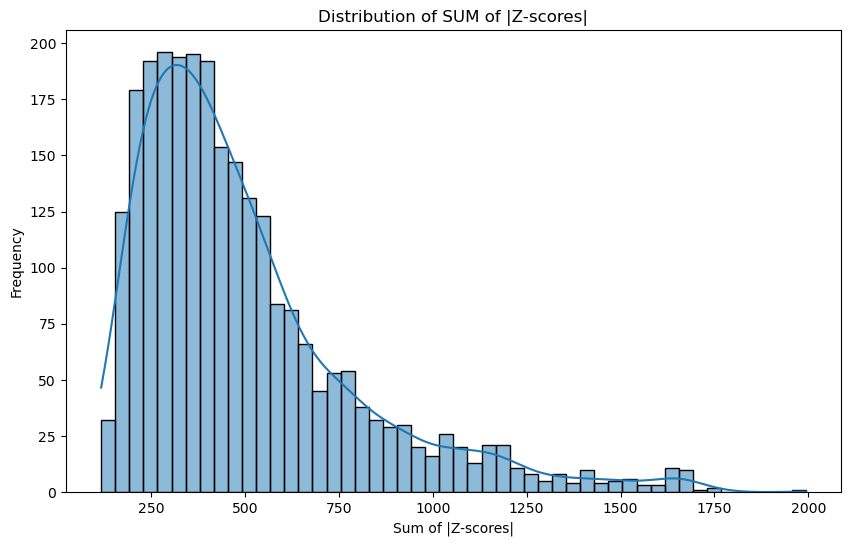

In [94]:
import matplotlib.pyplot as plt
import seaborn as sns

# By calculating the sum of the absolute Z scores (for each sample) in order to measure its overall deviation.
#    And counting how many features inb each sample have Z-scores beyond threshold.
df_normalized['sum_absolute_z'] = df_normalized[feature_columns].abs().sum(axis=1)                       # A single metric of how much a feature deviates from the "dmso" control
df_normalized['count_deviations'] = (df_normalized[feature_columns].abs() > threshold).sum(axis=1)       # how many features deviate significantly in each sample
#print(df_normalized)

# Histogram of the sum of absolute Z-scores
plt.figure(figsize=(10, 6))
sns.histplot(df_normalized['sum_absolute_z'], bins=50, kde=True)    # kde : in order to have a smooth approximation of the distribution
plt.title('Distribution of SUM of |Z-scores|')
plt.xlabel('Sum of |Z-scores|')                       # the overall deviation scores of the samples
plt.ylabel('Frequency')                               # the number of samples that fall into each range of deviation scores
plt.show()


"""
Histogram interpretation : skewed on the right side => most of the samples have relatively lower overall deviation scores
                               but "a long tail" towards hiwher values that indicates a smaller number of samples with significant deviations 
    
"""

In [90]:
# In order to detect which compounds are causing the most significant overall deviation from the "dmso" I ended up 
#    grouping samples by CPD_NAME to identify which compounds consistently cause deviations in the feature.
#    For each group mean deviation score is calculated.
compound_deviation = df_normalized.groupby('CPD_NAME')['sum_absolute_z'].mean().sort_values(ascending=False)
#print(compound_deviation)

In [155]:
deviation_df = compound_deviation.reset_index()
deviation_df.columns = ['CPD_NAME', 'sum_absolute_z']
print(deviation_df)

     CPD_NAME  sum_absolute_z
0   CBK277946     1573.589844
1   CBK309185     1219.284302
2   CBK277953     1175.305664
3   CBK278009     1027.906128
4   CBK290553      920.786865
..        ...             ...
63  CBK293908      356.228699
64  CBK050377      348.877502
65  CBK301268      346.070740
66  CBK303906      338.935181
67  CBK303885      325.790405

[68 rows x 2 columns]


## t-SNE 

/home/jovyan/share/data/analyses/silvija/RT/conda/envs/cloome/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/jovyan/share/data/analyses/silvija/RT/conda/envs/cloome/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


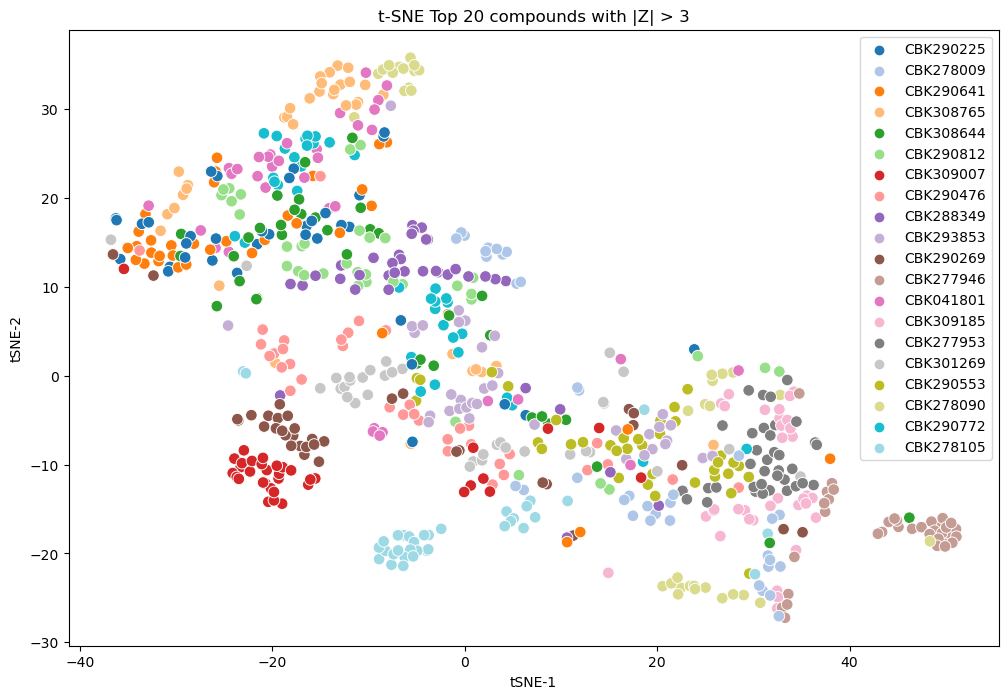

In [96]:
from sklearn.manifold import TSNE


top_20_compounds = df_normalized.groupby('CPD_NAME')['sum_absolute_z'].mean().nlargest(20).index
top_20_data = df_normalized[df_normalized['CPD_NAME'].isin(top_20_compounds)]

features = top_20_data[[col for col in df_normalized.columns if col.startswith('feature_')]]
compounds = top_20_data['CPD_NAME']

tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(features)

tsne_df = pd.DataFrame(tsne_results, columns=['tSNE-1', 'tSNE-2'])
tsne_df['Compound'] = compounds.values

plt.figure(figsize=(12, 8))
sns.scatterplot(data=tsne_df, x='tSNE-1', y='tSNE-2', hue='Compound', palette='tab20', s=70)
plt.title('t-SNE Top 20 compounds with |Z| > 3')
plt.legend(loc='best', bbox_to_anchor=(1, 1), ncol=1)
plt.show()


In [115]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

def plot_tsne(data, title):
    features = data[[col for col in data.columns if col.startswith('feature_')]]
    compounds = data['CPD_NAME']
    
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(features)

    tsne_df = pd.DataFrame(tsne_results, columns=['tSNE-1', 'tSNE-2'])
    tsne_df['Compound'] = compounds.values

    unique_compounds = tsne_df['Compound'].unique()
    palette = {}
    for compound in unique_compounds:
        if compound == '[dmso]':
            palette[compound] = 'black'  # Set "dmso" color to black
        else:
            # Use Seaborn's color palette for other compounds
            palette[compound] = sns.color_palette('tab20', len(unique_compounds))[list(unique_compounds).index(compound)]

    
    plt.figure(figsize=(12, 8))
    sns.scatterplot(data=tsne_df, x='tSNE-1', y='tSNE-2', hue='Compound', palette=palette, s=70)    # 'tab20'
    plt.title(title)
    plt.legend(loc='best', bbox_to_anchor=(1, 1), ncol=1)
    plt.show()

/home/jovyan/share/data/analyses/silvija/RT/conda/envs/cloome/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/jovyan/share/data/analyses/silvija/RT/conda/envs/cloome/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


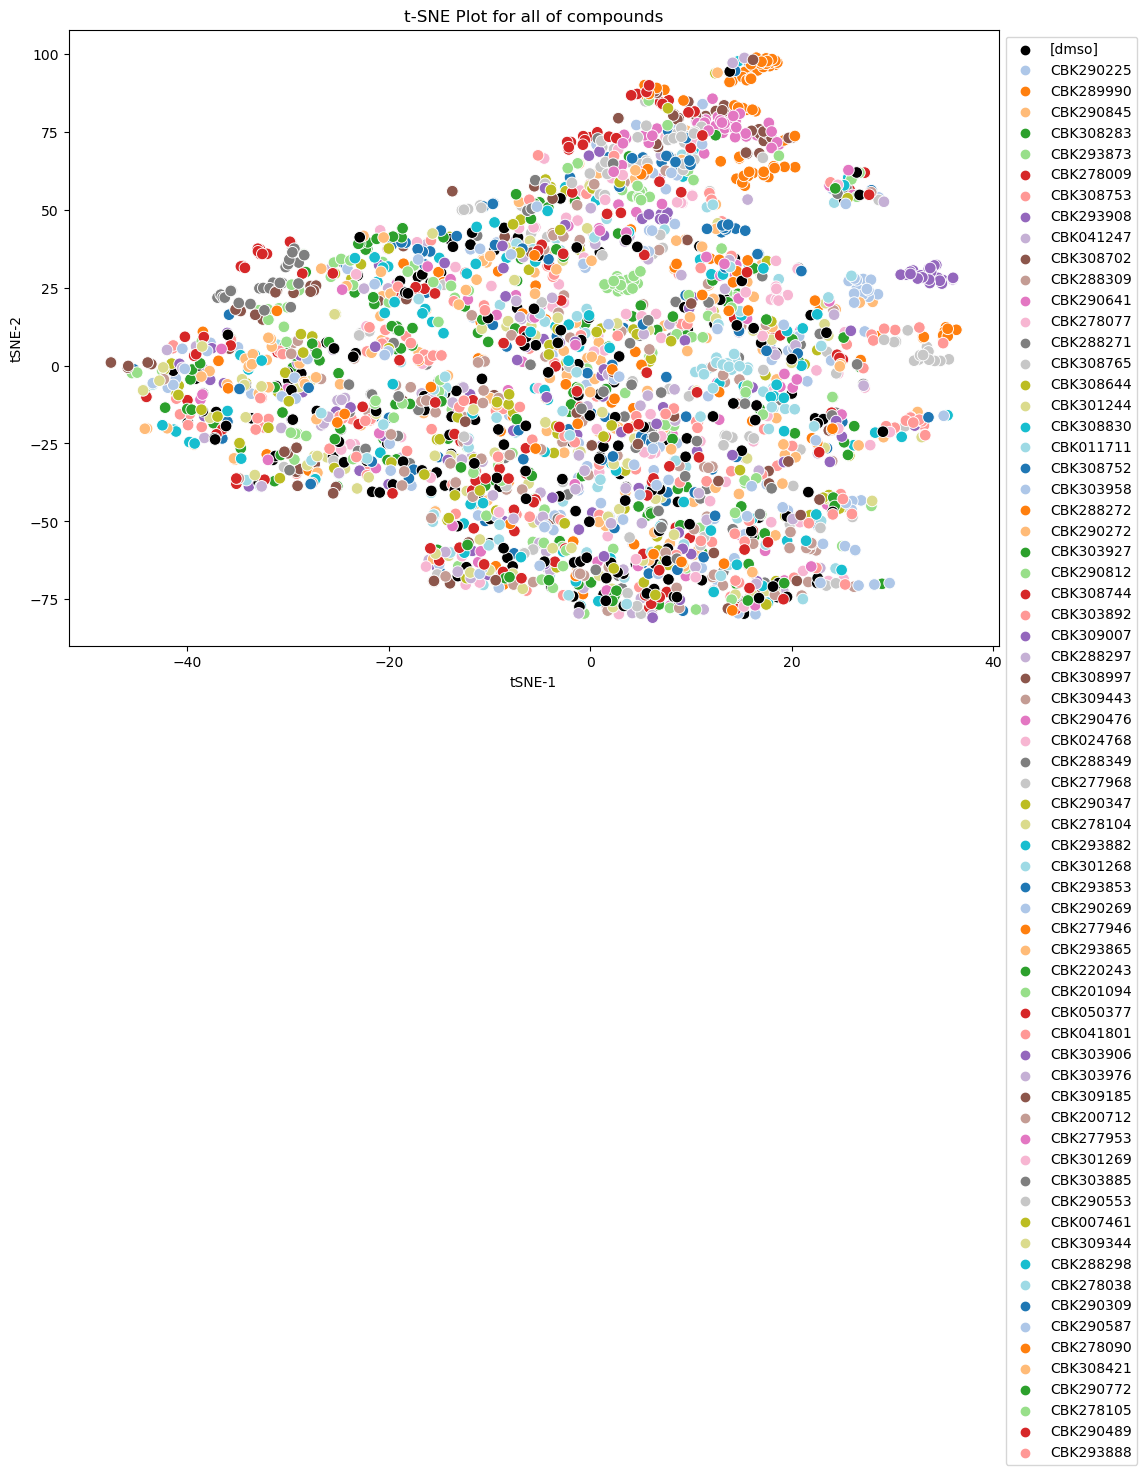

In [116]:
plot_tsne(df_normalized, 't-SNE Plot for all of compounds')

/home/jovyan/share/data/analyses/silvija/RT/conda/envs/cloome/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/jovyan/share/data/analyses/silvija/RT/conda/envs/cloome/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


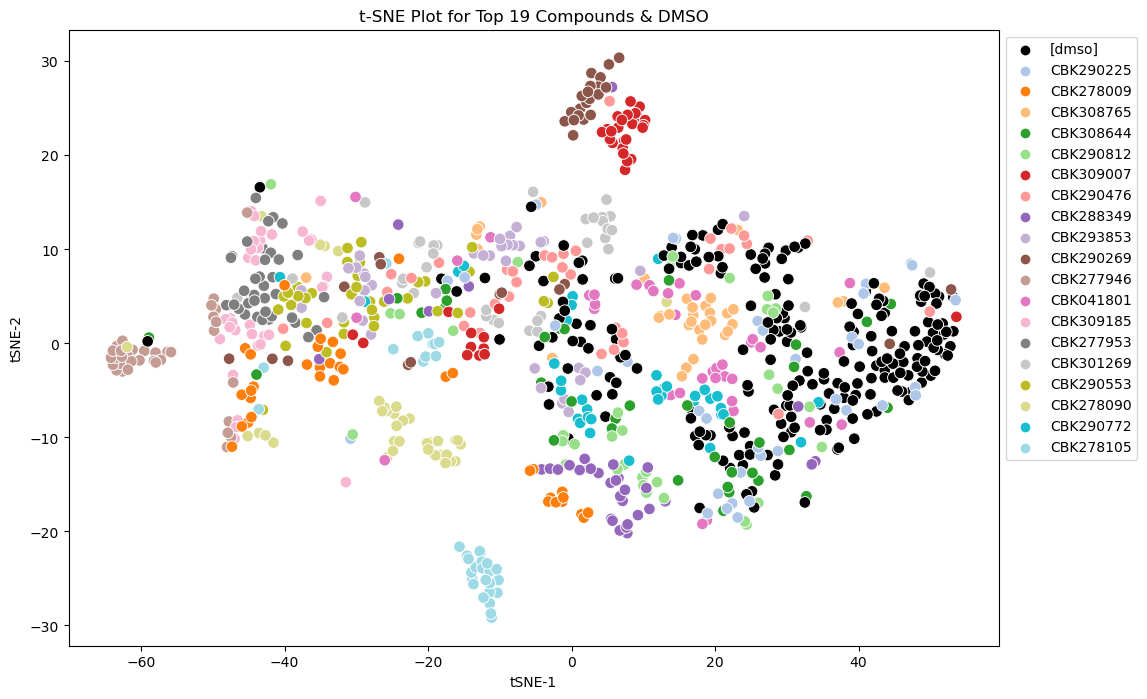

In [117]:
top_20_compounds = df_normalized.groupby('CPD_NAME')['sum_absolute_z'].mean().nlargest(19).index
top_20_dmso_data = df_normalized[df_normalized['CPD_NAME'].isin(top_20_compounds) | (df_normalized['CPD_NAME'] == '[dmso]')]
plot_tsne(top_20_dmso_data, 't-SNE Plot for Top 19 Compounds & DMSO')

/home/jovyan/share/data/analyses/silvija/RT/conda/envs/cloome/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/jovyan/share/data/analyses/silvija/RT/conda/envs/cloome/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


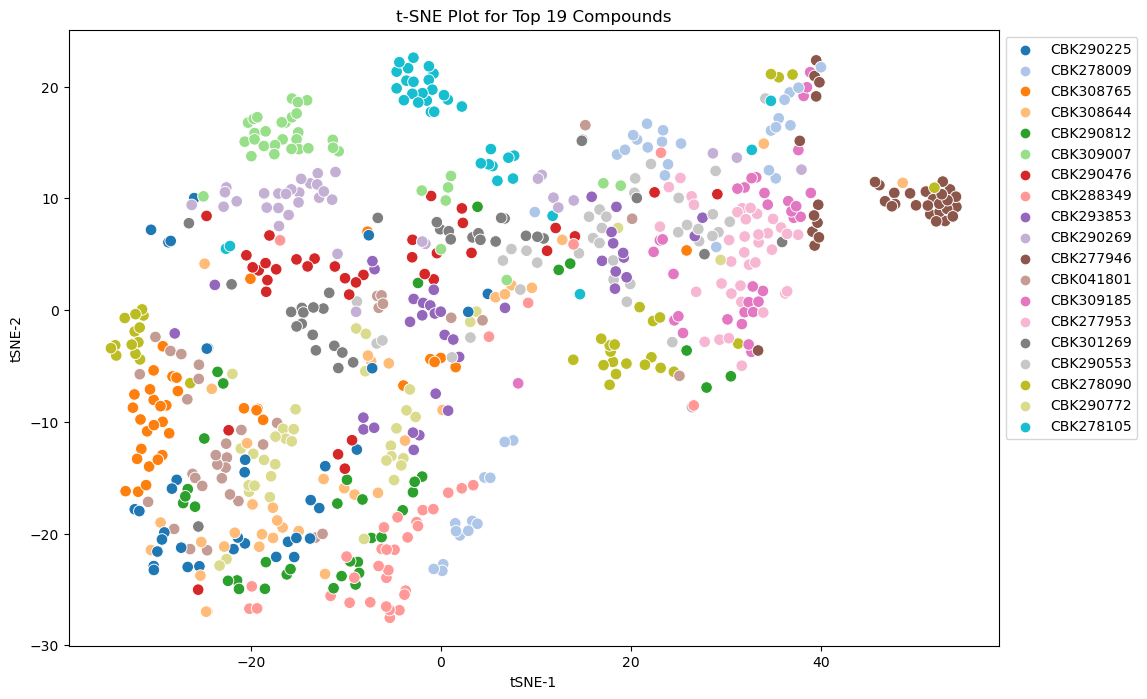

In [118]:
top_20_compounds = df_normalized.groupby('CPD_NAME')['sum_absolute_z'].mean().nlargest(19).index
top_20_dmso_data = df_normalized[df_normalized['CPD_NAME'].isin(top_20_compounds)]
plot_tsne(top_20_dmso_data, 't-SNE Plot for Top 19 Compounds')

# Grit scores

## Calculating grit scores

In [122]:
# Install via pip
!pip install git+git://github.com/cytomining/cytominer-eval@@56bd9e545d4ce5dea8c2d3897024a4eb241d06db

Defaulting to user installation because normal site-packages is not writeable
  Cloning git://github.com/cytomining/cytominer-eval@ (to revision 56bd9e545d4ce5dea8c2d3897024a4eb241d06db) to /tmp/pip-req-build-tgrqesin
  Running command git clone --filter=blob:none --quiet git://github.com/cytomining/cytominer-eval@ /tmp/pip-req-build-tgrqesin
  fatal: unable to connect to github.com:
  github.com[0: 140.82.121.4]: errno=Connection timed out

  error: subprocess-exited-with-error
  
  × git clone --filter=blob:none --quiet git://github.com/cytomining/cytominer-eval@ /tmp/pip-req-build-tgrqesin did not run successfully.
  │ exit code: 128
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: subprocess-exited-with-error

× git clone --filter=blob:none --quiet git://github.com/cytomining/cytominer-eval@ /tmp/pip-req-build-tgrqesin did not run successfully.
│ exit code: 128
╰─> See above for output.

note: This error or

In [135]:
from cytominer_eval import evaluate

def compute_grit(df,feature_columns):
        #df = df.to_pandas()
        #meta = meta.to_pandas()
        df['comp_replicate'] =  df['WELL_POSITION']  + '_' + df['SITE'].astype(str)

        #one_plate = meta.Metadata_Plate.unique()
        grit_scores = evaluate(
            profiles=df,  
            features=feature_columns,
            #meta_features=list(dfZscores.columns[-7:]),# adjust after above
            meta_features=['CPD_NAME','WELL_POSITION','SITE','comp_replicate'],
            replicate_groups={"profile_col": "comp_replicate", "replicate_group_col": "CPD_NAME" },     
                                   # profile_col : id unique replicates, replicate_group_col : indicate grouping
            operation="grit",
            similarity_metric="pearson",
            grit_replicate_summary_method="mean", # median
            grit_control_perts=df.query("CPD_NAME == '[dmso]'").comp_replicate.unique().tolist()
        ).assign(one_plate='P102785')
        return grit_scores
#grit = compute_grit(aggregated_df,feat_col)

In [211]:
#from grit_benchmark import compute_grit

feature_columns = [col for col in df_normalized.columns if col.startswith('feature_')]
metadata_columns = ['CPD_NAME']  

grit_data = df_normalized[metadata_columns + feature_columns]

grit_results = compute_grit(df_normalized, feature_columns=feature_columns)

print(grit_results)

grit_results.to_csv('/share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/graphs/grit_scores_results.csv', index=False)

     perturbation      group          grit one_plate
0           A02_1     [dmso]  2.065531e-17   P102785
1           A02_2     [dmso]  2.891744e-17   P102785
2           A02_3     [dmso]  1.239319e-17   P102785
3           A02_4     [dmso] -6.403147e-17   P102785
4           A02_5     [dmso] -5.370381e-17   P102785
...           ...        ...           ...       ...
2596        P23_5  CBK290225  2.284583e-01   P102785
2597        P23_6  CBK290225 -1.292136e-01   P102785
2598        P23_7  CBK290225  1.059732e-01   P102785
2599        P23_8  CBK290225 -5.092511e-02   P102785
2600        P23_9  CBK290225 -8.711621e-02   P102785

[2601 rows x 4 columns]


In [212]:
grit_grouped = grit_results.groupby('group')['grit'].mean().reset_index()
print(grit_grouped)

        group          grit
0   CBK007461  2.426530e-02
1   CBK011711  3.071206e-02
2   CBK024768  8.507701e-03
3   CBK041247  1.775996e-02
4   CBK041801  8.127879e-01
..        ...           ...
63  CBK309007  1.829731e+00
64  CBK309185  1.733666e+00
65  CBK309344 -5.637734e-03
66  CBK309443  2.113063e-02
67     [dmso]  2.089438e-18

[68 rows x 2 columns]


## Distribution of Grit scores

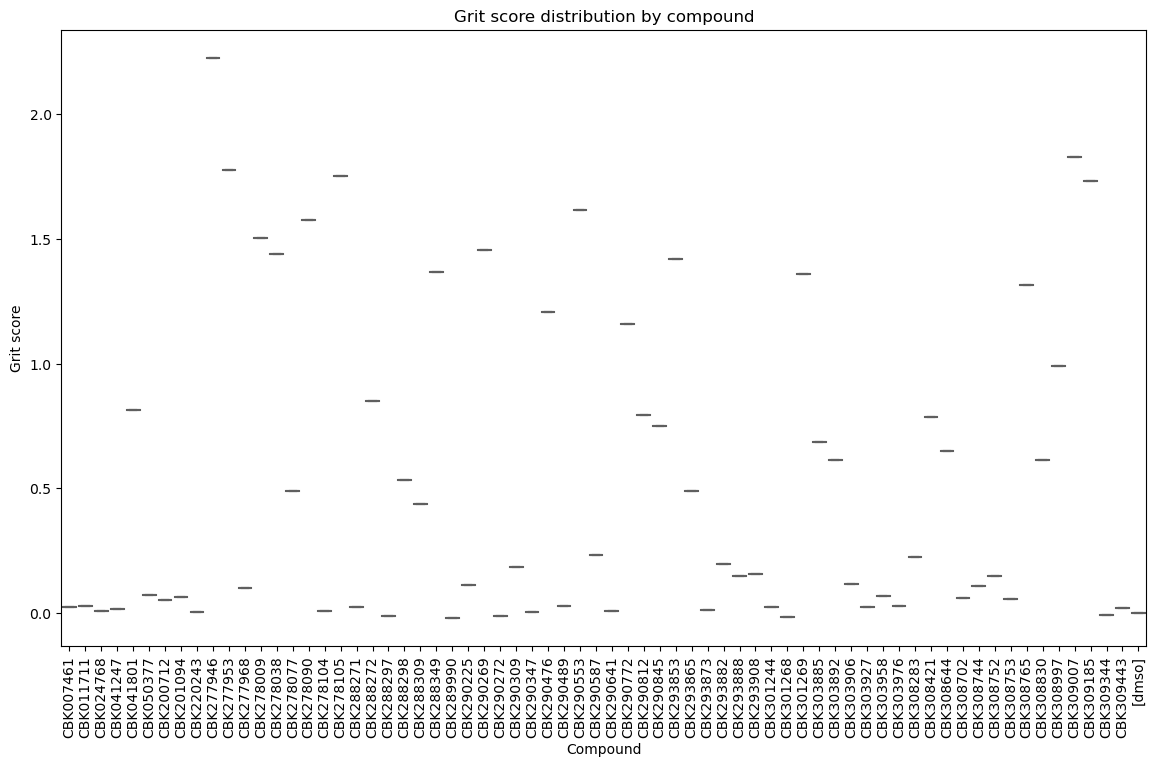

In [213]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming `grit_results` is a DataFrame with columns 'compound' and 'grit_score'
plt.figure(figsize=(14, 8))
sns.boxplot(data=grit_grouped, x='group', y='grit', palette='Set3')
plt.xticks(rotation=90)
plt.title('Grit score distribution by compound')
plt.xlabel('Compound')
plt.ylabel('Grit score')
plt.show()


## tSNE visualization of grit scores

/home/jovyan/share/data/analyses/silvija/RT/conda/envs/cloome/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/jovyan/share/data/analyses/silvija/RT/conda/envs/cloome/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


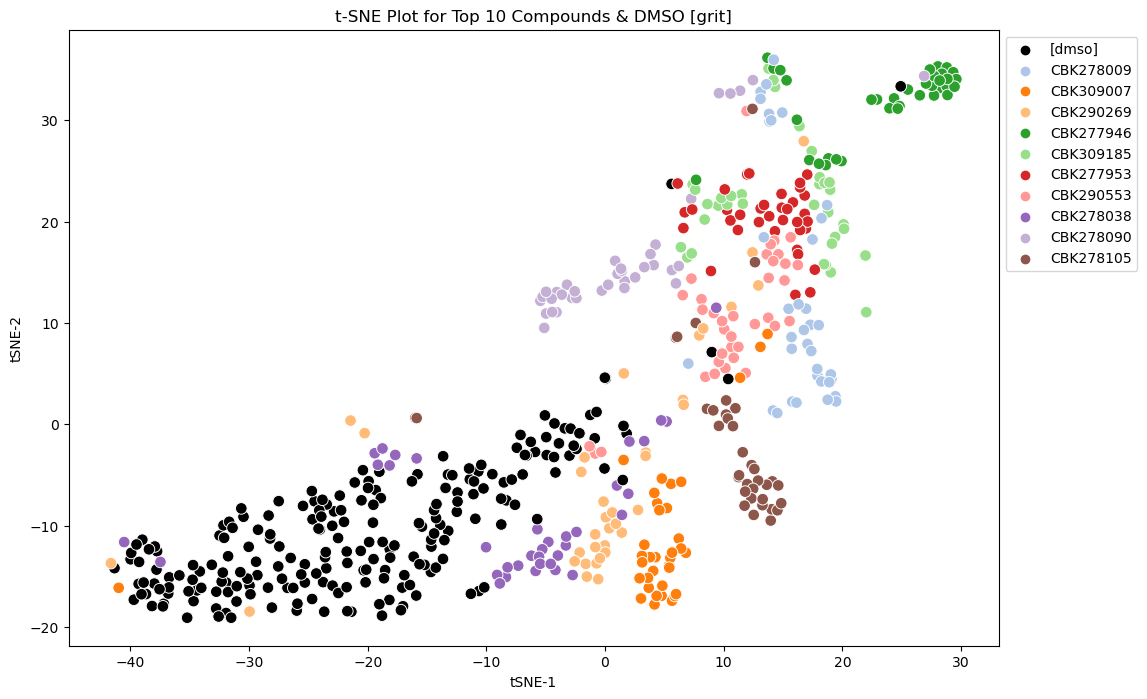

In [215]:
top_10_grit = grit_grouped.sort_values(by='grit', ascending=False)['group'].head(10)
top_10_dmso_grit = df_normalized[df_normalized['CPD_NAME'].isin(top_10_grit) | (df_normalized['CPD_NAME'] == '[dmso]')]
plot_tsne(top_10_dmso_grit, 't-SNE Plot for Top 10 Compounds & DMSO [grit]')

## PCA on grit score data

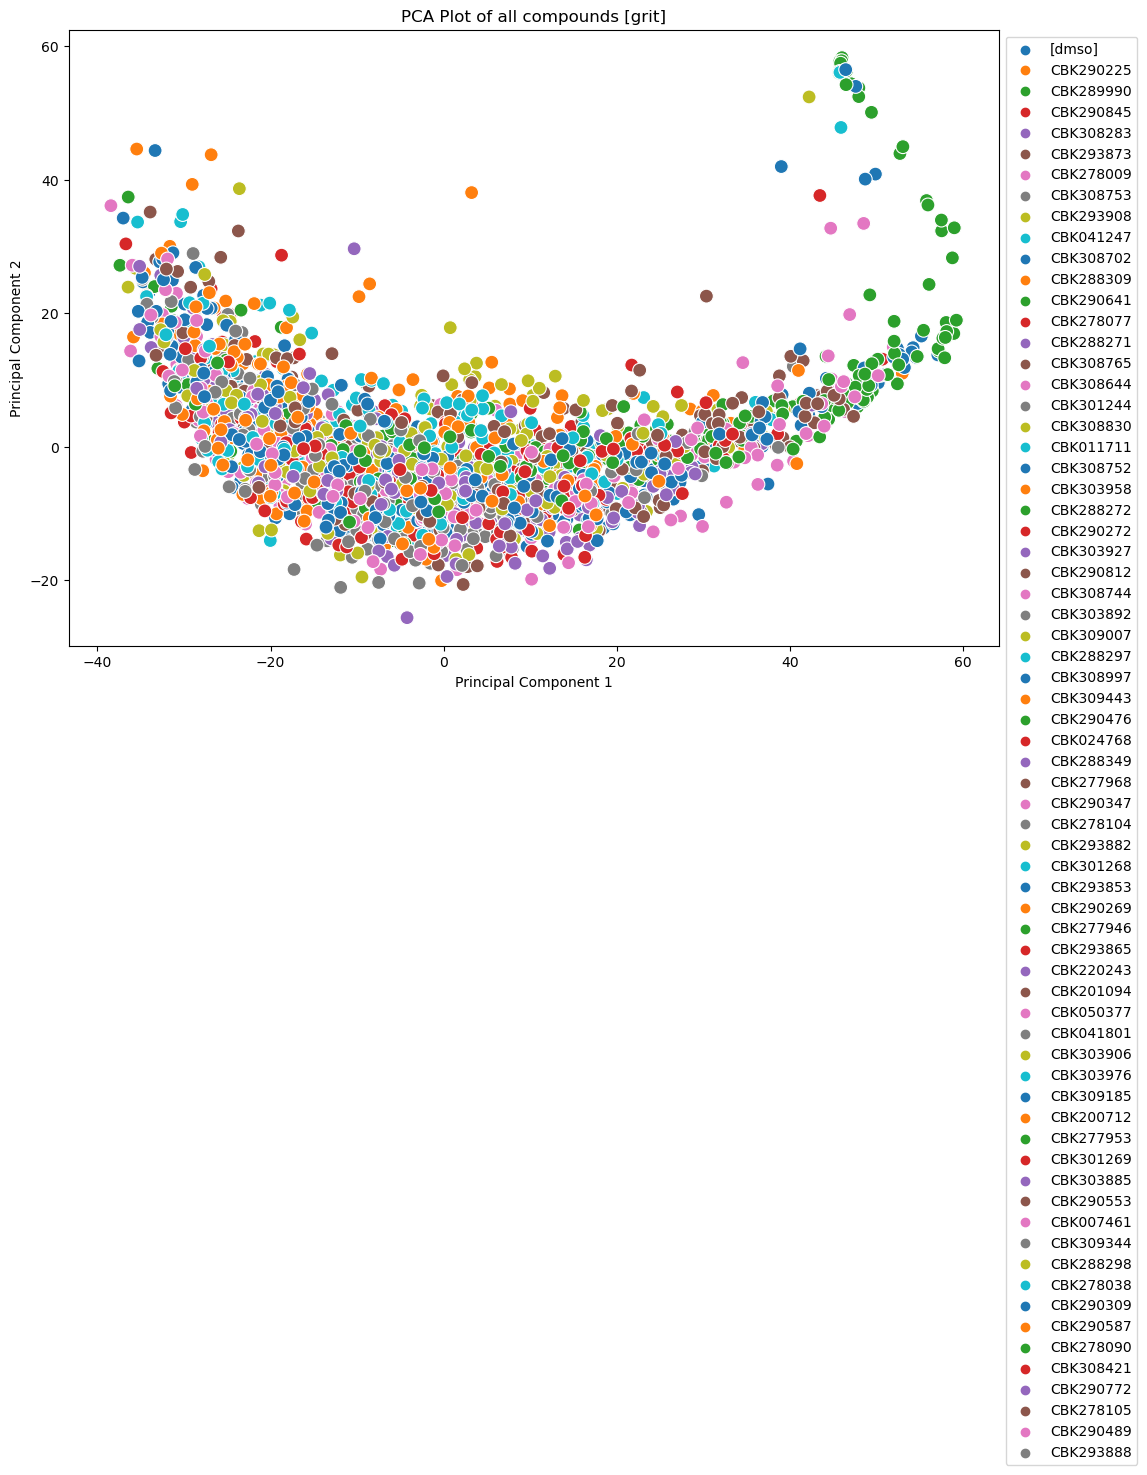

In [217]:
from sklearn.decomposition import PCA

feature_columns = [col for col in df_normalized.columns if col.startswith('feature_')]
features = df_normalized[feature_columns]

pca = PCA(n_components=2)
pca_results = pca.fit_transform(features)

df_normalized['PCA-1'] = pca_results[:, 0]
df_normalized['PCA-2'] = pca_results[:, 1]

plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_normalized, x='PCA-1', y='PCA-2', hue='CPD_NAME', palette='tab10', s=100)
plt.title('PCA Plot of all compounds [grit]')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(loc='best', bbox_to_anchor=(1, 1), ncol=1)
plt.show()


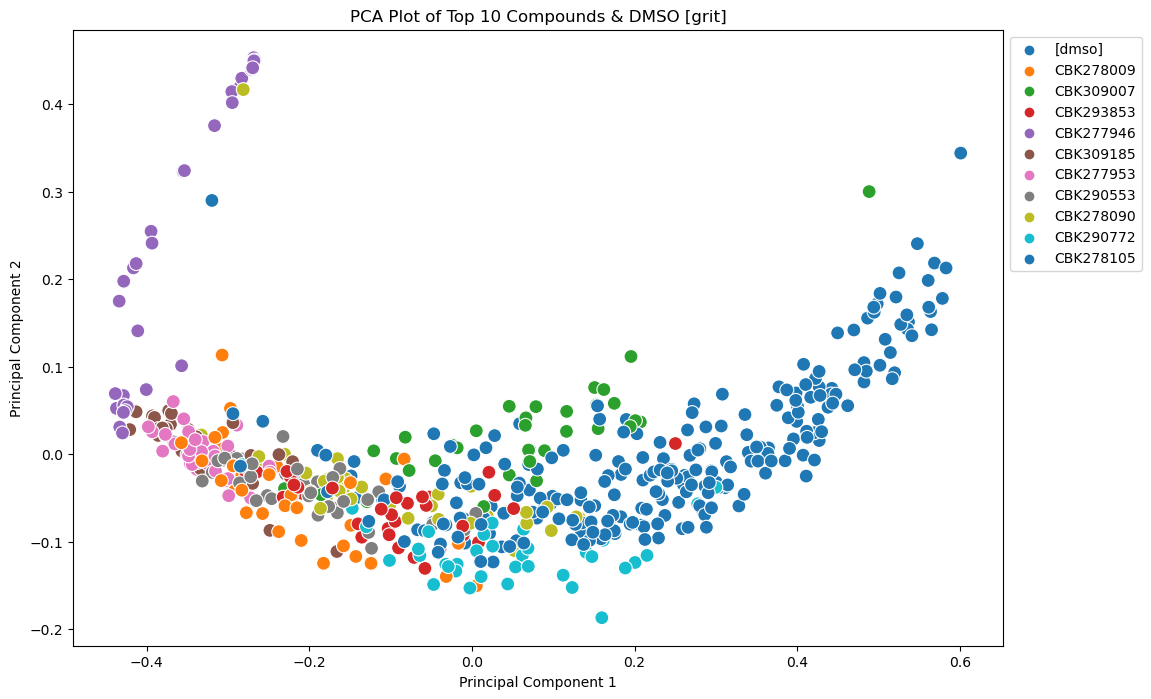

In [199]:
top_10_compounds_with_dmso = top_10_grit.append(pd.Series('[dmso]')).unique()

filtered_data = val_feat_sorted[val_feat_sorted['CPD_NAME'].isin(top_10_compounds_with_dmso)].copy()

feature_columns = [col for col in filtered_data.columns if col.startswith('feature_')]
features = filtered_data[feature_columns]

pca = PCA(n_components=2)
pca_results = pca.fit_transform(features)

filtered_data.loc[:, 'PCA-1'] = pca_results[:, 0]
filtered_data.loc[:, 'PCA-2'] = pca_results[:, 1]

plt.figure(figsize=(12, 8))
sns.scatterplot(data=filtered_data, x='PCA-1', y='PCA-2', hue='CPD_NAME', palette='tab10', s=100)
plt.title('PCA Plot of Top 10 Compounds & DMSO [grit]')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(loc='best', bbox_to_anchor=(1, 1), ncol=1)
plt.show()

## PCA and tSNE on grit score > 1

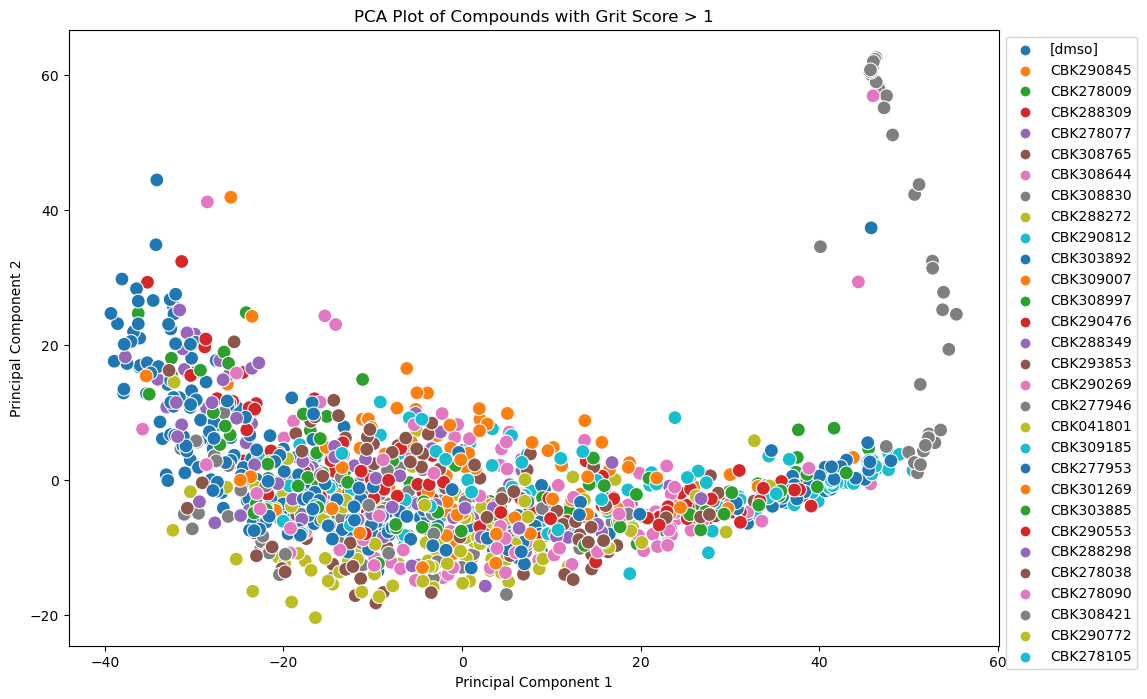

In [218]:
compounds_high_grit = grit_results[grit_results['grit'] > 1]['group']
filtered_data_high_grit = df_normalized[df_normalized['CPD_NAME'].isin(compounds_high_grit) | (df_normalized['CPD_NAME'] == '[dmso]')].copy()
#print(filtered_data_high_grit)

feature_columns = [col for col in filtered_data_high_grit.columns if col.startswith('feature_')]
features_high_grit = filtered_data_high_grit[feature_columns]

pca = PCA(n_components=2)
pca_results_high_grit = pca.fit_transform(features_high_grit)

filtered_data_high_grit.loc[:, 'PCA-1'] = pca_results_high_grit[:, 0]
filtered_data_high_grit.loc[:, 'PCA-2'] = pca_results_high_grit[:, 1]

plt.figure(figsize=(12, 8))
sns.scatterplot(data=filtered_data_high_grit, x='PCA-1', y='PCA-2', hue='CPD_NAME', palette='tab10', s=100)
plt.title('PCA Plot of Compounds with Grit Score > 1')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(loc='best', bbox_to_anchor=(1, 1), ncol=1)
plt.show()

/home/jovyan/share/data/analyses/silvija/RT/conda/envs/cloome/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/jovyan/share/data/analyses/silvija/RT/conda/envs/cloome/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


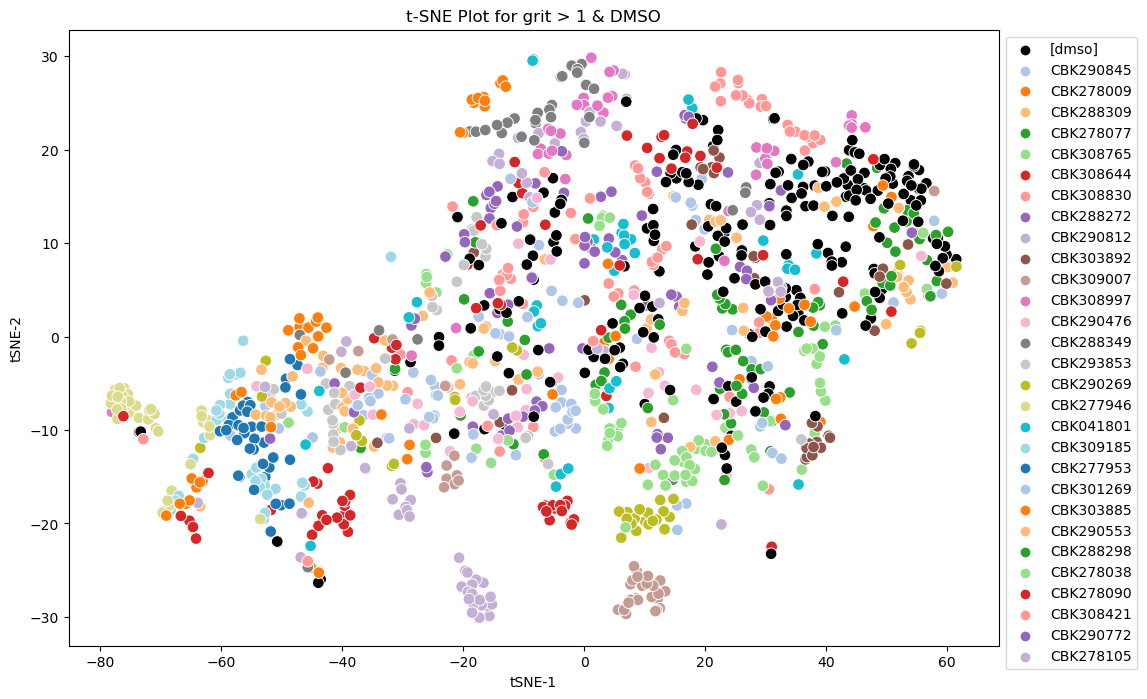

In [219]:
plot_tsne(filtered_data_high_grit, 't-SNE Plot for grit > 1 & DMSO')

## Visualization of grit scores and sum of absolute values for z-score, per compound

In [162]:
#print(deviation_df)
#print(grit_grouped)

scores_df = pd.merge(deviation_df, grit_grouped, left_on='CPD_NAME', right_on='group')
scores_df = scores_df.drop(columns=['group'])

print(scores_df)

     CPD_NAME  sum_absolute_z      grit
0   CBK277946     1573.589844  2.353771
1   CBK309185     1219.284302  1.795516
2   CBK277953     1175.305664  1.847039
3   CBK278009     1027.906128  1.326214
4   CBK290553      920.786865  1.416853
..        ...             ...       ...
63  CBK293908      356.228699  0.215226
64  CBK050377      348.877502  0.143365
65  CBK301268      346.070740  0.182047
66  CBK303906      338.935181  0.251544
67  CBK303885      325.790405  0.373700

[68 rows x 3 columns]


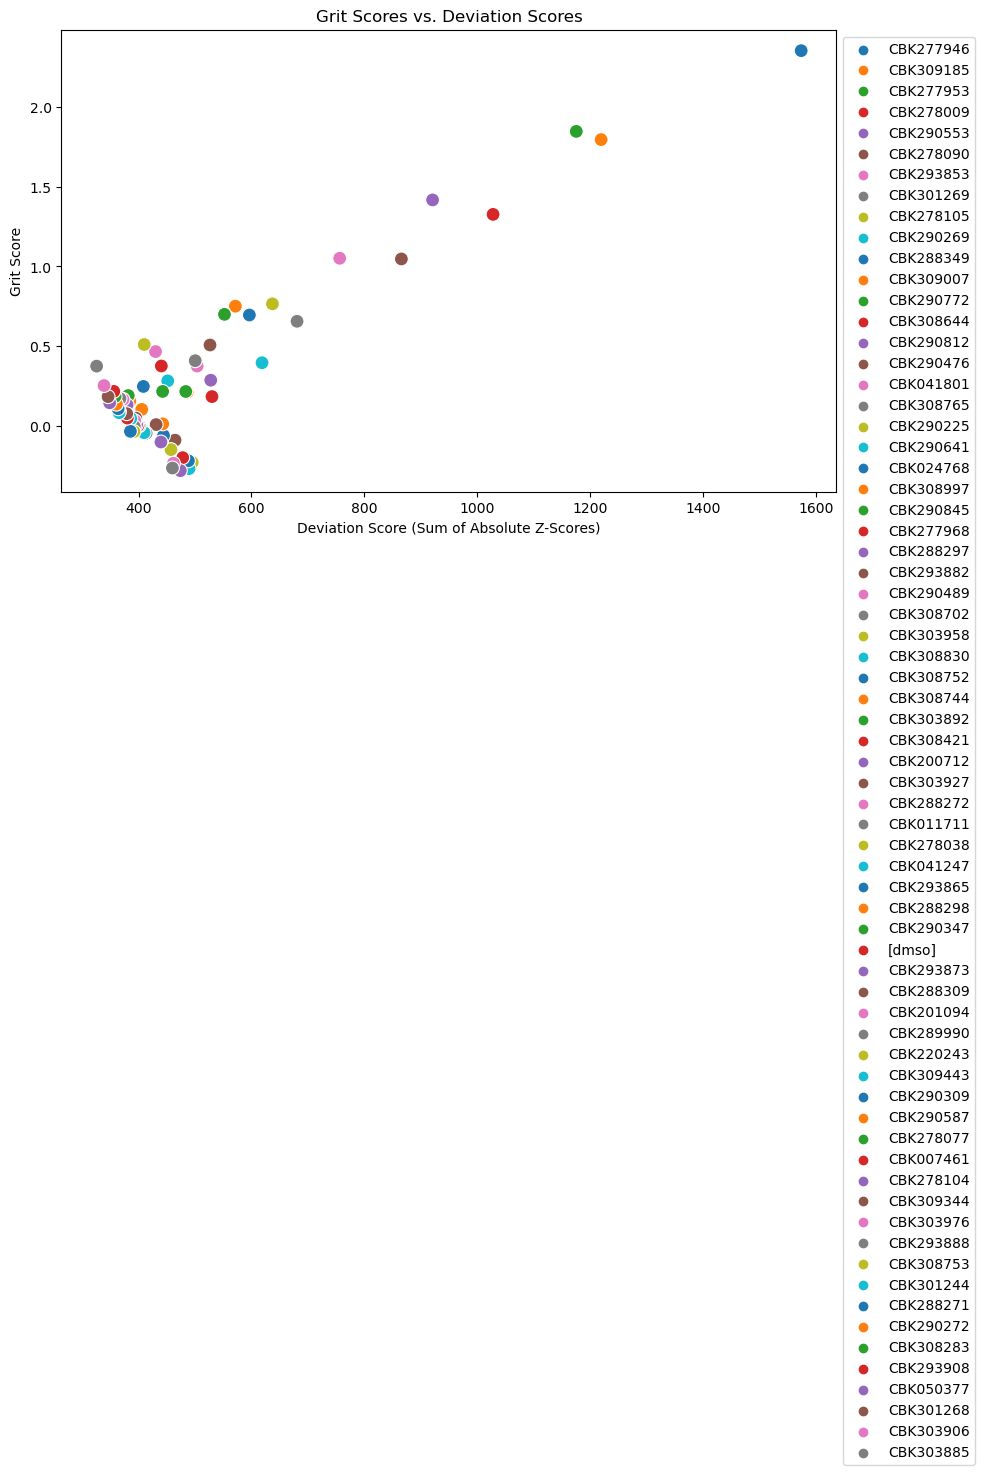

In [163]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=scores_df, x='sum_absolute_z', y='grit', hue='CPD_NAME', palette='tab10', s=100)
plt.title('Deviation score vs. grit score')
plt.xlabel('Sum of absolute Z-scores)')
plt.ylabel('Grit score')
plt.legend(loc='best', bbox_to_anchor=(1, 1), ncol=1)
plt.show()


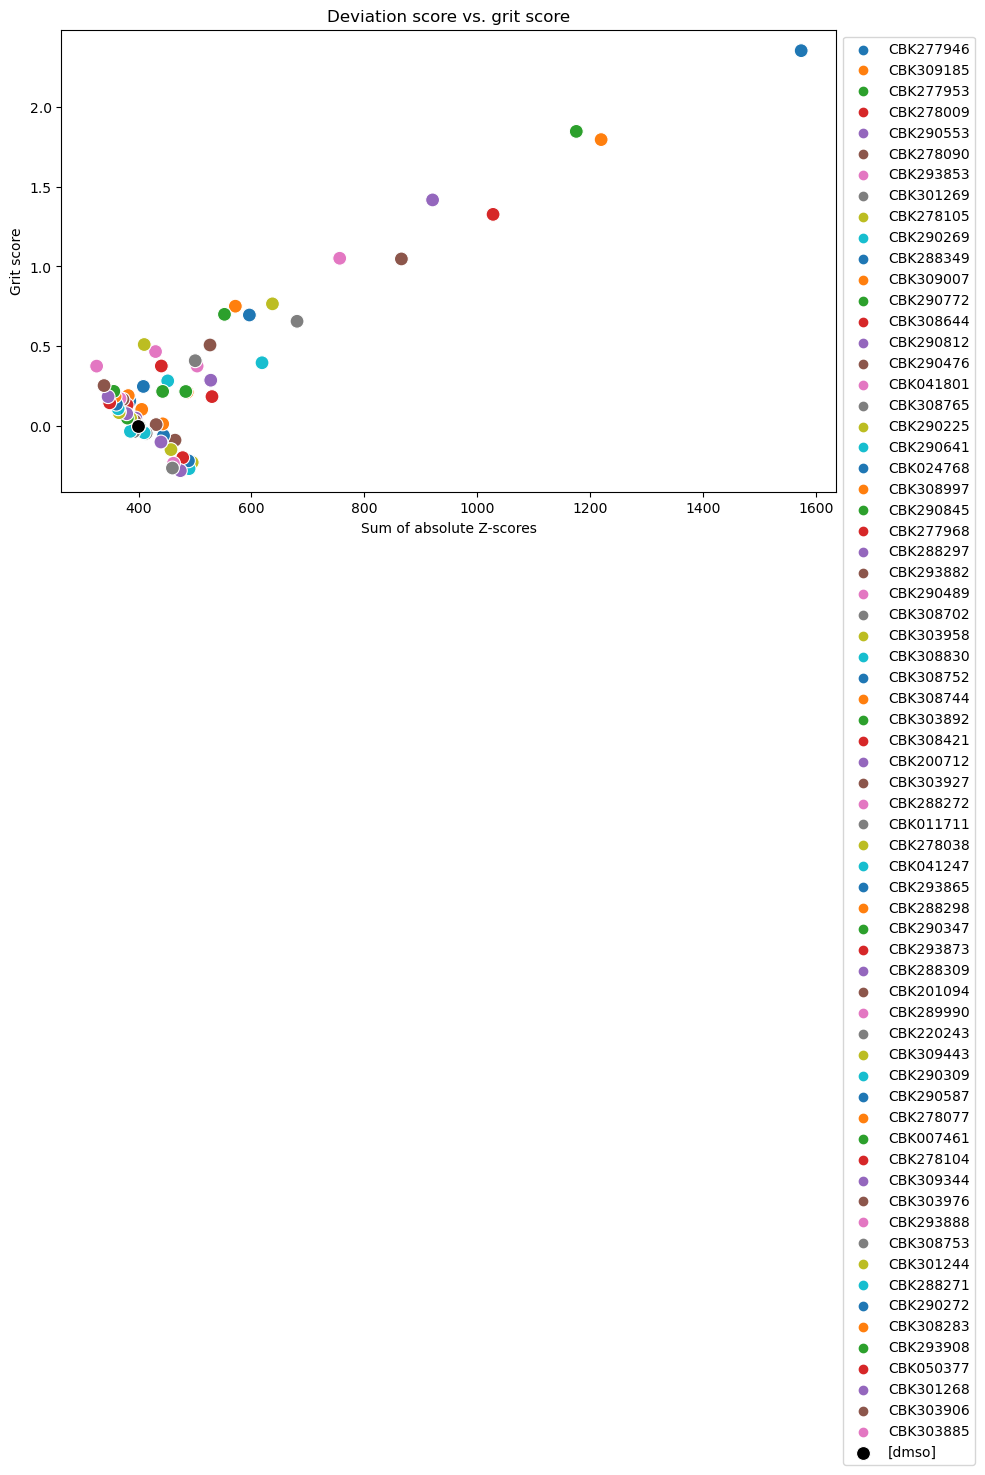

In [166]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=scores_df[scores_df['CPD_NAME'] != '[dmso]'], 
                x='sum_absolute_z', 
                y='grit', 
                hue='CPD_NAME', 
                palette='tab10', 
                s=100)

sns.scatterplot(data=scores_df[scores_df['CPD_NAME'] == '[dmso]'], 
                x='sum_absolute_z', 
                y='grit', 
                color='black', 
                label='[dmso]', 
                s=100)

plt.title('Deviation score vs. grit score')
plt.xlabel('Sum of absolute Z-scores')
plt.ylabel('Grit score')
plt.legend(loc='best', bbox_to_anchor=(1, 1), ncol=1)
plt.show()

# Visualization based on notebook 5

In [ ]:
from sklearn.manifold import TSNE
features_embedded = TSNE(n_components=2, learning_rate='auto',
                     init='random', metric="cosine", random_state=1, n_jobs=1).fit_transform(val_img_features)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.pyplot import figure
%matplotlib inline

In [ ]:
import random

def generate_color():
    for i in range(3):
        r = random.randint(0,255)
        g = random.randint(0,255)
        b = random.randint(0,255)
        rgb = np.array([r,g,b])/255
        return rgb
    
def gen_color_list(n):
    lst = []
    for i in range(n):
        rgb = generate_color()
        lst.append(rgb)
    return lst

#print(len(set(subset_val["INCHIKEY"])))
subset_val = val_df

In [ ]:
def ordered_color_list(df, colors, group_dict):
    n_molecules = len(group_dict)

  #  scaled_colors = np.array(colors)/255

    #groups = df.groupby(group).groups

    ordered_colors = np.zeros((len(df), 3))

    print(f"len of group dictionary = {len(group_dict)}")
    

    for i, (group, indices) in enumerate(group_dict.items()): 
        ordered_colors[indices] = list(colors[i][:3])
        
    #ordered_colors = ordered_colors/255
    return ordered_colors

In [ ]:
def plot(features, colors, method):
    
    figure(figsize=(10, 8), dpi=100)

    plt.scatter(features[:, 0], features[:, 1], c=colors)
    
    method_list = [word for word in method.split()]
    method_string = "_".join(method_list)
    method, color_scheme = method_list
    
    plt.title(f"{method} embeddings (coloured by {color_scheme})")
    
    plt.tick_params(
    axis="both",       # changes apply to both axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False,
    labelbottom=False,
    labeltop=False,
    labelleft=False)
    
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")

        
    plt.show()

def morgan_from_smiles(smiles, radius=3, nbits=1024, chiral=True):
    mol = Chem.MolFromSmiles(smiles)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=3, nBits=nbits, useChirality=chiral)
    arr = np.zeros((0,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp,arr)
    return arr

def cellpainting_to_rgb(arr):
    arr0 = arr[:, :, 0].astype(np.float32)
    arr3 = arr[:, :, 3].astype(np.float32)
    arr4 = arr[:, :, 4].astype(np.float32)

    rgb_arr = np.dstack((arr0, arr3, arr4))
    
    return rgb_arr.astype(int)

def merge_imgs(mol_img_array, cell_img_array):
    new_im = np.full([mol_img_array.shape[0] + cell_img_array.shape[0], cell_img_array.shape[1], 3], 255, dtype=int)


    new_im[:cell_img_array.shape[0], :cell_img_array.shape[1]] = cell_img_array
    new_im[cell_img_array.shape[0]:, 198:-198] = mol_img_array

    return new_im

In [ ]:
# first create a dict with an id (plate or molecule) and theis corresponding sample ids
# then make second dict with id (plate or molecule) and indexes in the array of embeddings
def find_order_by_group(ids_array, df, group):

    dict_ = {}
    val_ids = np.array(ids_array)

    for inchi in df.groupby(group).groups:
       # sample_keys = list(df[df[group] == inchi]["SAMPLE_KEY"])
        inchi_df = df[df["INCHIKEY"] == inchi]
        inchi_df = inchi_df.copy()
        inchi_df.loc[:,'SAMPLE_KEY'] = (inchi_df['PLATE_ID'].astype(str) + '-' + 
                                inchi_df['WELL_POSITION'].astype(str) + '-' + 
                                inchi_df['SITE'].astype(str))
        sample_keys = list(inchi_df["SAMPLE_KEY"])
        dict_[inchi] = sample_keys

    dict_index = {}

    for inchi, ids in dict_.items():
        for i in ids:
            if i in val_ids:
                index = np.where(val_ids == i)[0][0]
                dict_index.setdefault(inchi, []).append(index)
                
    return dict_index


In [ ]:
color_list = cm.tab20.colors
np_inchi_id = find_order_by_group(val_ids, subset_val, "INCHIKEY")
np_inchi_id_subset = dict(list(np_inchi_id.items())[20:40])

ordered_colors_mol = ordered_color_list(subset_val, color_list, np_inchi_id_subset)
plot(features_embedded, ordered_colors_mol, "CLOOME molecule")

In [ ]:
#color_list = cm.tab20.colors
#color_list = cm.get_cmap('tab20', 67)
color_map = cm.get_cmap('gist_rainbow', 67)
color_list = [color_map(i) for i in range(67)] 
np_inchi_id = find_order_by_group(val_ids, subset_val, "INCHIKEY")
ordered_colors_mol = ordered_color_list(subset_val, color_list, np_inchi_id)
plot(features_embedded, ordered_colors_mol, "CLOOME molecule")

# Some of my functions

In [ ]:
pd.read_csv(val)

In [ ]:
vall = '/share/data/analyses/silvija/RT/data_cloome/our_images/cellpainting-all-imgpermol-template.csv'

pd.read_csv(vall).dtypes

In [ ]:
pd.read_csv(val).dtypes

In [ ]:
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs

# Step 1: Define the SMILES string
smiles = "Cc1cc(I)ccc1Nc1c(C(=O)NOCC2CC2)cc(F)c(F)c1F"

# Step 2: Convert the SMILES string to an RDKit molecule object
mol = Chem.MolFromSmiles(smiles)

# Step 3: Generate the 1024-bit Morgan fingerprint with a radius of 3, including chirality
fingerprint = AllChem.GetMorganFingerprintAsBitVect(mol, radius=3, nBits=1024, useChirality=True)

# Step 4: Convert the fingerprint to a numpy array
arr = np.zeros((1024,), dtype=np.int8)
DataStructs.ConvertToNumpyArray(fingerprint, arr)

# Step 5: Create a pandas DataFrame
df = pd.DataFrame([arr], columns=[f'bit_{i}' for i in range(1024)])
#df['SMILES'] = smiles  # Optionally include the SMILES string in the DataFrame
df['SAMPLE_KEY'] = 'P102785-A03-1'  # Optionally include the SMILES string in the DataFrame
df['SAMPLE_KEY'] = df['SAMPLE_KEY'].astype(str)
# Step 6: Save the DataFrame to an HDF5 file
hdf5_filename = '/share/data/analyses/silvija/RT/data_cloome/our_images/morgan_fingerprint_v2.h5'
df.to_hdf(hdf5_filename, key='df', mode='w')
display(df.dtypes)#.astype())

display(df)

print(f"1024-bit Morgan fingerprint saved to {hdf5_filename}")


In [ ]:
# Loading the HDF5 file
hdf5_filename = '/share/data/analyses/silvija/RT/data_cloome/our_images/morgan_chiral_fps.hdf5'
#hdf5_filename = '/share/data/analyses/silvija/RT/data_cloome/our_images/morgan_fingerprint_v2.h5'

df_loaded = pd.read_hdf(hdf5_filename, key='df')

# Display the loaded DataFrame
print(df_loaded.head())


In [ ]:
# ME : converts png to npz

import os
import numpy as np
from PIL import Image

def convert_png_to_npz(input_dir, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for file_name in os.listdir(input_dir):
        if file_name.endswith('.png'): 
            png_path = os.path.join(input_dir, file_name)
            npz_path = os.path.join(output_dir, os.path.splitext(file_name)[0] + '.npz')
            
            image = Image.open(png_path)
            image_array = np.array(image)
            np.savez(npz_path, sample=image_array)
            
            print(f"Converted {file_name} to {npz_path}")

# Example usage
input_directory = '/share/data/analyses/silvija/RT/data_cloome/our_images/channels'  # Replace with the path to DirA
output_directory = '/share/data/analyses/silvija/RT/data_cloome/our_images/channels_npz'  # Replace with the path to DirB

convert_png_to_npz(input_directory, output_directory)


In [ ]:
#ME : to check if it works
import numpy as np
import matplotlib.pyplot as plt

npz_file_path = '/share/data/analyses/silvija/RT/data_cloome/our_images/channels_npz/img_P102785_acqid_4359_A03_site_1_merged_channel_4.npz'
npz_data = np.load(npz_file_path)

image_array = npz_data['sample']        # Extracting image array

plt.imshow(image_array)
plt.axis('off')                              # Hide the axes for a cleaner look
plt.show()


In [ ]:
import pandas as pd

# Load the CSV file
csv_file_path = '/share/data/analyses/silvija/RT/data_cloome/our_images/metadata_try_v2.csv' 
df = pd.read_csv(csv_file_path)

df_modified = df.iloc[:, 2:]
new_csv_file_path = '/share/data/analyses/silvija/RT/data_cloome/our_images/metadata_try_v3.csv'
df_modified.to_csv(new_csv_file_path, index=False)

print(f"New CSV file saved at {new_csv_file_path}")


In [ ]:
import os
import numpy as np
from PIL import Image

def convert_png_to_npz(input_dir, output_dir, channels):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Loop over all samples (assuming one file per channel)
    sample_names = set([file_name.split('_')[0] for file_name in os.listdir(input_dir) if file_name.endswith('.png')])

    for sample_name in sample_names:
        channel_images = []
        
        for channel in range(1, channels + 1):                         # Loop over all channel files for the sample
            channel_file = f"{sample_name}_channel{channel}.png"
            png_path = os.path.join(input_dir, channel_file)
            
            if os.path.exists(png_path):
                image = Image.open(png_path)
                image_array = np.array(image)
                channel_images.append(image_array)
            else:
                print(f"WARNING: Channel file {channel_file} not found for sample {sample_name}")
                continue
        
        # Stack all channel images along the third dimension
        if channel_images:
            multi_channel_image = np.stack(channel_images, axis=-1)
            
            # Save the multi-channel image as an .npz file
            npz_path = os.path.join(output_dir, f"{sample_name}.npz")
            np.savez(npz_path, sample=multi_channel_image)
            
            print(f"Converted {sample_name} to {npz_path} with {len(channel_images)} channels")
        else:
            print(f"WARNING: No channels found for sample {sample_name}")

input_directory = '/share/data/analyses/silvija/RT/data_cloome/our_images/channels' 
output_directory = '/share/data/analyses/silvija/RT/data_cloome/our_images/single_npz' 
channels = 5

convert_png_to_npz(input_directory, output_directory, channels)


# zeroshot_phenotype.ipynb : part 2

In [ ]:
val_img_features, val_text_features, val_ids = main(val, checkpoint_path, model, img_path, mol_path, image_resolution)
class_img_features, class_text_features, class_ids = main(classes, checkpoint_path, model, img_path, mol_path, image_resolution)
val_img_features = val_img_features.cpu()
class_img_features = class_img_features.cpu()

In [ ]:
val_img_features.shape

In [ ]:
classes_df = pd.read_csv(classes)
classes_df.set_index("SAMPLE_KEY", inplace=True)
class_inchis = classes_df.loc[class_ids]["INCHIKEY"]

In [ ]:
val_df = pd.read_csv(val)
val_df.set_index("SAMPLE_KEY", inplace=True)

In [ ]:
val_df

In [ ]:
val_inchis = val_df.loc[val_ids]["INCHIKEY"]

In [ ]:
class_dict = {}

for i, inchi in enumerate(class_inchis): 
    class_dict[inchi] = i

In [ ]:
ground_truth = np.zeros(len(val_inchis), dtype=int)

for i, inchi in enumerate(val_inchis): 
    label = class_dict[inchi]
    ground_truth[i] = int(label)

In [ ]:
# Calculating accuracies in several ways

# WAY 1
logits = val_img_features @ class_img_features.T
acc = accuracy_score(ground_truth, logits.argmax(axis=1)) * 100.0
print(acc)

In [ ]:
# WAY 2
N = ground_truth.shape[0]
(np.array(ground_truth) == logits.argmax(axis=1).numpy()).sum() / N * 100

In [ ]:
# WAY 3
ranking = torch.argsort(logits, descending=True)
t = torch.tensor(ground_truth, dtype=torch.int16).view(-1,1)

preds = torch.where(ranking == t)[1]
preds = preds.detach().cpu().numpy()

metrics = {}
for k in [1, 5, 10]:
    metrics[f"R@{k}"] = np.mean(preds < k) * 100
    
print(metrics)

In [ ]:
# WAY 4
probs = (val_img_features @ class_img_features.T).softmax(dim=-1)

metrics_skl = {}
for k in [1, 5, 10]:
    metrics_skl[f"R@{k}"] = top_k_accuracy_score(ground_truth, probs, k=k) * 100
    
print(metrics_skl)

In [ ]:
from scipy.stats import binomtest

n_samples = val_img_features.shape[0]

mdict, cis = {}, {}

for metric, value in metrics.items():
    successes = int(value * n_samples / 100)
    btest = binomtest(k=successes, n=n_samples)
    mdict[metric] = btest.proportion_estimate * 100
    cis[metric] = btest.proportion_ci(confidence_level=0.95)
    
print(mdict)
print(cis)